In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [3]:
image_path = "D:Codegnan/April/Dataset-images/Images/"
images = glob(image_path + "*.jpg")
len(images)

8091

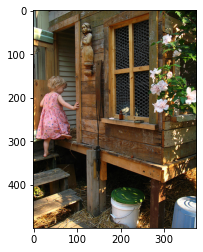

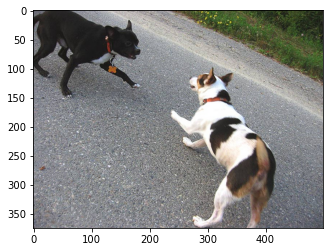

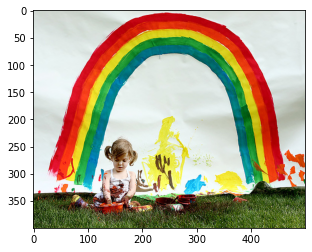

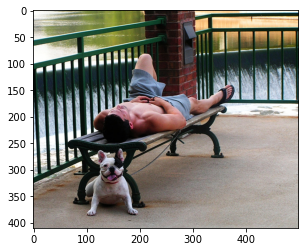

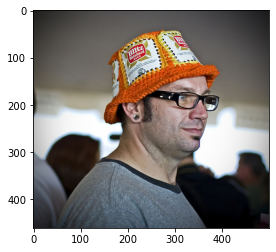

In [4]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [6]:
# Defining the function to load the captions

def load(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

file = "D:Codegnan/April/Dataset-images/captions.txt"
info = load(file)
print(info[:484])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



In [8]:
# Delete the first line as well as the last empty line and then rename the file as captions1.txt

file = "D:Codegnan/April/Dataset-images/cap.txt"
info = load(file)
print(info[:470])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



In [13]:
def load_captions(info):
    dict_1 = dict()
    for line in info.split('\n'):
        splitter = line.split('.jpg,')
        if len(splitter) < 2:
            continue  # Skip lines that don't contain the expected separator
        
        image_code = splitter[0]
        image_caption = splitter[1].strip()  # Remove leading/trailing whitespace
        
        # Create dictionary
        if image_code not in dict_1:
            dict_1[image_code] = []
            
        dict_1[image_code].append(image_caption)
        
    return dict_1

data = load_captions(info)
print(len(data))


8091


In [14]:
list(data.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [15]:
data['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# Cleanse and pre-process the data

def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            if key not in dict_2:
                dict_2[key] = list()
            
            dict_2[key].append(lines)
            
    return dict_2

data2 = cleanse_data(data)
print(len(data2))    

8091


In [17]:
# convert the following into a vocabulary of words and calculate the total words

def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

9148


In [18]:
# save descriptions to file, one per line

def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

In [19]:
images = 'D:Codegnan/April/Dataset-images/Images/'
img = glob(images + '*.jpg')
print(len(img))

def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # pre-process the images using preprocess_input() from inception module
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

8091


In [20]:
# Load the inception v3 model
input1 = InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
model = Model(input1.input, input1.layers[-2].output)

model.summary()

96112376/96112376 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [21]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec
encoding = {}

for i in tqdm(img):
    encoding[i[len(images):]] = encode(i)
    
import pickle

# Save the features in the images1 pickle file
with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

  0%|                                                                                         | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|                                                                               | 1/8091 [00:02<4:41:57,  2.09s/it]

1/1 [==============================] - 0s 198ms/step


  0%|                                                                               | 2/8091 [00:02<2:19:21,  1.03s/it]

1/1 [==============================] - 0s 173ms/step


  0%|                                                                               | 3/8091 [00:02<1:31:13,  1.48it/s]

1/1 [==============================] - 0s 173ms/step


  0%|                                                                               | 4/8091 [00:02<1:08:22,  1.97it/s]

1/1 [==============================] - 0s 173ms/step


  0%|                                                                                 | 5/8091 [00:03<55:54,  2.41it/s]

1/1 [==============================] - 0s 230ms/step


  0%|                                                                                 | 6/8091 [00:03<52:17,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


  0%|                                                                                 | 7/8091 [00:03<51:32,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


  0%|                                                                                 | 8/8091 [00:04<46:25,  2.90it/s]

1/1 [==============================] - 0s 197ms/step


  0%|                                                                                 | 9/8091 [00:04<44:17,  3.04it/s]

1/1 [==============================] - 0s 239ms/step


  0%|                                                                                | 10/8091 [00:04<46:42,  2.88it/s]

1/1 [==============================] - 0s 177ms/step


  0%|                                                                                | 11/8091 [00:05<45:04,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


  0%|                                                                                | 12/8091 [00:05<45:13,  2.98it/s]

1/1 [==============================] - 0s 184ms/step


  0%|▏                                                                               | 13/8091 [00:05<43:11,  3.12it/s]

1/1 [==============================] - 0s 235ms/step


  0%|▏                                                                               | 14/8091 [00:06<43:56,  3.06it/s]

1/1 [==============================] - 0s 189ms/step


  0%|▏                                                                               | 15/8091 [00:06<44:00,  3.06it/s]

1/1 [==============================] - 0s 231ms/step


  0%|▏                                                                               | 16/8091 [00:06<43:43,  3.08it/s]

1/1 [==============================] - 0s 202ms/step


  0%|▏                                                                               | 17/8091 [00:07<43:42,  3.08it/s]

1/1 [==============================] - 0s 187ms/step


  0%|▏                                                                               | 18/8091 [00:07<43:28,  3.09it/s]

1/1 [==============================] - 0s 192ms/step


  0%|▏                                                                               | 19/8091 [00:07<41:20,  3.25it/s]

1/1 [==============================] - 0s 173ms/step


  0%|▏                                                                               | 20/8091 [00:07<40:01,  3.36it/s]

1/1 [==============================] - 0s 172ms/step


  0%|▏                                                                               | 21/8091 [00:08<39:09,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


  0%|▏                                                                               | 22/8091 [00:08<37:54,  3.55it/s]

1/1 [==============================] - 0s 183ms/step


  0%|▏                                                                               | 23/8091 [00:08<37:00,  3.63it/s]

1/1 [==============================] - 0s 187ms/step


  0%|▏                                                                               | 24/8091 [00:08<37:15,  3.61it/s]

1/1 [==============================] - 0s 179ms/step


  0%|▏                                                                               | 25/8091 [00:09<37:53,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


  0%|▎                                                                               | 26/8091 [00:09<37:09,  3.62it/s]

1/1 [==============================] - 0s 184ms/step


  0%|▎                                                                               | 27/8091 [00:09<36:18,  3.70it/s]

1/1 [==============================] - 0s 188ms/step


  0%|▎                                                                               | 28/8091 [00:10<36:40,  3.66it/s]

1/1 [==============================] - 0s 180ms/step


  0%|▎                                                                               | 29/8091 [00:10<36:17,  3.70it/s]

1/1 [==============================] - 0s 172ms/step


  0%|▎                                                                               | 30/8091 [00:10<35:18,  3.81it/s]

1/1 [==============================] - 0s 184ms/step


  0%|▎                                                                               | 31/8091 [00:10<35:24,  3.79it/s]

1/1 [==============================] - 0s 178ms/step


  0%|▎                                                                               | 32/8091 [00:11<35:50,  3.75it/s]

1/1 [==============================] - 0s 181ms/step


  0%|▎                                                                               | 33/8091 [00:11<35:16,  3.81it/s]

1/1 [==============================] - 0s 173ms/step


  0%|▎                                                                               | 34/8091 [00:11<35:12,  3.81it/s]

1/1 [==============================] - 0s 195ms/step


  0%|▎                                                                               | 35/8091 [00:11<35:55,  3.74it/s]

1/1 [==============================] - 0s 259ms/step


  0%|▎                                                                               | 36/8091 [00:12<39:17,  3.42it/s]

1/1 [==============================] - 0s 247ms/step


  0%|▎                                                                               | 37/8091 [00:12<41:53,  3.20it/s]

1/1 [==============================] - 0s 266ms/step


  0%|▍                                                                               | 38/8091 [00:13<45:29,  2.95it/s]

1/1 [==============================] - 0s 190ms/step


  0%|▍                                                                               | 39/8091 [00:13<45:32,  2.95it/s]

1/1 [==============================] - 0s 181ms/step


  0%|▍                                                                               | 40/8091 [00:13<42:58,  3.12it/s]

1/1 [==============================] - 0s 182ms/step


  1%|▍                                                                               | 41/8091 [00:13<41:03,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▍                                                                               | 42/8091 [00:14<38:51,  3.45it/s]

1/1 [==============================] - 0s 260ms/step


  1%|▍                                                                               | 43/8091 [00:14<41:55,  3.20it/s]

1/1 [==============================] - 0s 261ms/step


  1%|▍                                                                               | 44/8091 [00:14<44:22,  3.02it/s]

1/1 [==============================] - 0s 231ms/step


  1%|▍                                                                               | 45/8091 [00:15<44:42,  3.00it/s]

1/1 [==============================] - 0s 268ms/step


  1%|▍                                                                               | 46/8091 [00:15<47:23,  2.83it/s]

1/1 [==============================] - 0s 241ms/step


  1%|▍                                                                               | 47/8091 [00:15<47:10,  2.84it/s]

1/1 [==============================] - 0s 270ms/step


  1%|▍                                                                               | 48/8091 [00:16<49:47,  2.69it/s]

1/1 [==============================] - 0s 232ms/step


  1%|▍                                                                               | 49/8091 [00:16<48:12,  2.78it/s]

1/1 [==============================] - 0s 301ms/step


  1%|▍                                                                               | 50/8091 [00:17<50:41,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


  1%|▌                                                                               | 51/8091 [00:17<49:47,  2.69it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▌                                                                               | 52/8091 [00:17<47:57,  2.79it/s]

1/1 [==============================] - 0s 201ms/step


  1%|▌                                                                               | 53/8091 [00:18<45:01,  2.98it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▌                                                                               | 54/8091 [00:18<41:54,  3.20it/s]

1/1 [==============================] - 0s 183ms/step


  1%|▌                                                                               | 55/8091 [00:18<40:06,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▌                                                                               | 56/8091 [00:18<39:15,  3.41it/s]

1/1 [==============================] - 0s 214ms/step


  1%|▌                                                                               | 57/8091 [00:19<39:28,  3.39it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▌                                                                               | 58/8091 [00:19<40:02,  3.34it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▌                                                                               | 59/8091 [00:19<38:51,  3.45it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▌                                                                               | 60/8091 [00:20<38:43,  3.46it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▌                                                                               | 61/8091 [00:20<38:34,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▌                                                                               | 62/8091 [00:20<38:45,  3.45it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▌                                                                               | 63/8091 [00:20<38:03,  3.52it/s]

1/1 [==============================] - 0s 196ms/step


  1%|▋                                                                               | 64/8091 [00:21<39:21,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▋                                                                               | 65/8091 [00:21<38:30,  3.47it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▋                                                                               | 66/8091 [00:21<38:35,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▋                                                                               | 67/8091 [00:22<38:39,  3.46it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▋                                                                               | 68/8091 [00:22<39:51,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▋                                                                               | 69/8091 [00:22<38:17,  3.49it/s]

1/1 [==============================] - 0s 180ms/step


  1%|▋                                                                               | 70/8091 [00:22<37:18,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▋                                                                               | 71/8091 [00:23<37:55,  3.53it/s]

1/1 [==============================] - 0s 178ms/step


  1%|▋                                                                               | 72/8091 [00:23<37:29,  3.57it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▋                                                                               | 73/8091 [00:23<36:48,  3.63it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▋                                                                               | 74/8091 [00:24<36:43,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▋                                                                               | 75/8091 [00:24<36:48,  3.63it/s]

1/1 [==============================] - 0s 185ms/step


  1%|▊                                                                               | 76/8091 [00:24<37:23,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▊                                                                               | 77/8091 [00:24<37:38,  3.55it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▊                                                                               | 78/8091 [00:25<37:38,  3.55it/s]

1/1 [==============================] - 0s 202ms/step


  1%|▊                                                                               | 79/8091 [00:25<38:51,  3.44it/s]

1/1 [==============================] - 0s 224ms/step


  1%|▊                                                                               | 80/8091 [00:25<39:04,  3.42it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▊                                                                               | 81/8091 [00:26<39:18,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


  1%|▊                                                                               | 82/8091 [00:26<38:54,  3.43it/s]

1/1 [==============================] - 0s 180ms/step


  1%|▊                                                                               | 83/8091 [00:26<38:09,  3.50it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▊                                                                               | 84/8091 [00:26<38:43,  3.45it/s]

1/1 [==============================] - 0s 178ms/step


  1%|▊                                                                               | 85/8091 [00:27<37:31,  3.56it/s]

1/1 [==============================] - 0s 185ms/step


  1%|▊                                                                               | 86/8091 [00:27<36:58,  3.61it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▊                                                                               | 87/8091 [00:27<37:31,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▊                                                                               | 88/8091 [00:28<36:54,  3.61it/s]

1/1 [==============================] - 0s 180ms/step


  1%|▉                                                                               | 89/8091 [00:28<37:19,  3.57it/s]

1/1 [==============================] - 0s 183ms/step


  1%|▉                                                                               | 90/8091 [00:28<36:43,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▉                                                                               | 91/8091 [00:28<37:37,  3.54it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▉                                                                               | 92/8091 [00:29<38:04,  3.50it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▉                                                                               | 93/8091 [00:29<37:01,  3.60it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▉                                                                               | 94/8091 [00:29<37:58,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▉                                                                               | 95/8091 [00:30<36:34,  3.64it/s]

1/1 [==============================] - 0s 180ms/step


  1%|▉                                                                               | 96/8091 [00:30<35:44,  3.73it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▉                                                                               | 97/8091 [00:30<35:44,  3.73it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▉                                                                               | 98/8091 [00:30<36:33,  3.64it/s]

1/1 [==============================] - 0s 200ms/step


  1%|▉                                                                               | 99/8091 [00:31<37:29,  3.55it/s]

1/1 [==============================] - 0s 183ms/step


  1%|▉                                                                              | 100/8091 [00:31<37:24,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▉                                                                              | 101/8091 [00:31<37:19,  3.57it/s]

1/1 [==============================] - 0s 196ms/step


  1%|▉                                                                              | 102/8091 [00:31<37:14,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  1%|█                                                                              | 103/8091 [00:32<37:35,  3.54it/s]

1/1 [==============================] - 0s 210ms/step


  1%|█                                                                              | 104/8091 [00:32<38:43,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


  1%|█                                                                              | 105/8091 [00:32<37:46,  3.52it/s]

1/1 [==============================] - 0s 187ms/step


  1%|█                                                                              | 106/8091 [00:33<38:31,  3.45it/s]

1/1 [==============================] - 0s 173ms/step


  1%|█                                                                              | 107/8091 [00:33<37:28,  3.55it/s]

1/1 [==============================] - 0s 203ms/step


  1%|█                                                                              | 108/8091 [00:33<38:08,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


  1%|█                                                                              | 109/8091 [00:33<37:28,  3.55it/s]

1/1 [==============================] - 0s 192ms/step


  1%|█                                                                              | 110/8091 [00:34<37:06,  3.58it/s]

1/1 [==============================] - 0s 192ms/step


  1%|█                                                                              | 111/8091 [00:34<36:52,  3.61it/s]

1/1 [==============================] - 0s 173ms/step


  1%|█                                                                              | 112/8091 [00:34<36:29,  3.64it/s]

1/1 [==============================] - 0s 172ms/step


  1%|█                                                                              | 113/8091 [00:35<35:34,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  1%|█                                                                              | 114/8091 [00:35<35:16,  3.77it/s]

1/1 [==============================] - 0s 178ms/step


  1%|█                                                                              | 115/8091 [00:35<36:36,  3.63it/s]

1/1 [==============================] - 0s 173ms/step


  1%|█▏                                                                             | 116/8091 [00:35<36:57,  3.60it/s]

1/1 [==============================] - 0s 182ms/step


  1%|█▏                                                                             | 117/8091 [00:36<37:43,  3.52it/s]

1/1 [==============================] - 0s 188ms/step


  1%|█▏                                                                             | 118/8091 [00:36<37:22,  3.55it/s]

1/1 [==============================] - 0s 182ms/step


  1%|█▏                                                                             | 119/8091 [00:36<37:31,  3.54it/s]

1/1 [==============================] - 0s 184ms/step


  1%|█▏                                                                             | 120/8091 [00:37<37:54,  3.50it/s]

1/1 [==============================] - 0s 187ms/step


  1%|█▏                                                                             | 121/8091 [00:37<37:33,  3.54it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▏                                                                             | 122/8091 [00:37<37:53,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


  2%|█▏                                                                             | 123/8091 [00:37<37:40,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▏                                                                             | 124/8091 [00:38<37:17,  3.56it/s]

1/1 [==============================] - 0s 179ms/step


  2%|█▏                                                                             | 125/8091 [00:38<37:10,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▏                                                                             | 126/8091 [00:38<36:50,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▏                                                                             | 127/8091 [00:38<36:44,  3.61it/s]

1/1 [==============================] - 0s 180ms/step


  2%|█▏                                                                             | 128/8091 [00:39<41:04,  3.23it/s]

1/1 [==============================] - 0s 172ms/step


  2%|█▎                                                                             | 129/8091 [00:39<39:24,  3.37it/s]

1/1 [==============================] - 0s 182ms/step


  2%|█▎                                                                             | 130/8091 [00:39<38:40,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▎                                                                             | 131/8091 [00:40<38:21,  3.46it/s]

1/1 [==============================] - 0s 211ms/step


  2%|█▎                                                                             | 132/8091 [00:40<38:26,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▎                                                                             | 133/8091 [00:40<38:18,  3.46it/s]

1/1 [==============================] - 0s 202ms/step


  2%|█▎                                                                             | 134/8091 [00:41<38:34,  3.44it/s]

1/1 [==============================] - 0s 184ms/step


  2%|█▎                                                                             | 135/8091 [00:41<37:56,  3.49it/s]

1/1 [==============================] - 0s 195ms/step


  2%|█▎                                                                             | 136/8091 [00:41<38:31,  3.44it/s]

1/1 [==============================] - 0s 200ms/step


  2%|█▎                                                                             | 137/8091 [00:41<38:55,  3.41it/s]

1/1 [==============================] - 0s 306ms/step


  2%|█▎                                                                             | 138/8091 [00:42<44:31,  2.98it/s]

1/1 [==============================] - 0s 301ms/step


  2%|█▎                                                                             | 139/8091 [00:42<48:45,  2.72it/s]

1/1 [==============================] - 0s 300ms/step


  2%|█▎                                                                             | 140/8091 [00:43<51:03,  2.60it/s]

1/1 [==============================] - 0s 298ms/step


  2%|█▍                                                                             | 141/8091 [00:43<52:11,  2.54it/s]

1/1 [==============================] - 0s 199ms/step


  2%|█▍                                                                             | 142/8091 [00:43<50:53,  2.60it/s]

1/1 [==============================] - 0s 194ms/step


  2%|█▍                                                                             | 143/8091 [00:44<46:39,  2.84it/s]

1/1 [==============================] - 0s 210ms/step


  2%|█▍                                                                             | 144/8091 [00:44<45:02,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▍                                                                             | 145/8091 [00:44<41:45,  3.17it/s]

1/1 [==============================] - 0s 183ms/step


  2%|█▍                                                                             | 146/8091 [00:45<40:37,  3.26it/s]

1/1 [==============================] - 0s 191ms/step


  2%|█▍                                                                             | 147/8091 [00:45<39:46,  3.33it/s]

1/1 [==============================] - 0s 180ms/step


  2%|█▍                                                                             | 148/8091 [00:45<39:54,  3.32it/s]

1/1 [==============================] - 0s 193ms/step


  2%|█▍                                                                             | 149/8091 [00:46<39:08,  3.38it/s]

1/1 [==============================] - 0s 232ms/step


  2%|█▍                                                                             | 150/8091 [00:46<40:22,  3.28it/s]

1/1 [==============================] - 0s 226ms/step


  2%|█▍                                                                             | 151/8091 [00:46<41:30,  3.19it/s]

1/1 [==============================] - 0s 196ms/step


  2%|█▍                                                                             | 152/8091 [00:46<40:30,  3.27it/s]

1/1 [==============================] - 0s 185ms/step


  2%|█▍                                                                             | 153/8091 [00:47<39:11,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▌                                                                             | 154/8091 [00:47<38:41,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▌                                                                             | 155/8091 [00:47<37:27,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▌                                                                             | 156/8091 [00:48<36:27,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▌                                                                             | 157/8091 [00:48<36:03,  3.67it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▌                                                                             | 158/8091 [00:48<35:28,  3.73it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▌                                                                             | 159/8091 [00:48<35:14,  3.75it/s]

1/1 [==============================] - 0s 189ms/step


  2%|█▌                                                                             | 160/8091 [00:49<36:06,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▌                                                                             | 161/8091 [00:49<36:00,  3.67it/s]

1/1 [==============================] - 0s 211ms/step


  2%|█▌                                                                             | 162/8091 [00:49<37:11,  3.55it/s]

1/1 [==============================] - 0s 247ms/step


  2%|█▌                                                                             | 163/8091 [00:50<40:24,  3.27it/s]

1/1 [==============================] - 0s 195ms/step


  2%|█▌                                                                             | 164/8091 [00:50<39:58,  3.31it/s]

1/1 [==============================] - 0s 241ms/step


  2%|█▌                                                                             | 165/8091 [00:50<42:04,  3.14it/s]

1/1 [==============================] - 0s 240ms/step


  2%|█▌                                                                             | 166/8091 [00:51<43:41,  3.02it/s]

1/1 [==============================] - 0s 193ms/step


  2%|█▋                                                                             | 167/8091 [00:51<42:30,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▋                                                                             | 168/8091 [00:51<40:08,  3.29it/s]

1/1 [==============================] - 0s 191ms/step


  2%|█▋                                                                             | 169/8091 [00:51<39:07,  3.37it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▋                                                                             | 170/8091 [00:52<39:15,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                             | 171/8091 [00:52<39:20,  3.36it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▋                                                                             | 172/8091 [00:52<37:47,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▋                                                                             | 173/8091 [00:53<37:24,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                             | 174/8091 [00:53<37:32,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


  2%|█▋                                                                             | 175/8091 [00:53<36:52,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▋                                                                             | 176/8091 [00:53<38:20,  3.44it/s]

1/1 [==============================] - 0s 184ms/step


  2%|█▋                                                                             | 177/8091 [00:54<38:24,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▋                                                                             | 178/8091 [00:54<37:35,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                             | 179/8091 [00:54<38:01,  3.47it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▊                                                                             | 180/8091 [00:55<37:07,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▊                                                                             | 181/8091 [00:55<36:38,  3.60it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▊                                                                             | 182/8091 [00:55<36:13,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▊                                                                             | 183/8091 [00:55<37:24,  3.52it/s]

1/1 [==============================] - 0s 185ms/step


  2%|█▊                                                                             | 184/8091 [00:56<36:22,  3.62it/s]

1/1 [==============================] - 0s 179ms/step


  2%|█▊                                                                             | 185/8091 [00:56<36:22,  3.62it/s]

1/1 [==============================] - 0s 200ms/step


  2%|█▊                                                                             | 186/8091 [00:56<37:04,  3.55it/s]

1/1 [==============================] - 0s 190ms/step


  2%|█▊                                                                             | 187/8091 [00:56<37:05,  3.55it/s]

1/1 [==============================] - 0s 192ms/step


  2%|█▊                                                                             | 188/8091 [00:57<37:49,  3.48it/s]

1/1 [==============================] - 0s 180ms/step


  2%|█▊                                                                             | 189/8091 [00:57<37:17,  3.53it/s]

1/1 [==============================] - 0s 196ms/step


  2%|█▊                                                                             | 190/8091 [00:57<37:11,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


  2%|█▊                                                                             | 191/8091 [00:58<38:17,  3.44it/s]

1/1 [==============================] - 0s 177ms/step


  2%|█▊                                                                             | 192/8091 [00:58<37:38,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▉                                                                             | 193/8091 [00:58<36:56,  3.56it/s]

1/1 [==============================] - 0s 187ms/step


  2%|█▉                                                                             | 194/8091 [00:58<37:34,  3.50it/s]

1/1 [==============================] - 0s 187ms/step


  2%|█▉                                                                             | 195/8091 [00:59<37:18,  3.53it/s]

1/1 [==============================] - 0s 183ms/step


  2%|█▉                                                                             | 196/8091 [00:59<36:45,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▉                                                                             | 197/8091 [00:59<37:09,  3.54it/s]

1/1 [==============================] - 0s 189ms/step


  2%|█▉                                                                             | 198/8091 [01:00<37:08,  3.54it/s]

1/1 [==============================] - 0s 183ms/step


  2%|█▉                                                                             | 199/8091 [01:00<36:21,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▉                                                                             | 200/8091 [01:00<35:58,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▉                                                                             | 201/8091 [01:00<36:28,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▉                                                                             | 202/8091 [01:01<35:40,  3.69it/s]

1/1 [==============================] - 0s 187ms/step


  3%|█▉                                                                             | 203/8091 [01:01<35:55,  3.66it/s]

1/1 [==============================] - 0s 173ms/step


  3%|█▉                                                                             | 204/8091 [01:01<35:22,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██                                                                             | 205/8091 [01:01<35:19,  3.72it/s]

1/1 [==============================] - 0s 196ms/step


  3%|██                                                                             | 206/8091 [01:02<35:51,  3.67it/s]

1/1 [==============================] - 0s 193ms/step


  3%|██                                                                             | 207/8091 [01:02<36:28,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██                                                                             | 208/8091 [01:02<36:37,  3.59it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██                                                                             | 209/8091 [01:03<36:11,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██                                                                             | 210/8091 [01:03<36:19,  3.62it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██                                                                             | 211/8091 [01:03<35:54,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██                                                                             | 212/8091 [01:03<35:57,  3.65it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██                                                                             | 213/8091 [01:04<35:08,  3.74it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██                                                                             | 214/8091 [01:04<34:33,  3.80it/s]

1/1 [==============================] - 0s 204ms/step


  3%|██                                                                             | 215/8091 [01:04<36:40,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██                                                                             | 216/8091 [01:05<37:17,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██                                                                             | 217/8091 [01:05<37:33,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▏                                                                            | 218/8091 [01:05<36:16,  3.62it/s]

1/1 [==============================] - 0s 193ms/step


  3%|██▏                                                                            | 219/8091 [01:05<36:50,  3.56it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▏                                                                            | 220/8091 [01:06<36:22,  3.61it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▏                                                                            | 221/8091 [01:06<35:19,  3.71it/s]

1/1 [==============================] - 0s 171ms/step


  3%|██▏                                                                            | 222/8091 [01:06<34:44,  3.78it/s]

1/1 [==============================] - 0s 205ms/step


  3%|██▏                                                                            | 223/8091 [01:06<35:37,  3.68it/s]

1/1 [==============================] - 0s 204ms/step


  3%|██▏                                                                            | 224/8091 [01:07<35:45,  3.67it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▏                                                                            | 225/8091 [01:07<35:41,  3.67it/s]

1/1 [==============================] - 0s 190ms/step


  3%|██▏                                                                            | 226/8091 [01:07<36:22,  3.60it/s]

1/1 [==============================] - 0s 174ms/step


  3%|██▏                                                                            | 227/8091 [01:08<37:10,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▏                                                                            | 228/8091 [01:08<36:31,  3.59it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▏                                                                            | 229/8091 [01:08<36:04,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▏                                                                            | 230/8091 [01:08<36:24,  3.60it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 231/8091 [01:09<36:15,  3.61it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 232/8091 [01:09<36:13,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 233/8091 [01:09<35:45,  3.66it/s]

1/1 [==============================] - 0s 185ms/step


  3%|██▎                                                                            | 234/8091 [01:09<35:42,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 235/8091 [01:10<34:53,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 236/8091 [01:10<35:23,  3.70it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 237/8091 [01:10<36:10,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▎                                                                            | 238/8091 [01:11<37:20,  3.51it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▎                                                                            | 239/8091 [01:11<37:32,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 240/8091 [01:11<37:06,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 241/8091 [01:11<37:04,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                            | 242/8091 [01:12<37:02,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


  3%|██▎                                                                            | 243/8091 [01:12<38:34,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▍                                                                            | 244/8091 [01:12<36:53,  3.55it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 245/8091 [01:13<36:14,  3.61it/s]

1/1 [==============================] - 0s 220ms/step


  3%|██▍                                                                            | 246/8091 [01:13<36:06,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 247/8091 [01:13<35:44,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 248/8091 [01:13<36:42,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 249/8091 [01:14<37:23,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


  3%|██▍                                                                            | 250/8091 [01:14<38:24,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 251/8091 [01:14<37:15,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 252/8091 [01:15<37:20,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


  3%|██▍                                                                            | 253/8091 [01:15<36:59,  3.53it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▍                                                                            | 254/8091 [01:15<36:21,  3.59it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▍                                                                            | 255/8091 [01:15<35:42,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                            | 256/8091 [01:16<35:41,  3.66it/s]

1/1 [==============================] - 0s 191ms/step


  3%|██▌                                                                            | 257/8091 [01:16<35:37,  3.67it/s]

1/1 [==============================] - 0s 174ms/step


  3%|██▌                                                                            | 258/8091 [01:16<35:23,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                            | 259/8091 [01:16<34:12,  3.82it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▌                                                                            | 260/8091 [01:17<35:41,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▌                                                                            | 261/8091 [01:17<35:46,  3.65it/s]

1/1 [==============================] - 0s 176ms/step


  3%|██▌                                                                            | 262/8091 [01:17<36:11,  3.61it/s]

1/1 [==============================] - 0s 189ms/step


  3%|██▌                                                                            | 263/8091 [01:18<36:09,  3.61it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                            | 264/8091 [01:18<36:04,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                            | 265/8091 [01:18<35:37,  3.66it/s]

1/1 [==============================] - 0s 170ms/step


  3%|██▌                                                                            | 266/8091 [01:18<35:07,  3.71it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▌                                                                            | 267/8091 [01:19<35:26,  3.68it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                            | 268/8091 [01:19<35:38,  3.66it/s]

1/1 [==============================] - 0s 181ms/step


  3%|██▋                                                                            | 269/8091 [01:19<35:29,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 270/8091 [01:19<35:11,  3.70it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 271/8091 [01:20<35:41,  3.65it/s]

1/1 [==============================] - 0s 204ms/step


  3%|██▋                                                                            | 272/8091 [01:20<36:28,  3.57it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 273/8091 [01:20<36:34,  3.56it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▋                                                                            | 274/8091 [01:21<35:45,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 275/8091 [01:21<35:31,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 276/8091 [01:21<35:45,  3.64it/s]

1/1 [==============================] - 0s 204ms/step


  3%|██▋                                                                            | 277/8091 [01:21<36:47,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


  3%|██▋                                                                            | 278/8091 [01:22<38:42,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


  3%|██▋                                                                            | 279/8091 [01:22<41:11,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 280/8091 [01:22<39:06,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 281/8091 [01:23<38:23,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▊                                                                            | 282/8091 [01:23<37:16,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▊                                                                            | 283/8091 [01:23<36:58,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


  4%|██▊                                                                            | 284/8091 [01:23<35:25,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▊                                                                            | 285/8091 [01:24<35:38,  3.65it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▊                                                                            | 286/8091 [01:24<35:01,  3.71it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▊                                                                            | 287/8091 [01:24<34:10,  3.81it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▊                                                                            | 288/8091 [01:25<34:59,  3.72it/s]

1/1 [==============================] - 0s 204ms/step


  4%|██▊                                                                            | 289/8091 [01:25<35:24,  3.67it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▊                                                                            | 290/8091 [01:25<35:45,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▊                                                                            | 291/8091 [01:25<35:27,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▊                                                                            | 292/8091 [01:26<35:52,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▊                                                                            | 293/8091 [01:26<36:32,  3.56it/s]

1/1 [==============================] - 0s 183ms/step


  4%|██▊                                                                            | 294/8091 [01:26<36:08,  3.60it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▉                                                                            | 295/8091 [01:26<35:21,  3.67it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 296/8091 [01:27<34:42,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 297/8091 [01:27<34:54,  3.72it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▉                                                                            | 298/8091 [01:27<34:24,  3.78it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 299/8091 [01:28<34:47,  3.73it/s]

1/1 [==============================] - 0s 185ms/step


  4%|██▉                                                                            | 300/8091 [01:28<35:00,  3.71it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 301/8091 [01:28<34:17,  3.79it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▉                                                                            | 302/8091 [01:28<33:49,  3.84it/s]

1/1 [==============================] - 0s 182ms/step


  4%|██▉                                                                            | 303/8091 [01:29<35:05,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 304/8091 [01:29<34:45,  3.73it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▉                                                                            | 305/8091 [01:29<34:08,  3.80it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▉                                                                            | 306/8091 [01:29<33:46,  3.84it/s]

1/1 [==============================] - 0s 204ms/step


  4%|██▉                                                                            | 307/8091 [01:30<35:23,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 308/8091 [01:30<34:49,  3.73it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 309/8091 [01:30<35:23,  3.66it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███                                                                            | 310/8091 [01:30<34:51,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███                                                                            | 311/8091 [01:31<35:08,  3.69it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███                                                                            | 312/8091 [01:31<34:44,  3.73it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 313/8091 [01:31<35:06,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 314/8091 [01:32<35:00,  3.70it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 315/8091 [01:32<35:30,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 316/8091 [01:32<36:09,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 317/8091 [01:32<35:43,  3.63it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███                                                                            | 318/8091 [01:33<35:09,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███                                                                            | 319/8091 [01:33<36:24,  3.56it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███                                                                            | 320/8091 [01:33<35:24,  3.66it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 321/8091 [01:33<35:32,  3.64it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 322/8091 [01:34<35:11,  3.68it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 323/8091 [01:34<35:47,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▏                                                                           | 324/8091 [01:34<35:43,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 325/8091 [01:35<35:28,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▏                                                                           | 326/8091 [01:35<36:18,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▏                                                                           | 327/8091 [01:35<35:44,  3.62it/s]

1/1 [==============================] - 0s 170ms/step


  4%|███▏                                                                           | 328/8091 [01:35<35:10,  3.68it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 329/8091 [01:36<35:00,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 330/8091 [01:36<35:26,  3.65it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███▏                                                                           | 331/8091 [01:36<34:55,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 332/8091 [01:36<35:04,  3.69it/s]

1/1 [==============================] - 0s 157ms/step


  4%|███▎                                                                           | 333/8091 [01:37<34:35,  3.74it/s]

1/1 [==============================] - 0s 189ms/step


  4%|███▎                                                                           | 334/8091 [01:37<35:03,  3.69it/s]

1/1 [==============================] - 0s 194ms/step


  4%|███▎                                                                           | 335/8091 [01:37<35:36,  3.63it/s]

1/1 [==============================] - 0s 182ms/step


  4%|███▎                                                                           | 336/8091 [01:38<35:27,  3.65it/s]

1/1 [==============================] - 0s 201ms/step


  4%|███▎                                                                           | 337/8091 [01:38<35:57,  3.59it/s]

1/1 [==============================] - 0s 203ms/step


  4%|███▎                                                                           | 338/8091 [01:38<36:31,  3.54it/s]

1/1 [==============================] - 0s 228ms/step


  4%|███▎                                                                           | 339/8091 [01:38<38:05,  3.39it/s]

1/1 [==============================] - 0s 254ms/step


  4%|███▎                                                                           | 340/8091 [01:39<41:10,  3.14it/s]

1/1 [==============================] - 0s 211ms/step


  4%|███▎                                                                           | 341/8091 [01:39<41:14,  3.13it/s]

1/1 [==============================] - 0s 202ms/step


  4%|███▎                                                                           | 342/8091 [01:39<39:59,  3.23it/s]

1/1 [==============================] - 0s 192ms/step


  4%|███▎                                                                           | 343/8091 [01:40<37:57,  3.40it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▎                                                                           | 344/8091 [01:40<37:08,  3.48it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▎                                                                           | 345/8091 [01:40<36:08,  3.57it/s]

1/1 [==============================] - 0s 193ms/step


  4%|███▍                                                                           | 346/8091 [01:41<35:44,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


  4%|███▍                                                                           | 347/8091 [01:41<35:12,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▍                                                                           | 348/8091 [01:41<35:13,  3.66it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███▍                                                                           | 349/8091 [01:41<34:32,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 350/8091 [01:42<34:04,  3.79it/s]

1/1 [==============================] - 0s 177ms/step


  4%|███▍                                                                           | 351/8091 [01:42<33:57,  3.80it/s]

1/1 [==============================] - 0s 196ms/step


  4%|███▍                                                                           | 352/8091 [01:42<35:05,  3.68it/s]

1/1 [==============================] - 0s 189ms/step


  4%|███▍                                                                           | 353/8091 [01:42<35:05,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▍                                                                           | 354/8091 [01:43<35:06,  3.67it/s]

1/1 [==============================] - 0s 179ms/step


  4%|███▍                                                                           | 355/8091 [01:43<34:23,  3.75it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 356/8091 [01:43<34:00,  3.79it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 357/8091 [01:43<34:08,  3.77it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███▍                                                                           | 358/8091 [01:44<33:43,  3.82it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▌                                                                           | 359/8091 [01:44<34:20,  3.75it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▌                                                                           | 360/8091 [01:44<33:40,  3.83it/s]

1/1 [==============================] - 0s 181ms/step


  4%|███▌                                                                           | 361/8091 [01:45<34:14,  3.76it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▌                                                                           | 362/8091 [01:45<34:22,  3.75it/s]

1/1 [==============================] - 0s 204ms/step


  4%|███▌                                                                           | 363/8091 [01:45<35:03,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▌                                                                           | 364/8091 [01:45<34:42,  3.71it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▌                                                                           | 365/8091 [01:46<34:32,  3.73it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▌                                                                           | 366/8091 [01:46<34:18,  3.75it/s]

1/1 [==============================] - 0s 186ms/step


  5%|███▌                                                                           | 367/8091 [01:46<34:10,  3.77it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▌                                                                           | 368/8091 [01:46<34:11,  3.76it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▌                                                                           | 369/8091 [01:47<34:40,  3.71it/s]

1/1 [==============================] - 0s 179ms/step


  5%|███▌                                                                           | 370/8091 [01:47<34:22,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▌                                                                           | 371/8091 [01:47<33:56,  3.79it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 372/8091 [01:47<34:00,  3.78it/s]

1/1 [==============================] - 0s 184ms/step


  5%|███▋                                                                           | 373/8091 [01:48<34:19,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 374/8091 [01:48<34:28,  3.73it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▋                                                                           | 375/8091 [01:48<34:06,  3.77it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▋                                                                           | 376/8091 [01:49<34:25,  3.73it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▋                                                                           | 377/8091 [01:49<34:09,  3.76it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 378/8091 [01:49<34:23,  3.74it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 379/8091 [01:49<34:34,  3.72it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 380/8091 [01:50<34:10,  3.76it/s]

1/1 [==============================] - 0s 176ms/step


  5%|███▋                                                                           | 381/8091 [01:50<33:42,  3.81it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▋                                                                           | 382/8091 [01:50<34:11,  3.76it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▋                                                                           | 383/8091 [01:50<33:48,  3.80it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 384/8091 [01:51<33:54,  3.79it/s]

1/1 [==============================] - 0s 169ms/step


  5%|███▊                                                                           | 385/8091 [01:51<34:47,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 386/8091 [01:51<34:49,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 387/8091 [01:51<34:13,  3.75it/s]

1/1 [==============================] - 0s 170ms/step


  5%|███▊                                                                           | 388/8091 [01:52<34:19,  3.74it/s]

1/1 [==============================] - 0s 204ms/step


  5%|███▊                                                                           | 389/8091 [01:52<35:40,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 390/8091 [01:52<35:41,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 391/8091 [01:53<34:58,  3.67it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▊                                                                           | 392/8091 [01:53<35:04,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▊                                                                           | 393/8091 [01:53<34:35,  3.71it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 394/8091 [01:53<34:32,  3.71it/s]

1/1 [==============================] - 0s 166ms/step


  5%|███▊                                                                           | 395/8091 [01:54<34:01,  3.77it/s]

1/1 [==============================] - 0s 184ms/step


  5%|███▊                                                                           | 396/8091 [01:54<34:31,  3.71it/s]

1/1 [==============================] - 0s 204ms/step


  5%|███▉                                                                           | 397/8091 [01:54<35:17,  3.63it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▉                                                                           | 398/8091 [01:54<34:16,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▉                                                                           | 399/8091 [01:55<33:52,  3.78it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▉                                                                           | 400/8091 [01:55<34:47,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▉                                                                           | 401/8091 [01:55<34:52,  3.67it/s]

1/1 [==============================] - 0s 185ms/step


  5%|███▉                                                                           | 402/8091 [01:56<34:57,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▉                                                                           | 403/8091 [01:56<35:02,  3.66it/s]

1/1 [==============================] - 0s 189ms/step


  5%|███▉                                                                           | 404/8091 [01:56<35:21,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▉                                                                           | 405/8091 [01:56<35:02,  3.66it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▉                                                                           | 406/8091 [01:57<34:53,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▉                                                                           | 407/8091 [01:57<35:03,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▉                                                                           | 408/8091 [01:57<34:55,  3.67it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▉                                                                           | 409/8091 [01:57<34:56,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████                                                                           | 410/8091 [01:58<35:09,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████                                                                           | 411/8091 [01:58<35:17,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████                                                                           | 412/8091 [01:58<35:17,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████                                                                           | 413/8091 [01:59<34:53,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


  5%|████                                                                           | 414/8091 [01:59<34:29,  3.71it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████                                                                           | 415/8091 [01:59<34:35,  3.70it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████                                                                           | 416/8091 [01:59<34:24,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████                                                                           | 417/8091 [02:00<33:37,  3.80it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████                                                                           | 418/8091 [02:00<34:14,  3.73it/s]

1/1 [==============================] - 0s 170ms/step


  5%|████                                                                           | 419/8091 [02:00<34:09,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████                                                                           | 420/8091 [02:00<33:51,  3.78it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████                                                                           | 421/8091 [02:01<34:39,  3.69it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████                                                                           | 422/8091 [02:01<34:04,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 423/8091 [02:01<34:28,  3.71it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▏                                                                          | 424/8091 [02:01<34:18,  3.72it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████▏                                                                          | 425/8091 [02:02<34:08,  3.74it/s]

1/1 [==============================] - 0s 204ms/step


  5%|████▏                                                                          | 426/8091 [02:02<35:21,  3.61it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 427/8091 [02:02<35:43,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 428/8091 [02:03<35:37,  3.59it/s]

1/1 [==============================] - 0s 183ms/step


  5%|████▏                                                                          | 429/8091 [02:03<34:36,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 430/8091 [02:03<34:03,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 431/8091 [02:03<35:41,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▏                                                                          | 432/8091 [02:04<34:26,  3.71it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 433/8091 [02:04<34:48,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▏                                                                          | 434/8091 [02:04<35:07,  3.63it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▏                                                                          | 435/8091 [02:04<34:27,  3.70it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████▎                                                                          | 436/8091 [02:05<34:15,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▎                                                                          | 437/8091 [02:05<33:32,  3.80it/s]

1/1 [==============================] - 0s 188ms/step


  5%|████▎                                                                          | 438/8091 [02:05<34:07,  3.74it/s]

1/1 [==============================] - 0s 185ms/step


  5%|████▎                                                                          | 439/8091 [02:06<34:05,  3.74it/s]

1/1 [==============================] - 0s 204ms/step


  5%|████▎                                                                          | 440/8091 [02:06<34:26,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▎                                                                          | 441/8091 [02:06<34:24,  3.71it/s]

1/1 [==============================] - 0s 189ms/step


  5%|████▎                                                                          | 442/8091 [02:06<34:54,  3.65it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▎                                                                          | 443/8091 [02:07<34:03,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▎                                                                          | 444/8091 [02:07<33:53,  3.76it/s]

1/1 [==============================] - 0s 191ms/step


  5%|████▎                                                                          | 445/8091 [02:07<34:16,  3.72it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▎                                                                          | 446/8091 [02:07<34:28,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▎                                                                          | 447/8091 [02:08<33:43,  3.78it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▎                                                                          | 448/8091 [02:08<33:14,  3.83it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 449/8091 [02:08<33:51,  3.76it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 450/8091 [02:09<33:56,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 451/8091 [02:09<34:42,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 452/8091 [02:09<34:16,  3.71it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 453/8091 [02:09<34:46,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 454/8091 [02:10<35:05,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


  6%|████▍                                                                          | 455/8091 [02:10<34:14,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▍                                                                          | 456/8091 [02:10<34:22,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▍                                                                          | 457/8091 [02:10<33:58,  3.74it/s]

1/1 [==============================] - 0s 163ms/step


  6%|████▍                                                                          | 458/8091 [02:11<33:13,  3.83it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▍                                                                          | 459/8091 [02:11<33:33,  3.79it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 460/8091 [02:11<34:02,  3.74it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 461/8091 [02:11<34:21,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▌                                                                          | 462/8091 [02:12<34:12,  3.72it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                          | 463/8091 [02:12<35:05,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 464/8091 [02:12<34:34,  3.68it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▌                                                                          | 465/8091 [02:13<34:48,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 466/8091 [02:13<34:55,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 467/8091 [02:13<35:43,  3.56it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▌                                                                          | 468/8091 [02:13<34:44,  3.66it/s]

1/1 [==============================] - 0s 179ms/step


  6%|████▌                                                                          | 469/8091 [02:14<34:26,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 470/8091 [02:14<34:53,  3.64it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▌                                                                          | 471/8091 [02:14<34:38,  3.67it/s]

1/1 [==============================] - 0s 179ms/step


  6%|████▌                                                                          | 472/8091 [02:14<34:29,  3.68it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▌                                                                          | 473/8091 [02:15<33:53,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 474/8091 [02:15<34:03,  3.73it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▋                                                                          | 475/8091 [02:15<34:55,  3.63it/s]

1/1 [==============================] - 0s 177ms/step


  6%|████▋                                                                          | 476/8091 [02:16<34:41,  3.66it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▋                                                                          | 477/8091 [02:16<34:35,  3.67it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▋                                                                          | 478/8091 [02:16<35:04,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 479/8091 [02:16<34:59,  3.63it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▋                                                                          | 480/8091 [02:17<34:08,  3.72it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 481/8091 [02:17<34:02,  3.73it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 482/8091 [02:17<33:50,  3.75it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▋                                                                          | 483/8091 [02:17<34:57,  3.63it/s]

1/1 [==============================] - 0s 178ms/step


  6%|████▋                                                                          | 484/8091 [02:18<35:30,  3.57it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 485/8091 [02:18<35:24,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 486/8091 [02:18<34:50,  3.64it/s]

1/1 [==============================] - 0s 186ms/step


  6%|████▊                                                                          | 487/8091 [02:19<34:47,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 488/8091 [02:19<34:41,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 489/8091 [02:19<34:22,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 490/8091 [02:19<34:27,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 491/8091 [02:20<36:06,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▊                                                                          | 492/8091 [02:20<35:29,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▊                                                                          | 493/8091 [02:20<34:27,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 494/8091 [02:21<35:31,  3.56it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▊                                                                          | 495/8091 [02:21<34:51,  3.63it/s]

1/1 [==============================] - 0s 183ms/step


  6%|████▊                                                                          | 496/8091 [02:21<34:54,  3.63it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▊                                                                          | 497/8091 [02:21<34:04,  3.71it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▊                                                                          | 498/8091 [02:22<34:43,  3.64it/s]

1/1 [==============================] - 0s 167ms/step


  6%|████▊                                                                          | 499/8091 [02:22<34:06,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


  6%|████▉                                                                          | 500/8091 [02:22<35:59,  3.51it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▉                                                                          | 501/8091 [02:22<35:06,  3.60it/s]

1/1 [==============================] - 0s 220ms/step


  6%|████▉                                                                          | 502/8091 [02:23<37:23,  3.38it/s]

1/1 [==============================] - 0s 189ms/step


  6%|████▉                                                                          | 503/8091 [02:23<36:48,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▉                                                                          | 504/8091 [02:23<35:52,  3.52it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▉                                                                          | 505/8091 [02:24<36:09,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▉                                                                          | 506/8091 [02:24<36:23,  3.47it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▉                                                                          | 507/8091 [02:24<35:43,  3.54it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▉                                                                          | 508/8091 [02:24<35:18,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▉                                                                          | 509/8091 [02:25<34:32,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▉                                                                          | 510/8091 [02:25<34:31,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▉                                                                          | 511/8091 [02:25<34:52,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▉                                                                          | 512/8091 [02:26<35:17,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


  6%|█████                                                                          | 513/8091 [02:26<34:57,  3.61it/s]

1/1 [==============================] - 0s 173ms/step


  6%|█████                                                                          | 514/8091 [02:26<34:02,  3.71it/s]

1/1 [==============================] - 0s 188ms/step


  6%|█████                                                                          | 515/8091 [02:26<35:09,  3.59it/s]

1/1 [==============================] - 0s 204ms/step


  6%|█████                                                                          | 516/8091 [02:27<35:37,  3.54it/s]

1/1 [==============================] - 0s 188ms/step


  6%|█████                                                                          | 517/8091 [02:27<35:09,  3.59it/s]

1/1 [==============================] - 0s 175ms/step


  6%|█████                                                                          | 518/8091 [02:27<34:32,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  6%|█████                                                                          | 519/8091 [02:27<34:57,  3.61it/s]

1/1 [==============================] - 0s 203ms/step


  6%|█████                                                                          | 520/8091 [02:28<36:30,  3.46it/s]

1/1 [==============================] - 0s 194ms/step


  6%|█████                                                                          | 521/8091 [02:28<36:32,  3.45it/s]

1/1 [==============================] - 0s 172ms/step


  6%|█████                                                                          | 522/8091 [02:28<35:52,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


  6%|█████                                                                          | 523/8091 [02:29<35:23,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  6%|█████                                                                          | 524/8091 [02:29<34:52,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  6%|█████▏                                                                         | 525/8091 [02:29<34:30,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▏                                                                         | 526/8091 [02:29<34:24,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▏                                                                         | 527/8091 [02:30<34:20,  3.67it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▏                                                                         | 528/8091 [02:30<35:32,  3.55it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▏                                                                         | 529/8091 [02:30<36:01,  3.50it/s]

1/1 [==============================] - 0s 235ms/step


  7%|█████▏                                                                         | 530/8091 [02:31<37:58,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▏                                                                         | 531/8091 [02:31<38:34,  3.27it/s]

1/1 [==============================] - 0s 181ms/step


  7%|█████▏                                                                         | 532/8091 [02:31<38:35,  3.26it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▏                                                                         | 533/8091 [02:32<37:07,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▏                                                                         | 534/8091 [02:32<36:34,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▏                                                                         | 535/8091 [02:32<36:56,  3.41it/s]

1/1 [==============================] - 0s 176ms/step


  7%|█████▏                                                                         | 536/8091 [02:32<36:31,  3.45it/s]

1/1 [==============================] - 0s 200ms/step


  7%|█████▏                                                                         | 537/8091 [02:33<36:35,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▎                                                                         | 538/8091 [02:33<35:22,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▎                                                                         | 539/8091 [02:33<35:17,  3.57it/s]

1/1 [==============================] - 0s 194ms/step


  7%|█████▎                                                                         | 540/8091 [02:34<34:42,  3.63it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▎                                                                         | 541/8091 [02:34<34:51,  3.61it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▎                                                                         | 542/8091 [02:34<35:23,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▎                                                                         | 543/8091 [02:34<34:47,  3.62it/s]

1/1 [==============================] - 0s 179ms/step


  7%|█████▎                                                                         | 544/8091 [02:35<34:36,  3.64it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▎                                                                         | 545/8091 [02:35<35:06,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▎                                                                         | 546/8091 [02:35<35:13,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▎                                                                         | 547/8091 [02:35<34:28,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▎                                                                         | 548/8091 [02:36<34:40,  3.63it/s]

1/1 [==============================] - 0s 165ms/step


  7%|█████▎                                                                         | 549/8091 [02:36<34:10,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▎                                                                         | 550/8091 [02:36<34:23,  3.65it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 551/8091 [02:37<34:00,  3.70it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▍                                                                         | 552/8091 [02:37<34:06,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▍                                                                         | 553/8091 [02:37<34:58,  3.59it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▍                                                                         | 554/8091 [02:37<34:18,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▍                                                                         | 555/8091 [02:38<34:06,  3.68it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▍                                                                         | 556/8091 [02:38<34:57,  3.59it/s]

1/1 [==============================] - 0s 189ms/step


  7%|█████▍                                                                         | 557/8091 [02:38<34:41,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 558/8091 [02:38<33:31,  3.75it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▍                                                                         | 559/8091 [02:39<33:44,  3.72it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▍                                                                         | 560/8091 [02:39<34:03,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 561/8091 [02:39<33:35,  3.74it/s]

1/1 [==============================] - 0s 181ms/step


  7%|█████▍                                                                         | 562/8091 [02:40<33:41,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 563/8091 [02:40<33:53,  3.70it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▌                                                                         | 564/8091 [02:40<33:44,  3.72it/s]

1/1 [==============================] - 0s 175ms/step


  7%|█████▌                                                                         | 565/8091 [02:40<33:39,  3.73it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 566/8091 [02:41<33:57,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 567/8091 [02:41<34:06,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 568/8091 [02:41<33:46,  3.71it/s]

1/1 [==============================] - 0s 187ms/step


  7%|█████▌                                                                         | 569/8091 [02:41<33:55,  3.70it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▌                                                                         | 570/8091 [02:42<34:27,  3.64it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▌                                                                         | 571/8091 [02:42<35:28,  3.53it/s]

1/1 [==============================] - 0s 220ms/step


  7%|█████▌                                                                         | 572/8091 [02:42<36:50,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 573/8091 [02:43<35:47,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 574/8091 [02:43<35:26,  3.53it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▌                                                                         | 575/8091 [02:43<34:15,  3.66it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 576/8091 [02:43<34:32,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 577/8091 [02:44<34:50,  3.59it/s]

1/1 [==============================] - 0s 189ms/step


  7%|█████▋                                                                         | 578/8091 [02:44<34:55,  3.58it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▋                                                                         | 579/8091 [02:44<34:06,  3.67it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▋                                                                         | 580/8091 [02:44<33:24,  3.75it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 581/8091 [02:45<34:24,  3.64it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 582/8091 [02:45<34:59,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 583/8091 [02:45<34:36,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▋                                                                         | 584/8091 [02:46<33:58,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 585/8091 [02:46<33:52,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 586/8091 [02:46<34:25,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 587/8091 [02:46<34:44,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▋                                                                         | 588/8091 [02:47<34:16,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 589/8091 [02:47<34:35,  3.61it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 590/8091 [02:47<34:51,  3.59it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▊                                                                         | 591/8091 [02:48<34:40,  3.60it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 592/8091 [02:48<34:31,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 593/8091 [02:48<35:27,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▊                                                                         | 594/8091 [02:48<34:28,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 595/8091 [02:49<35:05,  3.56it/s]

1/1 [==============================] - 0s 191ms/step


  7%|█████▊                                                                         | 596/8091 [02:49<35:28,  3.52it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▊                                                                         | 597/8091 [02:49<34:56,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▊                                                                         | 598/8091 [02:50<35:42,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▊                                                                         | 599/8091 [02:50<35:45,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


  7%|█████▊                                                                         | 600/8091 [02:50<36:00,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 601/8091 [02:50<35:44,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▉                                                                         | 602/8091 [02:51<36:07,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▉                                                                         | 603/8091 [02:51<35:34,  3.51it/s]

1/1 [==============================] - 0s 185ms/step


  7%|█████▉                                                                         | 604/8091 [02:51<35:11,  3.55it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▉                                                                         | 605/8091 [02:52<34:44,  3.59it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▉                                                                         | 606/8091 [02:52<34:12,  3.65it/s]

1/1 [==============================] - 0s 220ms/step


  8%|█████▉                                                                         | 607/8091 [02:52<36:04,  3.46it/s]

1/1 [==============================] - 0s 220ms/step


  8%|█████▉                                                                         | 608/8091 [02:52<37:11,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


  8%|█████▉                                                                         | 609/8091 [02:53<37:15,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


  8%|█████▉                                                                         | 610/8091 [02:53<37:07,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


  8%|█████▉                                                                         | 611/8091 [02:53<36:46,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


  8%|█████▉                                                                         | 612/8091 [02:54<36:24,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


  8%|█████▉                                                                         | 613/8091 [02:54<35:26,  3.52it/s]

1/1 [==============================] - 0s 186ms/step


  8%|█████▉                                                                         | 614/8091 [02:54<35:44,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████                                                                         | 615/8091 [02:54<34:59,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 616/8091 [02:55<34:32,  3.61it/s]

1/1 [==============================] - 0s 187ms/step


  8%|██████                                                                         | 617/8091 [02:55<34:04,  3.66it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████                                                                         | 618/8091 [02:55<34:59,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 619/8091 [02:56<35:23,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████                                                                         | 620/8091 [02:56<35:48,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 621/8091 [02:56<36:33,  3.40it/s]

1/1 [==============================] - 0s 235ms/step


  8%|██████                                                                         | 622/8091 [02:56<39:03,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████                                                                         | 623/8091 [02:57<38:09,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 624/8091 [02:57<37:40,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 625/8091 [02:57<36:44,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████                                                                         | 626/8091 [02:58<36:35,  3.40it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████                                                                         | 627/8091 [02:58<35:48,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                        | 628/8091 [02:58<35:57,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                        | 629/8091 [02:59<36:13,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                        | 630/8091 [02:59<35:49,  3.47it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▏                                                                        | 631/8091 [02:59<35:03,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▏                                                                        | 632/8091 [02:59<34:35,  3.59it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                        | 633/8091 [03:00<35:19,  3.52it/s]

1/1 [==============================] - 0s 189ms/step


  8%|██████▏                                                                        | 634/8091 [03:00<35:53,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                        | 635/8091 [03:00<35:18,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                        | 636/8091 [03:00<35:59,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                        | 637/8091 [03:01<35:13,  3.53it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▏                                                                        | 638/8091 [03:01<34:46,  3.57it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                        | 639/8091 [03:01<35:03,  3.54it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                        | 640/8091 [03:02<35:28,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▎                                                                        | 641/8091 [03:02<36:10,  3.43it/s]

1/1 [==============================] - 0s 220ms/step


  8%|██████▎                                                                        | 642/8091 [03:02<37:13,  3.33it/s]

1/1 [==============================] - 0s 212ms/step


  8%|██████▎                                                                        | 643/8091 [03:03<38:28,  3.23it/s]

1/1 [==============================] - 0s 220ms/step


  8%|██████▎                                                                        | 644/8091 [03:03<39:36,  3.13it/s]

1/1 [==============================] - 0s 235ms/step


  8%|██████▎                                                                        | 645/8091 [03:03<42:13,  2.94it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▎                                                                        | 646/8091 [03:04<41:16,  3.01it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▎                                                                        | 647/8091 [03:04<39:31,  3.14it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▎                                                                        | 648/8091 [03:04<38:52,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▎                                                                        | 649/8091 [03:04<37:50,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▎                                                                        | 650/8091 [03:05<37:27,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▎                                                                        | 651/8091 [03:05<37:25,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▎                                                                        | 652/8091 [03:05<36:20,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▍                                                                        | 653/8091 [03:06<35:53,  3.45it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▍                                                                        | 654/8091 [03:06<36:15,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 655/8091 [03:06<35:33,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 656/8091 [03:07<36:48,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▍                                                                        | 657/8091 [03:07<36:50,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▍                                                                        | 658/8091 [03:07<37:42,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▍                                                                        | 659/8091 [03:07<37:33,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 660/8091 [03:08<36:46,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 661/8091 [03:08<36:27,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▍                                                                        | 662/8091 [03:08<36:31,  3.39it/s]

1/1 [==============================] - 0s 203ms/step


  8%|██████▍                                                                        | 663/8091 [03:09<36:08,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 664/8091 [03:09<35:40,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 665/8091 [03:09<35:23,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▌                                                                        | 666/8091 [03:09<36:02,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▌                                                                        | 667/8091 [03:10<36:14,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▌                                                                        | 668/8091 [03:10<35:28,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▌                                                                        | 669/8091 [03:10<35:38,  3.47it/s]

1/1 [==============================] - 0s 215ms/step


  8%|██████▌                                                                        | 670/8091 [03:11<35:37,  3.47it/s]

1/1 [==============================] - 0s 193ms/step


  8%|██████▌                                                                        | 671/8091 [03:11<36:12,  3.41it/s]

1/1 [==============================] - 0s 189ms/step


  8%|██████▌                                                                        | 672/8091 [03:11<36:33,  3.38it/s]

1/1 [==============================] - 0s 201ms/step


  8%|██████▌                                                                        | 673/8091 [03:12<36:12,  3.41it/s]

1/1 [==============================] - 0s 211ms/step


  8%|██████▌                                                                        | 674/8091 [03:12<37:02,  3.34it/s]

1/1 [==============================] - 0s 263ms/step


  8%|██████▌                                                                        | 675/8091 [03:12<42:03,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


  8%|██████▌                                                                        | 676/8091 [03:13<43:02,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


  8%|██████▌                                                                        | 677/8091 [03:13<44:42,  2.76it/s]

1/1 [==============================] - 0s 217ms/step


  8%|██████▌                                                                        | 678/8091 [03:13<44:06,  2.80it/s]

1/1 [==============================] - 0s 220ms/step


  8%|██████▋                                                                        | 679/8091 [03:14<42:24,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


  8%|██████▋                                                                        | 680/8091 [03:14<41:53,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


  8%|██████▋                                                                        | 681/8091 [03:14<42:06,  2.93it/s]

1/1 [==============================] - 0s 213ms/step


  8%|██████▋                                                                        | 682/8091 [03:15<42:16,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


  8%|██████▋                                                                        | 683/8091 [03:15<42:21,  2.92it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▋                                                                        | 684/8091 [03:15<40:41,  3.03it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▋                                                                        | 685/8091 [03:16<40:05,  3.08it/s]

1/1 [==============================] - 0s 216ms/step


  8%|██████▋                                                                        | 686/8091 [03:16<39:20,  3.14it/s]

1/1 [==============================] - 0s 180ms/step


  8%|██████▋                                                                        | 687/8091 [03:16<38:26,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▋                                                                        | 688/8091 [03:17<37:14,  3.31it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▋                                                                        | 689/8091 [03:17<36:10,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▋                                                                        | 690/8091 [03:17<36:32,  3.37it/s]

1/1 [==============================] - 0s 187ms/step


  9%|██████▋                                                                        | 691/8091 [03:17<35:42,  3.45it/s]

1/1 [==============================] - 0s 201ms/step


  9%|██████▊                                                                        | 692/8091 [03:18<36:06,  3.41it/s]

1/1 [==============================] - 0s 201ms/step


  9%|██████▊                                                                        | 693/8091 [03:18<36:02,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▊                                                                        | 694/8091 [03:18<37:48,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▊                                                                        | 695/8091 [03:19<37:18,  3.30it/s]

1/1 [==============================] - 0s 169ms/step


  9%|██████▊                                                                        | 696/8091 [03:19<35:37,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▊                                                                        | 697/8091 [03:19<36:18,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▊                                                                        | 698/8091 [03:19<36:35,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▊                                                                        | 699/8091 [03:20<36:40,  3.36it/s]

1/1 [==============================] - 0s 189ms/step


  9%|██████▊                                                                        | 700/8091 [03:20<35:53,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▊                                                                        | 701/8091 [03:20<36:13,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▊                                                                        | 702/8091 [03:21<35:32,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▊                                                                        | 703/8091 [03:21<34:25,  3.58it/s]

1/1 [==============================] - 0s 220ms/step


  9%|██████▊                                                                        | 704/8091 [03:21<35:40,  3.45it/s]

1/1 [==============================] - 0s 172ms/step


  9%|██████▉                                                                        | 705/8091 [03:21<35:36,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                        | 706/8091 [03:22<35:25,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                        | 707/8091 [03:22<36:04,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                        | 708/8091 [03:22<36:51,  3.34it/s]

1/1 [==============================] - 0s 205ms/step


  9%|██████▉                                                                        | 709/8091 [03:23<37:25,  3.29it/s]

1/1 [==============================] - 0s 220ms/step


  9%|██████▉                                                                        | 710/8091 [03:23<38:19,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                        | 711/8091 [03:23<37:32,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                        | 712/8091 [03:24<36:44,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                        | 713/8091 [03:24<36:02,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                        | 714/8091 [03:24<35:46,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▉                                                                        | 715/8091 [03:24<35:29,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                        | 716/8091 [03:25<35:51,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████                                                                        | 717/8091 [03:25<35:24,  3.47it/s]

1/1 [==============================] - 0s 203ms/step


  9%|███████                                                                        | 718/8091 [03:25<35:34,  3.45it/s]

1/1 [==============================] - 0s 175ms/step


  9%|███████                                                                        | 719/8091 [03:26<35:14,  3.49it/s]

1/1 [==============================] - 0s 179ms/step


  9%|███████                                                                        | 720/8091 [03:26<34:44,  3.54it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████                                                                        | 721/8091 [03:26<34:28,  3.56it/s]

1/1 [==============================] - 0s 193ms/step


  9%|███████                                                                        | 722/8091 [03:26<34:13,  3.59it/s]

1/1 [==============================] - 0s 193ms/step


  9%|███████                                                                        | 723/8091 [03:27<33:52,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████                                                                        | 724/8091 [03:27<33:24,  3.68it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████                                                                        | 725/8091 [03:27<34:37,  3.55it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████                                                                        | 726/8091 [03:28<35:29,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████                                                                        | 727/8091 [03:28<35:05,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████                                                                        | 728/8091 [03:28<34:36,  3.55it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████                                                                        | 729/8091 [03:28<35:13,  3.48it/s]

1/1 [==============================] - 0s 172ms/step


  9%|███████▏                                                                       | 730/8091 [03:29<34:11,  3.59it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▏                                                                       | 731/8091 [03:29<34:09,  3.59it/s]

1/1 [==============================] - 0s 203ms/step


  9%|███████▏                                                                       | 732/8091 [03:29<33:49,  3.63it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▏                                                                       | 733/8091 [03:30<34:18,  3.57it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▏                                                                       | 734/8091 [03:30<34:34,  3.55it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▏                                                                       | 735/8091 [03:30<34:37,  3.54it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▏                                                                       | 736/8091 [03:30<36:39,  3.34it/s]

1/1 [==============================] - 0s 172ms/step


  9%|███████▏                                                                       | 737/8091 [03:31<35:26,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▏                                                                       | 738/8091 [03:31<34:50,  3.52it/s]

1/1 [==============================] - 1s 581ms/step


  9%|███████▏                                                                       | 739/8091 [03:32<50:39,  2.42it/s]

1/1 [==============================] - 0s 220ms/step


  9%|███████▏                                                                       | 740/8091 [03:32<46:33,  2.63it/s]

1/1 [==============================] - 0s 236ms/step


  9%|███████▏                                                                       | 741/8091 [03:32<45:26,  2.70it/s]

1/1 [==============================] - 0s 219ms/step


  9%|███████▏                                                                       | 742/8091 [03:33<44:32,  2.75it/s]

1/1 [==============================] - 0s 207ms/step


  9%|███████▎                                                                       | 743/8091 [03:33<43:26,  2.82it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▎                                                                       | 744/8091 [03:33<42:22,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 745/8091 [03:34<40:20,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 746/8091 [03:34<39:52,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▎                                                                       | 747/8091 [03:34<39:23,  3.11it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▎                                                                       | 748/8091 [03:35<38:18,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 749/8091 [03:35<37:06,  3.30it/s]

1/1 [==============================] - 0s 178ms/step


  9%|███████▎                                                                       | 750/8091 [03:35<36:08,  3.39it/s]

1/1 [==============================] - 0s 196ms/step


  9%|███████▎                                                                       | 751/8091 [03:35<36:35,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 752/8091 [03:36<34:37,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 753/8091 [03:36<34:56,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 754/8091 [03:36<35:58,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▎                                                                       | 755/8091 [03:37<35:46,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▍                                                                       | 756/8091 [03:37<36:11,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▍                                                                       | 757/8091 [03:37<36:10,  3.38it/s]

1/1 [==============================] - 0s 219ms/step


  9%|███████▍                                                                       | 758/8091 [03:38<38:18,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▍                                                                       | 759/8091 [03:38<38:19,  3.19it/s]

1/1 [==============================] - 0s 220ms/step


  9%|███████▍                                                                       | 760/8091 [03:38<39:35,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▍                                                                       | 761/8091 [03:38<38:53,  3.14it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▍                                                                       | 762/8091 [03:39<37:46,  3.23it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▍                                                                       | 763/8091 [03:39<36:37,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▍                                                                       | 764/8091 [03:39<36:21,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▍                                                                       | 765/8091 [03:40<36:25,  3.35it/s]

1/1 [==============================] - 0s 220ms/step


  9%|███████▍                                                                       | 766/8091 [03:40<37:52,  3.22it/s]

1/1 [==============================] - 0s 203ms/step


  9%|███████▍                                                                       | 767/8091 [03:40<36:49,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


  9%|███████▍                                                                       | 768/8091 [03:41<36:04,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 769/8091 [03:41<35:24,  3.45it/s]

1/1 [==============================] - 0s 189ms/step


 10%|███████▌                                                                       | 770/8091 [03:41<34:46,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 771/8091 [03:41<35:05,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 772/8091 [03:42<34:47,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▌                                                                       | 773/8091 [03:42<34:50,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


 10%|███████▌                                                                       | 774/8091 [03:42<36:12,  3.37it/s]

1/1 [==============================] - 0s 220ms/step


 10%|███████▌                                                                       | 775/8091 [03:43<37:45,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 776/8091 [03:43<37:14,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 777/8091 [03:43<36:11,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 778/8091 [03:43<35:01,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 779/8091 [03:44<36:01,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 780/8091 [03:44<35:30,  3.43it/s]

1/1 [==============================] - 0s 187ms/step


 10%|███████▋                                                                       | 781/8091 [03:44<34:40,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▋                                                                       | 782/8091 [03:45<35:28,  3.43it/s]

1/1 [==============================] - 0s 174ms/step


 10%|███████▋                                                                       | 783/8091 [03:45<35:06,  3.47it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▋                                                                       | 784/8091 [03:45<34:12,  3.56it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▋                                                                       | 785/8091 [03:45<34:39,  3.51it/s]

1/1 [==============================] - 0s 192ms/step


 10%|███████▋                                                                       | 786/8091 [03:46<34:26,  3.53it/s]

1/1 [==============================] - 0s 200ms/step


 10%|███████▋                                                                       | 787/8091 [03:46<34:52,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▋                                                                       | 788/8091 [03:46<34:23,  3.54it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▋                                                                       | 789/8091 [03:47<35:22,  3.44it/s]

1/1 [==============================] - 0s 186ms/step


 10%|███████▋                                                                       | 790/8091 [03:47<35:57,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▋                                                                       | 791/8091 [03:47<35:14,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▋                                                                       | 792/8091 [03:48<35:27,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▋                                                                       | 793/8091 [03:48<35:22,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▊                                                                       | 794/8091 [03:48<35:02,  3.47it/s]

1/1 [==============================] - 0s 197ms/step


 10%|███████▊                                                                       | 795/8091 [03:48<34:34,  3.52it/s]

1/1 [==============================] - 0s 172ms/step


 10%|███████▊                                                                       | 796/8091 [03:49<34:49,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 10%|███████▊                                                                       | 797/8091 [03:49<34:57,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▊                                                                       | 798/8091 [03:49<34:25,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▊                                                                       | 799/8091 [03:50<35:20,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▊                                                                       | 800/8091 [03:50<35:05,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▊                                                                       | 801/8091 [03:50<35:18,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▊                                                                       | 802/8091 [03:50<34:40,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▊                                                                       | 803/8091 [03:51<34:44,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▊                                                                       | 804/8091 [03:51<34:58,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▊                                                                       | 805/8091 [03:51<34:44,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▊                                                                       | 806/8091 [03:52<34:54,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                       | 807/8091 [03:52<34:52,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                       | 808/8091 [03:52<34:18,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


 10%|███████▉                                                                       | 809/8091 [03:52<36:05,  3.36it/s]

1/1 [==============================] - 0s 215ms/step


 10%|███████▉                                                                       | 810/8091 [03:53<38:23,  3.16it/s]

1/1 [==============================] - 0s 196ms/step


 10%|███████▉                                                                       | 811/8091 [03:53<37:24,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                       | 812/8091 [03:53<36:16,  3.34it/s]

1/1 [==============================] - 0s 189ms/step


 10%|███████▉                                                                       | 813/8091 [03:54<36:13,  3.35it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▉                                                                       | 814/8091 [03:54<35:33,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                       | 815/8091 [03:54<35:26,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▉                                                                       | 816/8091 [03:54<35:18,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▉                                                                       | 817/8091 [03:55<35:21,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▉                                                                       | 818/8091 [03:55<34:58,  3.47it/s]

1/1 [==============================] - 0s 180ms/step


 10%|███████▉                                                                       | 819/8091 [03:55<34:48,  3.48it/s]

1/1 [==============================] - 0s 220ms/step


 10%|████████                                                                       | 820/8091 [03:56<35:20,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 10%|████████                                                                       | 821/8091 [03:56<36:02,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 822/8091 [03:56<35:18,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 823/8091 [03:57<35:18,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 824/8091 [03:57<35:23,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████                                                                       | 825/8091 [03:57<34:44,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 826/8091 [03:57<34:16,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


 10%|████████                                                                       | 827/8091 [03:58<35:06,  3.45it/s]

1/1 [==============================] - 0s 172ms/step


 10%|████████                                                                       | 828/8091 [03:58<34:17,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 829/8091 [03:58<34:38,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 830/8091 [03:59<35:03,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 831/8091 [03:59<34:49,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████                                                                       | 832/8091 [03:59<35:49,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 833/8091 [03:59<35:10,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 10%|████████▏                                                                      | 834/8091 [04:00<35:14,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 835/8091 [04:00<34:50,  3.47it/s]

1/1 [==============================] - 0s 191ms/step


 10%|████████▏                                                                      | 836/8091 [04:00<34:41,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 837/8091 [04:01<35:49,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 838/8091 [04:01<35:34,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 839/8091 [04:01<35:30,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


 10%|████████▏                                                                      | 840/8091 [04:01<35:10,  3.44it/s]

1/1 [==============================] - 0s 209ms/step


 10%|████████▏                                                                      | 841/8091 [04:02<36:04,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 842/8091 [04:02<34:55,  3.46it/s]

1/1 [==============================] - 0s 222ms/step


 10%|████████▏                                                                      | 843/8091 [04:02<36:24,  3.32it/s]

1/1 [==============================] - 0s 184ms/step


 10%|████████▏                                                                      | 844/8091 [04:03<36:08,  3.34it/s]

1/1 [==============================] - 0s 191ms/step


 10%|████████▎                                                                      | 845/8091 [04:03<36:35,  3.30it/s]

1/1 [==============================] - 0s 201ms/step


 10%|████████▎                                                                      | 846/8091 [04:03<36:07,  3.34it/s]

1/1 [==============================] - 0s 187ms/step


 10%|████████▎                                                                      | 847/8091 [04:04<35:18,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 10%|████████▎                                                                      | 848/8091 [04:04<36:17,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▎                                                                      | 849/8091 [04:04<35:40,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▎                                                                      | 850/8091 [04:04<35:46,  3.37it/s]

1/1 [==============================] - 0s 191ms/step


 11%|████████▎                                                                      | 851/8091 [04:05<35:31,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▎                                                                      | 852/8091 [04:05<36:21,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▎                                                                      | 853/8091 [04:05<35:45,  3.37it/s]

1/1 [==============================] - 0s 174ms/step


 11%|████████▎                                                                      | 854/8091 [04:06<35:02,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▎                                                                      | 855/8091 [04:06<35:18,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▎                                                                      | 856/8091 [04:06<34:56,  3.45it/s]

1/1 [==============================] - 0s 214ms/step


 11%|████████▎                                                                      | 857/8091 [04:07<35:24,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▍                                                                      | 858/8091 [04:07<35:14,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▍                                                                      | 859/8091 [04:07<35:23,  3.41it/s]

1/1 [==============================] - 0s 190ms/step


 11%|████████▍                                                                      | 860/8091 [04:07<35:05,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                      | 861/8091 [04:08<35:08,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                      | 862/8091 [04:08<35:13,  3.42it/s]

1/1 [==============================] - 0s 189ms/step


 11%|████████▍                                                                      | 863/8091 [04:08<34:40,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                      | 864/8091 [04:09<34:38,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▍                                                                      | 865/8091 [04:09<35:52,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▍                                                                      | 866/8091 [04:09<35:52,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                      | 867/8091 [04:09<35:11,  3.42it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████████▍                                                                      | 868/8091 [04:10<34:55,  3.45it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████████▍                                                                      | 869/8091 [04:10<35:22,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                      | 870/8091 [04:10<34:24,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▌                                                                      | 871/8091 [04:11<34:38,  3.47it/s]

1/1 [==============================] - 0s 189ms/step


 11%|████████▌                                                                      | 872/8091 [04:11<34:46,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▌                                                                      | 873/8091 [04:11<34:22,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 874/8091 [04:11<33:50,  3.55it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 875/8091 [04:12<34:11,  3.52it/s]

1/1 [==============================] - 0s 220ms/step


 11%|████████▌                                                                      | 876/8091 [04:12<35:06,  3.42it/s]

1/1 [==============================] - 0s 251ms/step


 11%|████████▌                                                                      | 877/8091 [04:12<36:58,  3.25it/s]

1/1 [==============================] - 0s 220ms/step


 11%|████████▌                                                                      | 878/8091 [04:13<38:33,  3.12it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 879/8091 [04:13<37:19,  3.22it/s]

1/1 [==============================] - 0s 187ms/step


 11%|████████▌                                                                      | 880/8091 [04:13<36:24,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▌                                                                      | 881/8091 [04:14<35:53,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 882/8091 [04:14<34:48,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 883/8091 [04:14<34:21,  3.50it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▋                                                                      | 884/8091 [04:14<34:54,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▋                                                                      | 885/8091 [04:15<34:27,  3.49it/s]

1/1 [==============================] - 0s 191ms/step


 11%|████████▋                                                                      | 886/8091 [04:15<35:02,  3.43it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████████▋                                                                      | 887/8091 [04:15<35:08,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▋                                                                      | 888/8091 [04:16<35:03,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▋                                                                      | 889/8091 [04:16<34:31,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▋                                                                      | 890/8091 [04:16<34:54,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▋                                                                      | 891/8091 [04:16<36:21,  3.30it/s]

1/1 [==============================] - 0s 189ms/step


 11%|████████▋                                                                      | 892/8091 [04:17<35:28,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▋                                                                      | 893/8091 [04:17<35:47,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▋                                                                      | 894/8091 [04:17<36:40,  3.27it/s]

1/1 [==============================] - 0s 187ms/step


 11%|████████▋                                                                      | 895/8091 [04:18<35:59,  3.33it/s]

1/1 [==============================] - 0s 220ms/step


 11%|████████▋                                                                      | 896/8091 [04:18<36:56,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▊                                                                      | 897/8091 [04:18<37:12,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▊                                                                      | 898/8091 [04:19<37:36,  3.19it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████████▊                                                                      | 899/8091 [04:19<37:05,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▊                                                                      | 900/8091 [04:19<37:39,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▊                                                                      | 901/8091 [04:20<37:36,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▊                                                                      | 902/8091 [04:20<36:46,  3.26it/s]

1/1 [==============================] - 0s 185ms/step


 11%|████████▊                                                                      | 903/8091 [04:20<37:00,  3.24it/s]

1/1 [==============================] - 0s 172ms/step


 11%|████████▊                                                                      | 904/8091 [04:20<36:45,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▊                                                                      | 905/8091 [04:21<35:41,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▊                                                                      | 906/8091 [04:21<35:37,  3.36it/s]

1/1 [==============================] - 0s 189ms/step


 11%|████████▊                                                                      | 907/8091 [04:21<36:07,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████████▊                                                                      | 908/8091 [04:22<35:45,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 909/8091 [04:22<35:06,  3.41it/s]

1/1 [==============================] - 0s 219ms/step


 11%|████████▉                                                                      | 910/8091 [04:22<36:50,  3.25it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████████▉                                                                      | 911/8091 [04:23<37:02,  3.23it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████████▉                                                                      | 912/8091 [04:23<36:43,  3.26it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████████▉                                                                      | 913/8091 [04:23<36:19,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▉                                                                      | 914/8091 [04:23<35:02,  3.41it/s]

1/1 [==============================] - 0s 189ms/step


 11%|████████▉                                                                      | 915/8091 [04:24<35:13,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 916/8091 [04:24<35:44,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 917/8091 [04:24<35:44,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 918/8091 [04:25<35:53,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 919/8091 [04:25<35:45,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 920/8091 [04:25<36:13,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 921/8091 [04:26<35:49,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█████████                                                                      | 922/8091 [04:26<35:02,  3.41it/s]

1/1 [==============================] - 0s 206ms/step


 11%|█████████                                                                      | 923/8091 [04:26<35:28,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█████████                                                                      | 924/8091 [04:26<35:28,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█████████                                                                      | 925/8091 [04:27<34:21,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█████████                                                                      | 926/8091 [04:27<34:44,  3.44it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█████████                                                                      | 927/8091 [04:27<34:27,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█████████                                                                      | 928/8091 [04:28<34:28,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


 11%|█████████                                                                      | 929/8091 [04:28<34:06,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█████████                                                                      | 930/8091 [04:28<34:46,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████                                                                      | 931/8091 [04:28<34:37,  3.45it/s]

1/1 [==============================] - 0s 177ms/step


 12%|█████████                                                                      | 932/8091 [04:29<34:34,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████                                                                      | 933/8091 [04:29<34:33,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████                                                                      | 934/8091 [04:29<34:51,  3.42it/s]

1/1 [==============================] - 0s 179ms/step


 12%|█████████▏                                                                     | 935/8091 [04:30<34:22,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▏                                                                     | 936/8091 [04:30<35:05,  3.40it/s]

1/1 [==============================] - 0s 220ms/step


 12%|█████████▏                                                                     | 937/8091 [04:30<35:48,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▏                                                                     | 938/8091 [04:31<35:57,  3.31it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▏                                                                     | 939/8091 [04:31<35:08,  3.39it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█████████▏                                                                     | 940/8091 [04:31<35:01,  3.40it/s]

1/1 [==============================] - 0s 179ms/step


 12%|█████████▏                                                                     | 941/8091 [04:31<34:45,  3.43it/s]

1/1 [==============================] - 0s 176ms/step


 12%|█████████▏                                                                     | 942/8091 [04:32<34:04,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▏                                                                     | 943/8091 [04:32<33:45,  3.53it/s]

1/1 [==============================] - 0s 235ms/step


 12%|█████████▏                                                                     | 944/8091 [04:32<35:48,  3.33it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▏                                                                     | 945/8091 [04:33<36:08,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▏                                                                     | 946/8091 [04:33<35:58,  3.31it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█████████▏                                                                     | 947/8091 [04:33<35:33,  3.35it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▎                                                                     | 948/8091 [04:33<35:24,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▎                                                                     | 949/8091 [04:34<35:19,  3.37it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█████████▎                                                                     | 950/8091 [04:34<35:51,  3.32it/s]

1/1 [==============================] - 0s 177ms/step


 12%|█████████▎                                                                     | 951/8091 [04:34<36:17,  3.28it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█████████▎                                                                     | 952/8091 [04:35<35:39,  3.34it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▎                                                                     | 953/8091 [04:35<34:31,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▎                                                                     | 954/8091 [04:35<35:36,  3.34it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█████████▎                                                                     | 955/8091 [04:36<35:12,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▎                                                                     | 956/8091 [04:36<34:35,  3.44it/s]

1/1 [==============================] - 0s 192ms/step


 12%|█████████▎                                                                     | 957/8091 [04:36<34:49,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▎                                                                     | 958/8091 [04:36<34:54,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▎                                                                     | 959/8091 [04:37<34:54,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▎                                                                     | 960/8091 [04:37<41:05,  2.89it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█████████▍                                                                     | 961/8091 [04:38<40:58,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 12%|█████████▍                                                                     | 962/8091 [04:38<40:34,  2.93it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▍                                                                     | 963/8091 [04:38<39:50,  2.98it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▍                                                                     | 964/8091 [04:39<38:38,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▍                                                                     | 965/8091 [04:39<37:58,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▍                                                                     | 966/8091 [04:39<37:06,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▍                                                                     | 967/8091 [04:39<37:05,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▍                                                                     | 968/8091 [04:40<36:49,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▍                                                                     | 969/8091 [04:40<35:47,  3.32it/s]

1/1 [==============================] - 0s 220ms/step


 12%|█████████▍                                                                     | 970/8091 [04:40<36:47,  3.23it/s]

1/1 [==============================] - 0s 235ms/step


 12%|█████████▍                                                                     | 971/8091 [04:41<37:36,  3.15it/s]

1/1 [==============================] - 0s 229ms/step


 12%|█████████▍                                                                     | 972/8091 [04:41<37:34,  3.16it/s]

1/1 [==============================] - 0s 220ms/step


 12%|█████████▌                                                                     | 973/8091 [04:41<37:56,  3.13it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█████████▌                                                                     | 974/8091 [04:42<38:33,  3.08it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                     | 975/8091 [04:42<37:55,  3.13it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▌                                                                     | 976/8091 [04:42<38:22,  3.09it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▌                                                                     | 977/8091 [04:43<38:35,  3.07it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█████████▌                                                                     | 978/8091 [04:43<38:34,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                     | 979/8091 [04:43<38:05,  3.11it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▌                                                                     | 980/8091 [04:44<38:16,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▌                                                                     | 981/8091 [04:44<37:05,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                     | 982/8091 [04:44<36:15,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                     | 983/8091 [04:44<35:42,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                     | 984/8091 [04:45<35:42,  3.32it/s]

1/1 [==============================] - 0s 180ms/step


 12%|█████████▌                                                                     | 985/8091 [04:45<34:45,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                     | 986/8091 [04:45<34:13,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                     | 987/8091 [04:46<33:55,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                     | 988/8091 [04:46<33:21,  3.55it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▋                                                                     | 989/8091 [04:46<34:19,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                     | 990/8091 [04:46<34:15,  3.45it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█████████▋                                                                     | 991/8091 [04:47<34:41,  3.41it/s]

1/1 [==============================] - 0s 216ms/step


 12%|█████████▋                                                                     | 992/8091 [04:47<34:53,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                     | 993/8091 [04:47<35:17,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                     | 994/8091 [04:48<35:23,  3.34it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▋                                                                     | 995/8091 [04:48<35:21,  3.35it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█████████▋                                                                     | 996/8091 [04:48<34:50,  3.39it/s]

1/1 [==============================] - 0s 213ms/step


 12%|█████████▋                                                                     | 997/8091 [04:49<35:35,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                     | 998/8091 [04:49<35:59,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▊                                                                     | 999/8091 [04:49<36:12,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                    | 1000/8091 [04:49<35:46,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                    | 1001/8091 [04:50<35:17,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                    | 1002/8091 [04:50<35:23,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                    | 1003/8091 [04:50<34:43,  3.40it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█████████▋                                                                    | 1004/8091 [04:51<36:06,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                    | 1005/8091 [04:51<35:32,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                    | 1006/8091 [04:51<34:53,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                    | 1007/8091 [04:52<35:09,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                    | 1008/8091 [04:52<35:12,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▋                                                                    | 1009/8091 [04:52<35:23,  3.33it/s]

1/1 [==============================] - 0s 208ms/step


 12%|█████████▋                                                                    | 1010/8091 [04:52<35:21,  3.34it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█████████▋                                                                    | 1011/8091 [04:53<37:25,  3.15it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█████████▊                                                                    | 1012/8091 [04:53<38:10,  3.09it/s]

1/1 [==============================] - 0s 213ms/step


 13%|█████████▊                                                                    | 1013/8091 [04:53<37:33,  3.14it/s]

1/1 [==============================] - 0s 210ms/step


 13%|█████████▊                                                                    | 1014/8091 [04:54<36:47,  3.21it/s]

1/1 [==============================] - 0s 225ms/step


 13%|█████████▊                                                                    | 1015/8091 [04:54<36:52,  3.20it/s]

1/1 [==============================] - 0s 235ms/step


 13%|█████████▊                                                                    | 1016/8091 [04:54<37:19,  3.16it/s]

1/1 [==============================] - 0s 207ms/step


 13%|█████████▊                                                                    | 1017/8091 [04:55<37:30,  3.14it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▊                                                                    | 1018/8091 [04:55<37:32,  3.14it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▊                                                                    | 1019/8091 [04:55<37:45,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▊                                                                    | 1020/8091 [04:56<37:35,  3.13it/s]

1/1 [==============================] - 0s 217ms/step


 13%|█████████▊                                                                    | 1021/8091 [04:56<37:34,  3.14it/s]

1/1 [==============================] - 0s 233ms/step


 13%|█████████▊                                                                    | 1022/8091 [04:56<38:02,  3.10it/s]

1/1 [==============================] - 0s 221ms/step


 13%|█████████▊                                                                    | 1023/8091 [04:57<38:12,  3.08it/s]

1/1 [==============================] - 0s 235ms/step


 13%|█████████▊                                                                    | 1024/8091 [04:57<38:52,  3.03it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1025/8091 [04:57<37:59,  3.10it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1026/8091 [04:58<37:48,  3.11it/s]

1/1 [==============================] - 0s 217ms/step


 13%|█████████▉                                                                    | 1027/8091 [04:58<37:54,  3.11it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1028/8091 [04:58<37:43,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▉                                                                    | 1029/8091 [04:59<37:54,  3.11it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1030/8091 [04:59<37:12,  3.16it/s]

1/1 [==============================] - 0s 209ms/step


 13%|█████████▉                                                                    | 1031/8091 [04:59<37:01,  3.18it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1032/8091 [05:00<36:59,  3.18it/s]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                    | 1033/8091 [05:00<37:37,  3.13it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█████████▉                                                                    | 1034/8091 [05:00<36:41,  3.20it/s]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                    | 1035/8091 [05:00<37:04,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1036/8091 [05:01<37:17,  3.15it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1037/8091 [05:01<36:41,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                    | 1038/8091 [05:01<36:06,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                    | 1039/8091 [05:02<36:23,  3.23it/s]

1/1 [==============================] - 0s 219ms/step


 13%|██████████                                                                    | 1040/8091 [05:02<36:13,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████                                                                    | 1041/8091 [05:02<35:51,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


 13%|██████████                                                                    | 1042/8091 [05:03<37:24,  3.14it/s]

1/1 [==============================] - 0s 215ms/step


 13%|██████████                                                                    | 1043/8091 [05:03<37:34,  3.13it/s]

1/1 [==============================] - 0s 206ms/step


 13%|██████████                                                                    | 1044/8091 [05:03<37:04,  3.17it/s]

1/1 [==============================] - 0s 235ms/step


 13%|██████████                                                                    | 1045/8091 [05:04<37:58,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                    | 1046/8091 [05:04<37:27,  3.14it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                    | 1047/8091 [05:04<37:42,  3.11it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                    | 1048/8091 [05:05<38:20,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                    | 1049/8091 [05:05<37:51,  3.10it/s]

1/1 [==============================] - 0s 194ms/step


 13%|██████████                                                                    | 1050/8091 [05:05<37:03,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                   | 1051/8091 [05:06<36:27,  3.22it/s]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▏                                                                   | 1052/8091 [05:06<36:42,  3.20it/s]

1/1 [==============================] - 0s 220ms/step


 13%|██████████▏                                                                   | 1053/8091 [05:06<37:17,  3.14it/s]

1/1 [==============================] - 0s 207ms/step


 13%|██████████▏                                                                   | 1054/8091 [05:06<36:43,  3.19it/s]

1/1 [==============================] - 0s 211ms/step


 13%|██████████▏                                                                   | 1055/8091 [05:07<36:37,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                   | 1056/8091 [05:07<35:40,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▏                                                                   | 1057/8091 [05:07<35:22,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                   | 1058/8091 [05:08<35:33,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▏                                                                   | 1059/8091 [05:08<34:44,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                   | 1060/8091 [05:08<34:51,  3.36it/s]

1/1 [==============================] - 0s 181ms/step


 13%|██████████▏                                                                   | 1061/8091 [05:09<34:11,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                   | 1062/8091 [05:09<33:47,  3.47it/s]

1/1 [==============================] - 0s 193ms/step


 13%|██████████▏                                                                   | 1063/8091 [05:09<34:17,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▎                                                                   | 1064/8091 [05:09<34:37,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▎                                                                   | 1065/8091 [05:10<35:28,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▎                                                                   | 1066/8091 [05:10<35:23,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▎                                                                   | 1067/8091 [05:10<35:00,  3.34it/s]

1/1 [==============================] - 0s 208ms/step


 13%|██████████▎                                                                   | 1068/8091 [05:11<35:06,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▎                                                                   | 1069/8091 [05:11<35:14,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▎                                                                   | 1070/8091 [05:11<34:27,  3.40it/s]

1/1 [==============================] - 0s 187ms/step


 13%|██████████▎                                                                   | 1071/8091 [05:11<33:37,  3.48it/s]

1/1 [==============================] - 0s 189ms/step


 13%|██████████▎                                                                   | 1072/8091 [05:12<33:19,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▎                                                                   | 1073/8091 [05:12<33:39,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▎                                                                   | 1074/8091 [05:12<33:32,  3.49it/s]

1/1 [==============================] - 0s 235ms/step


 13%|██████████▎                                                                   | 1075/8091 [05:13<35:28,  3.30it/s]

1/1 [==============================] - 0s 212ms/step


 13%|██████████▎                                                                   | 1076/8091 [05:13<37:48,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1077/8091 [05:13<36:54,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1078/8091 [05:14<36:50,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1079/8091 [05:14<36:50,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1080/8091 [05:14<36:19,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1081/8091 [05:15<35:57,  3.25it/s]

1/1 [==============================] - 0s 220ms/step


 13%|██████████▍                                                                   | 1082/8091 [05:15<35:57,  3.25it/s]

1/1 [==============================] - 0s 220ms/step


 13%|██████████▍                                                                   | 1083/8091 [05:15<35:36,  3.28it/s]

1/1 [==============================] - 0s 202ms/step


 13%|██████████▍                                                                   | 1084/8091 [05:16<35:55,  3.25it/s]

1/1 [==============================] - 0s 221ms/step


 13%|██████████▍                                                                   | 1085/8091 [05:16<35:03,  3.33it/s]

1/1 [==============================] - 0s 208ms/step


 13%|██████████▍                                                                   | 1086/8091 [05:16<35:04,  3.33it/s]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▍                                                                   | 1087/8091 [05:16<35:04,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1088/8091 [05:17<35:04,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▍                                                                   | 1089/8091 [05:17<34:40,  3.36it/s]

1/1 [==============================] - 0s 243ms/step


 13%|██████████▌                                                                   | 1090/8091 [05:17<37:09,  3.14it/s]

1/1 [==============================] - 0s 191ms/step


 13%|██████████▌                                                                   | 1091/8091 [05:18<36:01,  3.24it/s]

1/1 [==============================] - 0s 200ms/step


 13%|██████████▌                                                                   | 1092/8091 [05:18<35:33,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▌                                                                   | 1093/8091 [05:18<34:38,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▌                                                                   | 1094/8091 [05:18<33:56,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▌                                                                   | 1095/8091 [05:19<33:22,  3.49it/s]

1/1 [==============================] - 0s 194ms/step


 14%|██████████▌                                                                   | 1096/8091 [05:19<33:02,  3.53it/s]

1/1 [==============================] - 0s 192ms/step


 14%|██████████▌                                                                   | 1097/8091 [05:19<33:58,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▌                                                                   | 1098/8091 [05:20<34:24,  3.39it/s]

1/1 [==============================] - 0s 220ms/step


 14%|██████████▌                                                                   | 1099/8091 [05:20<34:52,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▌                                                                   | 1100/8091 [05:20<34:45,  3.35it/s]

1/1 [==============================] - 0s 173ms/step


 14%|██████████▌                                                                   | 1101/8091 [05:21<34:36,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▌                                                                   | 1102/8091 [05:21<33:57,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▋                                                                   | 1103/8091 [05:21<33:59,  3.43it/s]

1/1 [==============================] - 0s 190ms/step


 14%|██████████▋                                                                   | 1104/8091 [05:21<33:45,  3.45it/s]

1/1 [==============================] - 0s 179ms/step


 14%|██████████▋                                                                   | 1105/8091 [05:22<33:37,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▋                                                                   | 1106/8091 [05:22<33:15,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▋                                                                   | 1107/8091 [05:22<32:59,  3.53it/s]

1/1 [==============================] - 0s 220ms/step


 14%|██████████▋                                                                   | 1108/8091 [05:23<33:28,  3.48it/s]

1/1 [==============================] - 0s 235ms/step


 14%|██████████▋                                                                   | 1109/8091 [05:23<34:39,  3.36it/s]

1/1 [==============================] - 0s 187ms/step


 14%|██████████▋                                                                   | 1110/8091 [05:23<34:47,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▋                                                                   | 1111/8091 [05:23<34:48,  3.34it/s]

1/1 [==============================] - 0s 203ms/step


 14%|██████████▋                                                                   | 1112/8091 [05:24<34:39,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▋                                                                   | 1113/8091 [05:24<34:29,  3.37it/s]

1/1 [==============================] - 0s 203ms/step


 14%|██████████▋                                                                   | 1114/8091 [05:24<34:16,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▋                                                                   | 1115/8091 [05:25<34:21,  3.38it/s]

1/1 [==============================] - 0s 186ms/step


 14%|██████████▊                                                                   | 1116/8091 [05:25<33:46,  3.44it/s]

1/1 [==============================] - 0s 195ms/step


 14%|██████████▊                                                                   | 1117/8091 [05:25<33:42,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▊                                                                   | 1118/8091 [05:26<34:00,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 14%|██████████▊                                                                   | 1119/8091 [05:26<33:29,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▊                                                                   | 1120/8091 [05:26<33:39,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▊                                                                   | 1121/8091 [05:26<33:52,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


 14%|██████████▊                                                                   | 1122/8091 [05:27<33:33,  3.46it/s]

1/1 [==============================] - 0s 181ms/step


 14%|██████████▊                                                                   | 1123/8091 [05:27<33:39,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▊                                                                   | 1124/8091 [05:27<33:27,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▊                                                                   | 1125/8091 [05:28<34:01,  3.41it/s]

1/1 [==============================] - 0s 191ms/step


 14%|██████████▊                                                                   | 1126/8091 [05:28<34:12,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▊                                                                   | 1127/8091 [05:28<34:40,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▊                                                                   | 1128/8091 [05:28<34:25,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▉                                                                   | 1129/8091 [05:29<34:05,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▉                                                                   | 1130/8091 [05:29<34:20,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▉                                                                   | 1131/8091 [05:29<34:38,  3.35it/s]

1/1 [==============================] - 0s 194ms/step


 14%|██████████▉                                                                   | 1132/8091 [05:30<34:13,  3.39it/s]

1/1 [==============================] - 0s 193ms/step


 14%|██████████▉                                                                   | 1133/8091 [05:30<34:15,  3.38it/s]

1/1 [==============================] - 0s 212ms/step


 14%|██████████▉                                                                   | 1134/8091 [05:30<34:48,  3.33it/s]

1/1 [==============================] - 0s 200ms/step


 14%|██████████▉                                                                   | 1135/8091 [05:31<35:07,  3.30it/s]

1/1 [==============================] - 0s 197ms/step


 14%|██████████▉                                                                   | 1136/8091 [05:31<34:31,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▉                                                                   | 1137/8091 [05:31<34:17,  3.38it/s]

1/1 [==============================] - 0s 190ms/step


 14%|██████████▉                                                                   | 1138/8091 [05:31<33:35,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▉                                                                   | 1139/8091 [05:32<34:56,  3.32it/s]

1/1 [==============================] - 0s 200ms/step


 14%|██████████▉                                                                   | 1140/8091 [05:32<34:46,  3.33it/s]

1/1 [==============================] - 0s 193ms/step


 14%|██████████▉                                                                   | 1141/8091 [05:32<35:12,  3.29it/s]

1/1 [==============================] - 0s 218ms/step


 14%|███████████                                                                   | 1142/8091 [05:33<35:46,  3.24it/s]

1/1 [==============================] - 0s 194ms/step


 14%|███████████                                                                   | 1143/8091 [05:33<35:32,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


 14%|███████████                                                                   | 1144/8091 [05:33<36:57,  3.13it/s]

1/1 [==============================] - 0s 172ms/step


 14%|███████████                                                                   | 1145/8091 [05:34<36:55,  3.14it/s]

1/1 [==============================] - 0s 212ms/step


 14%|███████████                                                                   | 1146/8091 [05:34<36:42,  3.15it/s]

1/1 [==============================] - 0s 216ms/step


 14%|███████████                                                                   | 1147/8091 [05:34<36:57,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████                                                                   | 1148/8091 [05:35<35:49,  3.23it/s]

1/1 [==============================] - 0s 193ms/step


 14%|███████████                                                                   | 1149/8091 [05:35<35:20,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 14%|███████████                                                                   | 1150/8091 [05:35<35:31,  3.26it/s]

1/1 [==============================] - 0s 189ms/step


 14%|███████████                                                                   | 1151/8091 [05:35<35:29,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 14%|███████████                                                                   | 1152/8091 [05:36<36:05,  3.20it/s]

1/1 [==============================] - 0s 193ms/step


 14%|███████████                                                                   | 1153/8091 [05:36<35:22,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 14%|███████████                                                                   | 1154/8091 [05:36<35:35,  3.25it/s]

1/1 [==============================] - 0s 177ms/step


 14%|███████████▏                                                                  | 1155/8091 [05:37<34:50,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 14%|███████████▏                                                                  | 1156/8091 [05:37<34:20,  3.37it/s]

1/1 [==============================] - 0s 201ms/step


 14%|███████████▏                                                                  | 1157/8091 [05:37<34:04,  3.39it/s]

1/1 [==============================] - 0s 196ms/step


 14%|███████████▏                                                                  | 1158/8091 [05:38<33:53,  3.41it/s]

1/1 [==============================] - 0s 203ms/step


 14%|███████████▏                                                                  | 1159/8091 [05:38<33:31,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████▏                                                                  | 1160/8091 [05:38<33:58,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


 14%|███████████▏                                                                  | 1161/8091 [05:38<34:26,  3.35it/s]

1/1 [==============================] - 0s 190ms/step


 14%|███████████▏                                                                  | 1162/8091 [05:39<33:39,  3.43it/s]

1/1 [==============================] - 0s 189ms/step


 14%|███████████▏                                                                  | 1163/8091 [05:39<34:01,  3.39it/s]

1/1 [==============================] - 0s 203ms/step


 14%|███████████▏                                                                  | 1164/8091 [05:39<34:49,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


 14%|███████████▏                                                                  | 1165/8091 [05:40<34:26,  3.35it/s]

1/1 [==============================] - 0s 182ms/step


 14%|███████████▏                                                                  | 1166/8091 [05:40<33:53,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 14%|███████████▎                                                                  | 1167/8091 [05:40<34:49,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████▎                                                                  | 1168/8091 [05:41<34:48,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 14%|███████████▎                                                                  | 1169/8091 [05:41<36:17,  3.18it/s]

1/1 [==============================] - 0s 195ms/step


 14%|███████████▎                                                                  | 1170/8091 [05:41<34:54,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 14%|███████████▎                                                                  | 1171/8091 [05:41<35:15,  3.27it/s]

1/1 [==============================] - 0s 189ms/step


 14%|███████████▎                                                                  | 1172/8091 [05:42<34:44,  3.32it/s]

1/1 [==============================] - 0s 200ms/step


 14%|███████████▎                                                                  | 1173/8091 [05:42<34:39,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▎                                                                  | 1174/8091 [05:42<34:35,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▎                                                                  | 1175/8091 [05:43<34:24,  3.35it/s]

1/1 [==============================] - 0s 207ms/step


 15%|███████████▎                                                                  | 1176/8091 [05:43<34:44,  3.32it/s]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▎                                                                  | 1177/8091 [05:43<34:29,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▎                                                                  | 1178/8091 [05:44<34:01,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▎                                                                  | 1179/8091 [05:44<33:29,  3.44it/s]

1/1 [==============================] - 0s 194ms/step


 15%|███████████▍                                                                  | 1180/8091 [05:44<33:46,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▍                                                                  | 1181/8091 [05:44<34:35,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▍                                                                  | 1182/8091 [05:45<34:12,  3.37it/s]

1/1 [==============================] - 0s 172ms/step


 15%|███████████▍                                                                  | 1183/8091 [05:45<32:51,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▍                                                                  | 1184/8091 [05:45<33:11,  3.47it/s]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▍                                                                  | 1185/8091 [05:46<32:48,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▍                                                                  | 1186/8091 [05:46<32:46,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▍                                                                  | 1187/8091 [05:46<33:36,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▍                                                                  | 1188/8091 [05:46<33:25,  3.44it/s]

1/1 [==============================] - 0s 194ms/step


 15%|███████████▍                                                                  | 1189/8091 [05:47<33:25,  3.44it/s]

1/1 [==============================] - 0s 202ms/step


 15%|███████████▍                                                                  | 1190/8091 [05:47<33:34,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▍                                                                  | 1191/8091 [05:47<34:16,  3.35it/s]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▍                                                                  | 1192/8091 [05:48<34:49,  3.30it/s]

1/1 [==============================] - 0s 201ms/step


 15%|███████████▌                                                                  | 1193/8091 [05:48<34:42,  3.31it/s]

1/1 [==============================] - 0s 202ms/step


 15%|███████████▌                                                                  | 1194/8091 [05:48<34:41,  3.31it/s]

1/1 [==============================] - 0s 235ms/step


 15%|███████████▌                                                                  | 1195/8091 [05:49<36:29,  3.15it/s]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▌                                                                  | 1196/8091 [05:49<35:25,  3.24it/s]

1/1 [==============================] - 0s 220ms/step


 15%|███████████▌                                                                  | 1197/8091 [05:49<35:43,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▌                                                                  | 1198/8091 [05:50<36:14,  3.17it/s]

1/1 [==============================] - 0s 220ms/step


 15%|███████████▌                                                                  | 1199/8091 [05:50<35:36,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▌                                                                  | 1200/8091 [05:50<35:39,  3.22it/s]

1/1 [==============================] - 0s 220ms/step


 15%|███████████▌                                                                  | 1201/8091 [05:50<35:56,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▌                                                                  | 1202/8091 [05:51<35:26,  3.24it/s]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▌                                                                  | 1203/8091 [05:51<34:46,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▌                                                                  | 1204/8091 [05:51<35:09,  3.27it/s]

1/1 [==============================] - 0s 201ms/step


 15%|███████████▌                                                                  | 1205/8091 [05:52<35:15,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                  | 1206/8091 [05:52<34:28,  3.33it/s]

1/1 [==============================] - 0s 193ms/step


 15%|███████████▋                                                                  | 1207/8091 [05:52<34:14,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▋                                                                  | 1208/8091 [05:53<34:05,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▋                                                                  | 1209/8091 [05:53<34:38,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                  | 1210/8091 [05:53<34:21,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                  | 1211/8091 [05:53<35:45,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▋                                                                  | 1212/8091 [05:54<35:12,  3.26it/s]

1/1 [==============================] - 0s 180ms/step


 15%|███████████▋                                                                  | 1213/8091 [05:54<33:55,  3.38it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▋                                                                  | 1214/8091 [05:54<33:47,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                  | 1215/8091 [05:55<33:54,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                  | 1216/8091 [05:55<33:57,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                  | 1217/8091 [05:55<33:56,  3.38it/s]

1/1 [==============================] - 0s 186ms/step


 15%|███████████▋                                                                  | 1218/8091 [05:56<33:35,  3.41it/s]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▊                                                                  | 1219/8091 [05:56<33:26,  3.42it/s]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▊                                                                  | 1220/8091 [05:56<34:01,  3.37it/s]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▊                                                                  | 1221/8091 [05:56<34:10,  3.35it/s]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▊                                                                  | 1222/8091 [05:57<34:07,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▊                                                                  | 1223/8091 [05:57<33:07,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▊                                                                  | 1224/8091 [05:57<33:47,  3.39it/s]

1/1 [==============================] - 0s 198ms/step


 15%|███████████▊                                                                  | 1225/8091 [05:58<33:07,  3.45it/s]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▊                                                                  | 1226/8091 [05:58<33:46,  3.39it/s]

1/1 [==============================] - 0s 178ms/step


 15%|███████████▊                                                                  | 1227/8091 [05:58<32:55,  3.47it/s]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▊                                                                  | 1228/8091 [05:58<32:48,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▊                                                                  | 1229/8091 [05:59<32:58,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▊                                                                  | 1230/8091 [05:59<34:27,  3.32it/s]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▊                                                                  | 1231/8091 [05:59<34:30,  3.31it/s]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▉                                                                  | 1232/8091 [06:00<34:51,  3.28it/s]

1/1 [==============================] - 0s 178ms/step


 15%|███████████▉                                                                  | 1233/8091 [06:00<34:27,  3.32it/s]

1/1 [==============================] - 0s 201ms/step


 15%|███████████▉                                                                  | 1234/8091 [06:00<34:47,  3.28it/s]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▉                                                                  | 1235/8091 [06:01<34:07,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▉                                                                  | 1236/8091 [06:01<33:58,  3.36it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▉                                                                  | 1237/8091 [06:01<33:22,  3.42it/s]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▉                                                                  | 1238/8091 [06:01<33:22,  3.42it/s]

1/1 [==============================] - 0s 220ms/step


 15%|███████████▉                                                                  | 1239/8091 [06:02<33:43,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▉                                                                  | 1240/8091 [06:02<34:08,  3.34it/s]

1/1 [==============================] - 0s 194ms/step


 15%|███████████▉                                                                  | 1241/8091 [06:02<33:55,  3.36it/s]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▉                                                                  | 1242/8091 [06:03<34:22,  3.32it/s]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▉                                                                  | 1243/8091 [06:03<36:14,  3.15it/s]

1/1 [==============================] - 0s 185ms/step


 15%|███████████▉                                                                  | 1244/8091 [06:03<35:49,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


 15%|████████████                                                                  | 1245/8091 [06:04<35:53,  3.18it/s]

1/1 [==============================] - 0s 180ms/step


 15%|████████████                                                                  | 1246/8091 [06:04<35:31,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 15%|████████████                                                                  | 1247/8091 [06:04<35:01,  3.26it/s]

1/1 [==============================] - 0s 193ms/step


 15%|████████████                                                                  | 1248/8091 [06:05<35:06,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 15%|████████████                                                                  | 1249/8091 [06:05<35:45,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 15%|████████████                                                                  | 1250/8091 [06:05<35:35,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 15%|████████████                                                                  | 1251/8091 [06:05<35:20,  3.23it/s]

1/1 [==============================] - 0s 209ms/step


 15%|████████████                                                                  | 1252/8091 [06:06<35:16,  3.23it/s]

1/1 [==============================] - 0s 172ms/step


 15%|████████████                                                                  | 1253/8091 [06:06<34:43,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


 15%|████████████                                                                  | 1254/8091 [06:06<34:04,  3.34it/s]

1/1 [==============================] - 0s 187ms/step


 16%|████████████                                                                  | 1255/8091 [06:07<33:31,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████                                                                  | 1256/8091 [06:07<33:06,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████                                                                  | 1257/8091 [06:07<33:13,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                 | 1258/8091 [06:08<33:29,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▏                                                                 | 1259/8091 [06:08<33:22,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                 | 1260/8091 [06:08<34:01,  3.35it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▏                                                                 | 1261/8091 [06:08<33:59,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                 | 1262/8091 [06:09<34:06,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                 | 1263/8091 [06:09<34:20,  3.31it/s]

1/1 [==============================] - 0s 180ms/step


 16%|████████████▏                                                                 | 1264/8091 [06:09<33:37,  3.38it/s]

1/1 [==============================] - 0s 186ms/step


 16%|████████████▏                                                                 | 1265/8091 [06:10<33:14,  3.42it/s]

1/1 [==============================] - 0s 185ms/step


 16%|████████████▏                                                                 | 1266/8091 [06:10<33:17,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▏                                                                 | 1267/8091 [06:10<33:26,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▏                                                                 | 1268/8091 [06:10<32:59,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                 | 1269/8091 [06:11<33:21,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▏                                                                 | 1270/8091 [06:11<33:46,  3.37it/s]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▎                                                                 | 1271/8091 [06:11<33:34,  3.39it/s]

1/1 [==============================] - 0s 193ms/step


 16%|████████████▎                                                                 | 1272/8091 [06:12<33:23,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▎                                                                 | 1273/8091 [06:12<33:29,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▎                                                                 | 1274/8091 [06:12<32:34,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▎                                                                 | 1275/8091 [06:12<32:32,  3.49it/s]

1/1 [==============================] - 0s 235ms/step


 16%|████████████▎                                                                 | 1276/8091 [06:13<34:07,  3.33it/s]

1/1 [==============================] - 0s 184ms/step


 16%|████████████▎                                                                 | 1277/8091 [06:13<33:42,  3.37it/s]

1/1 [==============================] - 0s 196ms/step


 16%|████████████▎                                                                 | 1278/8091 [06:13<33:22,  3.40it/s]

1/1 [==============================] - 0s 191ms/step


 16%|████████████▎                                                                 | 1279/8091 [06:14<33:24,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▎                                                                 | 1280/8091 [06:14<33:30,  3.39it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▎                                                                 | 1281/8091 [06:14<33:02,  3.43it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▎                                                                 | 1282/8091 [06:15<33:16,  3.41it/s]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▎                                                                 | 1283/8091 [06:15<33:35,  3.38it/s]

1/1 [==============================] - 0s 175ms/step


 16%|████████████▍                                                                 | 1284/8091 [06:15<33:09,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▍                                                                 | 1285/8091 [06:15<32:47,  3.46it/s]

1/1 [==============================] - 0s 179ms/step


 16%|████████████▍                                                                 | 1286/8091 [06:16<32:10,  3.53it/s]

1/1 [==============================] - 0s 179ms/step


 16%|████████████▍                                                                 | 1287/8091 [06:16<32:57,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▍                                                                 | 1288/8091 [06:16<33:07,  3.42it/s]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▍                                                                 | 1289/8091 [06:17<33:19,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▍                                                                 | 1290/8091 [06:17<33:35,  3.37it/s]

1/1 [==============================] - 0s 183ms/step


 16%|████████████▍                                                                 | 1291/8091 [06:17<33:26,  3.39it/s]

1/1 [==============================] - 0s 220ms/step


 16%|████████████▍                                                                 | 1292/8091 [06:18<34:33,  3.28it/s]

1/1 [==============================] - 0s 220ms/step


 16%|████████████▍                                                                 | 1293/8091 [06:18<35:13,  3.22it/s]

1/1 [==============================] - 0s 187ms/step


 16%|████████████▍                                                                 | 1294/8091 [06:18<34:51,  3.25it/s]

1/1 [==============================] - 0s 198ms/step


 16%|████████████▍                                                                 | 1295/8091 [06:18<34:21,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▍                                                                 | 1296/8091 [06:19<33:08,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▌                                                                 | 1297/8091 [06:19<33:39,  3.36it/s]

1/1 [==============================] - 0s 184ms/step


 16%|████████████▌                                                                 | 1298/8091 [06:19<32:47,  3.45it/s]

1/1 [==============================] - 0s 196ms/step


 16%|████████████▌                                                                 | 1299/8091 [06:20<33:07,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▌                                                                 | 1300/8091 [06:20<33:27,  3.38it/s]

1/1 [==============================] - 0s 192ms/step


 16%|████████████▌                                                                 | 1301/8091 [06:20<33:06,  3.42it/s]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▌                                                                 | 1302/8091 [06:21<33:43,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▌                                                                 | 1303/8091 [06:21<34:14,  3.30it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▌                                                                 | 1304/8091 [06:21<34:06,  3.32it/s]

1/1 [==============================] - 0s 189ms/step


 16%|████████████▌                                                                 | 1305/8091 [06:21<33:41,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


 16%|████████████▌                                                                 | 1306/8091 [06:22<34:46,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


 16%|████████████▌                                                                 | 1307/8091 [06:22<35:45,  3.16it/s]

1/1 [==============================] - 0s 235ms/step


 16%|████████████▌                                                                 | 1308/8091 [06:22<37:03,  3.05it/s]

1/1 [==============================] - 0s 259ms/step


 16%|████████████▌                                                                 | 1309/8091 [06:23<38:52,  2.91it/s]

1/1 [==============================] - 0s 250ms/step


 16%|████████████▋                                                                 | 1310/8091 [06:23<39:43,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 16%|████████████▋                                                                 | 1311/8091 [06:23<38:37,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 16%|████████████▋                                                                 | 1312/8091 [06:24<38:44,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▋                                                                 | 1313/8091 [06:24<37:17,  3.03it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▋                                                                 | 1314/8091 [06:24<35:45,  3.16it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▋                                                                 | 1315/8091 [06:25<34:25,  3.28it/s]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▋                                                                 | 1316/8091 [06:25<33:44,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▋                                                                 | 1317/8091 [06:25<33:35,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▋                                                                 | 1318/8091 [06:26<33:50,  3.34it/s]

1/1 [==============================] - 0s 178ms/step


 16%|████████████▋                                                                 | 1319/8091 [06:26<32:51,  3.44it/s]

1/1 [==============================] - 0s 194ms/step


 16%|████████████▋                                                                 | 1320/8091 [06:26<33:08,  3.41it/s]

1/1 [==============================] - 0s 186ms/step


 16%|████████████▋                                                                 | 1321/8091 [06:26<32:11,  3.50it/s]

1/1 [==============================] - 0s 198ms/step


 16%|████████████▋                                                                 | 1322/8091 [06:27<32:08,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▊                                                                 | 1323/8091 [06:27<32:34,  3.46it/s]

1/1 [==============================] - 0s 178ms/step


 16%|████████████▊                                                                 | 1324/8091 [06:27<32:33,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▊                                                                 | 1325/8091 [06:28<32:28,  3.47it/s]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▊                                                                 | 1326/8091 [06:28<32:35,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▊                                                                 | 1327/8091 [06:28<32:37,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▊                                                                 | 1328/8091 [06:28<32:26,  3.47it/s]

1/1 [==============================] - 0s 191ms/step


 16%|████████████▊                                                                 | 1329/8091 [06:29<32:06,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▊                                                                 | 1330/8091 [06:29<32:32,  3.46it/s]

1/1 [==============================] - 0s 189ms/step


 16%|████████████▊                                                                 | 1331/8091 [06:29<32:23,  3.48it/s]

1/1 [==============================] - 0s 185ms/step


 16%|████████████▊                                                                 | 1332/8091 [06:30<32:39,  3.45it/s]

1/1 [==============================] - 0s 187ms/step


 16%|████████████▊                                                                 | 1333/8091 [06:30<32:50,  3.43it/s]

1/1 [==============================] - 0s 220ms/step


 16%|████████████▊                                                                 | 1334/8091 [06:30<34:03,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▊                                                                 | 1335/8091 [06:31<34:39,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 17%|████████████▉                                                                 | 1336/8091 [06:31<34:17,  3.28it/s]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▉                                                                 | 1337/8091 [06:31<33:38,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 17%|████████████▉                                                                 | 1338/8091 [06:31<33:40,  3.34it/s]

1/1 [==============================] - 0s 178ms/step


 17%|████████████▉                                                                 | 1339/8091 [06:32<32:51,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 17%|████████████▉                                                                 | 1340/8091 [06:32<33:50,  3.32it/s]

1/1 [==============================] - 0s 186ms/step


 17%|████████████▉                                                                 | 1341/8091 [06:32<33:31,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 17%|████████████▉                                                                 | 1342/8091 [06:33<33:45,  3.33it/s]

1/1 [==============================] - 0s 208ms/step


 17%|████████████▉                                                                 | 1343/8091 [06:33<34:36,  3.25it/s]

1/1 [==============================] - 0s 189ms/step


 17%|████████████▉                                                                 | 1344/8091 [06:33<34:14,  3.28it/s]

1/1 [==============================] - 0s 182ms/step


 17%|████████████▉                                                                 | 1345/8091 [06:34<33:28,  3.36it/s]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▉                                                                 | 1346/8091 [06:34<33:24,  3.37it/s]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▉                                                                 | 1347/8091 [06:34<33:53,  3.32it/s]

1/1 [==============================] - 0s 185ms/step


 17%|████████████▉                                                                 | 1348/8091 [06:34<33:10,  3.39it/s]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████                                                                 | 1349/8091 [06:35<33:05,  3.40it/s]

1/1 [==============================] - 0s 195ms/step


 17%|█████████████                                                                 | 1350/8091 [06:35<33:53,  3.32it/s]

1/1 [==============================] - 0s 184ms/step


 17%|█████████████                                                                 | 1351/8091 [06:35<32:48,  3.42it/s]

1/1 [==============================] - 0s 181ms/step


 17%|█████████████                                                                 | 1352/8091 [06:36<33:07,  3.39it/s]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████                                                                 | 1353/8091 [06:36<32:32,  3.45it/s]

1/1 [==============================] - 0s 208ms/step


 17%|█████████████                                                                 | 1354/8091 [06:36<32:50,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████                                                                 | 1355/8091 [06:36<32:41,  3.43it/s]

1/1 [==============================] - 0s 184ms/step


 17%|█████████████                                                                 | 1356/8091 [06:37<32:36,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████                                                                 | 1357/8091 [06:37<32:35,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████                                                                 | 1358/8091 [06:37<32:51,  3.41it/s]

1/1 [==============================] - 0s 186ms/step


 17%|█████████████                                                                 | 1359/8091 [06:38<32:29,  3.45it/s]

1/1 [==============================] - 0s 199ms/step


 17%|█████████████                                                                 | 1360/8091 [06:38<32:48,  3.42it/s]

1/1 [==============================] - 0s 202ms/step


 17%|█████████████                                                                 | 1361/8091 [06:38<33:07,  3.39it/s]

1/1 [==============================] - 0s 183ms/step


 17%|█████████████▏                                                                | 1362/8091 [06:39<32:41,  3.43it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▏                                                                | 1363/8091 [06:39<32:32,  3.45it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▏                                                                | 1364/8091 [06:39<32:41,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                | 1365/8091 [06:39<32:45,  3.42it/s]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████▏                                                                | 1366/8091 [06:40<32:42,  3.43it/s]

1/1 [==============================] - 0s 175ms/step


 17%|█████████████▏                                                                | 1367/8091 [06:40<32:00,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▏                                                                | 1368/8091 [06:40<32:28,  3.45it/s]

1/1 [==============================] - 0s 186ms/step


 17%|█████████████▏                                                                | 1369/8091 [06:41<32:26,  3.45it/s]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████▏                                                                | 1370/8091 [06:41<32:57,  3.40it/s]

1/1 [==============================] - 0s 194ms/step


 17%|█████████████▏                                                                | 1371/8091 [06:41<32:38,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                | 1372/8091 [06:41<32:54,  3.40it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▏                                                                | 1373/8091 [06:42<32:55,  3.40it/s]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▏                                                                | 1374/8091 [06:42<33:27,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▎                                                                | 1375/8091 [06:42<34:23,  3.25it/s]

1/1 [==============================] - 0s 195ms/step


 17%|█████████████▎                                                                | 1376/8091 [06:43<33:57,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▎                                                                | 1377/8091 [06:43<34:48,  3.21it/s]

1/1 [==============================] - 0s 220ms/step


 17%|█████████████▎                                                                | 1378/8091 [06:43<35:03,  3.19it/s]

1/1 [==============================] - 0s 176ms/step


 17%|█████████████▎                                                                | 1379/8091 [06:44<34:10,  3.27it/s]

1/1 [==============================] - 0s 194ms/step


 17%|█████████████▎                                                                | 1380/8091 [06:44<33:27,  3.34it/s]

1/1 [==============================] - 0s 190ms/step


 17%|█████████████▎                                                                | 1381/8091 [06:44<33:34,  3.33it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▎                                                                | 1382/8091 [06:44<33:02,  3.38it/s]

1/1 [==============================] - 0s 203ms/step


 17%|█████████████▎                                                                | 1383/8091 [06:45<33:36,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▎                                                                | 1384/8091 [06:45<34:21,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▎                                                                | 1385/8091 [06:45<35:33,  3.14it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▎                                                                | 1386/8091 [06:46<34:01,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▎                                                                | 1387/8091 [06:46<33:33,  3.33it/s]

1/1 [==============================] - 0s 184ms/step


 17%|█████████████▍                                                                | 1388/8091 [06:46<33:06,  3.37it/s]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████▍                                                                | 1389/8091 [06:47<33:02,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▍                                                                | 1390/8091 [06:47<32:32,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▍                                                                | 1391/8091 [06:47<31:54,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▍                                                                | 1392/8091 [06:47<33:33,  3.33it/s]

1/1 [==============================] - 0s 184ms/step


 17%|█████████████▍                                                                | 1393/8091 [06:48<33:20,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▍                                                                | 1394/8091 [06:48<33:38,  3.32it/s]

1/1 [==============================] - 0s 191ms/step


 17%|█████████████▍                                                                | 1395/8091 [06:48<33:45,  3.31it/s]

1/1 [==============================] - 0s 179ms/step


 17%|█████████████▍                                                                | 1396/8091 [06:49<33:47,  3.30it/s]

1/1 [==============================] - 0s 177ms/step


 17%|█████████████▍                                                                | 1397/8091 [06:49<32:55,  3.39it/s]

1/1 [==============================] - 0s 203ms/step


 17%|█████████████▍                                                                | 1398/8091 [06:49<33:33,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▍                                                                | 1399/8091 [06:50<33:06,  3.37it/s]

1/1 [==============================] - 0s 193ms/step


 17%|█████████████▍                                                                | 1400/8091 [06:50<32:51,  3.39it/s]

1/1 [==============================] - 0s 205ms/step


 17%|█████████████▌                                                                | 1401/8091 [06:50<33:47,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▌                                                                | 1402/8091 [06:50<32:46,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▌                                                                | 1403/8091 [06:51<33:02,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▌                                                                | 1404/8091 [06:51<32:58,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▌                                                                | 1405/8091 [06:51<33:15,  3.35it/s]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████▌                                                                | 1406/8091 [06:52<33:30,  3.32it/s]

1/1 [==============================] - 0s 190ms/step


 17%|█████████████▌                                                                | 1407/8091 [06:52<33:33,  3.32it/s]

1/1 [==============================] - 0s 206ms/step


 17%|█████████████▌                                                                | 1408/8091 [06:52<34:14,  3.25it/s]

1/1 [==============================] - 0s 194ms/step


 17%|█████████████▌                                                                | 1409/8091 [06:53<34:10,  3.26it/s]

1/1 [==============================] - 0s 209ms/step


 17%|█████████████▌                                                                | 1410/8091 [06:53<34:48,  3.20it/s]

1/1 [==============================] - 0s 219ms/step


 17%|█████████████▌                                                                | 1411/8091 [06:53<35:02,  3.18it/s]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▌                                                                | 1412/8091 [06:54<34:57,  3.18it/s]

1/1 [==============================] - 0s 183ms/step


 17%|█████████████▌                                                                | 1413/8091 [06:54<34:50,  3.19it/s]

1/1 [==============================] - 0s 195ms/step


 17%|█████████████▋                                                                | 1414/8091 [06:54<34:51,  3.19it/s]

1/1 [==============================] - 0s 211ms/step


 17%|█████████████▋                                                                | 1415/8091 [06:54<34:05,  3.26it/s]

1/1 [==============================] - 0s 174ms/step


 18%|█████████████▋                                                                | 1416/8091 [06:55<33:29,  3.32it/s]

1/1 [==============================] - 0s 203ms/step


 18%|█████████████▋                                                                | 1417/8091 [06:55<33:01,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▋                                                                | 1418/8091 [06:55<33:25,  3.33it/s]

1/1 [==============================] - 0s 192ms/step


 18%|█████████████▋                                                                | 1419/8091 [06:56<33:53,  3.28it/s]

1/1 [==============================] - 0s 179ms/step


 18%|█████████████▋                                                                | 1420/8091 [06:56<33:40,  3.30it/s]

1/1 [==============================] - 0s 179ms/step


 18%|█████████████▋                                                                | 1421/8091 [06:56<32:53,  3.38it/s]

1/1 [==============================] - 0s 198ms/step


 18%|█████████████▋                                                                | 1422/8091 [06:57<32:53,  3.38it/s]

1/1 [==============================] - 0s 190ms/step


 18%|█████████████▋                                                                | 1423/8091 [06:57<32:50,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▋                                                                | 1424/8091 [06:57<32:47,  3.39it/s]

1/1 [==============================] - 0s 194ms/step


 18%|█████████████▋                                                                | 1425/8091 [06:57<32:49,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▋                                                                | 1426/8091 [06:58<33:22,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▊                                                                | 1427/8091 [06:58<32:56,  3.37it/s]

1/1 [==============================] - 0s 194ms/step


 18%|█████████████▊                                                                | 1428/8091 [06:58<33:06,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▊                                                                | 1429/8091 [06:59<33:41,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▊                                                                | 1430/8091 [06:59<34:11,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▊                                                                | 1431/8091 [06:59<33:50,  3.28it/s]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▊                                                                | 1432/8091 [07:00<34:43,  3.20it/s]

1/1 [==============================] - 0s 186ms/step


 18%|█████████████▊                                                                | 1433/8091 [07:00<34:48,  3.19it/s]

1/1 [==============================] - 0s 189ms/step


 18%|█████████████▊                                                                | 1434/8091 [07:00<34:09,  3.25it/s]

1/1 [==============================] - 0s 193ms/step


 18%|█████████████▊                                                                | 1435/8091 [07:00<34:14,  3.24it/s]

1/1 [==============================] - 0s 186ms/step


 18%|█████████████▊                                                                | 1436/8091 [07:01<33:44,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▊                                                                | 1437/8091 [07:01<33:14,  3.34it/s]

1/1 [==============================] - 0s 196ms/step


 18%|█████████████▊                                                                | 1438/8091 [07:01<32:52,  3.37it/s]

1/1 [==============================] - 0s 205ms/step


 18%|█████████████▊                                                                | 1439/8091 [07:02<32:48,  3.38it/s]

1/1 [==============================] - 0s 187ms/step


 18%|█████████████▉                                                                | 1440/8091 [07:02<33:07,  3.35it/s]

1/1 [==============================] - 0s 191ms/step


 18%|█████████████▉                                                                | 1441/8091 [07:02<32:45,  3.38it/s]

1/1 [==============================] - 0s 191ms/step


 18%|█████████████▉                                                                | 1442/8091 [07:03<32:35,  3.40it/s]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▉                                                                | 1443/8091 [07:03<33:48,  3.28it/s]

1/1 [==============================] - 0s 209ms/step


 18%|█████████████▉                                                                | 1444/8091 [07:03<34:23,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▉                                                                | 1445/8091 [07:03<33:57,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▉                                                                | 1446/8091 [07:04<34:21,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▉                                                                | 1447/8091 [07:04<33:14,  3.33it/s]

1/1 [==============================] - 0s 179ms/step


 18%|█████████████▉                                                                | 1448/8091 [07:04<33:04,  3.35it/s]

1/1 [==============================] - 0s 192ms/step


 18%|█████████████▉                                                                | 1449/8091 [07:05<33:05,  3.35it/s]

1/1 [==============================] - 0s 185ms/step


 18%|█████████████▉                                                                | 1450/8091 [07:05<33:28,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▉                                                                | 1451/8091 [07:05<32:44,  3.38it/s]

1/1 [==============================] - 0s 198ms/step


 18%|█████████████▉                                                                | 1452/8091 [07:06<32:53,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████                                                                | 1453/8091 [07:06<33:24,  3.31it/s]

1/1 [==============================] - 0s 195ms/step


 18%|██████████████                                                                | 1454/8091 [07:06<33:00,  3.35it/s]

1/1 [==============================] - 0s 196ms/step


 18%|██████████████                                                                | 1455/8091 [07:06<32:51,  3.37it/s]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████                                                                | 1456/8091 [07:07<35:01,  3.16it/s]

1/1 [==============================] - 0s 169ms/step


 18%|██████████████                                                                | 1457/8091 [07:07<33:45,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████                                                                | 1458/8091 [07:07<33:39,  3.28it/s]

1/1 [==============================] - 0s 189ms/step


 18%|██████████████                                                                | 1459/8091 [07:08<33:29,  3.30it/s]

1/1 [==============================] - 0s 186ms/step


 18%|██████████████                                                                | 1460/8091 [07:08<33:02,  3.35it/s]

1/1 [==============================] - 0s 180ms/step


 18%|██████████████                                                                | 1461/8091 [07:08<32:11,  3.43it/s]

1/1 [==============================] - 0s 184ms/step


 18%|██████████████                                                                | 1462/8091 [07:09<32:35,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████                                                                | 1463/8091 [07:09<32:54,  3.36it/s]

1/1 [==============================] - 0s 202ms/step


 18%|██████████████                                                                | 1464/8091 [07:09<32:51,  3.36it/s]

1/1 [==============================] - 0s 179ms/step


 18%|██████████████                                                                | 1465/8091 [07:09<32:23,  3.41it/s]

1/1 [==============================] - 0s 195ms/step


 18%|██████████████▏                                                               | 1466/8091 [07:10<32:38,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▏                                                               | 1467/8091 [07:10<32:22,  3.41it/s]

1/1 [==============================] - 0s 189ms/step


 18%|██████████████▏                                                               | 1468/8091 [07:10<32:40,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▏                                                               | 1469/8091 [07:11<33:59,  3.25it/s]

1/1 [==============================] - 0s 194ms/step


 18%|██████████████▏                                                               | 1470/8091 [07:11<33:24,  3.30it/s]

1/1 [==============================] - 0s 174ms/step


 18%|██████████████▏                                                               | 1471/8091 [07:11<32:52,  3.36it/s]

1/1 [==============================] - 0s 183ms/step


 18%|██████████████▏                                                               | 1472/8091 [07:12<32:48,  3.36it/s]

1/1 [==============================] - 0s 209ms/step


 18%|██████████████▏                                                               | 1473/8091 [07:12<33:06,  3.33it/s]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████▏                                                               | 1474/8091 [07:12<33:17,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▏                                                               | 1475/8091 [07:12<33:12,  3.32it/s]

1/1 [==============================] - 0s 235ms/step


 18%|██████████████▏                                                               | 1476/8091 [07:13<35:08,  3.14it/s]

1/1 [==============================] - 0s 235ms/step


 18%|██████████████▏                                                               | 1477/8091 [07:13<37:07,  2.97it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▏                                                               | 1478/8091 [07:14<35:19,  3.12it/s]

1/1 [==============================] - 0s 190ms/step


 18%|██████████████▎                                                               | 1479/8091 [07:14<34:04,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1480/8091 [07:14<33:18,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1481/8091 [07:14<33:15,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1482/8091 [07:15<33:57,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1483/8091 [07:15<33:37,  3.28it/s]

1/1 [==============================] - 0s 203ms/step


 18%|██████████████▎                                                               | 1484/8091 [07:15<33:23,  3.30it/s]

1/1 [==============================] - 0s 184ms/step


 18%|██████████████▎                                                               | 1485/8091 [07:16<32:43,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1486/8091 [07:16<32:50,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▎                                                               | 1487/8091 [07:16<32:41,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1488/8091 [07:16<31:41,  3.47it/s]

1/1 [==============================] - 0s 235ms/step


 18%|██████████████▎                                                               | 1489/8091 [07:17<33:03,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▎                                                               | 1490/8091 [07:17<32:28,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▎                                                               | 1491/8091 [07:17<33:04,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▍                                                               | 1492/8091 [07:18<32:28,  3.39it/s]

1/1 [==============================] - 0s 235ms/step


 18%|██████████████▍                                                               | 1493/8091 [07:18<33:48,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▍                                                               | 1494/8091 [07:18<32:45,  3.36it/s]

1/1 [==============================] - 0s 211ms/step


 18%|██████████████▍                                                               | 1495/8091 [07:19<32:49,  3.35it/s]

1/1 [==============================] - 0s 234ms/step


 18%|██████████████▍                                                               | 1496/8091 [07:19<34:39,  3.17it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▍                                                               | 1497/8091 [07:19<34:12,  3.21it/s]

1/1 [==============================] - 0s 195ms/step


 19%|██████████████▍                                                               | 1498/8091 [07:20<33:52,  3.24it/s]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▍                                                               | 1499/8091 [07:20<33:10,  3.31it/s]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▍                                                               | 1500/8091 [07:20<33:38,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▍                                                               | 1501/8091 [07:20<33:05,  3.32it/s]

1/1 [==============================] - 0s 210ms/step


 19%|██████████████▍                                                               | 1502/8091 [07:21<33:53,  3.24it/s]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▍                                                               | 1503/8091 [07:21<35:24,  3.10it/s]

1/1 [==============================] - 0s 196ms/step


 19%|██████████████▍                                                               | 1504/8091 [07:21<34:38,  3.17it/s]

1/1 [==============================] - 0s 202ms/step


 19%|██████████████▌                                                               | 1505/8091 [07:22<34:15,  3.20it/s]

1/1 [==============================] - 0s 232ms/step


 19%|██████████████▌                                                               | 1506/8091 [07:22<35:04,  3.13it/s]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▌                                                               | 1507/8091 [07:22<35:29,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▌                                                               | 1508/8091 [07:23<34:49,  3.15it/s]

1/1 [==============================] - 0s 233ms/step


 19%|██████████████▌                                                               | 1509/8091 [07:23<36:02,  3.04it/s]

1/1 [==============================] - 0s 200ms/step


 19%|██████████████▌                                                               | 1510/8091 [07:23<35:48,  3.06it/s]

1/1 [==============================] - 0s 185ms/step


 19%|██████████████▌                                                               | 1511/8091 [07:24<34:40,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▌                                                               | 1512/8091 [07:24<33:47,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▌                                                               | 1513/8091 [07:24<33:51,  3.24it/s]

1/1 [==============================] - 0s 175ms/step


 19%|██████████████▌                                                               | 1514/8091 [07:25<32:28,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▌                                                               | 1515/8091 [07:25<32:30,  3.37it/s]

1/1 [==============================] - 0s 200ms/step


 19%|██████████████▌                                                               | 1516/8091 [07:25<32:48,  3.34it/s]

1/1 [==============================] - 0s 187ms/step


 19%|██████████████▌                                                               | 1517/8091 [07:25<32:24,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▋                                                               | 1518/8091 [07:26<32:21,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                               | 1519/8091 [07:26<32:25,  3.38it/s]

1/1 [==============================] - 0s 201ms/step


 19%|██████████████▋                                                               | 1520/8091 [07:26<33:35,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▋                                                               | 1521/8091 [07:27<32:58,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▋                                                               | 1522/8091 [07:27<33:39,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                               | 1523/8091 [07:27<33:38,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                               | 1524/8091 [07:28<33:57,  3.22it/s]

1/1 [==============================] - 0s 191ms/step


 19%|██████████████▋                                                               | 1525/8091 [07:28<33:23,  3.28it/s]

1/1 [==============================] - 0s 193ms/step


 19%|██████████████▋                                                               | 1526/8091 [07:28<34:04,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▋                                                               | 1527/8091 [07:28<34:28,  3.17it/s]

1/1 [==============================] - 0s 186ms/step


 19%|██████████████▋                                                               | 1528/8091 [07:29<33:14,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▋                                                               | 1529/8091 [07:29<33:05,  3.31it/s]

1/1 [==============================] - 0s 184ms/step


 19%|██████████████▋                                                               | 1530/8091 [07:29<33:18,  3.28it/s]

1/1 [==============================] - 0s 198ms/step


 19%|██████████████▊                                                               | 1531/8091 [07:30<33:35,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▊                                                               | 1532/8091 [07:30<33:18,  3.28it/s]

1/1 [==============================] - 0s 211ms/step


 19%|██████████████▊                                                               | 1533/8091 [07:30<33:59,  3.22it/s]

1/1 [==============================] - 0s 196ms/step


 19%|██████████████▊                                                               | 1534/8091 [07:31<33:28,  3.27it/s]

1/1 [==============================] - 0s 222ms/step


 19%|██████████████▊                                                               | 1535/8091 [07:31<34:39,  3.15it/s]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▊                                                               | 1536/8091 [07:31<35:27,  3.08it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▊                                                               | 1537/8091 [07:32<34:59,  3.12it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▊                                                               | 1538/8091 [07:32<34:45,  3.14it/s]

1/1 [==============================] - 0s 207ms/step


 19%|██████████████▊                                                               | 1539/8091 [07:32<35:05,  3.11it/s]

1/1 [==============================] - 0s 210ms/step


 19%|██████████████▊                                                               | 1540/8091 [07:33<35:06,  3.11it/s]

1/1 [==============================] - 0s 215ms/step


 19%|██████████████▊                                                               | 1541/8091 [07:33<35:16,  3.09it/s]

1/1 [==============================] - 0s 242ms/step


 19%|██████████████▊                                                               | 1542/8091 [07:33<36:12,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▉                                                               | 1543/8091 [07:34<37:19,  2.92it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▉                                                               | 1544/8091 [07:34<36:45,  2.97it/s]

1/1 [==============================] - 0s 205ms/step


 19%|██████████████▉                                                               | 1545/8091 [07:34<35:49,  3.05it/s]

1/1 [==============================] - 0s 198ms/step


 19%|██████████████▉                                                               | 1546/8091 [07:35<35:32,  3.07it/s]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▉                                                               | 1547/8091 [07:35<35:16,  3.09it/s]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▉                                                               | 1548/8091 [07:35<34:39,  3.15it/s]

1/1 [==============================] - 0s 187ms/step


 19%|██████████████▉                                                               | 1549/8091 [07:36<34:25,  3.17it/s]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▉                                                               | 1550/8091 [07:36<34:55,  3.12it/s]

1/1 [==============================] - 0s 202ms/step


 19%|██████████████▉                                                               | 1551/8091 [07:36<33:36,  3.24it/s]

1/1 [==============================] - 0s 176ms/step


 19%|██████████████▉                                                               | 1552/8091 [07:36<33:12,  3.28it/s]

1/1 [==============================] - 0s 200ms/step


 19%|██████████████▉                                                               | 1553/8091 [07:37<33:03,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▉                                                               | 1554/8091 [07:37<32:35,  3.34it/s]

1/1 [==============================] - 0s 224ms/step


 19%|██████████████▉                                                               | 1555/8091 [07:37<33:52,  3.22it/s]

1/1 [==============================] - 0s 196ms/step


 19%|███████████████                                                               | 1556/8091 [07:38<33:07,  3.29it/s]

1/1 [==============================] - 0s 201ms/step


 19%|███████████████                                                               | 1557/8091 [07:38<33:11,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


 19%|███████████████                                                               | 1558/8091 [07:38<33:36,  3.24it/s]

1/1 [==============================] - 0s 191ms/step


 19%|███████████████                                                               | 1559/8091 [07:39<33:09,  3.28it/s]

1/1 [==============================] - 0s 182ms/step


 19%|███████████████                                                               | 1560/8091 [07:39<32:40,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████                                                               | 1561/8091 [07:39<32:13,  3.38it/s]

1/1 [==============================] - 0s 182ms/step


 19%|███████████████                                                               | 1562/8091 [07:39<32:11,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████                                                               | 1563/8091 [07:40<31:59,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


 19%|███████████████                                                               | 1564/8091 [07:40<32:09,  3.38it/s]

1/1 [==============================] - 0s 213ms/step


 19%|███████████████                                                               | 1565/8091 [07:40<32:56,  3.30it/s]

1/1 [==============================] - 0s 198ms/step


 19%|███████████████                                                               | 1566/8091 [07:41<33:07,  3.28it/s]

1/1 [==============================] - 0s 211ms/step


 19%|███████████████                                                               | 1567/8091 [07:41<33:21,  3.26it/s]

1/1 [==============================] - 0s 220ms/step


 19%|███████████████                                                               | 1568/8091 [07:41<33:33,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████▏                                                              | 1569/8091 [07:42<33:16,  3.27it/s]

1/1 [==============================] - 0s 179ms/step


 19%|███████████████▏                                                              | 1570/8091 [07:42<32:34,  3.34it/s]

1/1 [==============================] - 0s 195ms/step


 19%|███████████████▏                                                              | 1571/8091 [07:42<32:34,  3.34it/s]

1/1 [==============================] - 0s 192ms/step


 19%|███████████████▏                                                              | 1572/8091 [07:42<32:37,  3.33it/s]

1/1 [==============================] - 0s 214ms/step


 19%|███████████████▏                                                              | 1573/8091 [07:43<32:54,  3.30it/s]

1/1 [==============================] - 0s 226ms/step


 19%|███████████████▏                                                              | 1574/8091 [07:43<33:39,  3.23it/s]

1/1 [==============================] - 0s 203ms/step


 19%|███████████████▏                                                              | 1575/8091 [07:43<33:40,  3.23it/s]

1/1 [==============================] - 0s 199ms/step


 19%|███████████████▏                                                              | 1576/8091 [07:44<33:22,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████▏                                                              | 1577/8091 [07:44<32:42,  3.32it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▏                                                              | 1578/8091 [07:44<32:43,  3.32it/s]

1/1 [==============================] - 0s 189ms/step


 20%|███████████████▏                                                              | 1579/8091 [07:45<32:12,  3.37it/s]

1/1 [==============================] - 0s 187ms/step


 20%|███████████████▏                                                              | 1580/8091 [07:45<32:30,  3.34it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▏                                                              | 1581/8091 [07:45<32:53,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▎                                                              | 1582/8091 [07:45<32:29,  3.34it/s]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▎                                                              | 1583/8091 [07:46<32:24,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▎                                                              | 1584/8091 [07:46<32:47,  3.31it/s]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████▎                                                              | 1585/8091 [07:46<32:46,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▎                                                              | 1586/8091 [07:47<32:20,  3.35it/s]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▎                                                              | 1587/8091 [07:47<32:46,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▎                                                              | 1588/8091 [07:47<32:07,  3.37it/s]

1/1 [==============================] - 0s 193ms/step


 20%|███████████████▎                                                              | 1589/8091 [07:48<32:52,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▎                                                              | 1590/8091 [07:48<33:13,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▎                                                              | 1591/8091 [07:48<32:36,  3.32it/s]

1/1 [==============================] - 0s 225ms/step


 20%|███████████████▎                                                              | 1592/8091 [07:49<34:32,  3.14it/s]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████▎                                                              | 1593/8091 [07:49<33:30,  3.23it/s]

1/1 [==============================] - 0s 203ms/step


 20%|███████████████▎                                                              | 1594/8091 [07:49<33:29,  3.23it/s]

1/1 [==============================] - 0s 212ms/step


 20%|███████████████▍                                                              | 1595/8091 [07:49<33:57,  3.19it/s]

1/1 [==============================] - 0s 193ms/step


 20%|███████████████▍                                                              | 1596/8091 [07:50<33:52,  3.20it/s]

1/1 [==============================] - 0s 184ms/step


 20%|███████████████▍                                                              | 1597/8091 [07:50<33:00,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▍                                                              | 1598/8091 [07:50<34:51,  3.10it/s]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▍                                                              | 1599/8091 [07:51<34:44,  3.11it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▍                                                              | 1600/8091 [07:51<34:11,  3.16it/s]

1/1 [==============================] - 0s 203ms/step


 20%|███████████████▍                                                              | 1601/8091 [07:51<34:31,  3.13it/s]

1/1 [==============================] - 0s 221ms/step


 20%|███████████████▍                                                              | 1602/8091 [07:52<36:00,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


 20%|███████████████▍                                                              | 1603/8091 [07:52<36:56,  2.93it/s]

1/1 [==============================] - 0s 200ms/step


 20%|███████████████▍                                                              | 1604/8091 [07:52<35:51,  3.01it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▍                                                              | 1605/8091 [07:53<35:27,  3.05it/s]

1/1 [==============================] - 0s 226ms/step


 20%|███████████████▍                                                              | 1606/8091 [07:53<35:45,  3.02it/s]

1/1 [==============================] - 0s 238ms/step


 20%|███████████████▍                                                              | 1607/8091 [07:53<37:24,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▌                                                              | 1608/8091 [07:54<37:29,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▌                                                              | 1609/8091 [07:54<35:45,  3.02it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▌                                                              | 1610/8091 [07:54<35:28,  3.05it/s]

1/1 [==============================] - 0s 199ms/step


 20%|███████████████▌                                                              | 1611/8091 [07:55<35:29,  3.04it/s]

1/1 [==============================] - 0s 178ms/step


 20%|███████████████▌                                                              | 1612/8091 [07:55<34:34,  3.12it/s]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▌                                                              | 1613/8091 [07:55<34:08,  3.16it/s]

1/1 [==============================] - 0s 200ms/step


 20%|███████████████▌                                                              | 1614/8091 [07:56<34:32,  3.13it/s]

1/1 [==============================] - 0s 181ms/step


 20%|███████████████▌                                                              | 1615/8091 [07:56<33:15,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▌                                                              | 1616/8091 [07:56<33:10,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▌                                                              | 1617/8091 [07:57<32:39,  3.30it/s]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████▌                                                              | 1618/8091 [07:57<32:49,  3.29it/s]

1/1 [==============================] - 0s 187ms/step


 20%|███████████████▌                                                              | 1619/8091 [07:57<32:27,  3.32it/s]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▌                                                              | 1620/8091 [07:57<32:57,  3.27it/s]

1/1 [==============================] - 0s 191ms/step


 20%|███████████████▋                                                              | 1621/8091 [07:58<32:52,  3.28it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▋                                                              | 1622/8091 [07:58<32:30,  3.32it/s]

1/1 [==============================] - 0s 193ms/step


 20%|███████████████▋                                                              | 1623/8091 [07:58<32:03,  3.36it/s]

1/1 [==============================] - 0s 208ms/step


 20%|███████████████▋                                                              | 1624/8091 [07:59<33:15,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▋                                                              | 1625/8091 [07:59<33:12,  3.25it/s]

1/1 [==============================] - 0s 192ms/step


 20%|███████████████▋                                                              | 1626/8091 [07:59<32:54,  3.27it/s]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▋                                                              | 1627/8091 [08:00<32:55,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 20%|███████████████▋                                                              | 1628/8091 [08:00<33:29,  3.22it/s]

1/1 [==============================] - 0s 181ms/step


 20%|███████████████▋                                                              | 1629/8091 [08:00<33:05,  3.25it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▋                                                              | 1630/8091 [08:01<32:59,  3.26it/s]

1/1 [==============================] - 0s 193ms/step


 20%|███████████████▋                                                              | 1631/8091 [08:01<33:02,  3.26it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▋                                                              | 1632/8091 [08:01<33:11,  3.24it/s]

1/1 [==============================] - 0s 214ms/step


 20%|███████████████▋                                                              | 1633/8091 [08:02<34:18,  3.14it/s]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▊                                                              | 1634/8091 [08:02<33:18,  3.23it/s]

1/1 [==============================] - 0s 201ms/step


 20%|███████████████▊                                                              | 1635/8091 [08:02<32:52,  3.27it/s]

1/1 [==============================] - 0s 181ms/step


 20%|███████████████▊                                                              | 1636/8091 [08:02<32:06,  3.35it/s]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▊                                                              | 1637/8091 [08:03<32:20,  3.33it/s]

1/1 [==============================] - 0s 193ms/step


 20%|███████████████▊                                                              | 1638/8091 [08:03<32:10,  3.34it/s]

1/1 [==============================] - 0s 220ms/step


 20%|███████████████▊                                                              | 1639/8091 [08:03<33:40,  3.19it/s]

1/1 [==============================] - 0s 195ms/step


 20%|███████████████▊                                                              | 1640/8091 [08:04<33:35,  3.20it/s]

1/1 [==============================] - 0s 179ms/step


 20%|███████████████▊                                                              | 1641/8091 [08:04<32:44,  3.28it/s]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▊                                                              | 1642/8091 [08:04<32:50,  3.27it/s]

1/1 [==============================] - 0s 185ms/step


 20%|███████████████▊                                                              | 1643/8091 [08:05<32:19,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▊                                                              | 1644/8091 [08:05<33:32,  3.20it/s]

1/1 [==============================] - 0s 219ms/step


 20%|███████████████▊                                                              | 1645/8091 [08:05<33:36,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▊                                                              | 1646/8091 [08:05<32:50,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▉                                                              | 1647/8091 [08:06<32:18,  3.32it/s]

1/1 [==============================] - 0s 190ms/step


 20%|███████████████▉                                                              | 1648/8091 [08:06<32:01,  3.35it/s]

1/1 [==============================] - 0s 186ms/step


 20%|███████████████▉                                                              | 1649/8091 [08:06<32:06,  3.34it/s]

1/1 [==============================] - 0s 193ms/step


 20%|███████████████▉                                                              | 1650/8091 [08:07<31:57,  3.36it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▉                                                              | 1651/8091 [08:07<31:26,  3.41it/s]

1/1 [==============================] - 0s 195ms/step


 20%|███████████████▉                                                              | 1652/8091 [08:07<31:12,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▉                                                              | 1653/8091 [08:07<30:52,  3.48it/s]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▉                                                              | 1654/8091 [08:08<31:22,  3.42it/s]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▉                                                              | 1655/8091 [08:08<31:17,  3.43it/s]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▉                                                              | 1656/8091 [08:08<30:53,  3.47it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▉                                                              | 1657/8091 [08:09<31:13,  3.43it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▉                                                              | 1658/8091 [08:09<31:09,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 21%|███████████████▉                                                              | 1659/8091 [08:09<31:19,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████                                                              | 1660/8091 [08:10<31:13,  3.43it/s]

1/1 [==============================] - 0s 213ms/step


 21%|████████████████                                                              | 1661/8091 [08:10<32:02,  3.34it/s]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████                                                              | 1662/8091 [08:10<32:11,  3.33it/s]

1/1 [==============================] - 0s 189ms/step


 21%|████████████████                                                              | 1663/8091 [08:10<32:14,  3.32it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████████████                                                              | 1664/8091 [08:11<32:20,  3.31it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████████████                                                              | 1665/8091 [08:11<32:37,  3.28it/s]

1/1 [==============================] - 0s 201ms/step


 21%|████████████████                                                              | 1666/8091 [08:11<32:20,  3.31it/s]

1/1 [==============================] - 0s 191ms/step


 21%|████████████████                                                              | 1667/8091 [08:12<32:48,  3.26it/s]

1/1 [==============================] - 0s 209ms/step


 21%|████████████████                                                              | 1668/8091 [08:12<32:54,  3.25it/s]

1/1 [==============================] - 0s 220ms/step


 21%|████████████████                                                              | 1669/8091 [08:12<34:04,  3.14it/s]

1/1 [==============================] - 0s 183ms/step


 21%|████████████████                                                              | 1670/8091 [08:13<33:51,  3.16it/s]

1/1 [==============================] - 0s 199ms/step


 21%|████████████████                                                              | 1671/8091 [08:13<33:33,  3.19it/s]

1/1 [==============================] - 0s 235ms/step


 21%|████████████████                                                              | 1672/8091 [08:13<34:54,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▏                                                             | 1673/8091 [08:14<35:48,  2.99it/s]

1/1 [==============================] - 0s 212ms/step


 21%|████████████████▏                                                             | 1674/8091 [08:14<35:26,  3.02it/s]

1/1 [==============================] - 0s 193ms/step


 21%|████████████████▏                                                             | 1675/8091 [08:14<33:48,  3.16it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████▏                                                             | 1676/8091 [08:15<33:47,  3.16it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▏                                                             | 1677/8091 [08:15<33:15,  3.21it/s]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▏                                                             | 1678/8091 [08:15<32:49,  3.26it/s]

1/1 [==============================] - 0s 190ms/step


 21%|████████████████▏                                                             | 1679/8091 [08:15<32:40,  3.27it/s]

1/1 [==============================] - 0s 185ms/step


 21%|████████████████▏                                                             | 1680/8091 [08:16<32:22,  3.30it/s]

1/1 [==============================] - 0s 195ms/step


 21%|████████████████▏                                                             | 1681/8091 [08:16<32:09,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▏                                                             | 1682/8091 [08:16<32:53,  3.25it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████▏                                                             | 1683/8091 [08:17<33:11,  3.22it/s]

1/1 [==============================] - 0s 191ms/step


 21%|████████████████▏                                                             | 1684/8091 [08:17<32:58,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▏                                                             | 1685/8091 [08:17<32:31,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▎                                                             | 1686/8091 [08:18<33:07,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▎                                                             | 1687/8091 [08:18<33:05,  3.22it/s]

1/1 [==============================] - 0s 203ms/step


 21%|████████████████▎                                                             | 1688/8091 [08:18<32:53,  3.25it/s]

1/1 [==============================] - 0s 190ms/step


 21%|████████████████▎                                                             | 1689/8091 [08:19<32:39,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▎                                                             | 1690/8091 [08:19<32:10,  3.32it/s]

1/1 [==============================] - 0s 202ms/step


 21%|████████████████▎                                                             | 1691/8091 [08:19<31:45,  3.36it/s]

1/1 [==============================] - 0s 187ms/step


 21%|████████████████▎                                                             | 1692/8091 [08:19<31:27,  3.39it/s]

1/1 [==============================] - 0s 194ms/step


 21%|████████████████▎                                                             | 1693/8091 [08:20<31:46,  3.36it/s]

1/1 [==============================] - 0s 207ms/step


 21%|████████████████▎                                                             | 1694/8091 [08:20<32:23,  3.29it/s]

1/1 [==============================] - 0s 192ms/step


 21%|████████████████▎                                                             | 1695/8091 [08:20<32:18,  3.30it/s]

1/1 [==============================] - 0s 190ms/step


 21%|████████████████▎                                                             | 1696/8091 [08:21<31:50,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▎                                                             | 1697/8091 [08:21<31:44,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▎                                                             | 1698/8091 [08:21<32:29,  3.28it/s]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▍                                                             | 1699/8091 [08:22<32:12,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▍                                                             | 1700/8091 [08:22<31:39,  3.36it/s]

1/1 [==============================] - 0s 179ms/step


 21%|████████████████▍                                                             | 1701/8091 [08:22<31:39,  3.36it/s]

1/1 [==============================] - 0s 179ms/step


 21%|████████████████▍                                                             | 1702/8091 [08:22<31:17,  3.40it/s]

1/1 [==============================] - 0s 186ms/step


 21%|████████████████▍                                                             | 1703/8091 [08:23<30:55,  3.44it/s]

1/1 [==============================] - 0s 220ms/step


 21%|████████████████▍                                                             | 1704/8091 [08:23<32:13,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▍                                                             | 1705/8091 [08:23<32:40,  3.26it/s]

1/1 [==============================] - 0s 181ms/step


 21%|████████████████▍                                                             | 1706/8091 [08:24<31:53,  3.34it/s]

1/1 [==============================] - 0s 181ms/step


 21%|████████████████▍                                                             | 1707/8091 [08:24<31:24,  3.39it/s]

1/1 [==============================] - 0s 193ms/step


 21%|████████████████▍                                                             | 1708/8091 [08:24<31:07,  3.42it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████▍                                                             | 1709/8091 [08:24<31:16,  3.40it/s]

1/1 [==============================] - 0s 184ms/step


 21%|████████████████▍                                                             | 1710/8091 [08:25<31:12,  3.41it/s]

1/1 [==============================] - 0s 210ms/step


 21%|████████████████▍                                                             | 1711/8091 [08:25<31:15,  3.40it/s]

1/1 [==============================] - 0s 186ms/step


 21%|████████████████▌                                                             | 1712/8091 [08:25<31:06,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▌                                                             | 1713/8091 [08:26<31:04,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▌                                                             | 1714/8091 [08:26<31:06,  3.42it/s]

1/1 [==============================] - 0s 187ms/step


 21%|████████████████▌                                                             | 1715/8091 [08:26<31:09,  3.41it/s]

1/1 [==============================] - 0s 195ms/step


 21%|████████████████▌                                                             | 1716/8091 [08:27<30:58,  3.43it/s]

1/1 [==============================] - 0s 212ms/step


 21%|████████████████▌                                                             | 1717/8091 [08:27<32:21,  3.28it/s]

1/1 [==============================] - 0s 207ms/step


 21%|████████████████▌                                                             | 1718/8091 [08:27<33:00,  3.22it/s]

1/1 [==============================] - 0s 178ms/step


 21%|████████████████▌                                                             | 1719/8091 [08:27<32:32,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▌                                                             | 1720/8091 [08:28<32:16,  3.29it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████████████▌                                                             | 1721/8091 [08:28<33:16,  3.19it/s]

1/1 [==============================] - 0s 177ms/step


 21%|████████████████▌                                                             | 1722/8091 [08:28<32:18,  3.28it/s]

1/1 [==============================] - 0s 187ms/step


 21%|████████████████▌                                                             | 1723/8091 [08:29<31:44,  3.34it/s]

1/1 [==============================] - 0s 185ms/step


 21%|████████████████▌                                                             | 1724/8091 [08:29<31:40,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▋                                                             | 1725/8091 [08:29<31:41,  3.35it/s]

1/1 [==============================] - 0s 177ms/step


 21%|████████████████▋                                                             | 1726/8091 [08:30<31:20,  3.38it/s]

1/1 [==============================] - 0s 190ms/step


 21%|████████████████▋                                                             | 1727/8091 [08:30<31:24,  3.38it/s]

1/1 [==============================] - 0s 226ms/step


 21%|████████████████▋                                                             | 1728/8091 [08:30<32:39,  3.25it/s]

1/1 [==============================] - 0s 199ms/step


 21%|████████████████▋                                                             | 1729/8091 [08:31<32:25,  3.27it/s]

1/1 [==============================] - 0s 202ms/step


 21%|████████████████▋                                                             | 1730/8091 [08:31<32:17,  3.28it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████████████▋                                                             | 1731/8091 [08:31<32:31,  3.26it/s]

1/1 [==============================] - 0s 190ms/step


 21%|████████████████▋                                                             | 1732/8091 [08:31<32:06,  3.30it/s]

1/1 [==============================] - 0s 185ms/step


 21%|████████████████▋                                                             | 1733/8091 [08:32<32:04,  3.30it/s]

1/1 [==============================] - 0s 185ms/step


 21%|████████████████▋                                                             | 1734/8091 [08:32<31:40,  3.34it/s]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▋                                                             | 1735/8091 [08:32<31:16,  3.39it/s]

1/1 [==============================] - 0s 187ms/step


 21%|████████████████▋                                                             | 1736/8091 [08:33<30:51,  3.43it/s]

1/1 [==============================] - 0s 195ms/step


 21%|████████████████▋                                                             | 1737/8091 [08:33<31:01,  3.41it/s]

1/1 [==============================] - 0s 237ms/step


 21%|████████████████▊                                                             | 1738/8091 [08:33<32:34,  3.25it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████▊                                                             | 1739/8091 [08:34<33:12,  3.19it/s]

1/1 [==============================] - 0s 191ms/step


 22%|████████████████▊                                                             | 1740/8091 [08:34<32:56,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 22%|████████████████▊                                                             | 1741/8091 [08:34<32:28,  3.26it/s]

1/1 [==============================] - 0s 195ms/step


 22%|████████████████▊                                                             | 1742/8091 [08:34<31:49,  3.32it/s]

1/1 [==============================] - 0s 186ms/step


 22%|████████████████▊                                                             | 1743/8091 [08:35<31:20,  3.38it/s]

1/1 [==============================] - 0s 186ms/step


 22%|████████████████▊                                                             | 1744/8091 [08:35<31:39,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 22%|████████████████▊                                                             | 1745/8091 [08:35<32:23,  3.26it/s]

1/1 [==============================] - 0s 197ms/step


 22%|████████████████▊                                                             | 1746/8091 [08:36<32:00,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 22%|████████████████▊                                                             | 1747/8091 [08:36<31:44,  3.33it/s]

1/1 [==============================] - 0s 205ms/step


 22%|████████████████▊                                                             | 1748/8091 [08:36<31:42,  3.33it/s]

1/1 [==============================] - 0s 186ms/step


 22%|████████████████▊                                                             | 1749/8091 [08:37<31:34,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 22%|████████████████▊                                                             | 1750/8091 [08:37<32:25,  3.26it/s]

1/1 [==============================] - 0s 189ms/step


 22%|████████████████▉                                                             | 1751/8091 [08:37<32:12,  3.28it/s]

1/1 [==============================] - 0s 183ms/step


 22%|████████████████▉                                                             | 1752/8091 [08:37<31:22,  3.37it/s]

1/1 [==============================] - 0s 193ms/step


 22%|████████████████▉                                                             | 1753/8091 [08:38<31:03,  3.40it/s]

1/1 [==============================] - 0s 199ms/step


 22%|████████████████▉                                                             | 1754/8091 [08:38<31:20,  3.37it/s]

1/1 [==============================] - 0s 190ms/step


 22%|████████████████▉                                                             | 1755/8091 [08:38<31:34,  3.34it/s]

1/1 [==============================] - 0s 193ms/step


 22%|████████████████▉                                                             | 1756/8091 [08:39<31:23,  3.36it/s]

1/1 [==============================] - 0s 198ms/step


 22%|████████████████▉                                                             | 1757/8091 [08:39<32:43,  3.23it/s]

1/1 [==============================] - 0s 181ms/step


 22%|████████████████▉                                                             | 1758/8091 [08:39<31:48,  3.32it/s]

1/1 [==============================] - 0s 194ms/step


 22%|████████████████▉                                                             | 1759/8091 [08:40<31:42,  3.33it/s]

1/1 [==============================] - 0s 196ms/step


 22%|████████████████▉                                                             | 1760/8091 [08:40<31:48,  3.32it/s]

1/1 [==============================] - 0s 197ms/step


 22%|████████████████▉                                                             | 1761/8091 [08:40<32:00,  3.30it/s]

1/1 [==============================] - 0s 196ms/step


 22%|████████████████▉                                                             | 1762/8091 [08:40<32:04,  3.29it/s]

1/1 [==============================] - 0s 196ms/step


 22%|████████████████▉                                                             | 1763/8091 [08:41<32:03,  3.29it/s]

1/1 [==============================] - 0s 196ms/step


 22%|█████████████████                                                             | 1764/8091 [08:41<31:54,  3.30it/s]

1/1 [==============================] - 0s 195ms/step


 22%|█████████████████                                                             | 1765/8091 [08:41<31:44,  3.32it/s]

1/1 [==============================] - 0s 189ms/step


 22%|█████████████████                                                             | 1766/8091 [08:42<31:51,  3.31it/s]

1/1 [==============================] - 0s 200ms/step


 22%|█████████████████                                                             | 1767/8091 [08:42<32:38,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████                                                             | 1768/8091 [08:42<32:11,  3.27it/s]

1/1 [==============================] - 0s 203ms/step


 22%|█████████████████                                                             | 1769/8091 [08:43<31:58,  3.30it/s]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████                                                             | 1770/8091 [08:43<32:15,  3.27it/s]

1/1 [==============================] - 0s 219ms/step


 22%|█████████████████                                                             | 1771/8091 [08:43<32:55,  3.20it/s]

1/1 [==============================] - 0s 180ms/step


 22%|█████████████████                                                             | 1772/8091 [08:44<32:00,  3.29it/s]

1/1 [==============================] - 0s 193ms/step


 22%|█████████████████                                                             | 1773/8091 [08:44<31:52,  3.30it/s]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████                                                             | 1774/8091 [08:44<32:16,  3.26it/s]

1/1 [==============================] - 0s 193ms/step


 22%|█████████████████                                                             | 1775/8091 [08:44<32:06,  3.28it/s]

1/1 [==============================] - 0s 192ms/step


 22%|█████████████████                                                             | 1776/8091 [08:45<31:43,  3.32it/s]

1/1 [==============================] - 0s 210ms/step


 22%|█████████████████▏                                                            | 1777/8091 [08:45<31:43,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▏                                                            | 1778/8091 [08:45<31:19,  3.36it/s]

1/1 [==============================] - 0s 198ms/step


 22%|█████████████████▏                                                            | 1779/8091 [08:46<31:37,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▏                                                            | 1780/8091 [08:46<32:01,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▏                                                            | 1781/8091 [08:46<32:11,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▏                                                            | 1782/8091 [08:47<32:03,  3.28it/s]

1/1 [==============================] - 0s 183ms/step


 22%|█████████████████▏                                                            | 1783/8091 [08:47<31:43,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


 22%|█████████████████▏                                                            | 1784/8091 [08:47<31:39,  3.32it/s]

1/1 [==============================] - 0s 213ms/step


 22%|█████████████████▏                                                            | 1785/8091 [08:47<31:54,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████▏                                                            | 1786/8091 [08:48<32:42,  3.21it/s]

1/1 [==============================] - 0s 176ms/step


 22%|█████████████████▏                                                            | 1787/8091 [08:48<31:38,  3.32it/s]

1/1 [==============================] - 0s 196ms/step


 22%|█████████████████▏                                                            | 1788/8091 [08:48<31:58,  3.29it/s]

1/1 [==============================] - 0s 202ms/step


 22%|█████████████████▏                                                            | 1789/8091 [08:49<32:04,  3.27it/s]

1/1 [==============================] - 0s 197ms/step


 22%|█████████████████▎                                                            | 1790/8091 [08:49<32:16,  3.25it/s]

1/1 [==============================] - 0s 180ms/step


 22%|█████████████████▎                                                            | 1791/8091 [08:49<31:31,  3.33it/s]

1/1 [==============================] - 0s 207ms/step


 22%|█████████████████▎                                                            | 1792/8091 [08:50<32:21,  3.24it/s]

1/1 [==============================] - 0s 187ms/step


 22%|█████████████████▎                                                            | 1793/8091 [08:50<31:45,  3.31it/s]

1/1 [==============================] - 0s 196ms/step


 22%|█████████████████▎                                                            | 1794/8091 [08:50<31:40,  3.31it/s]

1/1 [==============================] - 0s 183ms/step


 22%|█████████████████▎                                                            | 1795/8091 [08:50<31:37,  3.32it/s]

1/1 [==============================] - 0s 247ms/step


 22%|█████████████████▎                                                            | 1796/8091 [08:51<32:42,  3.21it/s]

1/1 [==============================] - 0s 193ms/step


 22%|█████████████████▎                                                            | 1797/8091 [08:51<32:37,  3.21it/s]

1/1 [==============================] - 0s 189ms/step


 22%|█████████████████▎                                                            | 1798/8091 [08:51<32:25,  3.23it/s]

1/1 [==============================] - 0s 203ms/step


 22%|█████████████████▎                                                            | 1799/8091 [08:52<32:09,  3.26it/s]

1/1 [==============================] - 0s 211ms/step


 22%|█████████████████▎                                                            | 1800/8091 [08:52<32:14,  3.25it/s]

1/1 [==============================] - 0s 198ms/step


 22%|█████████████████▎                                                            | 1801/8091 [08:52<31:50,  3.29it/s]

1/1 [==============================] - 0s 198ms/step


 22%|█████████████████▎                                                            | 1802/8091 [08:53<33:06,  3.17it/s]

1/1 [==============================] - 0s 235ms/step


 22%|█████████████████▍                                                            | 1803/8091 [08:53<39:52,  2.63it/s]

1/1 [==============================] - 0s 202ms/step


 22%|█████████████████▍                                                            | 1804/8091 [08:54<38:16,  2.74it/s]

1/1 [==============================] - 0s 207ms/step


 22%|█████████████████▍                                                            | 1805/8091 [08:54<37:14,  2.81it/s]

1/1 [==============================] - 0s 227ms/step


 22%|█████████████████▍                                                            | 1806/8091 [08:54<36:23,  2.88it/s]

1/1 [==============================] - 0s 199ms/step


 22%|█████████████████▍                                                            | 1807/8091 [08:55<34:54,  3.00it/s]

1/1 [==============================] - 0s 203ms/step


 22%|█████████████████▍                                                            | 1808/8091 [08:55<34:28,  3.04it/s]

1/1 [==============================] - 0s 219ms/step


 22%|█████████████████▍                                                            | 1809/8091 [08:55<34:27,  3.04it/s]

1/1 [==============================] - 0s 215ms/step


 22%|█████████████████▍                                                            | 1810/8091 [08:55<34:02,  3.08it/s]

1/1 [==============================] - 0s 198ms/step


 22%|█████████████████▍                                                            | 1811/8091 [08:56<32:52,  3.18it/s]

1/1 [==============================] - 0s 200ms/step


 22%|█████████████████▍                                                            | 1812/8091 [08:56<32:38,  3.21it/s]

1/1 [==============================] - 0s 209ms/step


 22%|█████████████████▍                                                            | 1813/8091 [08:56<32:36,  3.21it/s]

1/1 [==============================] - 0s 187ms/step


 22%|█████████████████▍                                                            | 1814/8091 [08:57<33:37,  3.11it/s]

1/1 [==============================] - 0s 218ms/step


 22%|█████████████████▍                                                            | 1815/8091 [08:57<33:19,  3.14it/s]

1/1 [==============================] - 0s 202ms/step


 22%|█████████████████▌                                                            | 1816/8091 [08:57<32:58,  3.17it/s]

1/1 [==============================] - 0s 208ms/step


 22%|█████████████████▌                                                            | 1817/8091 [08:58<32:44,  3.19it/s]

1/1 [==============================] - 0s 194ms/step


 22%|█████████████████▌                                                            | 1818/8091 [08:58<31:49,  3.28it/s]

1/1 [==============================] - 0s 298ms/step


 22%|█████████████████▌                                                            | 1819/8091 [08:58<36:32,  2.86it/s]

1/1 [==============================] - 0s 301ms/step


 22%|█████████████████▌                                                            | 1820/8091 [08:59<39:50,  2.62it/s]

1/1 [==============================] - 0s 314ms/step


 23%|█████████████████▌                                                            | 1821/8091 [08:59<42:14,  2.47it/s]

1/1 [==============================] - 0s 342ms/step


 23%|█████████████████▌                                                            | 1822/8091 [09:00<46:47,  2.23it/s]

1/1 [==============================] - 0s 326ms/step


 23%|█████████████████▌                                                            | 1823/8091 [09:00<49:40,  2.10it/s]

1/1 [==============================] - 0s 313ms/step


 23%|█████████████████▌                                                            | 1824/8091 [09:01<50:52,  2.05it/s]

1/1 [==============================] - 0s 308ms/step


 23%|█████████████████▌                                                            | 1825/8091 [09:01<50:54,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


 23%|█████████████████▌                                                            | 1826/8091 [09:02<50:50,  2.05it/s]

1/1 [==============================] - 0s 248ms/step


 23%|█████████████████▌                                                            | 1827/8091 [09:02<47:41,  2.19it/s]

1/1 [==============================] - 0s 260ms/step


 23%|█████████████████▌                                                            | 1828/8091 [09:03<45:30,  2.29it/s]

1/1 [==============================] - 0s 276ms/step


 23%|█████████████████▋                                                            | 1829/8091 [09:03<45:56,  2.27it/s]

1/1 [==============================] - 0s 282ms/step


 23%|█████████████████▋                                                            | 1830/8091 [09:04<46:10,  2.26it/s]

1/1 [==============================] - 0s 266ms/step


 23%|█████████████████▋                                                            | 1831/8091 [09:04<45:18,  2.30it/s]

1/1 [==============================] - 0s 330ms/step


 23%|█████████████████▋                                                            | 1832/8091 [09:04<47:50,  2.18it/s]

1/1 [==============================] - 0s 315ms/step


 23%|█████████████████▋                                                            | 1833/8091 [09:05<49:46,  2.10it/s]

1/1 [==============================] - 0s 341ms/step


 23%|█████████████████▋                                                            | 1834/8091 [09:06<53:05,  1.96it/s]

1/1 [==============================] - 0s 316ms/step


 23%|█████████████████▋                                                            | 1835/8091 [09:06<53:11,  1.96it/s]

1/1 [==============================] - 0s 306ms/step


 23%|█████████████████▋                                                            | 1836/8091 [09:07<52:48,  1.97it/s]

1/1 [==============================] - 0s 213ms/step


 23%|█████████████████▋                                                            | 1837/8091 [09:07<48:18,  2.16it/s]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▋                                                            | 1838/8091 [09:07<45:41,  2.28it/s]

1/1 [==============================] - 0s 232ms/step


 23%|█████████████████▋                                                            | 1839/8091 [09:08<43:42,  2.38it/s]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▋                                                            | 1840/8091 [09:08<41:45,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 23%|█████████████████▋                                                            | 1841/8091 [09:08<41:05,  2.53it/s]

1/1 [==============================] - 0s 213ms/step


 23%|█████████████████▊                                                            | 1842/8091 [09:09<39:29,  2.64it/s]

1/1 [==============================] - 0s 198ms/step


 23%|█████████████████▊                                                            | 1843/8091 [09:09<37:09,  2.80it/s]

1/1 [==============================] - 0s 198ms/step


 23%|█████████████████▊                                                            | 1844/8091 [09:09<36:03,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 23%|█████████████████▊                                                            | 1845/8091 [09:10<37:01,  2.81it/s]

1/1 [==============================] - 0s 216ms/step


 23%|█████████████████▊                                                            | 1846/8091 [09:10<36:48,  2.83it/s]

1/1 [==============================] - 0s 202ms/step


 23%|█████████████████▊                                                            | 1847/8091 [09:10<35:38,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 23%|█████████████████▊                                                            | 1848/8091 [09:11<35:41,  2.92it/s]

1/1 [==============================] - 0s 223ms/step


 23%|█████████████████▊                                                            | 1849/8091 [09:11<35:22,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▊                                                            | 1850/8091 [09:12<35:40,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 23%|█████████████████▊                                                            | 1851/8091 [09:12<36:46,  2.83it/s]

1/1 [==============================] - 0s 298ms/step


 23%|█████████████████▊                                                            | 1852/8091 [09:12<41:14,  2.52it/s]

1/1 [==============================] - 0s 326ms/step


 23%|█████████████████▊                                                            | 1853/8091 [09:13<43:56,  2.37it/s]

1/1 [==============================] - 0s 341ms/step


 23%|█████████████████▊                                                            | 1854/8091 [09:13<49:06,  2.12it/s]

1/1 [==============================] - 0s 251ms/step


 23%|█████████████████▉                                                            | 1855/8091 [09:14<47:35,  2.18it/s]

1/1 [==============================] - 0s 249ms/step


 23%|█████████████████▉                                                            | 1856/8091 [09:14<45:32,  2.28it/s]

1/1 [==============================] - 0s 393ms/step


 23%|█████████████████▉                                                            | 1857/8091 [09:15<51:27,  2.02it/s]

1/1 [==============================] - 0s 345ms/step


 23%|█████████████████▉                                                            | 1858/8091 [09:15<53:07,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


 23%|█████████████████▉                                                            | 1859/8091 [09:16<53:49,  1.93it/s]

1/1 [==============================] - 0s 313ms/step


 23%|█████████████████▉                                                            | 1860/8091 [09:16<53:18,  1.95it/s]

1/1 [==============================] - 0s 330ms/step


 23%|█████████████████▉                                                            | 1861/8091 [09:17<52:36,  1.97it/s]

1/1 [==============================] - 0s 283ms/step


 23%|█████████████████▉                                                            | 1862/8091 [09:17<51:20,  2.02it/s]

1/1 [==============================] - 0s 329ms/step


 23%|█████████████████▉                                                            | 1863/8091 [09:18<52:38,  1.97it/s]

1/1 [==============================] - 0s 346ms/step


 23%|█████████████████▉                                                            | 1864/8091 [09:19<53:22,  1.94it/s]

1/1 [==============================] - 0s 361ms/step


 23%|█████████████████▉                                                            | 1865/8091 [09:19<53:29,  1.94it/s]

1/1 [==============================] - 0s 283ms/step


 23%|█████████████████▉                                                            | 1866/8091 [09:20<53:04,  1.95it/s]

1/1 [==============================] - 0s 345ms/step


 23%|█████████████████▉                                                            | 1867/8091 [09:20<53:45,  1.93it/s]

1/1 [==============================] - 0s 330ms/step


 23%|██████████████████                                                            | 1868/8091 [09:21<54:14,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


 23%|██████████████████                                                            | 1869/8091 [09:21<55:02,  1.88it/s]

1/1 [==============================] - 0s 330ms/step


 23%|██████████████████                                                            | 1870/8091 [09:22<55:22,  1.87it/s]

1/1 [==============================] - 0s 361ms/step


 23%|██████████████████                                                            | 1871/8091 [09:22<56:05,  1.85it/s]

1/1 [==============================] - 0s 329ms/step


 23%|██████████████████                                                            | 1872/8091 [09:23<56:49,  1.82it/s]

1/1 [==============================] - 0s 455ms/step


 23%|█████████████████▌                                                          | 1873/8091 [09:23<1:01:14,  1.69it/s]

1/1 [==============================] - 0s 393ms/step


 23%|█████████████████▌                                                          | 1874/8091 [09:24<1:02:52,  1.65it/s]

1/1 [==============================] - 0s 393ms/step


 23%|█████████████████▌                                                          | 1875/8091 [09:25<1:06:25,  1.56it/s]

1/1 [==============================] - 0s 361ms/step


 23%|█████████████████▌                                                          | 1876/8091 [09:25<1:03:05,  1.64it/s]

1/1 [==============================] - 0s 366ms/step


 23%|█████████████████▋                                                          | 1877/8091 [09:26<1:02:41,  1.65it/s]

1/1 [==============================] - 0s 332ms/step


 23%|██████████████████                                                            | 1878/8091 [09:27<59:57,  1.73it/s]

1/1 [==============================] - 0s 377ms/step


 23%|█████████████████▋                                                          | 1879/8091 [09:27<1:00:59,  1.70it/s]

1/1 [==============================] - 0s 449ms/step


 23%|█████████████████▋                                                          | 1880/8091 [09:28<1:05:36,  1.58it/s]

1/1 [==============================] - 0s 369ms/step


 23%|█████████████████▋                                                          | 1881/8091 [09:28<1:05:29,  1.58it/s]

1/1 [==============================] - 0s 298ms/step


 23%|█████████████████▋                                                          | 1882/8091 [09:29<1:03:00,  1.64it/s]

1/1 [==============================] - 0s 336ms/step


 23%|█████████████████▋                                                          | 1883/8091 [09:30<1:01:47,  1.67it/s]

1/1 [==============================] - 0s 361ms/step


 23%|█████████████████▋                                                          | 1884/8091 [09:30<1:00:34,  1.71it/s]

1/1 [==============================] - 0s 337ms/step


 23%|█████████████████▋                                                          | 1885/8091 [09:31<1:01:45,  1.67it/s]

1/1 [==============================] - 0s 209ms/step


 23%|██████████████████▏                                                           | 1886/8091 [09:31<54:57,  1.88it/s]

1/1 [==============================] - 0s 232ms/step


 23%|██████████████████▏                                                           | 1887/8091 [09:32<50:29,  2.05it/s]

1/1 [==============================] - 0s 206ms/step


 23%|██████████████████▏                                                           | 1888/8091 [09:32<46:06,  2.24it/s]

1/1 [==============================] - 0s 189ms/step


 23%|██████████████████▏                                                           | 1889/8091 [09:32<43:05,  2.40it/s]

1/1 [==============================] - 0s 227ms/step


 23%|██████████████████▏                                                           | 1890/8091 [09:33<41:34,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 23%|██████████████████▏                                                           | 1891/8091 [09:33<40:20,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██████████████████▏                                                           | 1892/8091 [09:33<42:00,  2.46it/s]

1/1 [==============================] - 0s 221ms/step


 23%|██████████████████▏                                                           | 1893/8091 [09:34<41:24,  2.49it/s]

1/1 [==============================] - 0s 206ms/step


 23%|██████████████████▎                                                           | 1894/8091 [09:34<39:53,  2.59it/s]

1/1 [==============================] - 0s 491ms/step


 23%|██████████████████▎                                                           | 1895/8091 [09:35<47:44,  2.16it/s]

1/1 [==============================] - 0s 364ms/step


 23%|██████████████████▎                                                           | 1896/8091 [09:35<51:28,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


 23%|██████████████████▎                                                           | 1897/8091 [09:36<53:45,  1.92it/s]

1/1 [==============================] - 0s 336ms/step


 23%|██████████████████▎                                                           | 1898/8091 [09:37<55:55,  1.85it/s]

1/1 [==============================] - 0s 207ms/step


 23%|██████████████████▎                                                           | 1899/8091 [09:37<50:23,  2.05it/s]

1/1 [==============================] - 0s 250ms/step


 23%|██████████████████▎                                                           | 1900/8091 [09:37<47:35,  2.17it/s]

1/1 [==============================] - 0s 203ms/step


 23%|██████████████████▎                                                           | 1901/8091 [09:38<45:03,  2.29it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▎                                                           | 1902/8091 [09:38<42:28,  2.43it/s]

1/1 [==============================] - 0s 206ms/step


 24%|██████████████████▎                                                           | 1903/8091 [09:38<40:11,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


 24%|██████████████████▎                                                           | 1904/8091 [09:39<39:14,  2.63it/s]

1/1 [==============================] - 0s 208ms/step


 24%|██████████████████▎                                                           | 1905/8091 [09:39<38:20,  2.69it/s]

1/1 [==============================] - 0s 217ms/step


 24%|██████████████████▎                                                           | 1906/8091 [09:39<38:21,  2.69it/s]

1/1 [==============================] - 0s 232ms/step


 24%|██████████████████▍                                                           | 1907/8091 [09:40<37:49,  2.72it/s]

1/1 [==============================] - 0s 227ms/step


 24%|██████████████████▍                                                           | 1908/8091 [09:40<37:33,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██████████████████▍                                                           | 1909/8091 [09:41<38:28,  2.68it/s]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████▍                                                           | 1910/8091 [09:41<37:51,  2.72it/s]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▍                                                           | 1911/8091 [09:41<36:59,  2.78it/s]

1/1 [==============================] - 0s 243ms/step


 24%|██████████████████▍                                                           | 1912/8091 [09:42<38:07,  2.70it/s]

1/1 [==============================] - 0s 222ms/step


 24%|██████████████████▍                                                           | 1913/8091 [09:42<37:27,  2.75it/s]

1/1 [==============================] - 0s 210ms/step


 24%|██████████████████▍                                                           | 1914/8091 [09:42<36:15,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 24%|██████████████████▍                                                           | 1915/8091 [09:43<36:14,  2.84it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▍                                                           | 1916/8091 [09:43<35:49,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 24%|██████████████████▍                                                           | 1917/8091 [09:43<36:17,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 24%|██████████████████▍                                                           | 1918/8091 [09:44<36:05,  2.85it/s]

1/1 [==============================] - 0s 211ms/step


 24%|██████████████████▍                                                           | 1919/8091 [09:44<34:52,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 24%|██████████████████▌                                                           | 1920/8091 [09:44<34:53,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 24%|██████████████████▌                                                           | 1921/8091 [09:45<35:04,  2.93it/s]

1/1 [==============================] - 0s 200ms/step


 24%|██████████████████▌                                                           | 1922/8091 [09:45<34:17,  3.00it/s]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▌                                                           | 1923/8091 [09:45<34:03,  3.02it/s]

1/1 [==============================] - 0s 227ms/step


 24%|██████████████████▌                                                           | 1924/8091 [09:46<35:04,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 24%|██████████████████▌                                                           | 1925/8091 [09:46<35:09,  2.92it/s]

1/1 [==============================] - 0s 243ms/step


 24%|██████████████████▌                                                           | 1926/8091 [09:46<36:31,  2.81it/s]

1/1 [==============================] - 0s 228ms/step


 24%|██████████████████▌                                                           | 1927/8091 [09:47<36:49,  2.79it/s]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████▌                                                           | 1928/8091 [09:47<36:15,  2.83it/s]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▌                                                           | 1929/8091 [09:48<35:15,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▌                                                           | 1930/8091 [09:48<35:14,  2.91it/s]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████▌                                                           | 1931/8091 [09:48<34:22,  2.99it/s]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▋                                                           | 1932/8091 [09:48<33:53,  3.03it/s]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████▋                                                           | 1933/8091 [09:49<34:44,  2.95it/s]

1/1 [==============================] - 0s 214ms/step


 24%|██████████████████▋                                                           | 1934/8091 [09:49<34:29,  2.97it/s]

1/1 [==============================] - 0s 229ms/step


 24%|██████████████████▋                                                           | 1935/8091 [09:50<35:13,  2.91it/s]

1/1 [==============================] - 0s 223ms/step


 24%|██████████████████▋                                                           | 1936/8091 [09:50<35:36,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▋                                                           | 1937/8091 [09:50<34:29,  2.97it/s]

1/1 [==============================] - 0s 210ms/step


 24%|██████████████████▋                                                           | 1938/8091 [09:51<34:17,  2.99it/s]

1/1 [==============================] - 0s 199ms/step


 24%|██████████████████▋                                                           | 1939/8091 [09:51<35:08,  2.92it/s]

1/1 [==============================] - 0s 223ms/step


 24%|██████████████████▋                                                           | 1940/8091 [09:51<34:52,  2.94it/s]

1/1 [==============================] - 0s 228ms/step


 24%|██████████████████▋                                                           | 1941/8091 [09:52<35:23,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 24%|██████████████████▋                                                           | 1942/8091 [09:52<35:02,  2.92it/s]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▋                                                           | 1943/8091 [09:52<34:53,  2.94it/s]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▋                                                           | 1944/8091 [09:53<34:55,  2.93it/s]

1/1 [==============================] - 0s 199ms/step


 24%|██████████████████▊                                                           | 1945/8091 [09:53<34:44,  2.95it/s]

1/1 [==============================] - 0s 224ms/step


 24%|██████████████████▊                                                           | 1946/8091 [09:53<34:34,  2.96it/s]

1/1 [==============================] - 0s 246ms/step


 24%|██████████████████▊                                                           | 1947/8091 [09:54<36:28,  2.81it/s]

1/1 [==============================] - 0s 238ms/step


 24%|██████████████████▊                                                           | 1948/8091 [09:54<37:19,  2.74it/s]

1/1 [==============================] - 0s 207ms/step


 24%|██████████████████▊                                                           | 1949/8091 [09:54<35:45,  2.86it/s]

1/1 [==============================] - 0s 199ms/step


 24%|██████████████████▊                                                           | 1950/8091 [09:55<34:29,  2.97it/s]

1/1 [==============================] - 0s 224ms/step


 24%|██████████████████▊                                                           | 1951/8091 [09:55<35:18,  2.90it/s]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▊                                                           | 1952/8091 [09:55<34:51,  2.93it/s]

1/1 [==============================] - 0s 209ms/step


 24%|██████████████████▊                                                           | 1953/8091 [09:56<34:10,  2.99it/s]

1/1 [==============================] - 0s 226ms/step


 24%|██████████████████▊                                                           | 1954/8091 [09:56<34:23,  2.97it/s]

1/1 [==============================] - 0s 217ms/step


 24%|██████████████████▊                                                           | 1955/8091 [09:56<33:21,  3.07it/s]

1/1 [==============================] - 0s 211ms/step


 24%|██████████████████▊                                                           | 1956/8091 [09:57<33:18,  3.07it/s]

1/1 [==============================] - 0s 201ms/step


 24%|██████████████████▊                                                           | 1957/8091 [09:57<33:12,  3.08it/s]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▉                                                           | 1958/8091 [09:57<33:41,  3.03it/s]

1/1 [==============================] - 0s 209ms/step


 24%|██████████████████▉                                                           | 1959/8091 [09:58<33:09,  3.08it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▉                                                           | 1960/8091 [09:58<33:19,  3.07it/s]

1/1 [==============================] - 0s 298ms/step


 24%|██████████████████▉                                                           | 1961/8091 [09:58<37:52,  2.70it/s]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████▉                                                           | 1962/8091 [09:59<37:05,  2.75it/s]

1/1 [==============================] - 0s 235ms/step


 24%|██████████████████▉                                                           | 1963/8091 [09:59<36:32,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████▉                                                           | 1964/8091 [09:59<36:08,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████▉                                                           | 1965/8091 [10:00<35:52,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 24%|██████████████████▉                                                           | 1966/8091 [10:00<36:09,  2.82it/s]

1/1 [==============================] - 0s 218ms/step


 24%|██████████████████▉                                                           | 1967/8091 [10:00<34:55,  2.92it/s]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████▉                                                           | 1968/8091 [10:01<35:01,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████▉                                                           | 1969/8091 [10:01<34:36,  2.95it/s]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▉                                                           | 1970/8091 [10:01<33:49,  3.02it/s]

1/1 [==============================] - 0s 220ms/step


 24%|███████████████████                                                           | 1971/8091 [10:02<33:45,  3.02it/s]

1/1 [==============================] - 0s 220ms/step


 24%|███████████████████                                                           | 1972/8091 [10:02<32:45,  3.11it/s]

1/1 [==============================] - 0s 220ms/step


 24%|███████████████████                                                           | 1973/8091 [10:02<32:31,  3.13it/s]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████                                                           | 1974/8091 [10:03<31:52,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████                                                           | 1975/8091 [10:03<31:54,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████                                                           | 1976/8091 [10:03<31:26,  3.24it/s]

1/1 [==============================] - 0s 224ms/step


 24%|███████████████████                                                           | 1977/8091 [10:04<32:34,  3.13it/s]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████                                                           | 1978/8091 [10:04<32:23,  3.14it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████                                                           | 1979/8091 [10:04<31:18,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████                                                           | 1980/8091 [10:05<30:32,  3.34it/s]

1/1 [==============================] - 0s 220ms/step


 24%|███████████████████                                                           | 1981/8091 [10:05<30:53,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████                                                           | 1982/8091 [10:05<30:19,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████                                                           | 1983/8091 [10:05<30:19,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1984/8091 [10:06<30:20,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1985/8091 [10:06<30:20,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▏                                                          | 1986/8091 [10:06<29:22,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1987/8091 [10:07<29:39,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1988/8091 [10:07<30:20,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1989/8091 [10:07<29:50,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1990/8091 [10:08<29:58,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▏                                                          | 1991/8091 [10:08<29:36,  3.43it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▏                                                          | 1992/8091 [10:08<30:46,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▏                                                          | 1993/8091 [10:08<30:09,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1994/8091 [10:09<30:40,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1995/8091 [10:09<30:33,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                          | 1996/8091 [10:09<30:28,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 1997/8091 [10:10<30:24,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 1998/8091 [10:10<30:22,  3.34it/s]

1/1 [==============================] - 0s 235ms/step


 25%|███████████████████▎                                                          | 1999/8091 [10:10<31:46,  3.20it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▎                                                          | 2000/8091 [10:11<31:19,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 2001/8091 [10:11<31:00,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


 25%|███████████████████▎                                                          | 2002/8091 [10:11<31:15,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 2003/8091 [10:11<30:28,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▎                                                          | 2004/8091 [10:12<30:24,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 2005/8091 [10:12<30:50,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▎                                                          | 2006/8091 [10:12<31:37,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▎                                                          | 2007/8091 [10:13<30:42,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 2008/8091 [10:13<30:34,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▎                                                          | 2009/8091 [10:13<30:27,  3.33it/s]

1/1 [==============================] - 0s 242ms/step


 25%|███████████████████▍                                                          | 2010/8091 [10:14<31:21,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2011/8091 [10:14<31:00,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▍                                                          | 2012/8091 [10:14<31:13,  3.24it/s]

1/1 [==============================] - 0s 185ms/step


 25%|███████████████████▍                                                          | 2013/8091 [10:14<30:26,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2014/8091 [10:15<31:48,  3.18it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2015/8091 [10:15<31:19,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2016/8091 [10:15<30:58,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2017/8091 [10:16<30:44,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2018/8091 [10:16<30:05,  3.36it/s]

1/1 [==============================] - 0s 173ms/step


 25%|███████████████████▍                                                          | 2019/8091 [10:16<30:07,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2020/8091 [10:17<30:07,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                          | 2021/8091 [10:17<30:36,  3.31it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▍                                                          | 2022/8091 [10:17<31:25,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2023/8091 [10:18<30:05,  3.36it/s]

1/1 [==============================] - 0s 173ms/step


 25%|███████████████████▌                                                          | 2024/8091 [10:18<30:06,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2025/8091 [10:18<30:07,  3.36it/s]

1/1 [==============================] - 0s 201ms/step


 25%|███████████████████▌                                                          | 2026/8091 [10:18<29:39,  3.41it/s]

1/1 [==============================] - 0s 199ms/step


 25%|███████████████████▌                                                          | 2027/8091 [10:19<29:50,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2028/8091 [10:19<30:00,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2029/8091 [10:19<29:25,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2030/8091 [10:20<30:06,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2031/8091 [10:20<29:38,  3.41it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▌                                                          | 2032/8091 [10:20<29:46,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▌                                                          | 2033/8091 [10:20<29:52,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2034/8091 [10:21<30:24,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                          | 2035/8091 [10:21<29:22,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                          | 2036/8091 [10:21<29:06,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                          | 2037/8091 [10:22<28:56,  3.49it/s]

1/1 [==============================] - 0s 210ms/step


 25%|███████████████████▋                                                          | 2038/8091 [10:22<29:16,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                          | 2039/8091 [10:22<29:59,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▋                                                          | 2040/8091 [10:23<29:23,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▋                                                          | 2041/8091 [10:23<29:15,  3.45it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▋                                                          | 2042/8091 [10:23<29:29,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                          | 2043/8091 [10:23<30:07,  3.35it/s]

1/1 [==============================] - 0s 235ms/step


 25%|███████████████████▋                                                          | 2044/8091 [10:24<31:31,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▋                                                          | 2045/8091 [10:24<31:33,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▋                                                          | 2046/8091 [10:24<32:02,  3.14it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                          | 2047/8091 [10:25<31:26,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▋                                                          | 2048/8091 [10:25<31:01,  3.25it/s]

1/1 [==============================] - 0s 228ms/step


 25%|███████████████████▊                                                          | 2049/8091 [10:25<31:40,  3.18it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2050/8091 [10:26<31:10,  3.23it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2051/8091 [10:26<30:44,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▊                                                          | 2052/8091 [10:26<30:35,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 25%|███████████████████▊                                                          | 2053/8091 [10:26<29:27,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2054/8091 [10:27<29:37,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2055/8091 [10:27<29:43,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2056/8091 [10:27<30:16,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▊                                                          | 2057/8091 [10:28<30:11,  3.33it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▊                                                          | 2058/8091 [10:28<30:07,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▊                                                          | 2059/8091 [10:28<30:04,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2060/8091 [10:29<30:02,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                          | 2061/8091 [10:29<29:32,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▉                                                          | 2062/8091 [10:29<29:11,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▉                                                          | 2063/8091 [10:29<29:24,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                          | 2064/8091 [10:30<29:34,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 26%|███████████████████▉                                                          | 2065/8091 [10:30<30:37,  3.28it/s]

1/1 [==============================] - 0s 220ms/step


 26%|███████████████████▉                                                          | 2066/8091 [10:30<31:21,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 26%|███████████████████▉                                                          | 2067/8091 [10:31<31:36,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 26%|███████████████████▉                                                          | 2068/8091 [10:31<30:26,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                          | 2069/8091 [10:31<30:16,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 26%|███████████████████▉                                                          | 2070/8091 [10:32<30:10,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                          | 2071/8091 [10:32<29:37,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                          | 2072/8091 [10:32<29:42,  3.38it/s]

1/1 [==============================] - 0s 203ms/step


 26%|███████████████████▉                                                          | 2073/8091 [10:32<29:16,  3.43it/s]

1/1 [==============================] - 0s 191ms/step


 26%|███████████████████▉                                                          | 2074/8091 [10:33<28:36,  3.51it/s]

1/1 [==============================] - 0s 193ms/step


 26%|████████████████████                                                          | 2075/8091 [10:33<29:22,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████                                                          | 2076/8091 [10:33<29:16,  3.42it/s]

1/1 [==============================] - 0s 236ms/step


 26%|████████████████████                                                          | 2077/8091 [10:34<30:11,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████                                                          | 2078/8091 [10:34<30:05,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████                                                          | 2079/8091 [10:34<29:33,  3.39it/s]

1/1 [==============================] - 0s 183ms/step


 26%|████████████████████                                                          | 2080/8091 [10:35<29:42,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████                                                          | 2081/8091 [10:35<29:13,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████                                                          | 2082/8091 [10:35<28:28,  3.52it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████                                                          | 2083/8091 [10:35<29:49,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████                                                          | 2084/8091 [10:36<29:49,  3.36it/s]

1/1 [==============================] - 0s 189ms/step


 26%|████████████████████                                                          | 2085/8091 [10:36<29:49,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████                                                          | 2086/8091 [10:36<30:49,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████                                                          | 2087/8091 [10:37<30:36,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▏                                                         | 2088/8091 [10:37<31:11,  3.21it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▏                                                         | 2089/8091 [10:37<32:39,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▏                                                         | 2090/8091 [10:38<31:48,  3.14it/s]

1/1 [==============================] - 0s 189ms/step


 26%|████████████████████▏                                                         | 2091/8091 [10:38<30:44,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▏                                                         | 2092/8091 [10:38<29:59,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▏                                                         | 2093/8091 [10:38<29:56,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▏                                                         | 2094/8091 [10:39<29:53,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▏                                                         | 2095/8091 [10:39<30:19,  3.29it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▏                                                         | 2096/8091 [10:39<30:38,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▏                                                         | 2097/8091 [10:40<29:54,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▏                                                         | 2098/8091 [10:40<29:24,  3.40it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▏                                                         | 2099/8091 [10:40<29:59,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▏                                                         | 2100/8091 [10:41<29:55,  3.34it/s]

1/1 [==============================] - 0s 180ms/step


 26%|████████████████████▎                                                         | 2101/8091 [10:41<28:56,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                         | 2102/8091 [10:41<28:59,  3.44it/s]

1/1 [==============================] - 0s 219ms/step


 26%|████████████████████▎                                                         | 2103/8091 [10:41<28:55,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                         | 2104/8091 [10:42<28:13,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                         | 2105/8091 [10:42<28:13,  3.54it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                         | 2106/8091 [10:42<28:40,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▎                                                         | 2107/8091 [10:43<29:27,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                         | 2108/8091 [10:43<29:04,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                         | 2109/8091 [10:43<28:29,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▎                                                         | 2110/8091 [10:43<29:38,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▎                                                         | 2111/8091 [10:44<31:03,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▎                                                         | 2112/8091 [10:44<31:06,  3.20it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▎                                                         | 2113/8091 [10:44<31:19,  3.18it/s]

1/1 [==============================] - 0s 193ms/step


 26%|████████████████████▍                                                         | 2114/8091 [10:45<30:53,  3.22it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▍                                                         | 2115/8091 [10:45<29:50,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                         | 2116/8091 [10:45<29:47,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▍                                                         | 2117/8091 [10:46<29:17,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                         | 2118/8091 [10:46<29:24,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                         | 2119/8091 [10:46<29:01,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▍                                                         | 2120/8091 [10:46<29:12,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▍                                                         | 2121/8091 [10:47<28:53,  3.44it/s]

1/1 [==============================] - 0s 203ms/step


 26%|████████████████████▍                                                         | 2122/8091 [10:47<29:05,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▍                                                         | 2123/8091 [10:47<29:02,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▍                                                         | 2124/8091 [10:48<29:17,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                         | 2125/8091 [10:48<29:04,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                         | 2126/8091 [10:48<29:14,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2127/8091 [10:49<29:21,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2128/8091 [10:49<28:30,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2129/8091 [10:49<28:22,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2130/8091 [10:49<29:12,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▌                                                         | 2131/8091 [10:50<28:52,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2132/8091 [10:50<29:05,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2133/8091 [10:50<28:46,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▌                                                         | 2134/8091 [10:51<30:25,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2135/8091 [10:51<29:14,  3.39it/s]

1/1 [==============================] - 0s 192ms/step


 26%|████████████████████▌                                                         | 2136/8091 [10:51<29:21,  3.38it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▌                                                         | 2137/8091 [10:52<29:52,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2138/8091 [10:52<29:47,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                         | 2139/8091 [10:52<30:11,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▋                                                         | 2140/8091 [10:52<29:32,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▋                                                         | 2141/8091 [10:53<30:27,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▋                                                         | 2142/8091 [10:53<30:39,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▋                                                         | 2143/8091 [10:53<29:51,  3.32it/s]

1/1 [==============================] - 0s 235ms/step


 26%|████████████████████▋                                                         | 2144/8091 [10:54<31:33,  3.14it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▋                                                         | 2145/8091 [10:54<31:01,  3.19it/s]

1/1 [==============================] - 0s 191ms/step


 27%|████████████████████▋                                                         | 2146/8091 [10:54<30:39,  3.23it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▋                                                         | 2147/8091 [10:55<31:10,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▋                                                         | 2148/8091 [10:55<30:12,  3.28it/s]

1/1 [==============================] - 0s 201ms/step


 27%|████████████████████▋                                                         | 2149/8091 [10:55<30:00,  3.30it/s]

1/1 [==============================] - 0s 189ms/step


 27%|████████████████████▋                                                         | 2150/8091 [10:55<29:23,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▋                                                         | 2151/8091 [10:56<29:53,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▋                                                         | 2152/8091 [10:56<28:49,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▊                                                         | 2153/8091 [10:56<28:34,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▊                                                         | 2154/8091 [10:57<29:18,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▊                                                         | 2155/8091 [10:57<28:54,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 27%|████████████████████▊                                                         | 2156/8091 [10:57<28:36,  3.46it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▊                                                         | 2157/8091 [10:58<29:20,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▊                                                         | 2158/8091 [10:58<29:22,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▊                                                         | 2159/8091 [10:58<29:24,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▊                                                         | 2160/8091 [10:58<29:25,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▊                                                         | 2161/8091 [10:59<29:54,  3.31it/s]

1/1 [==============================] - 0s 219ms/step


 27%|████████████████████▊                                                         | 2162/8091 [10:59<31:08,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▊                                                         | 2163/8091 [10:59<31:04,  3.18it/s]

1/1 [==============================] - 0s 183ms/step


 27%|████████████████████▊                                                         | 2164/8091 [11:00<30:39,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▊                                                         | 2165/8091 [11:00<29:19,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                         | 2166/8091 [11:00<29:49,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                         | 2167/8091 [11:01<28:46,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                         | 2168/8091 [11:01<28:58,  3.41it/s]

1/1 [==============================] - 0s 180ms/step


 27%|████████████████████▉                                                         | 2169/8091 [11:01<28:10,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▉                                                         | 2170/8091 [11:01<28:23,  3.48it/s]

1/1 [==============================] - 0s 200ms/step


 27%|████████████████████▉                                                         | 2171/8091 [11:02<28:51,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                         | 2172/8091 [11:02<28:33,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                         | 2173/8091 [11:02<28:19,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▉                                                         | 2174/8091 [11:03<28:39,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                         | 2175/8091 [11:03<27:56,  3.53it/s]

1/1 [==============================] - 0s 192ms/step


 27%|████████████████████▉                                                         | 2176/8091 [11:03<27:55,  3.53it/s]

1/1 [==============================] - 0s 194ms/step


 27%|████████████████████▉                                                         | 2177/8091 [11:03<28:22,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▉                                                         | 2178/8091 [11:04<29:08,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████                                                         | 2179/8091 [11:04<28:44,  3.43it/s]

1/1 [==============================] - 0s 187ms/step


 27%|█████████████████████                                                         | 2180/8091 [11:04<28:51,  3.41it/s]

1/1 [==============================] - 0s 220ms/step


 27%|█████████████████████                                                         | 2181/8091 [11:05<29:04,  3.39it/s]

1/1 [==============================] - 0s 207ms/step


 27%|█████████████████████                                                         | 2182/8091 [11:05<29:37,  3.32it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████                                                         | 2183/8091 [11:05<28:36,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████                                                         | 2184/8091 [11:05<28:49,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████                                                         | 2185/8091 [11:06<29:26,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████                                                         | 2186/8091 [11:06<29:53,  3.29it/s]

1/1 [==============================] - 0s 220ms/step


 27%|█████████████████████                                                         | 2187/8091 [11:06<31:06,  3.16it/s]

1/1 [==============================] - 0s 220ms/step


 27%|█████████████████████                                                         | 2188/8091 [11:07<30:34,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████                                                         | 2189/8091 [11:07<30:11,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████                                                         | 2190/8091 [11:07<29:28,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████                                                         | 2191/8091 [11:08<29:53,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▏                                                        | 2192/8091 [11:08<29:41,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▏                                                        | 2193/8091 [11:08<28:39,  3.43it/s]

1/1 [==============================] - 0s 199ms/step


 27%|█████████████████████▏                                                        | 2194/8091 [11:09<28:54,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▏                                                        | 2195/8091 [11:09<28:30,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▏                                                        | 2196/8091 [11:09<28:44,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▏                                                        | 2197/8091 [11:09<29:21,  3.35it/s]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▏                                                        | 2198/8091 [11:10<28:24,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▏                                                        | 2199/8091 [11:10<27:44,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


 27%|█████████████████████▏                                                        | 2200/8091 [11:10<28:39,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▏                                                        | 2201/8091 [11:11<29:18,  3.35it/s]

1/1 [==============================] - 0s 220ms/step


 27%|█████████████████████▏                                                        | 2202/8091 [11:11<29:45,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▏                                                        | 2203/8091 [11:11<29:08,  3.37it/s]

1/1 [==============================] - 0s 194ms/step


 27%|█████████████████████▏                                                        | 2204/8091 [11:11<28:14,  3.47it/s]

1/1 [==============================] - 0s 213ms/step


 27%|█████████████████████▎                                                        | 2205/8091 [11:12<28:32,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▎                                                        | 2206/8091 [11:12<27:49,  3.53it/s]

1/1 [==============================] - 0s 186ms/step


 27%|█████████████████████▎                                                        | 2207/8091 [11:12<29:10,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▎                                                        | 2208/8091 [11:13<29:12,  3.36it/s]

1/1 [==============================] - 0s 191ms/step


 27%|█████████████████████▎                                                        | 2209/8091 [11:13<29:40,  3.30it/s]

1/1 [==============================] - 0s 195ms/step


 27%|█████████████████████▎                                                        | 2210/8091 [11:13<29:13,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▎                                                        | 2211/8091 [11:14<29:59,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 27%|█████████████████████▎                                                        | 2212/8091 [11:14<30:40,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▎                                                        | 2213/8091 [11:14<30:14,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▎                                                        | 2214/8091 [11:14<29:28,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▎                                                        | 2215/8091 [11:15<29:23,  3.33it/s]

1/1 [==============================] - 0s 177ms/step


 27%|█████████████████████▎                                                        | 2216/8091 [11:15<28:52,  3.39it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▎                                                        | 2217/8091 [11:15<28:42,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▍                                                        | 2218/8091 [11:16<28:38,  3.42it/s]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▍                                                        | 2219/8091 [11:16<28:46,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▍                                                        | 2220/8091 [11:16<28:53,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▍                                                        | 2221/8091 [11:16<28:03,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▍                                                        | 2222/8091 [11:17<27:55,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▍                                                        | 2223/8091 [11:17<28:17,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▍                                                        | 2224/8091 [11:17<29:00,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▍                                                        | 2225/8091 [11:18<29:57,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▍                                                        | 2226/8091 [11:18<28:47,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▍                                                        | 2227/8091 [11:18<28:26,  3.44it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▍                                                        | 2228/8091 [11:19<29:06,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▍                                                        | 2229/8091 [11:19<30:29,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▍                                                        | 2230/8091 [11:19<29:37,  3.30it/s]

1/1 [==============================] - 0s 219ms/step


 28%|█████████████████████▌                                                        | 2231/8091 [11:20<29:27,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2232/8091 [11:20<29:21,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2233/8091 [11:20<29:44,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▌                                                        | 2234/8091 [11:20<29:32,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2235/8091 [11:21<29:24,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2236/8091 [11:21<28:51,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▌                                                        | 2237/8091 [11:21<28:28,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2238/8091 [11:22<29:06,  3.35it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▌                                                        | 2239/8091 [11:22<30:00,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2240/8091 [11:22<29:16,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                        | 2241/8091 [11:23<29:12,  3.34it/s]

1/1 [==============================] - 0s 228ms/step


 28%|█████████████████████▌                                                        | 2242/8091 [11:23<31:00,  3.14it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▌                                                        | 2243/8091 [11:23<31:20,  3.11it/s]

1/1 [==============================] - 0s 235ms/step


 28%|█████████████████████▋                                                        | 2244/8091 [11:24<31:33,  3.09it/s]

1/1 [==============================] - 0s 235ms/step


 28%|█████████████████████▋                                                        | 2245/8091 [11:24<32:37,  2.99it/s]

1/1 [==============================] - 0s 235ms/step


 28%|█████████████████████▋                                                        | 2246/8091 [11:24<33:23,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▋                                                        | 2247/8091 [11:25<32:04,  3.04it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▋                                                        | 2248/8091 [11:25<31:09,  3.12it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▋                                                        | 2249/8091 [11:25<30:03,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▋                                                        | 2250/8091 [11:25<29:45,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▋                                                        | 2251/8091 [11:26<29:31,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▋                                                        | 2252/8091 [11:26<29:49,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▋                                                        | 2253/8091 [11:26<29:07,  3.34it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▋                                                        | 2254/8091 [11:27<29:05,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▋                                                        | 2255/8091 [11:27<29:02,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▋                                                        | 2256/8091 [11:27<28:07,  3.46it/s]

1/1 [==============================] - 0s 194ms/step


 28%|█████████████████████▊                                                        | 2257/8091 [11:27<28:22,  3.43it/s]

1/1 [==============================] - 0s 209ms/step


 28%|█████████████████████▊                                                        | 2258/8091 [11:28<28:33,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▊                                                        | 2259/8091 [11:28<28:13,  3.44it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▊                                                        | 2260/8091 [11:28<27:59,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▊                                                        | 2261/8091 [11:29<28:17,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▊                                                        | 2262/8091 [11:29<28:56,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▊                                                        | 2263/8091 [11:29<28:57,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▊                                                        | 2264/8091 [11:30<27:35,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▊                                                        | 2265/8091 [11:30<27:32,  3.53it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▊                                                        | 2266/8091 [11:30<28:25,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▊                                                        | 2267/8091 [11:30<28:34,  3.40it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▊                                                        | 2268/8091 [11:31<29:08,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▊                                                        | 2269/8091 [11:31<29:03,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2270/8091 [11:31<29:55,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2271/8091 [11:32<29:10,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2272/8091 [11:32<29:05,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▉                                                        | 2273/8091 [11:32<28:07,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2274/8091 [11:32<28:09,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2275/8091 [11:33<28:27,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2276/8091 [11:33<28:43,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2277/8091 [11:33<28:17,  3.42it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▉                                                        | 2278/8091 [11:34<28:55,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2279/8091 [11:34<29:49,  3.25it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▉                                                        | 2280/8091 [11:34<29:59,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▉                                                        | 2281/8091 [11:35<30:06,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▉                                                        | 2282/8091 [11:35<29:44,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████                                                        | 2283/8091 [11:35<29:01,  3.34it/s]

1/1 [==============================] - 0s 191ms/step


 28%|██████████████████████                                                        | 2284/8091 [11:35<28:30,  3.39it/s]

1/1 [==============================] - 0s 178ms/step


 28%|██████████████████████                                                        | 2285/8091 [11:36<28:19,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██████████████████████                                                        | 2286/8091 [11:36<28:17,  3.42it/s]

1/1 [==============================] - 0s 220ms/step


 28%|██████████████████████                                                        | 2287/8091 [11:36<28:27,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██████████████████████                                                        | 2288/8091 [11:37<28:34,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██████████████████████                                                        | 2289/8091 [11:37<29:34,  3.27it/s]

1/1 [==============================] - 0s 192ms/step


 28%|██████████████████████                                                        | 2290/8091 [11:37<29:20,  3.29it/s]

1/1 [==============================] - 0s 200ms/step


 28%|██████████████████████                                                        | 2291/8091 [11:38<29:11,  3.31it/s]

1/1 [==============================] - 0s 220ms/step


 28%|██████████████████████                                                        | 2292/8091 [11:38<29:05,  3.32it/s]

1/1 [==============================] - 0s 199ms/step


 28%|██████████████████████                                                        | 2293/8091 [11:38<28:59,  3.33it/s]

1/1 [==============================] - 0s 200ms/step


 28%|██████████████████████                                                        | 2294/8091 [11:38<28:56,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████                                                        | 2295/8091 [11:39<28:26,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                       | 2296/8091 [11:39<28:31,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                       | 2297/8091 [11:39<27:42,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██████████████████████▏                                                       | 2298/8091 [11:40<28:01,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                       | 2299/8091 [11:40<27:47,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██████████████████████▏                                                       | 2300/8091 [11:40<28:05,  3.44it/s]

1/1 [==============================] - 0s 191ms/step


 28%|██████████████████████▏                                                       | 2301/8091 [11:40<27:39,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██████████████████████▏                                                       | 2302/8091 [11:41<27:41,  3.48it/s]

1/1 [==============================] - 0s 189ms/step


 28%|██████████████████████▏                                                       | 2303/8091 [11:41<27:34,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                       | 2304/8091 [11:41<27:28,  3.51it/s]

1/1 [==============================] - 0s 173ms/step


 28%|██████████████████████▏                                                       | 2305/8091 [11:42<27:24,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▏                                                       | 2306/8091 [11:42<27:48,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▏                                                       | 2307/8091 [11:42<27:38,  3.49it/s]

1/1 [==============================] - 0s 195ms/step


 29%|██████████████████████▏                                                       | 2308/8091 [11:43<27:39,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2309/8091 [11:43<26:55,  3.58it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▎                                                       | 2310/8091 [11:43<27:27,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2311/8091 [11:43<27:23,  3.52it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2312/8091 [11:44<26:52,  3.58it/s]

1/1 [==============================] - 0s 235ms/step


 29%|██████████████████████▎                                                       | 2313/8091 [11:44<28:47,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2314/8091 [11:44<29:12,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2315/8091 [11:45<28:35,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2316/8091 [11:45<28:10,  3.42it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▎                                                       | 2317/8091 [11:45<28:46,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▎                                                       | 2318/8091 [11:45<29:12,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▎                                                       | 2319/8091 [11:46<29:02,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▎                                                       | 2320/8091 [11:46<28:28,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▍                                                       | 2321/8091 [11:46<27:37,  3.48it/s]

1/1 [==============================] - 0s 189ms/step


 29%|██████████████████████▍                                                       | 2322/8091 [11:47<27:29,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▍                                                       | 2323/8091 [11:47<27:50,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▍                                                       | 2324/8091 [11:47<28:04,  3.42it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▍                                                       | 2325/8091 [11:48<28:42,  3.35it/s]

1/1 [==============================] - 0s 232ms/step


 29%|██████████████████████▍                                                       | 2326/8091 [11:48<29:08,  3.30it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▍                                                       | 2327/8091 [11:48<28:59,  3.31it/s]

1/1 [==============================] - 0s 201ms/step


 29%|██████████████████████▍                                                       | 2328/8091 [11:48<29:20,  3.27it/s]

1/1 [==============================] - 0s 193ms/step


 29%|██████████████████████▍                                                       | 2329/8091 [11:49<28:47,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▍                                                       | 2330/8091 [11:49<28:09,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▍                                                       | 2331/8091 [11:49<27:50,  3.45it/s]

1/1 [==============================] - 0s 219ms/step


 29%|██████████████████████▍                                                       | 2332/8091 [11:50<28:30,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▍                                                       | 2333/8091 [11:50<28:59,  3.31it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▌                                                       | 2334/8091 [11:50<29:23,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▌                                                       | 2335/8091 [11:51<29:33,  3.25it/s]

1/1 [==============================] - 0s 195ms/step


 29%|██████████████████████▌                                                       | 2336/8091 [11:51<29:15,  3.28it/s]

1/1 [==============================] - 0s 207ms/step


 29%|██████████████████████▌                                                       | 2337/8091 [11:51<29:30,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▌                                                       | 2338/8091 [11:51<29:13,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▌                                                       | 2339/8091 [11:52<29:55,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▌                                                       | 2340/8091 [11:52<29:04,  3.30it/s]

1/1 [==============================] - 0s 193ms/step


 29%|██████████████████████▌                                                       | 2341/8091 [11:52<28:28,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▌                                                       | 2342/8091 [11:53<28:13,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▌                                                       | 2343/8091 [11:53<27:41,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▌                                                       | 2344/8091 [11:53<27:57,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▌                                                       | 2345/8091 [11:53<27:40,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▌                                                       | 2346/8091 [11:54<28:23,  3.37it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▋                                                       | 2347/8091 [11:54<29:25,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                       | 2348/8091 [11:54<28:35,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                       | 2349/8091 [11:55<29:01,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                       | 2350/8091 [11:55<29:11,  3.28it/s]

1/1 [==============================] - 0s 172ms/step


 29%|██████████████████████▋                                                       | 2351/8091 [11:55<28:40,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▋                                                       | 2352/8091 [11:56<28:10,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                       | 2353/8091 [11:56<27:21,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▋                                                       | 2354/8091 [11:56<28:36,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▋                                                       | 2355/8091 [11:56<28:34,  3.35it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▋                                                       | 2356/8091 [11:57<28:32,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                       | 2357/8091 [11:57<28:05,  3.40it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▋                                                       | 2358/8091 [11:57<28:39,  3.33it/s]

1/1 [==============================] - 0s 235ms/step


 29%|██████████████████████▋                                                       | 2359/8091 [11:58<29:28,  3.24it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▊                                                       | 2360/8091 [11:58<30:58,  3.08it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▊                                                       | 2361/8091 [11:58<30:13,  3.16it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▊                                                       | 2362/8091 [11:59<31:02,  3.08it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▊                                                       | 2363/8091 [11:59<30:42,  3.11it/s]

1/1 [==============================] - 0s 210ms/step


 29%|██████████████████████▊                                                       | 2364/8091 [11:59<30:28,  3.13it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▊                                                       | 2365/8091 [12:00<30:46,  3.10it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▊                                                       | 2366/8091 [12:00<30:31,  3.13it/s]

1/1 [==============================] - 0s 211ms/step


 29%|██████████████████████▊                                                       | 2367/8091 [12:00<30:05,  3.17it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▊                                                       | 2368/8091 [12:01<30:02,  3.17it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▊                                                       | 2369/8091 [12:01<29:34,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▊                                                       | 2370/8091 [12:01<30:14,  3.15it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▊                                                       | 2371/8091 [12:02<29:34,  3.22it/s]

1/1 [==============================] - 0s 208ms/step


 29%|██████████████████████▊                                                       | 2372/8091 [12:02<29:41,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▉                                                       | 2373/8091 [12:02<30:12,  3.15it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▉                                                       | 2374/8091 [12:02<30:06,  3.16it/s]

1/1 [==============================] - 0s 219ms/step


 29%|██████████████████████▉                                                       | 2375/8091 [12:03<29:35,  3.22it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▉                                                       | 2376/8091 [12:03<29:40,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▉                                                       | 2377/8091 [12:03<29:17,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


 29%|██████████████████████▉                                                       | 2378/8091 [12:04<30:22,  3.13it/s]

1/1 [==============================] - 0s 235ms/step


 29%|██████████████████████▉                                                       | 2379/8091 [12:04<30:12,  3.15it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▉                                                       | 2380/8091 [12:04<30:06,  3.16it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▉                                                       | 2381/8091 [12:05<29:35,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▉                                                       | 2382/8091 [12:05<29:40,  3.21it/s]

1/1 [==============================] - 0s 220ms/step


 29%|██████████████████████▉                                                       | 2383/8091 [12:05<29:43,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


 29%|██████████████████████▉                                                       | 2384/8091 [12:06<30:44,  3.09it/s]

1/1 [==============================] - 0s 195ms/step


 29%|██████████████████████▉                                                       | 2385/8091 [12:06<29:43,  3.20it/s]

1/1 [==============================] - 0s 220ms/step


 29%|███████████████████████                                                       | 2386/8091 [12:06<30:30,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████                                                       | 2387/8091 [12:07<30:18,  3.14it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████                                                       | 2388/8091 [12:07<30:09,  3.15it/s]

1/1 [==============================] - 0s 226ms/step


 30%|███████████████████████                                                       | 2389/8091 [12:07<30:56,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████                                                       | 2390/8091 [12:08<30:09,  3.15it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████                                                       | 2391/8091 [12:08<29:36,  3.21it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████                                                       | 2392/8091 [12:08<29:40,  3.20it/s]

1/1 [==============================] - 0s 184ms/step


 30%|███████████████████████                                                       | 2393/8091 [12:08<28:49,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████                                                       | 2394/8091 [12:09<28:12,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████                                                       | 2395/8091 [12:09<28:14,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████                                                       | 2396/8091 [12:09<28:15,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████                                                       | 2397/8091 [12:10<28:15,  3.36it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████                                                       | 2398/8091 [12:10<27:49,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2399/8091 [12:10<27:57,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▏                                                      | 2400/8091 [12:10<27:09,  3.49it/s]

1/1 [==============================] - 0s 200ms/step


 30%|███████████████████████▏                                                      | 2401/8091 [12:11<27:03,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▏                                                      | 2402/8091 [12:11<27:25,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2403/8091 [12:11<28:06,  3.37it/s]

1/1 [==============================] - 0s 194ms/step


 30%|███████████████████████▏                                                      | 2404/8091 [12:12<27:51,  3.40it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▏                                                      | 2405/8091 [12:12<27:22,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2406/8091 [12:12<27:38,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2407/8091 [12:13<27:22,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▏                                                      | 2408/8091 [12:13<27:11,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2409/8091 [12:13<27:56,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2410/8091 [12:13<28:28,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2411/8091 [12:14<28:23,  3.33it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▎                                                      | 2412/8091 [12:14<28:47,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


 30%|███████████████████████▎                                                      | 2413/8091 [12:14<29:29,  3.21it/s]

1/1 [==============================] - 0s 202ms/step


 30%|███████████████████████▎                                                      | 2414/8091 [12:15<29:06,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2415/8091 [12:15<28:22,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2416/8091 [12:15<27:26,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▎                                                      | 2417/8091 [12:16<28:06,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2418/8091 [12:16<27:41,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2419/8091 [12:16<27:23,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▎                                                      | 2420/8091 [12:16<27:37,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2421/8091 [12:17<27:47,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2422/8091 [12:17<27:00,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                      | 2423/8091 [12:17<26:54,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▎                                                      | 2424/8091 [12:18<27:17,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▍                                                      | 2425/8091 [12:18<27:59,  3.37it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▍                                                      | 2426/8091 [12:18<27:08,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▍                                                      | 2427/8091 [12:18<27:00,  3.50it/s]

1/1 [==============================] - 0s 201ms/step


 30%|███████████████████████▍                                                      | 2428/8091 [12:19<26:54,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▍                                                      | 2429/8091 [12:19<26:49,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▍                                                      | 2430/8091 [12:19<26:19,  3.58it/s]

1/1 [==============================] - 0s 172ms/step


 30%|███████████████████████▍                                                      | 2431/8091 [12:20<26:24,  3.57it/s]

1/1 [==============================] - 0s 181ms/step


 30%|███████████████████████▍                                                      | 2432/8091 [12:20<26:02,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▍                                                      | 2433/8091 [12:20<26:12,  3.60it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▍                                                      | 2434/8091 [12:20<26:46,  3.52it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▍                                                      | 2435/8091 [12:21<27:10,  3.47it/s]

1/1 [==============================] - 0s 223ms/step


 30%|███████████████████████▍                                                      | 2436/8091 [12:21<28:20,  3.32it/s]

1/1 [==============================] - 0s 194ms/step


 30%|███████████████████████▍                                                      | 2437/8091 [12:21<28:16,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▌                                                      | 2438/8091 [12:22<27:58,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▌                                                      | 2439/8091 [12:22<27:21,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                      | 2440/8091 [12:22<26:40,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                      | 2441/8091 [12:22<26:39,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                      | 2442/8091 [12:23<26:38,  3.53it/s]

1/1 [==============================] - 0s 186ms/step


 30%|███████████████████████▌                                                      | 2443/8091 [12:23<27:03,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▌                                                      | 2444/8091 [12:23<27:21,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                      | 2445/8091 [12:24<27:07,  3.47it/s]

1/1 [==============================] - 0s 235ms/step


 30%|███████████████████████▌                                                      | 2446/8091 [12:24<27:59,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                      | 2447/8091 [12:24<26:58,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▌                                                      | 2448/8091 [12:24<27:43,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                      | 2449/8091 [12:25<26:56,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▌                                                      | 2450/8091 [12:25<27:16,  3.45it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2451/8091 [12:25<26:30,  3.55it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2452/8091 [12:26<26:36,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2453/8091 [12:26<26:35,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2454/8091 [12:26<26:34,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▋                                                      | 2455/8091 [12:26<26:59,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2456/8091 [12:27<27:18,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2457/8091 [12:27<27:30,  3.41it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▋                                                      | 2458/8091 [12:27<27:39,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▋                                                      | 2459/8091 [12:28<27:18,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2460/8091 [12:28<27:04,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2461/8091 [12:28<27:47,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                      | 2462/8091 [12:29<28:43,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▋                                                      | 2463/8091 [12:29<29:23,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▊                                                      | 2464/8091 [12:29<29:23,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▊                                                      | 2465/8091 [12:30<29:24,  3.19it/s]

1/1 [==============================] - 0s 183ms/step


 30%|███████████████████████▊                                                      | 2466/8091 [12:30<29:00,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▊                                                      | 2467/8091 [12:30<28:11,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▊                                                      | 2468/8091 [12:30<28:07,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▊                                                      | 2469/8091 [12:31<28:03,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▊                                                      | 2470/8091 [12:31<27:34,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▊                                                      | 2471/8091 [12:31<28:07,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▊                                                      | 2472/8091 [12:32<28:29,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 31%|███████████████████████▊                                                      | 2473/8091 [12:32<27:53,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▊                                                      | 2474/8091 [12:32<27:27,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▊                                                      | 2475/8091 [12:32<28:01,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▊                                                      | 2476/8091 [12:33<27:58,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▉                                                      | 2477/8091 [12:33<27:57,  3.35it/s]

1/1 [==============================] - 0s 220ms/step


 31%|███████████████████████▉                                                      | 2478/8091 [12:33<27:29,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▉                                                      | 2479/8091 [12:34<27:36,  3.39it/s]

1/1 [==============================] - 0s 235ms/step


 31%|███████████████████████▉                                                      | 2480/8091 [12:34<29:00,  3.22it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▉                                                      | 2481/8091 [12:34<29:33,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▉                                                      | 2482/8091 [12:35<29:28,  3.17it/s]

1/1 [==============================] - 0s 185ms/step


 31%|███████████████████████▉                                                      | 2483/8091 [12:35<28:33,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▉                                                      | 2484/8091 [12:35<27:27,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▉                                                      | 2485/8091 [12:35<27:34,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 31%|███████████████████████▉                                                      | 2486/8091 [12:36<28:32,  3.27it/s]

1/1 [==============================] - 0s 173ms/step


 31%|███████████████████████▉                                                      | 2487/8091 [12:36<27:27,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▉                                                      | 2488/8091 [12:36<26:41,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


 31%|███████████████████████▉                                                      | 2489/8091 [12:37<27:54,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████                                                      | 2490/8091 [12:37<27:26,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████                                                      | 2491/8091 [12:37<27:33,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████                                                      | 2492/8091 [12:38<27:37,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████                                                      | 2493/8091 [12:38<27:14,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████                                                      | 2494/8091 [12:38<27:06,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████                                                      | 2495/8091 [12:38<26:44,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████                                                      | 2496/8091 [12:39<27:29,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████                                                      | 2497/8091 [12:39<27:08,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████                                                      | 2498/8091 [12:39<26:54,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████                                                      | 2499/8091 [12:40<26:43,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████                                                      | 2500/8091 [12:40<27:02,  3.45it/s]

1/1 [==============================] - 0s 201ms/step


 31%|████████████████████████                                                      | 2501/8091 [12:40<26:49,  3.47it/s]

1/1 [==============================] - 0s 183ms/step


 31%|████████████████████████                                                      | 2502/8091 [12:40<26:39,  3.49it/s]

1/1 [==============================] - 0s 196ms/step


 31%|████████████████████████▏                                                     | 2503/8091 [12:41<27:07,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▏                                                     | 2504/8091 [12:41<26:44,  3.48it/s]

1/1 [==============================] - 0s 220ms/step


 31%|████████████████████████▏                                                     | 2505/8091 [12:41<27:03,  3.44it/s]

1/1 [==============================] - 0s 219ms/step


 31%|████████████████████████▏                                                     | 2506/8091 [12:42<28:07,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▏                                                     | 2507/8091 [12:42<27:07,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▏                                                     | 2508/8091 [12:42<26:52,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▏                                                     | 2509/8091 [12:42<27:07,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▏                                                     | 2510/8091 [12:43<27:18,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▏                                                     | 2511/8091 [12:43<27:00,  3.44it/s]

1/1 [==============================] - 0s 203ms/step


 31%|████████████████████████▏                                                     | 2512/8091 [12:43<27:12,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▏                                                     | 2513/8091 [12:44<28:13,  3.29it/s]

1/1 [==============================] - 0s 220ms/step


 31%|████████████████████████▏                                                     | 2514/8091 [12:44<28:56,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▏                                                     | 2515/8091 [12:44<27:41,  3.36it/s]

1/1 [==============================] - 0s 216ms/step


 31%|████████████████████████▎                                                     | 2516/8091 [12:45<28:02,  3.31it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▎                                                     | 2517/8091 [12:45<27:29,  3.38it/s]

1/1 [==============================] - 0s 181ms/step


 31%|████████████████████████▎                                                     | 2518/8091 [12:45<26:40,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▎                                                     | 2519/8091 [12:45<26:51,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▎                                                     | 2520/8091 [12:46<27:40,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▎                                                     | 2521/8091 [12:46<27:14,  3.41it/s]

1/1 [==============================] - 0s 189ms/step


 31%|████████████████████████▎                                                     | 2522/8091 [12:46<26:29,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▎                                                     | 2523/8091 [12:47<26:24,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▎                                                     | 2524/8091 [12:47<26:20,  3.52it/s]

1/1 [==============================] - 0s 193ms/step


 31%|████████████████████████▎                                                     | 2525/8091 [12:47<26:18,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▎                                                     | 2526/8091 [12:47<26:15,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▎                                                     | 2527/8091 [12:48<25:48,  3.59it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▎                                                     | 2528/8091 [12:48<26:20,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2529/8091 [12:48<26:43,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2530/8091 [12:49<27:00,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▍                                                     | 2531/8091 [12:49<26:45,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2532/8091 [12:49<27:27,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▍                                                     | 2533/8091 [12:50<28:22,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2534/8091 [12:50<27:42,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▍                                                     | 2535/8091 [12:50<27:14,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▍                                                     | 2536/8091 [12:50<26:18,  3.52it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2537/8091 [12:51<26:46,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2538/8091 [12:51<26:40,  3.47it/s]

1/1 [==============================] - 0s 220ms/step


 31%|████████████████████████▍                                                     | 2539/8091 [12:51<27:26,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                     | 2540/8091 [12:52<27:25,  3.37it/s]

1/1 [==============================] - 0s 220ms/step


 31%|████████████████████████▍                                                     | 2541/8091 [12:52<28:47,  3.21it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▌                                                     | 2542/8091 [12:52<28:51,  3.21it/s]

1/1 [==============================] - 0s 173ms/step


 31%|████████████████████████▌                                                     | 2543/8091 [12:52<27:36,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▌                                                     | 2544/8091 [12:53<27:09,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▌                                                     | 2545/8091 [12:53<27:16,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▌                                                     | 2546/8091 [12:53<26:28,  3.49it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▌                                                     | 2547/8091 [12:54<26:48,  3.45it/s]

1/1 [==============================] - 0s 224ms/step


 31%|████████████████████████▌                                                     | 2548/8091 [12:54<28:46,  3.21it/s]

1/1 [==============================] - 0s 220ms/step


 32%|████████████████████████▌                                                     | 2549/8091 [12:54<29:15,  3.16it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▌                                                     | 2550/8091 [12:55<28:44,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▌                                                     | 2551/8091 [12:55<27:56,  3.30it/s]

1/1 [==============================] - 0s 190ms/step


 32%|████████████████████████▌                                                     | 2552/8091 [12:55<27:23,  3.37it/s]

1/1 [==============================] - 0s 172ms/step


 32%|████████████████████████▌                                                     | 2553/8091 [12:55<26:33,  3.48it/s]

1/1 [==============================] - 0s 220ms/step


 32%|████████████████████████▌                                                     | 2554/8091 [12:56<27:28,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 2555/8091 [12:56<26:51,  3.44it/s]

1/1 [==============================] - 0s 219ms/step


 32%|████████████████████████▋                                                     | 2556/8091 [12:56<27:01,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 2557/8091 [12:57<26:44,  3.45it/s]

1/1 [==============================] - 0s 173ms/step


 32%|████████████████████████▋                                                     | 2558/8091 [12:57<27:23,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 2559/8091 [12:57<26:59,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 2560/8091 [12:57<26:16,  3.51it/s]

1/1 [==============================] - 0s 201ms/step


 32%|████████████████████████▋                                                     | 2561/8091 [12:58<26:38,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 2562/8091 [12:58<26:00,  3.54it/s]

1/1 [==============================] - 0s 173ms/step


 32%|████████████████████████▋                                                     | 2563/8091 [12:58<26:01,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


 32%|████████████████████████▋                                                     | 2564/8091 [12:59<26:53,  3.43it/s]

1/1 [==============================] - 0s 172ms/step


 32%|████████████████████████▋                                                     | 2565/8091 [12:59<26:36,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 2566/8091 [12:59<26:51,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


 32%|████████████████████████▋                                                     | 2567/8091 [13:00<26:10,  3.52it/s]

1/1 [==============================] - 0s 203ms/step


 32%|████████████████████████▊                                                     | 2568/8091 [13:00<26:07,  3.52it/s]

1/1 [==============================] - 0s 189ms/step


 32%|████████████████████████▊                                                     | 2569/8091 [13:00<26:04,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▊                                                     | 2570/8091 [13:00<26:03,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2571/8091 [13:01<26:01,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2572/8091 [13:01<26:26,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2573/8091 [13:01<26:44,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2574/8091 [13:02<26:30,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2575/8091 [13:02<26:46,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2576/8091 [13:02<27:48,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2577/8091 [13:02<27:15,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2578/8091 [13:03<27:18,  3.37it/s]

1/1 [==============================] - 0s 177ms/step


 32%|████████████████████████▊                                                     | 2579/8091 [13:03<26:53,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 32%|████████████████████████▊                                                     | 2580/8091 [13:03<26:10,  3.51it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▉                                                     | 2581/8091 [13:04<26:31,  3.46it/s]

1/1 [==============================] - 0s 236ms/step


 32%|████████████████████████▉                                                     | 2582/8091 [13:04<28:05,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


 32%|████████████████████████▉                                                     | 2583/8091 [13:04<27:26,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▉                                                     | 2584/8091 [13:04<26:32,  3.46it/s]

1/1 [==============================] - 0s 220ms/step


 32%|████████████████████████▉                                                     | 2585/8091 [13:05<26:47,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▉                                                     | 2586/8091 [13:05<26:57,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▉                                                     | 2587/8091 [13:05<26:38,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▉                                                     | 2588/8091 [13:06<26:51,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▉                                                     | 2589/8091 [13:06<27:00,  3.40it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▉                                                     | 2590/8091 [13:06<26:40,  3.44it/s]

1/1 [==============================] - 0s 220ms/step


 32%|████████████████████████▉                                                     | 2591/8091 [13:07<26:52,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▉                                                     | 2592/8091 [13:07<26:34,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▉                                                     | 2593/8091 [13:07<26:47,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 2594/8091 [13:07<27:01,  3.39it/s]

1/1 [==============================] - 0s 220ms/step


 32%|█████████████████████████                                                     | 2595/8091 [13:08<27:10,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                     | 2596/8091 [13:08<27:30,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 2597/8091 [13:08<26:59,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 2598/8091 [13:09<26:39,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                     | 2599/8091 [13:09<26:50,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 2600/8091 [13:09<26:58,  3.39it/s]

1/1 [==============================] - 0s 224ms/step


 32%|█████████████████████████                                                     | 2601/8091 [13:10<28:02,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                     | 2602/8091 [13:10<28:08,  3.25it/s]

1/1 [==============================] - 0s 196ms/step


 32%|█████████████████████████                                                     | 2603/8091 [13:10<27:52,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 2604/8091 [13:10<27:41,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                     | 2605/8091 [13:11<27:07,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                     | 2606/8091 [13:11<27:09,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▏                                                    | 2607/8091 [13:11<27:10,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▏                                                    | 2608/8091 [13:12<26:20,  3.47it/s]

1/1 [==============================] - 0s 235ms/step


 32%|█████████████████████████▏                                                    | 2609/8091 [13:12<27:02,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▏                                                    | 2610/8091 [13:12<27:05,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▏                                                    | 2611/8091 [13:12<26:42,  3.42it/s]

1/1 [==============================] - 0s 198ms/step


 32%|█████████████████████████▏                                                    | 2612/8091 [13:13<26:00,  3.51it/s]

1/1 [==============================] - 0s 216ms/step


 32%|█████████████████████████▏                                                    | 2613/8091 [13:13<26:21,  3.46it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▏                                                    | 2614/8091 [13:13<26:10,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▏                                                    | 2615/8091 [13:14<26:03,  3.50it/s]

1/1 [==============================] - 0s 235ms/step


 32%|█████████████████████████▏                                                    | 2616/8091 [13:14<27:22,  3.33it/s]

1/1 [==============================] - 0s 236ms/step


 32%|█████████████████████████▏                                                    | 2617/8091 [13:14<28:04,  3.25it/s]

1/1 [==============================] - 0s 220ms/step


 32%|█████████████████████████▏                                                    | 2618/8091 [13:15<28:14,  3.23it/s]

1/1 [==============================] - 0s 220ms/step


 32%|█████████████████████████▏                                                    | 2619/8091 [13:15<27:54,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████▎                                                    | 2620/8091 [13:15<27:41,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


 32%|█████████████████████████▎                                                    | 2621/8091 [13:16<29:28,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████▎                                                    | 2622/8091 [13:16<28:50,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                    | 2623/8091 [13:16<27:12,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                    | 2624/8091 [13:16<26:45,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████▎                                                    | 2625/8091 [13:17<27:44,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                    | 2626/8091 [13:17<27:07,  3.36it/s]

1/1 [==============================] - 0s 242ms/step


 32%|█████████████████████████▎                                                    | 2627/8091 [13:17<28:52,  3.15it/s]

1/1 [==============================] - 0s 255ms/step


 32%|█████████████████████████▎                                                    | 2628/8091 [13:18<29:44,  3.06it/s]

1/1 [==============================] - 0s 283ms/step


 32%|█████████████████████████▎                                                    | 2629/8091 [13:18<36:46,  2.48it/s]

1/1 [==============================] - 0s 213ms/step


 33%|█████████████████████████▎                                                    | 2630/8091 [13:19<34:17,  2.65it/s]

1/1 [==============================] - 0s 228ms/step


 33%|█████████████████████████▎                                                    | 2631/8091 [13:19<33:10,  2.74it/s]

1/1 [==============================] - 0s 197ms/step


 33%|█████████████████████████▎                                                    | 2632/8091 [13:19<31:44,  2.87it/s]

1/1 [==============================] - 0s 221ms/step


 33%|█████████████████████████▍                                                    | 2633/8091 [13:20<31:23,  2.90it/s]

1/1 [==============================] - 0s 200ms/step


 33%|█████████████████████████▍                                                    | 2634/8091 [13:20<30:53,  2.94it/s]

1/1 [==============================] - 0s 276ms/step


 33%|█████████████████████████▍                                                    | 2635/8091 [13:21<39:04,  2.33it/s]

1/1 [==============================] - 0s 287ms/step


 33%|█████████████████████████▍                                                    | 2636/8091 [13:21<38:31,  2.36it/s]

1/1 [==============================] - 0s 239ms/step


 33%|█████████████████████████▍                                                    | 2637/8091 [13:21<37:23,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 33%|█████████████████████████▍                                                    | 2638/8091 [13:22<35:31,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 33%|█████████████████████████▍                                                    | 2639/8091 [13:22<34:26,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 33%|█████████████████████████▍                                                    | 2640/8091 [13:22<34:05,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 33%|█████████████████████████▍                                                    | 2641/8091 [13:23<34:02,  2.67it/s]

1/1 [==============================] - 0s 239ms/step


 33%|█████████████████████████▍                                                    | 2642/8091 [13:23<33:23,  2.72it/s]

1/1 [==============================] - 0s 237ms/step


 33%|█████████████████████████▍                                                    | 2643/8091 [13:23<33:05,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 33%|█████████████████████████▍                                                    | 2644/8091 [13:24<32:38,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 33%|█████████████████████████▍                                                    | 2645/8091 [13:24<33:20,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 33%|█████████████████████████▌                                                    | 2646/8091 [13:25<34:08,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 33%|█████████████████████████▌                                                    | 2647/8091 [13:25<33:32,  2.71it/s]

1/1 [==============================] - 0s 235ms/step


 33%|█████████████████████████▌                                                    | 2648/8091 [13:25<32:52,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 33%|█████████████████████████▌                                                    | 2649/8091 [13:26<31:55,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 33%|█████████████████████████▌                                                    | 2650/8091 [13:26<31:21,  2.89it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▌                                                    | 2651/8091 [13:26<31:22,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 33%|█████████████████████████▌                                                    | 2652/8091 [13:27<31:06,  2.91it/s]

1/1 [==============================] - 0s 209ms/step


 33%|█████████████████████████▌                                                    | 2653/8091 [13:27<31:07,  2.91it/s]

1/1 [==============================] - 0s 225ms/step


 33%|█████████████████████████▌                                                    | 2654/8091 [13:27<30:58,  2.93it/s]

1/1 [==============================] - 0s 238ms/step


 33%|█████████████████████████▌                                                    | 2655/8091 [13:28<31:48,  2.85it/s]

1/1 [==============================] - 0s 235ms/step


 33%|█████████████████████████▌                                                    | 2656/8091 [13:28<32:15,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


 33%|█████████████████████████▌                                                    | 2657/8091 [13:28<33:10,  2.73it/s]

1/1 [==============================] - 0s 223ms/step


 33%|█████████████████████████▌                                                    | 2658/8091 [13:29<31:51,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 33%|█████████████████████████▋                                                    | 2659/8091 [13:29<31:57,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 33%|█████████████████████████▋                                                    | 2660/8091 [13:29<31:40,  2.86it/s]

1/1 [==============================] - 0s 220ms/step


 33%|█████████████████████████▋                                                    | 2661/8091 [13:30<31:47,  2.85it/s]

1/1 [==============================] - 0s 246ms/step


 33%|█████████████████████████▋                                                    | 2662/8091 [13:30<31:59,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 33%|█████████████████████████▋                                                    | 2663/8091 [13:31<32:06,  2.82it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████████████████▋                                                    | 2664/8091 [13:31<31:25,  2.88it/s]

1/1 [==============================] - 0s 272ms/step


 33%|█████████████████████████▋                                                    | 2665/8091 [13:31<32:08,  2.81it/s]

1/1 [==============================] - 0s 229ms/step


 33%|█████████████████████████▋                                                    | 2666/8091 [13:32<32:22,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 33%|█████████████████████████▋                                                    | 2667/8091 [13:32<32:31,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 33%|█████████████████████████▋                                                    | 2668/8091 [13:32<32:55,  2.74it/s]

1/1 [==============================] - 0s 220ms/step


 33%|█████████████████████████▋                                                    | 2669/8091 [13:33<32:16,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 33%|█████████████████████████▋                                                    | 2670/8091 [13:33<32:36,  2.77it/s]

1/1 [==============================] - 0s 235ms/step


 33%|█████████████████████████▋                                                    | 2671/8091 [13:33<32:52,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 33%|█████████████████████████▊                                                    | 2672/8091 [13:34<32:52,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


 33%|█████████████████████████▊                                                    | 2673/8091 [13:34<34:03,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 33%|█████████████████████████▊                                                    | 2674/8091 [13:35<34:09,  2.64it/s]

1/1 [==============================] - 0s 214ms/step


 33%|█████████████████████████▊                                                    | 2675/8091 [13:35<33:14,  2.71it/s]

1/1 [==============================] - 0s 226ms/step


 33%|█████████████████████████▊                                                    | 2676/8091 [13:35<32:41,  2.76it/s]

1/1 [==============================] - 0s 223ms/step


 33%|█████████████████████████▊                                                    | 2677/8091 [13:36<31:27,  2.87it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▊                                                    | 2678/8091 [13:36<30:41,  2.94it/s]

1/1 [==============================] - 0s 241ms/step


 33%|█████████████████████████▊                                                    | 2679/8091 [13:36<31:23,  2.87it/s]

1/1 [==============================] - 0s 218ms/step


 33%|█████████████████████████▊                                                    | 2680/8091 [13:37<31:01,  2.91it/s]

1/1 [==============================] - 0s 216ms/step


 33%|█████████████████████████▊                                                    | 2681/8091 [13:37<30:27,  2.96it/s]

1/1 [==============================] - 0s 238ms/step


 33%|█████████████████████████▊                                                    | 2682/8091 [13:37<30:53,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 33%|█████████████████████████▊                                                    | 2683/8091 [13:38<30:44,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 33%|█████████████████████████▊                                                    | 2684/8091 [13:38<31:40,  2.85it/s]

1/1 [==============================] - 0s 242ms/step


 33%|█████████████████████████▉                                                    | 2685/8091 [13:38<32:07,  2.80it/s]

1/1 [==============================] - 0s 225ms/step


 33%|█████████████████████████▉                                                    | 2686/8091 [13:39<31:15,  2.88it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▉                                                    | 2687/8091 [13:39<30:57,  2.91it/s]

1/1 [==============================] - 0s 229ms/step


 33%|█████████████████████████▉                                                    | 2688/8091 [13:39<31:20,  2.87it/s]

1/1 [==============================] - 0s 215ms/step


 33%|█████████████████████████▉                                                    | 2689/8091 [13:40<30:54,  2.91it/s]

1/1 [==============================] - 0s 221ms/step


 33%|█████████████████████████▉                                                    | 2690/8091 [13:40<30:38,  2.94it/s]

1/1 [==============================] - 0s 210ms/step


 33%|█████████████████████████▉                                                    | 2691/8091 [13:40<30:27,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 33%|█████████████████████████▉                                                    | 2692/8091 [13:41<30:20,  2.97it/s]

1/1 [==============================] - 0s 206ms/step


 33%|█████████████████████████▉                                                    | 2693/8091 [13:41<29:57,  3.00it/s]

1/1 [==============================] - 0s 229ms/step


 33%|█████████████████████████▉                                                    | 2694/8091 [13:41<30:42,  2.93it/s]

1/1 [==============================] - 0s 216ms/step


 33%|█████████████████████████▉                                                    | 2695/8091 [13:42<30:15,  2.97it/s]

1/1 [==============================] - 0s 239ms/step


 33%|█████████████████████████▉                                                    | 2696/8091 [13:42<30:47,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 33%|██████████████████████████                                                    | 2697/8091 [13:42<32:08,  2.80it/s]

1/1 [==============================] - 0s 196ms/step


 33%|██████████████████████████                                                    | 2698/8091 [13:43<31:20,  2.87it/s]

1/1 [==============================] - 0s 222ms/step


 33%|██████████████████████████                                                    | 2699/8091 [13:43<30:39,  2.93it/s]

1/1 [==============================] - 0s 219ms/step


 33%|██████████████████████████                                                    | 2700/8091 [13:43<30:13,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 33%|██████████████████████████                                                    | 2701/8091 [13:44<30:15,  2.97it/s]

1/1 [==============================] - 0s 246ms/step


 33%|██████████████████████████                                                    | 2702/8091 [13:44<31:03,  2.89it/s]

1/1 [==============================] - 0s 262ms/step


 33%|██████████████████████████                                                    | 2703/8091 [13:45<32:10,  2.79it/s]

1/1 [==============================] - 0s 230ms/step


 33%|██████████████████████████                                                    | 2704/8091 [13:45<32:21,  2.77it/s]

1/1 [==============================] - 0s 223ms/step


 33%|██████████████████████████                                                    | 2705/8091 [13:45<31:54,  2.81it/s]

1/1 [==============================] - 0s 221ms/step


 33%|██████████████████████████                                                    | 2706/8091 [13:46<31:30,  2.85it/s]

1/1 [==============================] - 0s 213ms/step


 33%|██████████████████████████                                                    | 2707/8091 [13:46<31:08,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 33%|██████████████████████████                                                    | 2708/8091 [13:46<30:33,  2.94it/s]

1/1 [==============================] - 0s 214ms/step


 33%|██████████████████████████                                                    | 2709/8091 [13:47<29:53,  3.00it/s]

1/1 [==============================] - 0s 211ms/step


 33%|██████████████████████████▏                                                   | 2710/8091 [13:47<29:36,  3.03it/s]

1/1 [==============================] - 0s 237ms/step


 34%|██████████████████████████▏                                                   | 2711/8091 [13:47<30:08,  2.98it/s]

1/1 [==============================] - 0s 273ms/step


 34%|██████████████████████████▏                                                   | 2712/8091 [13:48<32:20,  2.77it/s]

1/1 [==============================] - 0s 211ms/step


 34%|██████████████████████████▏                                                   | 2713/8091 [13:48<31:46,  2.82it/s]

1/1 [==============================] - 0s 229ms/step


 34%|██████████████████████████▏                                                   | 2714/8091 [13:48<31:39,  2.83it/s]

1/1 [==============================] - 0s 223ms/step


 34%|██████████████████████████▏                                                   | 2715/8091 [13:49<31:38,  2.83it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▏                                                   | 2716/8091 [13:49<31:04,  2.88it/s]

1/1 [==============================] - 0s 248ms/step


 34%|██████████████████████████▏                                                   | 2717/8091 [13:49<31:31,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


 34%|██████████████████████████▏                                                   | 2718/8091 [13:50<30:58,  2.89it/s]

1/1 [==============================] - 0s 227ms/step


 34%|██████████████████████████▏                                                   | 2719/8091 [13:50<30:59,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▏                                                   | 2720/8091 [13:50<30:47,  2.91it/s]

1/1 [==============================] - 0s 239ms/step


 34%|██████████████████████████▏                                                   | 2721/8091 [13:51<30:50,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▏                                                   | 2722/8091 [13:51<30:30,  2.93it/s]

1/1 [==============================] - 0s 248ms/step


 34%|██████████████████████████▎                                                   | 2723/8091 [13:51<30:48,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▎                                                   | 2724/8091 [13:52<30:21,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 34%|██████████████████████████▎                                                   | 2725/8091 [13:52<30:08,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 34%|██████████████████████████▎                                                   | 2726/8091 [13:52<30:18,  2.95it/s]

1/1 [==============================] - 0s 229ms/step


 34%|██████████████████████████▎                                                   | 2727/8091 [13:53<30:13,  2.96it/s]

1/1 [==============================] - 0s 236ms/step


 34%|██████████████████████████▎                                                   | 2728/8091 [13:53<30:07,  2.97it/s]

1/1 [==============================] - 0s 264ms/step


 34%|██████████████████████████▎                                                   | 2729/8091 [13:53<30:39,  2.92it/s]

1/1 [==============================] - 0s 256ms/step


 34%|██████████████████████████▎                                                   | 2730/8091 [13:54<31:28,  2.84it/s]

1/1 [==============================] - 0s 284ms/step


 34%|██████████████████████████▎                                                   | 2731/8091 [13:54<33:26,  2.67it/s]

1/1 [==============================] - 0s 228ms/step


 34%|██████████████████████████▎                                                   | 2732/8091 [13:55<33:04,  2.70it/s]

1/1 [==============================] - 0s 229ms/step


 34%|██████████████████████████▎                                                   | 2733/8091 [13:55<32:03,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▎                                                   | 2734/8091 [13:55<31:51,  2.80it/s]

1/1 [==============================] - 0s 214ms/step


 34%|██████████████████████████▎                                                   | 2735/8091 [13:56<31:12,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 34%|██████████████████████████▍                                                   | 2736/8091 [13:56<30:42,  2.91it/s]

1/1 [==============================] - 0s 239ms/step


 34%|██████████████████████████▍                                                   | 2737/8091 [13:56<30:31,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 34%|██████████████████████████▍                                                   | 2738/8091 [13:57<30:43,  2.90it/s]

1/1 [==============================] - 0s 231ms/step


 34%|██████████████████████████▍                                                   | 2739/8091 [13:57<30:30,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 34%|██████████████████████████▍                                                   | 2740/8091 [13:57<31:02,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 34%|██████████████████████████▍                                                   | 2741/8091 [13:58<31:06,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 34%|██████████████████████████▍                                                   | 2742/8091 [13:58<30:54,  2.88it/s]

1/1 [==============================] - 0s 222ms/step


 34%|██████████████████████████▍                                                   | 2743/8091 [13:58<30:40,  2.91it/s]

1/1 [==============================] - 0s 218ms/step


 34%|██████████████████████████▍                                                   | 2744/8091 [13:59<30:27,  2.93it/s]

1/1 [==============================] - 0s 212ms/step


 34%|██████████████████████████▍                                                   | 2745/8091 [13:59<30:05,  2.96it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▍                                                   | 2746/8091 [13:59<29:47,  2.99it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▍                                                   | 2747/8091 [14:00<29:42,  3.00it/s]

1/1 [==============================] - 0s 222ms/step


 34%|██████████████████████████▍                                                   | 2748/8091 [14:00<29:54,  2.98it/s]

1/1 [==============================] - 0s 259ms/step


 34%|██████████████████████████▌                                                   | 2749/8091 [14:00<31:24,  2.84it/s]

1/1 [==============================] - 0s 246ms/step


 34%|██████████████████████████▌                                                   | 2750/8091 [14:01<31:21,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▌                                                   | 2751/8091 [14:01<30:29,  2.92it/s]

1/1 [==============================] - 0s 210ms/step


 34%|██████████████████████████▌                                                   | 2752/8091 [14:01<29:38,  3.00it/s]

1/1 [==============================] - 0s 234ms/step


 34%|██████████████████████████▌                                                   | 2753/8091 [14:02<29:33,  3.01it/s]

1/1 [==============================] - 0s 208ms/step


 34%|██████████████████████████▌                                                   | 2754/8091 [14:02<29:24,  3.02it/s]

1/1 [==============================] - 0s 218ms/step


 34%|██████████████████████████▌                                                   | 2755/8091 [14:02<29:55,  2.97it/s]

1/1 [==============================] - 0s 236ms/step


 34%|██████████████████████████▌                                                   | 2756/8091 [14:03<30:18,  2.93it/s]

1/1 [==============================] - 0s 223ms/step


 34%|██████████████████████████▌                                                   | 2757/8091 [14:03<29:53,  2.97it/s]

1/1 [==============================] - 0s 204ms/step


 34%|██████████████████████████▌                                                   | 2758/8091 [14:03<29:17,  3.03it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▌                                                   | 2759/8091 [14:04<29:47,  2.98it/s]

1/1 [==============================] - 0s 249ms/step


 34%|██████████████████████████▌                                                   | 2760/8091 [14:04<30:30,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


 34%|██████████████████████████▌                                                   | 2761/8091 [14:05<31:16,  2.84it/s]

1/1 [==============================] - 0s 214ms/step


 34%|██████████████████████████▋                                                   | 2762/8091 [14:05<30:20,  2.93it/s]

1/1 [==============================] - 0s 208ms/step


 34%|██████████████████████████▋                                                   | 2763/8091 [14:05<29:07,  3.05it/s]

1/1 [==============================] - 0s 223ms/step


 34%|██████████████████████████▋                                                   | 2764/8091 [14:05<29:44,  2.99it/s]

1/1 [==============================] - 0s 213ms/step


 34%|██████████████████████████▋                                                   | 2765/8091 [14:06<29:29,  3.01it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▋                                                   | 2766/8091 [14:06<28:50,  3.08it/s]

1/1 [==============================] - 0s 250ms/step


 34%|██████████████████████████▋                                                   | 2767/8091 [14:06<29:46,  2.98it/s]

1/1 [==============================] - 0s 215ms/step


 34%|██████████████████████████▋                                                   | 2768/8091 [14:07<29:31,  3.00it/s]

1/1 [==============================] - 0s 206ms/step


 34%|██████████████████████████▋                                                   | 2769/8091 [14:07<28:58,  3.06it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▋                                                   | 2770/8091 [14:07<29:17,  3.03it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▋                                                   | 2771/8091 [14:08<29:26,  3.01it/s]

1/1 [==============================] - 0s 205ms/step


 34%|██████████████████████████▋                                                   | 2772/8091 [14:08<29:06,  3.05it/s]

1/1 [==============================] - 0s 209ms/step


 34%|██████████████████████████▋                                                   | 2773/8091 [14:08<28:59,  3.06it/s]

1/1 [==============================] - 0s 235ms/step


 34%|██████████████████████████▋                                                   | 2774/8091 [14:09<29:30,  3.00it/s]

1/1 [==============================] - 0s 215ms/step


 34%|██████████████████████████▊                                                   | 2775/8091 [14:09<29:30,  3.00it/s]

1/1 [==============================] - 0s 221ms/step


 34%|██████████████████████████▊                                                   | 2776/8091 [14:09<29:21,  3.02it/s]

1/1 [==============================] - 0s 213ms/step


 34%|██████████████████████████▊                                                   | 2777/8091 [14:10<28:46,  3.08it/s]

1/1 [==============================] - 0s 207ms/step


 34%|██████████████████████████▊                                                   | 2778/8091 [14:10<28:52,  3.07it/s]

1/1 [==============================] - 0s 214ms/step


 34%|██████████████████████████▊                                                   | 2779/8091 [14:10<28:26,  3.11it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▊                                                   | 2780/8091 [14:11<28:18,  3.13it/s]

1/1 [==============================] - 0s 211ms/step


 34%|██████████████████████████▊                                                   | 2781/8091 [14:11<28:27,  3.11it/s]

1/1 [==============================] - 0s 219ms/step


 34%|██████████████████████████▊                                                   | 2782/8091 [14:11<28:22,  3.12it/s]

1/1 [==============================] - 0s 209ms/step


 34%|██████████████████████████▊                                                   | 2783/8091 [14:12<28:11,  3.14it/s]

1/1 [==============================] - 0s 226ms/step


 34%|██████████████████████████▊                                                   | 2784/8091 [14:12<28:42,  3.08it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▊                                                   | 2785/8091 [14:12<29:19,  3.02it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▊                                                   | 2786/8091 [14:13<29:11,  3.03it/s]

1/1 [==============================] - 0s 214ms/step


 34%|██████████████████████████▊                                                   | 2787/8091 [14:13<28:45,  3.07it/s]

1/1 [==============================] - 0s 202ms/step


 34%|██████████████████████████▉                                                   | 2788/8091 [14:13<28:29,  3.10it/s]

1/1 [==============================] - 0s 218ms/step


 34%|██████████████████████████▉                                                   | 2789/8091 [14:14<28:30,  3.10it/s]

1/1 [==============================] - 0s 212ms/step


 34%|██████████████████████████▉                                                   | 2790/8091 [14:14<28:48,  3.07it/s]

1/1 [==============================] - 0s 248ms/step


 34%|██████████████████████████▉                                                   | 2791/8091 [14:14<29:37,  2.98it/s]

1/1 [==============================] - 0s 211ms/step


 35%|██████████████████████████▉                                                   | 2792/8091 [14:15<29:21,  3.01it/s]

1/1 [==============================] - 0s 208ms/step


 35%|██████████████████████████▉                                                   | 2793/8091 [14:15<29:26,  3.00it/s]

1/1 [==============================] - 0s 236ms/step


 35%|██████████████████████████▉                                                   | 2794/8091 [14:15<29:22,  3.01it/s]

1/1 [==============================] - 0s 224ms/step


 35%|██████████████████████████▉                                                   | 2795/8091 [14:16<29:53,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 35%|██████████████████████████▉                                                   | 2796/8091 [14:16<30:31,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 35%|██████████████████████████▉                                                   | 2797/8091 [14:16<30:43,  2.87it/s]

1/1 [==============================] - 0s 223ms/step


 35%|██████████████████████████▉                                                   | 2798/8091 [14:17<30:16,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 35%|██████████████████████████▉                                                   | 2799/8091 [14:17<29:56,  2.95it/s]

1/1 [==============================] - 0s 217ms/step


 35%|██████████████████████████▉                                                   | 2800/8091 [14:17<29:35,  2.98it/s]

1/1 [==============================] - 0s 216ms/step


 35%|███████████████████████████                                                   | 2801/8091 [14:18<29:31,  2.99it/s]

1/1 [==============================] - 0s 197ms/step


 35%|███████████████████████████                                                   | 2802/8091 [14:18<28:32,  3.09it/s]

1/1 [==============================] - 0s 208ms/step


 35%|███████████████████████████                                                   | 2803/8091 [14:18<28:18,  3.11it/s]

1/1 [==============================] - 0s 242ms/step


 35%|███████████████████████████                                                   | 2804/8091 [14:19<28:49,  3.06it/s]

1/1 [==============================] - 0s 215ms/step


 35%|███████████████████████████                                                   | 2805/8091 [14:19<29:09,  3.02it/s]

1/1 [==============================] - 0s 223ms/step


 35%|███████████████████████████                                                   | 2806/8091 [14:19<29:41,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 35%|███████████████████████████                                                   | 2807/8091 [14:20<29:28,  2.99it/s]

1/1 [==============================] - 0s 211ms/step


 35%|███████████████████████████                                                   | 2808/8091 [14:20<29:23,  3.00it/s]

1/1 [==============================] - 0s 211ms/step


 35%|███████████████████████████                                                   | 2809/8091 [14:20<28:48,  3.06it/s]

1/1 [==============================] - 0s 218ms/step


 35%|███████████████████████████                                                   | 2810/8091 [14:21<28:49,  3.05it/s]

1/1 [==============================] - 0s 209ms/step


 35%|███████████████████████████                                                   | 2811/8091 [14:21<28:11,  3.12it/s]

1/1 [==============================] - 0s 221ms/step


 35%|███████████████████████████                                                   | 2812/8091 [14:21<28:21,  3.10it/s]

1/1 [==============================] - 0s 209ms/step


 35%|███████████████████████████                                                   | 2813/8091 [14:22<28:06,  3.13it/s]

1/1 [==============================] - 0s 209ms/step


 35%|███████████████████████████▏                                                  | 2814/8091 [14:22<28:20,  3.10it/s]

1/1 [==============================] - 0s 225ms/step


 35%|███████████████████████████▏                                                  | 2815/8091 [14:22<28:33,  3.08it/s]

1/1 [==============================] - 0s 200ms/step


 35%|███████████████████████████▏                                                  | 2816/8091 [14:23<28:43,  3.06it/s]

1/1 [==============================] - 0s 235ms/step


 35%|███████████████████████████▏                                                  | 2817/8091 [14:23<29:33,  2.97it/s]

1/1 [==============================] - 0s 191ms/step


 35%|███████████████████████████▏                                                  | 2818/8091 [14:23<28:39,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▏                                                  | 2819/8091 [14:24<28:27,  3.09it/s]

1/1 [==============================] - 0s 221ms/step


 35%|███████████████████████████▏                                                  | 2820/8091 [14:24<28:31,  3.08it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███████████████████████████▏                                                  | 2821/8091 [14:24<29:38,  2.96it/s]

1/1 [==============================] - 0s 210ms/step


 35%|███████████████████████████▏                                                  | 2822/8091 [14:25<29:18,  3.00it/s]

1/1 [==============================] - 0s 232ms/step


 35%|███████████████████████████▏                                                  | 2823/8091 [14:25<29:16,  3.00it/s]

1/1 [==============================] - 0s 208ms/step


 35%|███████████████████████████▏                                                  | 2824/8091 [14:25<29:16,  3.00it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███████████████████████████▏                                                  | 2825/8091 [14:26<30:00,  2.92it/s]

1/1 [==============================] - 0s 217ms/step


 35%|███████████████████████████▏                                                  | 2826/8091 [14:26<30:08,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


 35%|███████████████████████████▎                                                  | 2827/8091 [14:26<30:14,  2.90it/s]

1/1 [==============================] - 0s 212ms/step


 35%|███████████████████████████▎                                                  | 2828/8091 [14:27<29:21,  2.99it/s]

1/1 [==============================] - 0s 236ms/step


 35%|███████████████████████████▎                                                  | 2829/8091 [14:27<29:28,  2.98it/s]

1/1 [==============================] - 0s 211ms/step


 35%|███████████████████████████▎                                                  | 2830/8091 [14:27<28:52,  3.04it/s]

1/1 [==============================] - 0s 233ms/step


 35%|███████████████████████████▎                                                  | 2831/8091 [14:28<28:59,  3.02it/s]

1/1 [==============================] - 0s 230ms/step


 35%|███████████████████████████▎                                                  | 2832/8091 [14:28<29:20,  2.99it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▎                                                  | 2833/8091 [14:28<28:22,  3.09it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▎                                                  | 2834/8091 [14:29<28:06,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▎                                                  | 2835/8091 [14:29<28:45,  3.05it/s]

1/1 [==============================] - 0s 206ms/step


 35%|███████████████████████████▎                                                  | 2836/8091 [14:29<28:22,  3.09it/s]

1/1 [==============================] - 0s 212ms/step


 35%|███████████████████████████▎                                                  | 2837/8091 [14:30<27:41,  3.16it/s]

1/1 [==============================] - 0s 210ms/step


 35%|███████████████████████████▎                                                  | 2838/8091 [14:30<27:37,  3.17it/s]

1/1 [==============================] - 0s 235ms/step


 35%|███████████████████████████▎                                                  | 2839/8091 [14:30<27:34,  3.17it/s]

1/1 [==============================] - 0s 235ms/step


 35%|███████████████████████████▍                                                  | 2840/8091 [14:31<28:21,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▍                                                  | 2841/8091 [14:31<27:40,  3.16it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▍                                                  | 2842/8091 [14:31<27:47,  3.15it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▍                                                  | 2843/8091 [14:31<27:31,  3.18it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▍                                                  | 2844/8091 [14:32<27:30,  3.18it/s]

1/1 [==============================] - 0s 235ms/step


 35%|███████████████████████████▍                                                  | 2845/8091 [14:32<28:18,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▍                                                  | 2846/8091 [14:32<28:01,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▍                                                  | 2847/8091 [14:33<27:25,  3.19it/s]

1/1 [==============================] - 0s 235ms/step


 35%|███████████████████████████▍                                                  | 2848/8091 [14:33<27:25,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▍                                                  | 2849/8091 [14:33<27:00,  3.23it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▍                                                  | 2850/8091 [14:34<27:09,  3.22it/s]

1/1 [==============================] - 0s 223ms/step


 35%|███████████████████████████▍                                                  | 2851/8091 [14:34<27:12,  3.21it/s]

1/1 [==============================] - 0s 219ms/step


 35%|███████████████████████████▍                                                  | 2852/8091 [14:34<28:04,  3.11it/s]

1/1 [==============================] - 0s 236ms/step


 35%|███████████████████████████▌                                                  | 2853/8091 [14:35<29:06,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2854/8091 [14:35<28:59,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2855/8091 [14:35<28:06,  3.11it/s]

1/1 [==============================] - 0s 235ms/step


 35%|███████████████████████████▌                                                  | 2856/8091 [14:36<28:42,  3.04it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2857/8091 [14:36<28:17,  3.08it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▌                                                  | 2858/8091 [14:36<27:40,  3.15it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▌                                                  | 2859/8091 [14:37<27:55,  3.12it/s]

1/1 [==============================] - 0s 212ms/step


 35%|███████████████████████████▌                                                  | 2860/8091 [14:37<26:56,  3.24it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2861/8091 [14:37<26:39,  3.27it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2862/8091 [14:37<26:27,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███████████████████████████▌                                                  | 2863/8091 [14:38<27:07,  3.21it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2864/8091 [14:38<28:00,  3.11it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2865/8091 [14:38<28:38,  3.04it/s]

1/1 [==============================] - 0s 236ms/step


 35%|███████████████████████████▋                                                  | 2866/8091 [14:39<28:54,  3.01it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███████████████████████████▋                                                  | 2867/8091 [14:39<30:41,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▋                                                  | 2868/8091 [14:40<30:07,  2.89it/s]

1/1 [==============================] - 0s 206ms/step


 35%|███████████████████████████▋                                                  | 2869/8091 [14:40<29:36,  2.94it/s]

1/1 [==============================] - 0s 229ms/step


 35%|███████████████████████████▋                                                  | 2870/8091 [14:40<29:48,  2.92it/s]

1/1 [==============================] - 0s 217ms/step


 35%|███████████████████████████▋                                                  | 2871/8091 [14:41<29:03,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 35%|███████████████████████████▋                                                  | 2872/8091 [14:41<29:43,  2.93it/s]

1/1 [==============================] - 0s 233ms/step


 36%|███████████████████████████▋                                                  | 2873/8091 [14:41<29:51,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


 36%|███████████████████████████▋                                                  | 2874/8091 [14:42<29:44,  2.92it/s]

1/1 [==============================] - 0s 208ms/step


 36%|███████████████████████████▋                                                  | 2875/8091 [14:42<29:05,  2.99it/s]

1/1 [==============================] - 0s 224ms/step


 36%|███████████████████████████▋                                                  | 2876/8091 [14:42<29:05,  2.99it/s]

1/1 [==============================] - 0s 223ms/step


 36%|███████████████████████████▋                                                  | 2877/8091 [14:43<29:03,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 36%|███████████████████████████▋                                                  | 2878/8091 [14:43<29:03,  2.99it/s]

1/1 [==============================] - 0s 224ms/step


 36%|███████████████████████████▊                                                  | 2879/8091 [14:43<29:04,  2.99it/s]

1/1 [==============================] - 0s 225ms/step


 36%|███████████████████████████▊                                                  | 2880/8091 [14:44<29:31,  2.94it/s]

1/1 [==============================] - 0s 203ms/step


 36%|███████████████████████████▊                                                  | 2881/8091 [14:44<29:08,  2.98it/s]

1/1 [==============================] - 0s 264ms/step


 36%|███████████████████████████▊                                                  | 2882/8091 [14:44<30:37,  2.84it/s]

1/1 [==============================] - 0s 223ms/step


 36%|███████████████████████████▊                                                  | 2883/8091 [14:45<29:46,  2.92it/s]

1/1 [==============================] - 0s 214ms/step


 36%|███████████████████████████▊                                                  | 2884/8091 [14:45<29:25,  2.95it/s]

1/1 [==============================] - 0s 213ms/step


 36%|███████████████████████████▊                                                  | 2885/8091 [14:45<29:03,  2.99it/s]

1/1 [==============================] - 0s 215ms/step


 36%|███████████████████████████▊                                                  | 2886/8091 [14:46<29:20,  2.96it/s]

1/1 [==============================] - 0s 223ms/step


 36%|███████████████████████████▊                                                  | 2887/8091 [14:46<29:09,  2.97it/s]

1/1 [==============================] - 0s 205ms/step


 36%|███████████████████████████▊                                                  | 2888/8091 [14:46<29:24,  2.95it/s]

1/1 [==============================] - 0s 213ms/step


 36%|███████████████████████████▊                                                  | 2889/8091 [14:47<29:22,  2.95it/s]

1/1 [==============================] - 0s 224ms/step


 36%|███████████████████████████▊                                                  | 2890/8091 [14:47<29:28,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 36%|███████████████████████████▊                                                  | 2891/8091 [14:47<29:49,  2.91it/s]

1/1 [==============================] - 0s 217ms/step


 36%|███████████████████████████▉                                                  | 2892/8091 [14:48<29:07,  2.98it/s]

1/1 [==============================] - 0s 225ms/step


 36%|███████████████████████████▉                                                  | 2893/8091 [14:48<28:44,  3.01it/s]

1/1 [==============================] - 0s 233ms/step


 36%|███████████████████████████▉                                                  | 2894/8091 [14:48<29:02,  2.98it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███████████████████████████▉                                                  | 2895/8091 [14:49<30:14,  2.86it/s]

1/1 [==============================] - 0s 216ms/step


 36%|███████████████████████████▉                                                  | 2896/8091 [14:49<30:06,  2.88it/s]

1/1 [==============================] - 0s 217ms/step


 36%|███████████████████████████▉                                                  | 2897/8091 [14:49<30:24,  2.85it/s]

1/1 [==============================] - 0s 213ms/step


 36%|███████████████████████████▉                                                  | 2898/8091 [14:50<29:41,  2.91it/s]

1/1 [==============================] - 0s 210ms/step


 36%|███████████████████████████▉                                                  | 2899/8091 [14:50<29:06,  2.97it/s]

1/1 [==============================] - 0s 215ms/step


 36%|███████████████████████████▉                                                  | 2900/8091 [14:50<29:00,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 36%|███████████████████████████▉                                                  | 2901/8091 [14:51<28:30,  3.03it/s]

1/1 [==============================] - 0s 201ms/step


 36%|███████████████████████████▉                                                  | 2902/8091 [14:51<28:29,  3.04it/s]

1/1 [==============================] - 0s 226ms/step


 36%|███████████████████████████▉                                                  | 2903/8091 [14:51<28:27,  3.04it/s]

1/1 [==============================] - 0s 203ms/step


 36%|███████████████████████████▉                                                  | 2904/8091 [14:52<28:09,  3.07it/s]

1/1 [==============================] - 0s 212ms/step


 36%|████████████████████████████                                                  | 2905/8091 [14:52<28:09,  3.07it/s]

1/1 [==============================] - 0s 228ms/step


 36%|████████████████████████████                                                  | 2906/8091 [14:52<28:29,  3.03it/s]

1/1 [==============================] - 0s 218ms/step


 36%|████████████████████████████                                                  | 2907/8091 [14:53<29:22,  2.94it/s]

1/1 [==============================] - 0s 214ms/step


 36%|████████████████████████████                                                  | 2908/8091 [14:53<28:44,  3.01it/s]

1/1 [==============================] - 0s 228ms/step


 36%|████████████████████████████                                                  | 2909/8091 [14:53<29:12,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 36%|████████████████████████████                                                  | 2910/8091 [14:54<28:49,  3.00it/s]

1/1 [==============================] - 0s 218ms/step


 36%|████████████████████████████                                                  | 2911/8091 [14:54<28:56,  2.98it/s]

1/1 [==============================] - 0s 252ms/step


 36%|████████████████████████████                                                  | 2912/8091 [14:54<30:22,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


 36%|████████████████████████████                                                  | 2913/8091 [14:55<29:55,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 36%|████████████████████████████                                                  | 2914/8091 [14:55<29:15,  2.95it/s]

1/1 [==============================] - 0s 223ms/step


 36%|████████████████████████████                                                  | 2915/8091 [14:55<28:40,  3.01it/s]

1/1 [==============================] - 0s 209ms/step


 36%|████████████████████████████                                                  | 2916/8091 [14:56<28:05,  3.07it/s]

1/1 [==============================] - 0s 233ms/step


 36%|████████████████████████████                                                  | 2917/8091 [14:56<28:25,  3.03it/s]

1/1 [==============================] - 0s 215ms/step


 36%|████████████████████████████▏                                                 | 2918/8091 [14:56<28:14,  3.05it/s]

1/1 [==============================] - 0s 210ms/step


 36%|████████████████████████████▏                                                 | 2919/8091 [14:57<28:06,  3.07it/s]

1/1 [==============================] - 0s 216ms/step


 36%|████████████████████████████▏                                                 | 2920/8091 [14:57<28:11,  3.06it/s]

1/1 [==============================] - 0s 234ms/step


 36%|████████████████████████████▏                                                 | 2921/8091 [14:57<28:26,  3.03it/s]

1/1 [==============================] - 0s 221ms/step


 36%|████████████████████████████▏                                                 | 2922/8091 [14:58<28:37,  3.01it/s]

1/1 [==============================] - 0s 219ms/step


 36%|████████████████████████████▏                                                 | 2923/8091 [14:58<28:25,  3.03it/s]

1/1 [==============================] - 0s 238ms/step


 36%|████████████████████████████▏                                                 | 2924/8091 [14:58<29:05,  2.96it/s]

1/1 [==============================] - 0s 216ms/step


 36%|████████████████████████████▏                                                 | 2925/8091 [14:59<28:40,  3.00it/s]

1/1 [==============================] - 0s 229ms/step


 36%|████████████████████████████▏                                                 | 2926/8091 [14:59<28:40,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 36%|████████████████████████████▏                                                 | 2927/8091 [14:59<29:00,  2.97it/s]

1/1 [==============================] - 0s 210ms/step


 36%|████████████████████████████▏                                                 | 2928/8091 [15:00<29:05,  2.96it/s]

1/1 [==============================] - 0s 217ms/step


 36%|████████████████████████████▏                                                 | 2929/8091 [15:00<28:37,  3.01it/s]

1/1 [==============================] - 0s 213ms/step


 36%|████████████████████████████▏                                                 | 2930/8091 [15:00<28:24,  3.03it/s]

1/1 [==============================] - 0s 209ms/step


 36%|████████████████████████████▎                                                 | 2931/8091 [15:01<28:15,  3.04it/s]

1/1 [==============================] - 0s 205ms/step


 36%|████████████████████████████▎                                                 | 2932/8091 [15:01<28:03,  3.06it/s]

1/1 [==============================] - 0s 211ms/step


 36%|████████████████████████████▎                                                 | 2933/8091 [15:01<28:29,  3.02it/s]

1/1 [==============================] - 0s 223ms/step


 36%|████████████████████████████▎                                                 | 2934/8091 [15:02<28:38,  3.00it/s]

1/1 [==============================] - 0s 216ms/step


 36%|████████████████████████████▎                                                 | 2935/8091 [15:02<28:45,  2.99it/s]

1/1 [==============================] - 0s 239ms/step


 36%|████████████████████████████▎                                                 | 2936/8091 [15:02<28:47,  2.98it/s]

1/1 [==============================] - 0s 235ms/step


 36%|████████████████████████████▎                                                 | 2937/8091 [15:03<28:40,  3.00it/s]

1/1 [==============================] - 0s 222ms/step


 36%|████████████████████████████▎                                                 | 2938/8091 [15:03<28:34,  3.01it/s]

1/1 [==============================] - 0s 227ms/step


 36%|████████████████████████████▎                                                 | 2939/8091 [15:03<28:26,  3.02it/s]

1/1 [==============================] - 0s 224ms/step


 36%|████████████████████████████▎                                                 | 2940/8091 [15:04<29:05,  2.95it/s]

1/1 [==============================] - 0s 212ms/step


 36%|████████████████████████████▎                                                 | 2941/8091 [15:04<28:42,  2.99it/s]

1/1 [==============================] - 0s 277ms/step


 36%|████████████████████████████▎                                                 | 2942/8091 [15:04<30:22,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 36%|████████████████████████████▎                                                 | 2943/8091 [15:05<29:49,  2.88it/s]

1/1 [==============================] - 0s 210ms/step


 36%|████████████████████████████▍                                                 | 2944/8091 [15:05<28:56,  2.96it/s]

1/1 [==============================] - 0s 210ms/step


 36%|████████████████████████████▍                                                 | 2945/8091 [15:05<28:30,  3.01it/s]

1/1 [==============================] - 0s 214ms/step


 36%|████████████████████████████▍                                                 | 2946/8091 [15:06<28:34,  3.00it/s]

1/1 [==============================] - 0s 232ms/step


 36%|████████████████████████████▍                                                 | 2947/8091 [15:06<28:38,  2.99it/s]

1/1 [==============================] - 0s 206ms/step


 36%|████████████████████████████▍                                                 | 2948/8091 [15:06<28:33,  3.00it/s]

1/1 [==============================] - 0s 210ms/step


 36%|████████████████████████████▍                                                 | 2949/8091 [15:07<28:57,  2.96it/s]

1/1 [==============================] - 0s 215ms/step


 36%|████████████████████████████▍                                                 | 2950/8091 [15:07<28:39,  2.99it/s]

1/1 [==============================] - 0s 217ms/step


 36%|████████████████████████████▍                                                 | 2951/8091 [15:07<28:24,  3.02it/s]

1/1 [==============================] - 0s 231ms/step


 36%|████████████████████████████▍                                                 | 2952/8091 [15:08<29:11,  2.93it/s]

1/1 [==============================] - 0s 213ms/step


 36%|████████████████████████████▍                                                 | 2953/8091 [15:08<28:49,  2.97it/s]

1/1 [==============================] - 0s 209ms/step


 37%|████████████████████████████▍                                                 | 2954/8091 [15:08<29:09,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 37%|████████████████████████████▍                                                 | 2955/8091 [15:09<29:44,  2.88it/s]

1/1 [==============================] - 0s 213ms/step


 37%|████████████████████████████▍                                                 | 2956/8091 [15:09<29:47,  2.87it/s]

1/1 [==============================] - 0s 211ms/step


 37%|████████████████████████████▌                                                 | 2957/8091 [15:09<29:04,  2.94it/s]

1/1 [==============================] - 0s 212ms/step


 37%|████████████████████████████▌                                                 | 2958/8091 [15:10<29:00,  2.95it/s]

1/1 [==============================] - 0s 209ms/step


 37%|████████████████████████████▌                                                 | 2959/8091 [15:10<28:34,  2.99it/s]

1/1 [==============================] - 0s 208ms/step


 37%|████████████████████████████▌                                                 | 2960/8091 [15:10<28:20,  3.02it/s]

1/1 [==============================] - 0s 202ms/step


 37%|████████████████████████████▌                                                 | 2961/8091 [15:11<27:53,  3.06it/s]

1/1 [==============================] - 0s 213ms/step


 37%|████████████████████████████▌                                                 | 2962/8091 [15:11<27:48,  3.07it/s]

1/1 [==============================] - 0s 201ms/step


 37%|████████████████████████████▌                                                 | 2963/8091 [15:11<28:09,  3.04it/s]

1/1 [==============================] - 0s 207ms/step


 37%|████████████████████████████▌                                                 | 2964/8091 [15:12<27:54,  3.06it/s]

1/1 [==============================] - 0s 202ms/step


 37%|████████████████████████████▌                                                 | 2965/8091 [15:12<27:55,  3.06it/s]

1/1 [==============================] - 0s 234ms/step


 37%|████████████████████████████▌                                                 | 2966/8091 [15:12<27:56,  3.06it/s]

1/1 [==============================] - 0s 238ms/step


 37%|████████████████████████████▌                                                 | 2967/8091 [15:13<28:24,  3.01it/s]

1/1 [==============================] - 0s 221ms/step


 37%|████████████████████████████▌                                                 | 2968/8091 [15:13<28:31,  2.99it/s]

1/1 [==============================] - 0s 206ms/step


 37%|████████████████████████████▌                                                 | 2969/8091 [15:13<28:09,  3.03it/s]

1/1 [==============================] - 0s 222ms/step


 37%|████████████████████████████▋                                                 | 2970/8091 [15:14<28:24,  3.00it/s]

1/1 [==============================] - 0s 218ms/step


 37%|████████████████████████████▋                                                 | 2971/8091 [15:14<29:09,  2.93it/s]

1/1 [==============================] - 0s 255ms/step


 37%|████████████████████████████▋                                                 | 2972/8091 [15:14<30:00,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 37%|████████████████████████████▋                                                 | 2973/8091 [15:15<29:29,  2.89it/s]

1/1 [==============================] - 0s 232ms/step


 37%|████████████████████████████▋                                                 | 2974/8091 [15:15<29:57,  2.85it/s]

1/1 [==============================] - 0s 219ms/step


 37%|████████████████████████████▋                                                 | 2975/8091 [15:15<29:08,  2.93it/s]

1/1 [==============================] - 0s 211ms/step


 37%|████████████████████████████▋                                                 | 2976/8091 [15:16<28:21,  3.01it/s]

1/1 [==============================] - 0s 202ms/step


 37%|████████████████████████████▋                                                 | 2977/8091 [15:16<27:49,  3.06it/s]

1/1 [==============================] - 0s 206ms/step


 37%|████████████████████████████▋                                                 | 2978/8091 [15:16<27:56,  3.05it/s]

1/1 [==============================] - 0s 219ms/step


 37%|████████████████████████████▋                                                 | 2979/8091 [15:17<28:21,  3.00it/s]

1/1 [==============================] - 0s 213ms/step


 37%|████████████████████████████▋                                                 | 2980/8091 [15:17<28:36,  2.98it/s]

1/1 [==============================] - 0s 210ms/step


 37%|████████████████████████████▋                                                 | 2981/8091 [15:17<27:46,  3.07it/s]

1/1 [==============================] - 0s 233ms/step


 37%|████████████████████████████▋                                                 | 2982/8091 [15:18<27:53,  3.05it/s]

1/1 [==============================] - 0s 225ms/step


 37%|████████████████████████████▊                                                 | 2983/8091 [15:18<27:59,  3.04it/s]

1/1 [==============================] - 0s 216ms/step


 37%|████████████████████████████▊                                                 | 2984/8091 [15:18<27:44,  3.07it/s]

1/1 [==============================] - 0s 217ms/step


 37%|████████████████████████████▊                                                 | 2985/8091 [15:19<27:33,  3.09it/s]

1/1 [==============================] - 0s 234ms/step


 37%|████████████████████████████▊                                                 | 2986/8091 [15:19<28:12,  3.02it/s]

1/1 [==============================] - 0s 237ms/step


 37%|████████████████████████████▊                                                 | 2987/8091 [15:19<28:53,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 37%|████████████████████████████▊                                                 | 2988/8091 [15:20<28:52,  2.95it/s]

1/1 [==============================] - 0s 206ms/step


 37%|████████████████████████████▊                                                 | 2989/8091 [15:20<29:06,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▊                                                 | 2990/8091 [15:20<29:29,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


 37%|████████████████████████████▊                                                 | 2991/8091 [15:21<30:51,  2.75it/s]

1/1 [==============================] - 0s 227ms/step


 37%|████████████████████████████▊                                                 | 2992/8091 [15:21<30:13,  2.81it/s]

1/1 [==============================] - 0s 216ms/step


 37%|████████████████████████████▊                                                 | 2993/8091 [15:22<29:23,  2.89it/s]

1/1 [==============================] - 0s 237ms/step


 37%|████████████████████████████▊                                                 | 2994/8091 [15:22<29:29,  2.88it/s]

1/1 [==============================] - 0s 233ms/step


 37%|████████████████████████████▊                                                 | 2995/8091 [15:22<29:02,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 37%|████████████████████████████▉                                                 | 2996/8091 [15:23<28:24,  2.99it/s]

1/1 [==============================] - 0s 216ms/step


 37%|████████████████████████████▉                                                 | 2997/8091 [15:23<28:39,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 37%|████████████████████████████▉                                                 | 2998/8091 [15:23<28:24,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 37%|████████████████████████████▉                                                 | 2999/8091 [15:24<28:32,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 37%|████████████████████████████▉                                                 | 3000/8091 [15:24<28:22,  2.99it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▉                                                 | 3001/8091 [15:25<43:41,  1.94it/s]

1/1 [==============================] - 0s 218ms/step


 37%|████████████████████████████▉                                                 | 3002/8091 [15:25<39:00,  2.17it/s]

1/1 [==============================] - 0s 219ms/step


 37%|████████████████████████████▉                                                 | 3003/8091 [15:25<35:08,  2.41it/s]

1/1 [==============================] - 0s 215ms/step


 37%|████████████████████████████▉                                                 | 3004/8091 [15:26<32:51,  2.58it/s]

1/1 [==============================] - 0s 220ms/step


 37%|████████████████████████████▉                                                 | 3005/8091 [15:26<31:06,  2.73it/s]

1/1 [==============================] - 0s 208ms/step


 37%|████████████████████████████▉                                                 | 3006/8091 [15:26<29:54,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


 37%|████████████████████████████▉                                                 | 3007/8091 [15:27<29:06,  2.91it/s]

1/1 [==============================] - 0s 221ms/step


 37%|████████████████████████████▉                                                 | 3008/8091 [15:27<28:43,  2.95it/s]

1/1 [==============================] - 0s 209ms/step


 37%|█████████████████████████████                                                 | 3009/8091 [15:27<28:39,  2.95it/s]

1/1 [==============================] - 0s 216ms/step


 37%|█████████████████████████████                                                 | 3010/8091 [15:28<28:52,  2.93it/s]

1/1 [==============================] - 0s 213ms/step


 37%|█████████████████████████████                                                 | 3011/8091 [15:28<28:35,  2.96it/s]

1/1 [==============================] - 0s 238ms/step


 37%|█████████████████████████████                                                 | 3012/8091 [15:28<28:22,  2.98it/s]

1/1 [==============================] - 0s 221ms/step


 37%|█████████████████████████████                                                 | 3013/8091 [15:29<28:13,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 37%|█████████████████████████████                                                 | 3014/8091 [15:29<28:25,  2.98it/s]

1/1 [==============================] - 0s 213ms/step


 37%|█████████████████████████████                                                 | 3015/8091 [15:29<28:13,  3.00it/s]

1/1 [==============================] - 0s 233ms/step


 37%|█████████████████████████████                                                 | 3016/8091 [15:30<27:50,  3.04it/s]

1/1 [==============================] - 0s 239ms/step


 37%|█████████████████████████████                                                 | 3017/8091 [15:30<28:32,  2.96it/s]

1/1 [==============================] - 0s 212ms/step


 37%|█████████████████████████████                                                 | 3018/8091 [15:30<28:09,  3.00it/s]

1/1 [==============================] - 0s 232ms/step


 37%|█████████████████████████████                                                 | 3019/8091 [15:31<28:27,  2.97it/s]

1/1 [==============================] - 0s 204ms/step


 37%|█████████████████████████████                                                 | 3020/8091 [15:31<27:46,  3.04it/s]

1/1 [==============================] - 0s 218ms/step


 37%|█████████████████████████████                                                 | 3021/8091 [15:31<27:32,  3.07it/s]

1/1 [==============================] - 0s 212ms/step


 37%|█████████████████████████████▏                                                | 3022/8091 [15:32<27:45,  3.04it/s]

1/1 [==============================] - 0s 238ms/step


 37%|█████████████████████████████▏                                                | 3023/8091 [15:32<28:16,  2.99it/s]

1/1 [==============================] - 0s 213ms/step


 37%|█████████████████████████████▏                                                | 3024/8091 [15:32<27:55,  3.02it/s]

1/1 [==============================] - 0s 210ms/step


 37%|█████████████████████████████▏                                                | 3025/8091 [15:33<28:06,  3.00it/s]

1/1 [==============================] - 0s 223ms/step


 37%|█████████████████████████████▏                                                | 3026/8091 [15:33<28:27,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


 37%|█████████████████████████████▏                                                | 3027/8091 [15:33<28:28,  2.96it/s]

1/1 [==============================] - 0s 212ms/step


 37%|█████████████████████████████▏                                                | 3028/8091 [15:34<28:31,  2.96it/s]

1/1 [==============================] - 0s 231ms/step


 37%|█████████████████████████████▏                                                | 3029/8091 [15:34<28:36,  2.95it/s]

1/1 [==============================] - 0s 243ms/step


 37%|█████████████████████████████▏                                                | 3030/8091 [15:34<29:39,  2.84it/s]

1/1 [==============================] - 0s 224ms/step


 37%|█████████████████████████████▏                                                | 3031/8091 [15:35<28:52,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 37%|█████████████████████████████▏                                                | 3032/8091 [15:35<28:57,  2.91it/s]

1/1 [==============================] - 0s 252ms/step


 37%|█████████████████████████████▏                                                | 3033/8091 [15:36<29:17,  2.88it/s]

1/1 [==============================] - 0s 222ms/step


 37%|█████████████████████████████▏                                                | 3034/8091 [15:36<29:31,  2.85it/s]

1/1 [==============================] - 0s 208ms/step


 38%|█████████████████████████████▎                                                | 3035/8091 [15:36<28:39,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


 38%|█████████████████████████████▎                                                | 3036/8091 [15:37<28:26,  2.96it/s]

1/1 [==============================] - 0s 208ms/step


 38%|█████████████████████████████▎                                                | 3037/8091 [15:37<27:52,  3.02it/s]

1/1 [==============================] - 0s 222ms/step


 38%|█████████████████████████████▎                                                | 3038/8091 [15:37<28:04,  3.00it/s]

1/1 [==============================] - 0s 201ms/step


 38%|█████████████████████████████▎                                                | 3039/8091 [15:37<27:32,  3.06it/s]

1/1 [==============================] - 0s 211ms/step


 38%|█████████████████████████████▎                                                | 3040/8091 [15:38<27:38,  3.04it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▎                                                | 3041/8091 [15:38<27:33,  3.05it/s]

1/1 [==============================] - 0s 218ms/step


 38%|█████████████████████████████▎                                                | 3042/8091 [15:39<28:11,  2.98it/s]

1/1 [==============================] - 0s 208ms/step


 38%|█████████████████████████████▎                                                | 3043/8091 [15:39<27:44,  3.03it/s]

1/1 [==============================] - 0s 230ms/step


 38%|█████████████████████████████▎                                                | 3044/8091 [15:39<28:01,  3.00it/s]

1/1 [==============================] - 0s 211ms/step


 38%|█████████████████████████████▎                                                | 3045/8091 [15:39<27:53,  3.02it/s]

1/1 [==============================] - 0s 225ms/step


 38%|█████████████████████████████▎                                                | 3046/8091 [15:40<27:59,  3.00it/s]

1/1 [==============================] - 0s 209ms/step


 38%|█████████████████████████████▎                                                | 3047/8091 [15:40<27:57,  3.01it/s]

1/1 [==============================] - 0s 229ms/step


 38%|█████████████████████████████▍                                                | 3048/8091 [15:41<28:37,  2.94it/s]

1/1 [==============================] - 0s 230ms/step


 38%|█████████████████████████████▍                                                | 3049/8091 [15:41<28:47,  2.92it/s]

1/1 [==============================] - 0s 217ms/step


 38%|█████████████████████████████▍                                                | 3050/8091 [15:41<28:42,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 38%|█████████████████████████████▍                                                | 3051/8091 [15:42<28:31,  2.94it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▍                                                | 3052/8091 [15:42<28:06,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 38%|█████████████████████████████▍                                                | 3053/8091 [15:42<27:56,  3.01it/s]

1/1 [==============================] - 0s 212ms/step


 38%|█████████████████████████████▍                                                | 3054/8091 [15:43<27:43,  3.03it/s]

1/1 [==============================] - 0s 210ms/step


 38%|█████████████████████████████▍                                                | 3055/8091 [15:43<27:34,  3.04it/s]

1/1 [==============================] - 0s 227ms/step


 38%|█████████████████████████████▍                                                | 3056/8091 [15:43<27:37,  3.04it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▍                                                | 3057/8091 [15:44<28:05,  2.99it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▍                                                | 3058/8091 [15:44<28:05,  2.99it/s]

1/1 [==============================] - 0s 227ms/step


 38%|█████████████████████████████▍                                                | 3059/8091 [15:44<27:47,  3.02it/s]

1/1 [==============================] - 0s 239ms/step


 38%|█████████████████████████████▍                                                | 3060/8091 [15:45<28:56,  2.90it/s]

1/1 [==============================] - 0s 211ms/step


 38%|█████████████████████████████▌                                                | 3061/8091 [15:45<29:18,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 38%|█████████████████████████████▌                                                | 3062/8091 [15:45<28:30,  2.94it/s]

1/1 [==============================] - 0s 207ms/step


 38%|█████████████████████████████▌                                                | 3063/8091 [15:46<28:05,  2.98it/s]

1/1 [==============================] - 0s 211ms/step


 38%|█████████████████████████████▌                                                | 3064/8091 [15:46<27:37,  3.03it/s]

1/1 [==============================] - 0s 212ms/step


 38%|█████████████████████████████▌                                                | 3065/8091 [15:46<27:31,  3.04it/s]

1/1 [==============================] - 0s 213ms/step


 38%|█████████████████████████████▌                                                | 3066/8091 [15:47<27:35,  3.04it/s]

1/1 [==============================] - 0s 217ms/step


 38%|█████████████████████████████▌                                                | 3067/8091 [15:47<27:37,  3.03it/s]

1/1 [==============================] - 0s 230ms/step


 38%|█████████████████████████████▌                                                | 3068/8091 [15:47<27:40,  3.02it/s]

1/1 [==============================] - 0s 217ms/step


 38%|█████████████████████████████▌                                                | 3069/8091 [15:48<27:58,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▌                                                | 3070/8091 [15:48<27:56,  3.00it/s]

1/1 [==============================] - 0s 224ms/step


 38%|█████████████████████████████▌                                                | 3071/8091 [15:48<27:47,  3.01it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▌                                                | 3072/8091 [15:49<27:57,  2.99it/s]

1/1 [==============================] - 0s 228ms/step


 38%|█████████████████████████████▌                                                | 3073/8091 [15:49<27:55,  2.99it/s]

1/1 [==============================] - 0s 206ms/step


 38%|█████████████████████████████▋                                                | 3074/8091 [15:49<27:14,  3.07it/s]

1/1 [==============================] - 0s 223ms/step


 38%|█████████████████████████████▋                                                | 3075/8091 [15:50<27:36,  3.03it/s]

1/1 [==============================] - 0s 223ms/step


 38%|█████████████████████████████▋                                                | 3076/8091 [15:50<27:24,  3.05it/s]

1/1 [==============================] - 0s 227ms/step


 38%|█████████████████████████████▋                                                | 3077/8091 [15:50<27:17,  3.06it/s]

1/1 [==============================] - 0s 226ms/step


 38%|█████████████████████████████▋                                                | 3078/8091 [15:51<27:47,  3.01it/s]

1/1 [==============================] - 0s 221ms/step


 38%|█████████████████████████████▋                                                | 3079/8091 [15:51<28:10,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 38%|█████████████████████████████▋                                                | 3080/8091 [15:51<27:49,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 38%|█████████████████████████████▋                                                | 3081/8091 [15:52<28:07,  2.97it/s]

1/1 [==============================] - 0s 201ms/step


 38%|█████████████████████████████▋                                                | 3082/8091 [15:52<27:33,  3.03it/s]

1/1 [==============================] - 0s 228ms/step


 38%|█████████████████████████████▋                                                | 3083/8091 [15:52<28:09,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 38%|█████████████████████████████▋                                                | 3084/8091 [15:53<28:22,  2.94it/s]

1/1 [==============================] - 0s 205ms/step


 38%|█████████████████████████████▋                                                | 3085/8091 [15:53<27:45,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 38%|█████████████████████████████▊                                                | 3086/8091 [15:53<27:51,  2.99it/s]

1/1 [==============================] - 0s 226ms/step


 38%|█████████████████████████████▊                                                | 3087/8091 [15:54<27:22,  3.05it/s]

1/1 [==============================] - 0s 220ms/step


 38%|█████████████████████████████▊                                                | 3088/8091 [15:54<27:10,  3.07it/s]

1/1 [==============================] - 0s 226ms/step


 38%|█████████████████████████████▊                                                | 3089/8091 [15:54<27:44,  3.01it/s]

1/1 [==============================] - 0s 273ms/step


 38%|█████████████████████████████▊                                                | 3090/8091 [15:55<29:38,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 38%|█████████████████████████████▊                                                | 3091/8091 [15:55<30:37,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 38%|█████████████████████████████▊                                                | 3092/8091 [15:55<30:32,  2.73it/s]

1/1 [==============================] - 0s 231ms/step


 38%|█████████████████████████████▊                                                | 3093/8091 [15:56<30:23,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 38%|█████████████████████████████▊                                                | 3094/8091 [15:56<31:06,  2.68it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▊                                                | 3095/8091 [15:56<30:10,  2.76it/s]

1/1 [==============================] - 0s 228ms/step


 38%|█████████████████████████████▊                                                | 3096/8091 [15:57<29:48,  2.79it/s]

1/1 [==============================] - 0s 206ms/step


 38%|█████████████████████████████▊                                                | 3097/8091 [15:57<29:13,  2.85it/s]

1/1 [==============================] - 0s 222ms/step


 38%|█████████████████████████████▊                                                | 3098/8091 [15:57<28:33,  2.91it/s]

1/1 [==============================] - 0s 212ms/step


 38%|█████████████████████████████▉                                                | 3099/8091 [15:58<28:17,  2.94it/s]

1/1 [==============================] - 0s 210ms/step


 38%|█████████████████████████████▉                                                | 3100/8091 [15:58<28:44,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 38%|█████████████████████████████▉                                                | 3101/8091 [15:58<28:44,  2.89it/s]

1/1 [==============================] - 0s 255ms/step


 38%|█████████████████████████████▉                                                | 3102/8091 [15:59<28:50,  2.88it/s]

1/1 [==============================] - 0s 303ms/step


 38%|█████████████████████████████▉                                                | 3103/8091 [15:59<30:28,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 38%|█████████████████████████████▉                                                | 3104/8091 [16:00<31:00,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 38%|█████████████████████████████▉                                                | 3105/8091 [16:00<31:04,  2.67it/s]

1/1 [==============================] - 0s 223ms/step


 38%|█████████████████████████████▉                                                | 3106/8091 [16:00<30:40,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


 38%|█████████████████████████████▉                                                | 3107/8091 [16:01<30:23,  2.73it/s]

1/1 [==============================] - 0s 234ms/step


 38%|█████████████████████████████▉                                                | 3108/8091 [16:01<30:10,  2.75it/s]

1/1 [==============================] - 0s 229ms/step


 38%|█████████████████████████████▉                                                | 3109/8091 [16:01<29:49,  2.78it/s]

1/1 [==============================] - 0s 481ms/step


 38%|█████████████████████████████▉                                                | 3110/8091 [16:02<38:06,  2.18it/s]

1/1 [==============================] - 0s 311ms/step


 38%|█████████████████████████████▉                                                | 3111/8091 [16:03<38:51,  2.14it/s]

1/1 [==============================] - 0s 246ms/step


 38%|██████████████████████████████                                                | 3112/8091 [16:03<38:05,  2.18it/s]

1/1 [==============================] - 0s 239ms/step


 38%|██████████████████████████████                                                | 3113/8091 [16:03<35:46,  2.32it/s]

1/1 [==============================] - 0s 248ms/step


 38%|██████████████████████████████                                                | 3114/8091 [16:04<34:09,  2.43it/s]

1/1 [==============================] - 0s 241ms/step


 38%|██████████████████████████████                                                | 3115/8091 [16:04<34:07,  2.43it/s]

1/1 [==============================] - 0s 251ms/step


 39%|██████████████████████████████                                                | 3116/8091 [16:05<38:39,  2.14it/s]

1/1 [==============================] - 0s 266ms/step


 39%|██████████████████████████████                                                | 3117/8091 [16:05<37:26,  2.21it/s]

1/1 [==============================] - 0s 263ms/step


 39%|██████████████████████████████                                                | 3118/8091 [16:06<35:36,  2.33it/s]

1/1 [==============================] - 0s 282ms/step


 39%|██████████████████████████████                                                | 3119/8091 [16:06<35:33,  2.33it/s]

1/1 [==============================] - 0s 268ms/step


 39%|██████████████████████████████                                                | 3120/8091 [16:06<34:52,  2.38it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████                                                | 3121/8091 [16:07<33:15,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 39%|██████████████████████████████                                                | 3122/8091 [16:07<32:17,  2.56it/s]

1/1 [==============================] - 0s 228ms/step


 39%|██████████████████████████████                                                | 3123/8091 [16:07<30:32,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


 39%|██████████████████████████████                                                | 3124/8091 [16:08<29:44,  2.78it/s]

1/1 [==============================] - 0s 224ms/step


 39%|██████████████████████████████▏                                               | 3125/8091 [16:08<29:09,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 39%|██████████████████████████████▏                                               | 3126/8091 [16:08<28:35,  2.89it/s]

1/1 [==============================] - 0s 216ms/step


 39%|██████████████████████████████▏                                               | 3127/8091 [16:09<28:03,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 39%|██████████████████████████████▏                                               | 3128/8091 [16:09<28:20,  2.92it/s]

1/1 [==============================] - 0s 202ms/step


 39%|██████████████████████████████▏                                               | 3129/8091 [16:09<28:00,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 39%|██████████████████████████████▏                                               | 3130/8091 [16:10<27:51,  2.97it/s]

1/1 [==============================] - 0s 227ms/step


 39%|██████████████████████████████▏                                               | 3131/8091 [16:10<28:00,  2.95it/s]

1/1 [==============================] - 0s 205ms/step


 39%|██████████████████████████████▏                                               | 3132/8091 [16:10<27:38,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 39%|██████████████████████████████▏                                               | 3133/8091 [16:11<27:29,  3.01it/s]

1/1 [==============================] - 0s 230ms/step


 39%|██████████████████████████████▏                                               | 3134/8091 [16:11<27:47,  2.97it/s]

1/1 [==============================] - 0s 207ms/step


 39%|██████████████████████████████▏                                               | 3135/8091 [16:11<27:36,  2.99it/s]

1/1 [==============================] - 0s 223ms/step


 39%|██████████████████████████████▏                                               | 3136/8091 [16:12<27:18,  3.02it/s]

1/1 [==============================] - 0s 206ms/step


 39%|██████████████████████████████▏                                               | 3137/8091 [16:12<26:44,  3.09it/s]

1/1 [==============================] - 0s 238ms/step


 39%|██████████████████████████████▎                                               | 3138/8091 [16:12<28:12,  2.93it/s]

1/1 [==============================] - 0s 244ms/step


 39%|██████████████████████████████▎                                               | 3139/8091 [16:13<29:26,  2.80it/s]

1/1 [==============================] - 0s 227ms/step


 39%|██████████████████████████████▎                                               | 3140/8091 [16:13<29:11,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 39%|██████████████████████████████▎                                               | 3141/8091 [16:14<28:42,  2.87it/s]

1/1 [==============================] - 0s 233ms/step


 39%|██████████████████████████████▎                                               | 3142/8091 [16:14<28:12,  2.92it/s]

1/1 [==============================] - 0s 246ms/step


 39%|██████████████████████████████▎                                               | 3143/8091 [16:14<28:28,  2.90it/s]

1/1 [==============================] - 0s 244ms/step


 39%|██████████████████████████████▎                                               | 3144/8091 [16:15<29:30,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 39%|██████████████████████████████▎                                               | 3145/8091 [16:15<29:48,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


 39%|██████████████████████████████▎                                               | 3146/8091 [16:15<29:52,  2.76it/s]

1/1 [==============================] - 0s 250ms/step


 39%|██████████████████████████████▎                                               | 3147/8091 [16:16<30:14,  2.73it/s]

1/1 [==============================] - 0s 233ms/step


 39%|██████████████████████████████▎                                               | 3148/8091 [16:16<30:09,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 39%|██████████████████████████████▎                                               | 3149/8091 [16:16<30:01,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 39%|██████████████████████████████▎                                               | 3150/8091 [16:17<29:50,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 39%|██████████████████████████████▍                                               | 3151/8091 [16:17<29:54,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 39%|██████████████████████████████▍                                               | 3152/8091 [16:18<29:36,  2.78it/s]

1/1 [==============================] - 0s 237ms/step


 39%|██████████████████████████████▍                                               | 3153/8091 [16:18<29:41,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 39%|██████████████████████████████▍                                               | 3154/8091 [16:18<29:55,  2.75it/s]

1/1 [==============================] - 0s 232ms/step


 39%|██████████████████████████████▍                                               | 3155/8091 [16:19<29:56,  2.75it/s]

1/1 [==============================] - 0s 217ms/step


 39%|██████████████████████████████▍                                               | 3156/8091 [16:19<29:22,  2.80it/s]

1/1 [==============================] - 0s 223ms/step


 39%|██████████████████████████████▍                                               | 3157/8091 [16:19<28:39,  2.87it/s]

1/1 [==============================] - 0s 217ms/step


 39%|██████████████████████████████▍                                               | 3158/8091 [16:20<28:31,  2.88it/s]

1/1 [==============================] - 0s 199ms/step


 39%|██████████████████████████████▍                                               | 3159/8091 [16:20<27:36,  2.98it/s]

1/1 [==============================] - 0s 204ms/step


 39%|██████████████████████████████▍                                               | 3160/8091 [16:21<38:02,  2.16it/s]

1/1 [==============================] - 0s 213ms/step


 39%|██████████████████████████████▍                                               | 3161/8091 [16:21<34:30,  2.38it/s]

1/1 [==============================] - 0s 207ms/step


 39%|██████████████████████████████▍                                               | 3162/8091 [16:21<31:43,  2.59it/s]

1/1 [==============================] - 0s 222ms/step


 39%|██████████████████████████████▍                                               | 3163/8091 [16:22<30:03,  2.73it/s]

1/1 [==============================] - 0s 230ms/step


 39%|██████████████████████████████▌                                               | 3164/8091 [16:22<29:17,  2.80it/s]

1/1 [==============================] - 0s 209ms/step


 39%|██████████████████████████████▌                                               | 3165/8091 [16:22<28:05,  2.92it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████▌                                               | 3166/8091 [16:23<27:52,  2.94it/s]

1/1 [==============================] - 0s 204ms/step


 39%|██████████████████████████████▌                                               | 3167/8091 [16:23<27:26,  2.99it/s]

1/1 [==============================] - 0s 225ms/step


 39%|██████████████████████████████▌                                               | 3168/8091 [16:23<27:11,  3.02it/s]

1/1 [==============================] - 0s 216ms/step


 39%|██████████████████████████████▌                                               | 3169/8091 [16:24<27:22,  3.00it/s]

1/1 [==============================] - 0s 222ms/step


 39%|██████████████████████████████▌                                               | 3170/8091 [16:24<27:15,  3.01it/s]

1/1 [==============================] - 0s 240ms/step


 39%|██████████████████████████████▌                                               | 3171/8091 [16:24<27:33,  2.98it/s]

1/1 [==============================] - 0s 252ms/step


 39%|██████████████████████████████▌                                               | 3172/8091 [16:25<28:58,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


 39%|██████████████████████████████▌                                               | 3173/8091 [16:25<30:02,  2.73it/s]

1/1 [==============================] - 0s 227ms/step


 39%|██████████████████████████████▌                                               | 3174/8091 [16:25<29:04,  2.82it/s]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▌                                               | 3175/8091 [16:26<28:33,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


 39%|██████████████████████████████▌                                               | 3176/8091 [16:26<28:25,  2.88it/s]

1/1 [==============================] - 0s 215ms/step


 39%|██████████████████████████████▋                                               | 3177/8091 [16:26<29:05,  2.81it/s]

1/1 [==============================] - 0s 226ms/step


 39%|██████████████████████████████▋                                               | 3178/8091 [16:27<28:32,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 39%|██████████████████████████████▋                                               | 3179/8091 [16:27<28:08,  2.91it/s]

1/1 [==============================] - 0s 233ms/step


 39%|██████████████████████████████▋                                               | 3180/8091 [16:27<27:50,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 39%|██████████████████████████████▋                                               | 3181/8091 [16:28<28:14,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 39%|██████████████████████████████▋                                               | 3182/8091 [16:28<28:20,  2.89it/s]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▋                                               | 3183/8091 [16:29<28:06,  2.91it/s]

1/1 [==============================] - 0s 215ms/step


 39%|██████████████████████████████▋                                               | 3184/8091 [16:29<27:28,  2.98it/s]

1/1 [==============================] - 0s 229ms/step


 39%|██████████████████████████████▋                                               | 3185/8091 [16:29<27:23,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 39%|██████████████████████████████▋                                               | 3186/8091 [16:29<27:25,  2.98it/s]

1/1 [==============================] - 0s 228ms/step


 39%|██████████████████████████████▋                                               | 3187/8091 [16:30<27:49,  2.94it/s]

1/1 [==============================] - 0s 251ms/step


 39%|██████████████████████████████▋                                               | 3188/8091 [16:30<28:06,  2.91it/s]

1/1 [==============================] - 0s 247ms/step


 39%|██████████████████████████████▋                                               | 3189/8091 [16:31<28:34,  2.86it/s]

1/1 [==============================] - 0s 271ms/step


 39%|██████████████████████████████▊                                               | 3190/8091 [16:31<29:29,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 39%|██████████████████████████████▊                                               | 3191/8091 [16:31<28:59,  2.82it/s]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▊                                               | 3192/8091 [16:32<28:50,  2.83it/s]

1/1 [==============================] - 0s 208ms/step


 39%|██████████████████████████████▊                                               | 3193/8091 [16:32<27:29,  2.97it/s]

1/1 [==============================] - 0s 224ms/step


 39%|██████████████████████████████▊                                               | 3194/8091 [16:32<26:56,  3.03it/s]

1/1 [==============================] - 0s 225ms/step


 39%|██████████████████████████████▊                                               | 3195/8091 [16:33<27:50,  2.93it/s]

1/1 [==============================] - 0s 208ms/step


 40%|██████████████████████████████▊                                               | 3196/8091 [16:33<27:27,  2.97it/s]

1/1 [==============================] - 0s 197ms/step


 40%|██████████████████████████████▊                                               | 3197/8091 [16:33<27:05,  3.01it/s]

1/1 [==============================] - 0s 215ms/step


 40%|██████████████████████████████▊                                               | 3198/8091 [16:34<26:57,  3.03it/s]

1/1 [==============================] - 0s 234ms/step


 40%|██████████████████████████████▊                                               | 3199/8091 [16:34<27:26,  2.97it/s]

1/1 [==============================] - 0s 211ms/step


 40%|██████████████████████████████▊                                               | 3200/8091 [16:34<26:46,  3.05it/s]

1/1 [==============================] - 0s 264ms/step


 40%|██████████████████████████████▊                                               | 3201/8091 [16:35<28:00,  2.91it/s]

1/1 [==============================] - 0s 201ms/step


 40%|██████████████████████████████▊                                               | 3202/8091 [16:35<28:00,  2.91it/s]

1/1 [==============================] - 0s 210ms/step


 40%|██████████████████████████████▉                                               | 3203/8091 [16:35<27:35,  2.95it/s]

1/1 [==============================] - 0s 236ms/step


 40%|██████████████████████████████▉                                               | 3204/8091 [16:36<27:47,  2.93it/s]

1/1 [==============================] - 0s 204ms/step


 40%|██████████████████████████████▉                                               | 3205/8091 [16:36<27:36,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 40%|██████████████████████████████▉                                               | 3206/8091 [16:36<27:33,  2.95it/s]

1/1 [==============================] - 0s 211ms/step


 40%|██████████████████████████████▉                                               | 3207/8091 [16:37<27:21,  2.97it/s]

1/1 [==============================] - 0s 201ms/step


 40%|██████████████████████████████▉                                               | 3208/8091 [16:37<27:10,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 40%|██████████████████████████████▉                                               | 3209/8091 [16:37<27:10,  2.99it/s]

1/1 [==============================] - 0s 230ms/step


 40%|██████████████████████████████▉                                               | 3210/8091 [16:38<27:32,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 40%|██████████████████████████████▉                                               | 3211/8091 [16:38<27:25,  2.97it/s]

1/1 [==============================] - 0s 203ms/step


 40%|██████████████████████████████▉                                               | 3212/8091 [16:38<27:14,  2.98it/s]

1/1 [==============================] - 0s 221ms/step


 40%|██████████████████████████████▉                                               | 3213/8091 [16:39<26:55,  3.02it/s]

1/1 [==============================] - 0s 218ms/step


 40%|██████████████████████████████▉                                               | 3214/8091 [16:39<26:54,  3.02it/s]

1/1 [==============================] - 0s 227ms/step


 40%|██████████████████████████████▉                                               | 3215/8091 [16:39<27:08,  2.99it/s]

1/1 [==============================] - 0s 235ms/step


 40%|███████████████████████████████                                               | 3216/8091 [16:40<26:58,  3.01it/s]

1/1 [==============================] - 0s 232ms/step


 40%|███████████████████████████████                                               | 3217/8091 [16:40<27:30,  2.95it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████                                               | 3218/8091 [16:40<26:49,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


 40%|███████████████████████████████                                               | 3219/8091 [16:41<26:39,  3.05it/s]

1/1 [==============================] - 0s 227ms/step


 40%|███████████████████████████████                                               | 3220/8091 [16:41<26:44,  3.04it/s]

1/1 [==============================] - 0s 229ms/step


 40%|███████████████████████████████                                               | 3221/8091 [16:41<26:51,  3.02it/s]

1/1 [==============================] - 0s 233ms/step


 40%|███████████████████████████████                                               | 3222/8091 [16:42<27:18,  2.97it/s]

1/1 [==============================] - 0s 219ms/step


 40%|███████████████████████████████                                               | 3223/8091 [16:42<26:43,  3.04it/s]

1/1 [==============================] - 0s 233ms/step


 40%|███████████████████████████████                                               | 3224/8091 [16:42<26:56,  3.01it/s]

1/1 [==============================] - 0s 239ms/step


 40%|███████████████████████████████                                               | 3225/8091 [16:43<27:21,  2.96it/s]

1/1 [==============================] - 0s 234ms/step


 40%|███████████████████████████████                                               | 3226/8091 [16:43<27:40,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████                                               | 3227/8091 [16:43<27:07,  2.99it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███████████████████████████████                                               | 3228/8091 [16:44<27:58,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 40%|███████████████████████████████▏                                              | 3229/8091 [16:44<28:26,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 40%|███████████████████████████████▏                                              | 3230/8091 [16:44<28:07,  2.88it/s]

1/1 [==============================] - 0s 268ms/step


 40%|███████████████████████████████▏                                              | 3231/8091 [16:45<29:18,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 40%|███████████████████████████████▏                                              | 3232/8091 [16:45<29:58,  2.70it/s]

1/1 [==============================] - 0s 208ms/step


 40%|███████████████████████████████▏                                              | 3233/8091 [16:46<29:01,  2.79it/s]

1/1 [==============================] - 0s 226ms/step


 40%|███████████████████████████████▏                                              | 3234/8091 [16:46<28:29,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▏                                              | 3235/8091 [16:46<27:56,  2.90it/s]

1/1 [==============================] - 0s 237ms/step


 40%|███████████████████████████████▏                                              | 3236/8091 [16:47<27:50,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 40%|███████████████████████████████▏                                              | 3237/8091 [16:47<27:58,  2.89it/s]

1/1 [==============================] - 0s 210ms/step


 40%|███████████████████████████████▏                                              | 3238/8091 [16:47<27:05,  2.99it/s]

1/1 [==============================] - 0s 222ms/step


 40%|███████████████████████████████▏                                              | 3239/8091 [16:48<27:08,  2.98it/s]

1/1 [==============================] - 0s 217ms/step


 40%|███████████████████████████████▏                                              | 3240/8091 [16:48<27:05,  2.98it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▏                                              | 3241/8091 [16:48<27:06,  2.98it/s]

1/1 [==============================] - 0s 243ms/step


 40%|███████████████████████████████▎                                              | 3242/8091 [16:49<27:11,  2.97it/s]

1/1 [==============================] - 0s 246ms/step


 40%|███████████████████████████████▎                                              | 3243/8091 [16:49<27:57,  2.89it/s]

1/1 [==============================] - 0s 222ms/step


 40%|███████████████████████████████▎                                              | 3244/8091 [16:49<28:27,  2.84it/s]

1/1 [==============================] - 0s 256ms/step


 40%|███████████████████████████████▎                                              | 3245/8091 [16:50<28:46,  2.81it/s]

1/1 [==============================] - 0s 255ms/step


 40%|███████████████████████████████▎                                              | 3246/8091 [16:50<29:05,  2.78it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▎                                              | 3247/8091 [16:50<28:49,  2.80it/s]

1/1 [==============================] - 0s 241ms/step


 40%|███████████████████████████████▎                                              | 3248/8091 [16:51<28:55,  2.79it/s]

1/1 [==============================] - 0s 232ms/step


 40%|███████████████████████████████▎                                              | 3249/8091 [16:51<29:38,  2.72it/s]

1/1 [==============================] - 0s 236ms/step


 40%|███████████████████████████████▎                                              | 3250/8091 [16:51<29:50,  2.70it/s]

1/1 [==============================] - 0s 230ms/step


 40%|███████████████████████████████▎                                              | 3251/8091 [16:52<29:18,  2.75it/s]

1/1 [==============================] - 0s 210ms/step


 40%|███████████████████████████████▎                                              | 3252/8091 [16:52<28:20,  2.85it/s]

1/1 [==============================] - 0s 210ms/step


 40%|███████████████████████████████▎                                              | 3253/8091 [16:52<28:12,  2.86it/s]

1/1 [==============================] - 0s 216ms/step


 40%|███████████████████████████████▎                                              | 3254/8091 [16:53<27:41,  2.91it/s]

1/1 [==============================] - 0s 222ms/step


 40%|███████████████████████████████▍                                              | 3255/8091 [16:53<27:03,  2.98it/s]

1/1 [==============================] - 0s 236ms/step


 40%|███████████████████████████████▍                                              | 3256/8091 [16:53<27:38,  2.92it/s]

1/1 [==============================] - 0s 250ms/step


 40%|███████████████████████████████▍                                              | 3257/8091 [16:54<28:24,  2.84it/s]

1/1 [==============================] - 0s 212ms/step


 40%|███████████████████████████████▍                                              | 3258/8091 [16:54<27:41,  2.91it/s]

1/1 [==============================] - 0s 239ms/step


 40%|███████████████████████████████▍                                              | 3259/8091 [16:55<28:07,  2.86it/s]

1/1 [==============================] - 0s 248ms/step


 40%|███████████████████████████████▍                                              | 3260/8091 [16:55<28:14,  2.85it/s]

1/1 [==============================] - 0s 206ms/step


 40%|███████████████████████████████▍                                              | 3261/8091 [16:55<27:16,  2.95it/s]

1/1 [==============================] - 0s 211ms/step


 40%|███████████████████████████████▍                                              | 3262/8091 [16:56<26:53,  2.99it/s]

1/1 [==============================] - 0s 209ms/step


 40%|███████████████████████████████▍                                              | 3263/8091 [16:56<27:45,  2.90it/s]

1/1 [==============================] - 0s 217ms/step


 40%|███████████████████████████████▍                                              | 3264/8091 [16:56<27:38,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 40%|███████████████████████████████▍                                              | 3265/8091 [16:57<27:38,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 40%|███████████████████████████████▍                                              | 3266/8091 [16:57<28:11,  2.85it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▍                                              | 3267/8091 [16:57<27:53,  2.88it/s]

1/1 [==============================] - 0s 245ms/step


 40%|███████████████████████████████▌                                              | 3268/8091 [16:58<28:41,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███████████████████████████████▌                                              | 3269/8091 [16:58<28:43,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 40%|███████████████████████████████▌                                              | 3270/8091 [16:58<28:25,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▌                                              | 3271/8091 [16:59<27:49,  2.89it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▌                                              | 3272/8091 [16:59<27:48,  2.89it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▌                                              | 3273/8091 [16:59<27:23,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 40%|███████████████████████████████▌                                              | 3274/8091 [17:00<27:29,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███████████████████████████████▌                                              | 3275/8091 [17:00<27:10,  2.95it/s]

1/1 [==============================] - 0s 235ms/step


 40%|███████████████████████████████▌                                              | 3276/8091 [17:00<27:19,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


 41%|███████████████████████████████▌                                              | 3277/8091 [17:01<26:40,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 41%|███████████████████████████████▌                                              | 3278/8091 [17:01<27:21,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 41%|███████████████████████████████▌                                              | 3279/8091 [17:01<26:41,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


 41%|███████████████████████████████▌                                              | 3280/8091 [17:02<26:14,  3.06it/s]

1/1 [==============================] - 0s 236ms/step


 41%|███████████████████████████████▋                                              | 3281/8091 [17:02<26:40,  3.01it/s]

1/1 [==============================] - 0s 204ms/step


 41%|███████████████████████████████▋                                              | 3282/8091 [17:02<26:35,  3.01it/s]

1/1 [==============================] - 0s 204ms/step


 41%|███████████████████████████████▋                                              | 3283/8091 [17:03<26:09,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 41%|███████████████████████████████▋                                              | 3284/8091 [17:03<25:28,  3.15it/s]

1/1 [==============================] - 0s 309ms/step


 41%|███████████████████████████████▋                                              | 3285/8091 [17:03<27:29,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 41%|███████████████████████████████▋                                              | 3286/8091 [17:04<29:31,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 41%|███████████████████████████████▋                                              | 3287/8091 [17:04<30:01,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 41%|███████████████████████████████▋                                              | 3288/8091 [17:05<29:44,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 41%|███████████████████████████████▋                                              | 3289/8091 [17:05<31:14,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 41%|███████████████████████████████▋                                              | 3290/8091 [17:05<31:29,  2.54it/s]

1/1 [==============================] - 0s 235ms/step


 41%|███████████████████████████████▋                                              | 3291/8091 [17:06<30:56,  2.58it/s]

1/1 [==============================] - 0s 228ms/step


 41%|███████████████████████████████▋                                              | 3292/8091 [17:06<29:52,  2.68it/s]

1/1 [==============================] - 0s 283ms/step


 41%|███████████████████████████████▋                                              | 3293/8091 [17:07<30:42,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 41%|███████████████████████████████▊                                              | 3294/8091 [17:07<31:24,  2.54it/s]

1/1 [==============================] - 0s 232ms/step


 41%|███████████████████████████████▊                                              | 3295/8091 [17:07<30:33,  2.62it/s]

1/1 [==============================] - 0s 227ms/step


 41%|███████████████████████████████▊                                              | 3296/8091 [17:08<29:20,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 41%|███████████████████████████████▊                                              | 3297/8091 [17:08<29:04,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 41%|███████████████████████████████▊                                              | 3298/8091 [17:08<28:55,  2.76it/s]

1/1 [==============================] - 0s 241ms/step


 41%|███████████████████████████████▊                                              | 3299/8091 [17:09<28:26,  2.81it/s]

1/1 [==============================] - 0s 220ms/step


 41%|███████████████████████████████▊                                              | 3300/8091 [17:09<27:22,  2.92it/s]

1/1 [==============================] - 0s 301ms/step


 41%|███████████████████████████████▊                                              | 3301/8091 [17:09<29:19,  2.72it/s]

1/1 [==============================] - 0s 224ms/step


 41%|███████████████████████████████▊                                              | 3302/8091 [17:10<28:55,  2.76it/s]

1/1 [==============================] - 0s 220ms/step


 41%|███████████████████████████████▊                                              | 3303/8091 [17:10<28:07,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 41%|███████████████████████████████▊                                              | 3304/8091 [17:10<28:03,  2.84it/s]

1/1 [==============================] - 0s 225ms/step


 41%|███████████████████████████████▊                                              | 3305/8091 [17:11<27:12,  2.93it/s]

1/1 [==============================] - 0s 219ms/step


 41%|███████████████████████████████▊                                              | 3306/8091 [17:11<27:00,  2.95it/s]

1/1 [==============================] - 0s 254ms/step


 41%|███████████████████████████████▉                                              | 3307/8091 [17:11<27:03,  2.95it/s]

1/1 [==============================] - 0s 218ms/step


 41%|███████████████████████████████▉                                              | 3308/8091 [17:12<26:32,  3.00it/s]

1/1 [==============================] - 0s 227ms/step


 41%|███████████████████████████████▉                                              | 3309/8091 [17:12<26:36,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 41%|███████████████████████████████▉                                              | 3310/8091 [17:12<27:08,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 41%|███████████████████████████████▉                                              | 3311/8091 [17:13<27:10,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 41%|███████████████████████████████▉                                              | 3312/8091 [17:13<26:50,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 41%|███████████████████████████████▉                                              | 3313/8091 [17:13<26:48,  2.97it/s]

1/1 [==============================] - 0s 215ms/step


 41%|███████████████████████████████▉                                              | 3314/8091 [17:14<26:26,  3.01it/s]

1/1 [==============================] - 0s 219ms/step


 41%|███████████████████████████████▉                                              | 3315/8091 [17:14<26:00,  3.06it/s]

1/1 [==============================] - 0s 220ms/step


 41%|███████████████████████████████▉                                              | 3316/8091 [17:14<26:24,  3.01it/s]

1/1 [==============================] - 0s 255ms/step


 41%|███████████████████████████████▉                                              | 3317/8091 [17:15<27:20,  2.91it/s]

1/1 [==============================] - 0s 208ms/step


 41%|███████████████████████████████▉                                              | 3318/8091 [17:15<26:58,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 41%|███████████████████████████████▉                                              | 3319/8091 [17:16<27:33,  2.89it/s]

1/1 [==============================] - 0s 335ms/step


 41%|████████████████████████████████                                              | 3320/8091 [17:16<30:09,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████████████████████████████████                                              | 3321/8091 [17:16<29:35,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 41%|████████████████████████████████                                              | 3322/8091 [17:17<28:48,  2.76it/s]

1/1 [==============================] - 0s 276ms/step


 41%|████████████████████████████████                                              | 3323/8091 [17:17<30:14,  2.63it/s]

1/1 [==============================] - 0s 309ms/step


 41%|████████████████████████████████                                              | 3324/8091 [17:18<31:21,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████████████████████████████████                                              | 3325/8091 [17:18<31:08,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████████████████████████████████                                              | 3326/8091 [17:18<33:10,  2.39it/s]

1/1 [==============================] - 0s 316ms/step


 41%|████████████████████████████████                                              | 3327/8091 [17:19<33:48,  2.35it/s]

1/1 [==============================] - 0s 237ms/step


 41%|████████████████████████████████                                              | 3328/8091 [17:19<31:44,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 41%|████████████████████████████████                                              | 3329/8091 [17:20<31:56,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████████████████████████████████                                              | 3330/8091 [17:20<30:55,  2.57it/s]

1/1 [==============================] - 0s 225ms/step


 41%|████████████████████████████████                                              | 3331/8091 [17:20<29:18,  2.71it/s]

1/1 [==============================] - 0s 206ms/step


 41%|████████████████████████████████                                              | 3332/8091 [17:21<27:33,  2.88it/s]

1/1 [==============================] - 0s 222ms/step


 41%|████████████████████████████████▏                                             | 3333/8091 [17:21<26:49,  2.96it/s]

1/1 [==============================] - 0s 277ms/step


 41%|████████████████████████████████▏                                             | 3334/8091 [17:21<27:37,  2.87it/s]

1/1 [==============================] - 0s 222ms/step


 41%|████████████████████████████████▏                                             | 3335/8091 [17:22<27:53,  2.84it/s]

1/1 [==============================] - 0s 238ms/step


 41%|████████████████████████████████▏                                             | 3336/8091 [17:22<29:41,  2.67it/s]

1/1 [==============================] - 0s 224ms/step


 41%|████████████████████████████████▏                                             | 3337/8091 [17:22<28:29,  2.78it/s]

1/1 [==============================] - 0s 199ms/step


 41%|████████████████████████████████▏                                             | 3338/8091 [17:23<33:19,  2.38it/s]

1/1 [==============================] - 0s 227ms/step


 41%|████████████████████████████████▏                                             | 3339/8091 [17:23<32:37,  2.43it/s]

1/1 [==============================] - 0s 280ms/step


 41%|████████████████████████████████▏                                             | 3340/8091 [17:24<35:14,  2.25it/s]

1/1 [==============================] - 0s 220ms/step


 41%|████████████████████████████████▏                                             | 3341/8091 [17:24<32:33,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████████████████████████████████▏                                             | 3342/8091 [17:25<32:04,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 41%|████████████████████████████████▏                                             | 3343/8091 [17:25<31:48,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 41%|████████████████████████████████▏                                             | 3344/8091 [17:25<30:59,  2.55it/s]

1/1 [==============================] - 0s 206ms/step


 41%|████████████████████████████████▏                                             | 3345/8091 [17:26<40:33,  1.95it/s]

1/1 [==============================] - 0s 229ms/step


 41%|████████████████████████████████▎                                             | 3346/8091 [17:26<36:46,  2.15it/s]

1/1 [==============================] - 0s 218ms/step


 41%|████████████████████████████████▎                                             | 3347/8091 [17:27<41:27,  1.91it/s]

1/1 [==============================] - 0s 238ms/step


 41%|████████████████████████████████▎                                             | 3348/8091 [17:28<37:56,  2.08it/s]

1/1 [==============================] - 0s 237ms/step


 41%|████████████████████████████████▎                                             | 3349/8091 [17:28<35:58,  2.20it/s]

1/1 [==============================] - 0s 343ms/step


 41%|████████████████████████████████▎                                             | 3350/8091 [17:28<36:46,  2.15it/s]

1/1 [==============================] - 0s 299ms/step


 41%|████████████████████████████████▎                                             | 3351/8091 [17:29<36:02,  2.19it/s]

1/1 [==============================] - 0s 216ms/step


 41%|████████████████████████████████▎                                             | 3352/8091 [17:29<33:27,  2.36it/s]

1/1 [==============================] - 0s 220ms/step


 41%|████████████████████████████████▎                                             | 3353/8091 [17:29<30:59,  2.55it/s]

1/1 [==============================] - 0s 324ms/step


 41%|████████████████████████████████▎                                             | 3354/8091 [17:30<32:24,  2.44it/s]

1/1 [==============================] - 0s 239ms/step


 41%|████████████████████████████████▎                                             | 3355/8091 [17:30<31:28,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████████████████████████████████▎                                             | 3356/8091 [17:31<32:39,  2.42it/s]

1/1 [==============================] - 0s 221ms/step


 41%|████████████████████████████████▎                                             | 3357/8091 [17:31<30:23,  2.60it/s]

1/1 [==============================] - 0s 218ms/step


 42%|████████████████████████████████▎                                             | 3358/8091 [17:31<28:37,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 42%|████████████████████████████████▍                                             | 3359/8091 [17:32<28:29,  2.77it/s]

1/1 [==============================] - 0s 216ms/step


 42%|████████████████████████████████▍                                             | 3360/8091 [17:32<27:19,  2.89it/s]

1/1 [==============================] - 0s 206ms/step


 42%|████████████████████████████████▍                                             | 3361/8091 [17:32<25:54,  3.04it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████████████████████████████████▍                                             | 3362/8091 [17:33<26:34,  2.97it/s]

1/1 [==============================] - 0s 305ms/step


 42%|████████████████████████████████▍                                             | 3363/8091 [17:33<29:22,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████████████████████████████████▍                                             | 3364/8091 [17:34<29:24,  2.68it/s]

1/1 [==============================] - 0s 237ms/step


 42%|████████████████████████████████▍                                             | 3365/8091 [17:34<29:12,  2.70it/s]

1/1 [==============================] - 0s 199ms/step


 42%|████████████████████████████████▍                                             | 3366/8091 [17:34<28:17,  2.78it/s]

1/1 [==============================] - 0s 221ms/step


 42%|████████████████████████████████▍                                             | 3367/8091 [17:35<27:30,  2.86it/s]

1/1 [==============================] - 0s 238ms/step


 42%|████████████████████████████████▍                                             | 3368/8091 [17:35<28:13,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████████████████████████████████▍                                             | 3369/8091 [17:35<28:55,  2.72it/s]

1/1 [==============================] - 0s 215ms/step


 42%|████████████████████████████████▍                                             | 3370/8091 [17:36<27:55,  2.82it/s]

1/1 [==============================] - 0s 205ms/step


 42%|████████████████████████████████▍                                             | 3371/8091 [17:36<26:37,  2.95it/s]

1/1 [==============================] - 0s 233ms/step


 42%|████████████████████████████████▌                                             | 3372/8091 [17:36<26:45,  2.94it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████████████████████████████████▌                                             | 3373/8091 [17:37<27:32,  2.86it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████████████████████████████████▌                                             | 3374/8091 [17:37<27:43,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 42%|████████████████████████████████▌                                             | 3375/8091 [17:37<28:54,  2.72it/s]

1/1 [==============================] - 0s 233ms/step


 42%|████████████████████████████████▌                                             | 3376/8091 [17:38<29:07,  2.70it/s]

1/1 [==============================] - 0s 194ms/step


 42%|████████████████████████████████▌                                             | 3377/8091 [17:38<27:29,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 42%|████████████████████████████████▌                                             | 3378/8091 [17:38<27:11,  2.89it/s]

1/1 [==============================] - 0s 226ms/step


 42%|████████████████████████████████▌                                             | 3379/8091 [17:39<26:37,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▌                                             | 3380/8091 [17:39<26:34,  2.96it/s]

1/1 [==============================] - 0s 234ms/step


 42%|████████████████████████████████▌                                             | 3381/8091 [17:39<26:30,  2.96it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████████████████████████████████▌                                             | 3382/8091 [17:40<26:54,  2.92it/s]

1/1 [==============================] - 0s 203ms/step


 42%|████████████████████████████████▌                                             | 3383/8091 [17:40<25:55,  3.03it/s]

1/1 [==============================] - 0s 200ms/step


 42%|████████████████████████████████▌                                             | 3384/8091 [17:40<25:13,  3.11it/s]

1/1 [==============================] - 0s 211ms/step


 42%|████████████████████████████████▋                                             | 3385/8091 [17:41<25:42,  3.05it/s]

1/1 [==============================] - 0s 215ms/step


 42%|████████████████████████████████▋                                             | 3386/8091 [17:41<25:39,  3.06it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████████████████████████████████▋                                             | 3387/8091 [17:41<26:33,  2.95it/s]

1/1 [==============================] - 0s 288ms/step


 42%|████████████████████████████████▋                                             | 3388/8091 [17:42<27:50,  2.82it/s]

1/1 [==============================] - 0s 203ms/step


 42%|████████████████████████████████▋                                             | 3389/8091 [17:42<26:57,  2.91it/s]

1/1 [==============================] - 0s 192ms/step


 42%|████████████████████████████████▋                                             | 3390/8091 [17:42<26:10,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 42%|████████████████████████████████▋                                             | 3391/8091 [17:43<26:24,  2.97it/s]

1/1 [==============================] - 0s 176ms/step


 42%|████████████████████████████████▋                                             | 3392/8091 [17:43<25:20,  3.09it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████████████████████████████████▋                                             | 3393/8091 [17:43<26:03,  3.01it/s]

1/1 [==============================] - 0s 246ms/step


 42%|████████████████████████████████▋                                             | 3394/8091 [17:44<28:53,  2.71it/s]

1/1 [==============================] - 0s 330ms/step


 42%|████████████████████████████████▋                                             | 3395/8091 [17:44<30:37,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


 42%|████████████████████████████████▋                                             | 3396/8091 [17:45<30:10,  2.59it/s]

1/1 [==============================] - 0s 340ms/step


 42%|████████████████████████████████▋                                             | 3397/8091 [17:45<33:17,  2.35it/s]

1/1 [==============================] - 0s 221ms/step


 42%|████████████████████████████████▊                                             | 3398/8091 [17:46<31:04,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 42%|████████████████████████████████▊                                             | 3399/8091 [17:46<32:25,  2.41it/s]

1/1 [==============================] - 0s 232ms/step


 42%|████████████████████████████████▊                                             | 3400/8091 [17:46<30:27,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████████████████████████████████▊                                             | 3401/8091 [17:47<30:17,  2.58it/s]

1/1 [==============================] - 0s 224ms/step


 42%|████████████████████████████████▊                                             | 3402/8091 [17:47<28:36,  2.73it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████████████████████████████████▊                                             | 3403/8091 [17:47<28:10,  2.77it/s]

1/1 [==============================] - 0s 231ms/step


 42%|████████████████████████████████▊                                             | 3404/8091 [17:48<27:42,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 42%|████████████████████████████████▊                                             | 3405/8091 [17:48<29:43,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 42%|████████████████████████████████▊                                             | 3406/8091 [17:49<29:40,  2.63it/s]

1/1 [==============================] - 0s 319ms/step


 42%|████████████████████████████████▊                                             | 3407/8091 [17:49<32:06,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 42%|████████████████████████████████▊                                             | 3408/8091 [17:49<32:10,  2.43it/s]

1/1 [==============================] - 0s 228ms/step


 42%|████████████████████████████████▊                                             | 3409/8091 [17:50<30:47,  2.53it/s]

1/1 [==============================] - 0s 226ms/step


 42%|████████████████████████████████▊                                             | 3410/8091 [17:50<29:38,  2.63it/s]

1/1 [==============================] - 0s 238ms/step


 42%|████████████████████████████████▉                                             | 3411/8091 [17:51<29:04,  2.68it/s]

1/1 [==============================] - 0s 230ms/step


 42%|████████████████████████████████▉                                             | 3412/8091 [17:51<28:04,  2.78it/s]

1/1 [==============================] - 0s 227ms/step


 42%|████████████████████████████████▉                                             | 3413/8091 [17:51<28:05,  2.78it/s]

1/1 [==============================] - 0s 241ms/step


 42%|████████████████████████████████▉                                             | 3414/8091 [17:52<28:34,  2.73it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████████████████████████████████▉                                             | 3415/8091 [17:52<28:21,  2.75it/s]

1/1 [==============================] - 0s 216ms/step


 42%|████████████████████████████████▉                                             | 3416/8091 [17:52<27:36,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


 42%|████████████████████████████████▉                                             | 3417/8091 [17:53<27:53,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████████████████████████████████▉                                             | 3418/8091 [17:53<28:08,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████████████████████████████████▉                                             | 3419/8091 [17:53<28:35,  2.72it/s]

1/1 [==============================] - 0s 236ms/step


 42%|████████████████████████████████▉                                             | 3420/8091 [17:54<28:14,  2.76it/s]

1/1 [==============================] - 0s 234ms/step


 42%|████████████████████████████████▉                                             | 3421/8091 [17:54<28:51,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████████████████████████████████▉                                             | 3422/8091 [17:55<29:09,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████████████████████████████████▉                                             | 3423/8091 [17:55<29:55,  2.60it/s]

1/1 [==============================] - 0s 222ms/step


 42%|█████████████████████████████████                                             | 3424/8091 [17:55<29:12,  2.66it/s]

1/1 [==============================] - 0s 215ms/step


 42%|█████████████████████████████████                                             | 3425/8091 [17:56<27:59,  2.78it/s]

1/1 [==============================] - 0s 214ms/step


 42%|█████████████████████████████████                                             | 3426/8091 [17:56<27:28,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 42%|█████████████████████████████████                                             | 3427/8091 [17:56<27:25,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 42%|█████████████████████████████████                                             | 3428/8091 [17:57<26:50,  2.90it/s]

1/1 [==============================] - 0s 270ms/step


 42%|█████████████████████████████████                                             | 3429/8091 [17:57<27:35,  2.82it/s]

1/1 [==============================] - 0s 236ms/step


 42%|█████████████████████████████████                                             | 3430/8091 [17:57<28:29,  2.73it/s]

1/1 [==============================] - 0s 202ms/step


 42%|█████████████████████████████████                                             | 3431/8091 [17:58<27:13,  2.85it/s]

1/1 [==============================] - 0s 301ms/step


 42%|█████████████████████████████████                                             | 3432/8091 [17:58<29:13,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 42%|█████████████████████████████████                                             | 3433/8091 [17:59<29:08,  2.66it/s]

1/1 [==============================] - 0s 322ms/step


 42%|█████████████████████████████████                                             | 3434/8091 [17:59<33:53,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 42%|█████████████████████████████████                                             | 3435/8091 [17:59<31:31,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


 42%|█████████████████████████████████                                             | 3436/8091 [18:00<29:38,  2.62it/s]

1/1 [==============================] - 0s 215ms/step


 42%|█████████████████████████████████▏                                            | 3437/8091 [18:00<28:06,  2.76it/s]

1/1 [==============================] - 0s 215ms/step


 42%|█████████████████████████████████▏                                            | 3438/8091 [18:00<27:09,  2.85it/s]

1/1 [==============================] - 0s 246ms/step


 43%|█████████████████████████████████▏                                            | 3439/8091 [18:01<27:02,  2.87it/s]

1/1 [==============================] - 0s 213ms/step


 43%|█████████████████████████████████▏                                            | 3440/8091 [18:01<26:16,  2.95it/s]

1/1 [==============================] - 0s 203ms/step


 43%|█████████████████████████████████▏                                            | 3441/8091 [18:01<25:42,  3.01it/s]

1/1 [==============================] - 0s 214ms/step


 43%|█████████████████████████████████▏                                            | 3442/8091 [18:02<25:25,  3.05it/s]

1/1 [==============================] - 0s 262ms/step


 43%|█████████████████████████████████▏                                            | 3443/8091 [18:02<26:24,  2.93it/s]

1/1 [==============================] - 0s 260ms/step


 43%|█████████████████████████████████▏                                            | 3444/8091 [18:03<29:17,  2.64it/s]

1/1 [==============================] - 0s 224ms/step


 43%|█████████████████████████████████▏                                            | 3445/8091 [18:03<28:41,  2.70it/s]

1/1 [==============================] - 0s 222ms/step


 43%|█████████████████████████████████▏                                            | 3446/8091 [18:03<27:53,  2.78it/s]

1/1 [==============================] - 0s 218ms/step


 43%|█████████████████████████████████▏                                            | 3447/8091 [18:04<27:03,  2.86it/s]

1/1 [==============================] - 0s 219ms/step


 43%|█████████████████████████████████▏                                            | 3448/8091 [18:04<26:49,  2.88it/s]

1/1 [==============================] - 0s 264ms/step


 43%|█████████████████████████████████▏                                            | 3449/8091 [18:04<27:20,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


 43%|█████████████████████████████████▎                                            | 3450/8091 [18:05<26:36,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 43%|█████████████████████████████████▎                                            | 3451/8091 [18:05<27:23,  2.82it/s]

1/1 [==============================] - 0s 216ms/step


 43%|█████████████████████████████████▎                                            | 3452/8091 [18:05<27:52,  2.77it/s]

1/1 [==============================] - 0s 214ms/step


 43%|█████████████████████████████████▎                                            | 3453/8091 [18:06<26:47,  2.88it/s]

1/1 [==============================] - 0s 214ms/step


 43%|█████████████████████████████████▎                                            | 3454/8091 [18:06<26:34,  2.91it/s]

1/1 [==============================] - 0s 237ms/step


 43%|█████████████████████████████████▎                                            | 3455/8091 [18:06<26:57,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 43%|█████████████████████████████████▎                                            | 3456/8091 [18:07<27:16,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 43%|█████████████████████████████████▎                                            | 3457/8091 [18:07<26:46,  2.88it/s]

1/1 [==============================] - 0s 228ms/step


 43%|█████████████████████████████████▎                                            | 3458/8091 [18:07<27:02,  2.86it/s]

1/1 [==============================] - 0s 247ms/step


 43%|█████████████████████████████████▎                                            | 3459/8091 [18:08<27:10,  2.84it/s]

1/1 [==============================] - 0s 206ms/step


 43%|█████████████████████████████████▎                                            | 3460/8091 [18:08<26:16,  2.94it/s]

1/1 [==============================] - 0s 221ms/step


 43%|█████████████████████████████████▎                                            | 3461/8091 [18:08<26:25,  2.92it/s]

1/1 [==============================] - 0s 216ms/step


 43%|█████████████████████████████████▎                                            | 3462/8091 [18:09<25:46,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 43%|█████████████████████████████████▍                                            | 3463/8091 [18:09<25:32,  3.02it/s]

1/1 [==============================] - 0s 215ms/step


 43%|█████████████████████████████████▍                                            | 3464/8091 [18:09<25:56,  2.97it/s]

1/1 [==============================] - 0s 314ms/step


 43%|█████████████████████████████████▍                                            | 3465/8091 [18:10<27:56,  2.76it/s]

1/1 [==============================] - 0s 283ms/step


 43%|█████████████████████████████████▍                                            | 3466/8091 [18:10<29:53,  2.58it/s]

1/1 [==============================] - 0s 322ms/step


 43%|█████████████████████████████████▍                                            | 3467/8091 [18:11<44:01,  1.75it/s]

1/1 [==============================] - 0s 329ms/step


 43%|█████████████████████████████████▍                                            | 3468/8091 [18:12<41:02,  1.88it/s]

1/1 [==============================] - 0s 297ms/step


 43%|█████████████████████████████████▍                                            | 3469/8091 [18:12<37:56,  2.03it/s]

1/1 [==============================] - 0s 264ms/step


 43%|█████████████████████████████████▍                                            | 3470/8091 [18:13<35:45,  2.15it/s]

1/1 [==============================] - 0s 253ms/step


 43%|█████████████████████████████████▍                                            | 3471/8091 [18:13<33:26,  2.30it/s]

1/1 [==============================] - 0s 256ms/step


 43%|█████████████████████████████████▍                                            | 3472/8091 [18:13<31:43,  2.43it/s]

1/1 [==============================] - 0s 237ms/step


 43%|█████████████████████████████████▍                                            | 3473/8091 [18:14<30:11,  2.55it/s]

1/1 [==============================] - 0s 226ms/step


 43%|█████████████████████████████████▍                                            | 3474/8091 [18:14<28:39,  2.69it/s]

1/1 [==============================] - 0s 237ms/step


 43%|█████████████████████████████████▌                                            | 3475/8091 [18:14<27:28,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 43%|█████████████████████████████████▌                                            | 3476/8091 [18:15<28:09,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 43%|█████████████████████████████████▌                                            | 3477/8091 [18:15<29:17,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 43%|█████████████████████████████████▌                                            | 3478/8091 [18:15<28:34,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 43%|█████████████████████████████████▌                                            | 3479/8091 [18:16<28:40,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 43%|█████████████████████████████████▌                                            | 3480/8091 [18:16<27:37,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 43%|█████████████████████████████████▌                                            | 3481/8091 [18:16<26:52,  2.86it/s]

1/1 [==============================] - 0s 271ms/step


 43%|█████████████████████████████████▌                                            | 3482/8091 [18:17<27:04,  2.84it/s]

1/1 [==============================] - 0s 314ms/step


 43%|█████████████████████████████████▌                                            | 3483/8091 [18:17<30:40,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


 43%|█████████████████████████████████▌                                            | 3484/8091 [18:18<31:30,  2.44it/s]

1/1 [==============================] - 0s 217ms/step


 43%|█████████████████████████████████▌                                            | 3485/8091 [18:18<29:35,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 43%|█████████████████████████████████▌                                            | 3486/8091 [18:18<28:44,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 43%|█████████████████████████████████▌                                            | 3487/8091 [18:19<29:11,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 43%|█████████████████████████████████▋                                            | 3488/8091 [18:19<28:33,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 43%|█████████████████████████████████▋                                            | 3489/8091 [18:20<28:39,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 43%|█████████████████████████████████▋                                            | 3490/8091 [18:20<28:28,  2.69it/s]

1/1 [==============================] - 0s 226ms/step


 43%|█████████████████████████████████▋                                            | 3491/8091 [18:20<28:14,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 43%|█████████████████████████████████▋                                            | 3492/8091 [18:21<28:31,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 43%|█████████████████████████████████▋                                            | 3493/8091 [18:21<28:32,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 43%|█████████████████████████████████▋                                            | 3494/8091 [18:21<28:51,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 43%|█████████████████████████████████▋                                            | 3495/8091 [18:22<29:01,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 43%|█████████████████████████████████▋                                            | 3496/8091 [18:22<28:50,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 43%|█████████████████████████████████▋                                            | 3497/8091 [18:23<28:36,  2.68it/s]

1/1 [==============================] - 0s 342ms/step


 43%|█████████████████████████████████▋                                            | 3498/8091 [18:23<30:43,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 43%|█████████████████████████████████▋                                            | 3499/8091 [18:23<30:56,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 43%|█████████████████████████████████▋                                            | 3500/8091 [18:24<31:20,  2.44it/s]

1/1 [==============================] - 0s 237ms/step


 43%|█████████████████████████████████▊                                            | 3501/8091 [18:24<29:47,  2.57it/s]

1/1 [==============================] - 0s 287ms/step


 43%|█████████████████████████████████▊                                            | 3502/8091 [18:25<30:33,  2.50it/s]

1/1 [==============================] - 0s 281ms/step


 43%|█████████████████████████████████▊                                            | 3503/8091 [18:25<30:19,  2.52it/s]

1/1 [==============================] - 0s 239ms/step


 43%|█████████████████████████████████▊                                            | 3504/8091 [18:25<29:31,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 43%|█████████████████████████████████▊                                            | 3505/8091 [18:26<28:35,  2.67it/s]

1/1 [==============================] - 0s 228ms/step


 43%|█████████████████████████████████▊                                            | 3506/8091 [18:26<28:42,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 43%|█████████████████████████████████▊                                            | 3507/8091 [18:26<28:57,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 43%|█████████████████████████████████▊                                            | 3508/8091 [18:27<27:46,  2.75it/s]

1/1 [==============================] - 0s 214ms/step


 43%|█████████████████████████████████▊                                            | 3509/8091 [18:27<26:27,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 43%|█████████████████████████████████▊                                            | 3510/8091 [18:27<25:59,  2.94it/s]

1/1 [==============================] - 0s 263ms/step


 43%|█████████████████████████████████▊                                            | 3511/8091 [18:28<26:59,  2.83it/s]

1/1 [==============================] - 0s 273ms/step


 43%|█████████████████████████████████▊                                            | 3512/8091 [18:28<27:45,  2.75it/s]

1/1 [==============================] - 0s 228ms/step


 43%|█████████████████████████████████▊                                            | 3513/8091 [18:29<27:15,  2.80it/s]

1/1 [==============================] - 0s 349ms/step


 43%|█████████████████████████████████▉                                            | 3514/8091 [18:29<29:54,  2.55it/s]

1/1 [==============================] - 0s 350ms/step


 43%|█████████████████████████████████▉                                            | 3515/8091 [18:29<31:29,  2.42it/s]

1/1 [==============================] - 0s 297ms/step


 43%|█████████████████████████████████▉                                            | 3516/8091 [18:30<32:13,  2.37it/s]

1/1 [==============================] - 0s 287ms/step


 43%|█████████████████████████████████▉                                            | 3517/8091 [18:30<34:31,  2.21it/s]

1/1 [==============================] - 0s 268ms/step


 43%|█████████████████████████████████▉                                            | 3518/8091 [18:31<33:02,  2.31it/s]

1/1 [==============================] - 0s 234ms/step


 43%|█████████████████████████████████▉                                            | 3519/8091 [18:31<30:46,  2.48it/s]

1/1 [==============================] - 0s 230ms/step


 44%|█████████████████████████████████▉                                            | 3520/8091 [18:31<29:00,  2.63it/s]

1/1 [==============================] - 0s 343ms/step


 44%|█████████████████████████████████▉                                            | 3521/8091 [18:32<31:08,  2.45it/s]

1/1 [==============================] - 0s 307ms/step


 44%|█████████████████████████████████▉                                            | 3522/8091 [18:32<31:54,  2.39it/s]

1/1 [==============================] - 0s 334ms/step


 44%|█████████████████████████████████▉                                            | 3523/8091 [18:33<32:38,  2.33it/s]

1/1 [==============================] - 0s 346ms/step


 44%|█████████████████████████████████▉                                            | 3524/8091 [18:33<35:51,  2.12it/s]

1/1 [==============================] - 0s 274ms/step


 44%|█████████████████████████████████▉                                            | 3525/8091 [18:34<34:23,  2.21it/s]

1/1 [==============================] - 0s 275ms/step


 44%|█████████████████████████████████▉                                            | 3526/8091 [18:34<35:13,  2.16it/s]

1/1 [==============================] - 0s 255ms/step


 44%|██████████████████████████████████                                            | 3527/8091 [18:35<33:15,  2.29it/s]

1/1 [==============================] - 0s 250ms/step


 44%|██████████████████████████████████                                            | 3528/8091 [18:35<32:24,  2.35it/s]

1/1 [==============================] - 0s 222ms/step


 44%|██████████████████████████████████                                            | 3529/8091 [18:35<30:45,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


 44%|██████████████████████████████████                                            | 3530/8091 [18:36<30:08,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 44%|██████████████████████████████████                                            | 3531/8091 [18:36<29:12,  2.60it/s]

1/1 [==============================] - 0s 229ms/step


 44%|██████████████████████████████████                                            | 3532/8091 [18:37<28:43,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


 44%|██████████████████████████████████                                            | 3533/8091 [18:37<28:41,  2.65it/s]

1/1 [==============================] - 0s 239ms/step


 44%|██████████████████████████████████                                            | 3534/8091 [18:37<28:01,  2.71it/s]

1/1 [==============================] - 0s 235ms/step


 44%|██████████████████████████████████                                            | 3535/8091 [18:38<27:21,  2.77it/s]

1/1 [==============================] - 0s 235ms/step


 44%|██████████████████████████████████                                            | 3536/8091 [18:38<27:27,  2.76it/s]

1/1 [==============================] - 0s 230ms/step


 44%|██████████████████████████████████                                            | 3537/8091 [18:38<26:42,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


 44%|██████████████████████████████████                                            | 3538/8091 [18:39<27:16,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 44%|██████████████████████████████████                                            | 3539/8091 [18:39<26:54,  2.82it/s]

1/1 [==============================] - 0s 228ms/step


 44%|██████████████████████████████████▏                                           | 3540/8091 [18:40<31:10,  2.43it/s]

1/1 [==============================] - 0s 235ms/step


 44%|██████████████████████████████████▏                                           | 3541/8091 [18:40<29:41,  2.55it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▏                                           | 3542/8091 [18:40<30:06,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 44%|██████████████████████████████████▏                                           | 3543/8091 [18:41<30:26,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 44%|██████████████████████████████████▏                                           | 3544/8091 [18:41<31:57,  2.37it/s]

1/1 [==============================] - 0s 288ms/step


 44%|██████████████████████████████████▏                                           | 3545/8091 [18:42<31:39,  2.39it/s]

1/1 [==============================] - 0s 306ms/step


 44%|██████████████████████████████████▏                                           | 3546/8091 [18:42<33:24,  2.27it/s]

1/1 [==============================] - 0s 264ms/step


 44%|██████████████████████████████████▏                                           | 3547/8091 [18:42<32:01,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 44%|██████████████████████████████████▏                                           | 3548/8091 [18:43<31:44,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 44%|██████████████████████████████████▏                                           | 3549/8091 [18:43<31:59,  2.37it/s]

1/1 [==============================] - 0s 246ms/step


 44%|██████████████████████████████████▏                                           | 3550/8091 [18:44<30:59,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 44%|██████████████████████████████████▏                                           | 3551/8091 [18:44<29:50,  2.54it/s]

1/1 [==============================] - 0s 238ms/step


 44%|██████████████████████████████████▏                                           | 3552/8091 [18:44<28:40,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 44%|██████████████████████████████████▎                                           | 3553/8091 [18:45<27:52,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 44%|██████████████████████████████████▎                                           | 3554/8091 [18:45<27:45,  2.72it/s]

1/1 [==============================] - 0s 215ms/step


 44%|██████████████████████████████████▎                                           | 3555/8091 [18:45<27:01,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 44%|██████████████████████████████████▎                                           | 3556/8091 [18:46<26:34,  2.84it/s]

1/1 [==============================] - 0s 236ms/step


 44%|██████████████████████████████████▎                                           | 3557/8091 [18:46<26:29,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 44%|██████████████████████████████████▎                                           | 3558/8091 [18:46<26:11,  2.88it/s]

1/1 [==============================] - 0s 356ms/step


 44%|██████████████████████████████████▎                                           | 3559/8091 [18:47<28:57,  2.61it/s]

1/1 [==============================] - 0s 298ms/step


 44%|██████████████████████████████████▎                                           | 3560/8091 [18:48<33:40,  2.24it/s]

1/1 [==============================] - 0s 256ms/step


 44%|██████████████████████████████████▎                                           | 3561/8091 [18:48<32:18,  2.34it/s]

1/1 [==============================] - 0s 250ms/step


 44%|██████████████████████████████████▎                                           | 3562/8091 [18:48<31:26,  2.40it/s]

1/1 [==============================] - 0s 235ms/step


 44%|██████████████████████████████████▎                                           | 3563/8091 [18:49<29:46,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 44%|██████████████████████████████████▎                                           | 3564/8091 [18:49<29:21,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 44%|██████████████████████████████████▎                                           | 3565/8091 [18:49<28:51,  2.61it/s]

1/1 [==============================] - 0s 285ms/step


 44%|██████████████████████████████████▍                                           | 3566/8091 [18:50<29:35,  2.55it/s]

1/1 [==============================] - 0s 230ms/step


 44%|██████████████████████████████████▍                                           | 3567/8091 [18:50<29:19,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 44%|██████████████████████████████████▍                                           | 3568/8091 [18:51<28:27,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▍                                           | 3569/8091 [18:51<28:17,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 44%|██████████████████████████████████▍                                           | 3570/8091 [18:51<28:00,  2.69it/s]

1/1 [==============================] - 0s 233ms/step


 44%|██████████████████████████████████▍                                           | 3571/8091 [18:52<27:19,  2.76it/s]

1/1 [==============================] - 0s 222ms/step


 44%|██████████████████████████████████▍                                           | 3572/8091 [18:52<26:28,  2.84it/s]

1/1 [==============================] - 0s 255ms/step


 44%|██████████████████████████████████▍                                           | 3573/8091 [18:52<26:30,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 44%|██████████████████████████████████▍                                           | 3574/8091 [18:53<26:58,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 44%|██████████████████████████████████▍                                           | 3575/8091 [18:53<27:17,  2.76it/s]

1/1 [==============================] - 0s 248ms/step


 44%|██████████████████████████████████▍                                           | 3576/8091 [18:53<27:30,  2.74it/s]

1/1 [==============================] - 0s 213ms/step


 44%|██████████████████████████████████▍                                           | 3577/8091 [18:54<26:49,  2.80it/s]

1/1 [==============================] - 0s 230ms/step


 44%|██████████████████████████████████▍                                           | 3578/8091 [18:54<26:21,  2.85it/s]

1/1 [==============================] - 0s 213ms/step


 44%|██████████████████████████████████▌                                           | 3579/8091 [18:54<26:23,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 44%|██████████████████████████████████▌                                           | 3580/8091 [18:55<26:30,  2.84it/s]

1/1 [==============================] - 0s 352ms/step


 44%|██████████████████████████████████▌                                           | 3581/8091 [18:55<31:03,  2.42it/s]

1/1 [==============================] - 0s 300ms/step


 44%|██████████████████████████████████▌                                           | 3582/8091 [18:56<31:02,  2.42it/s]

1/1 [==============================] - 0s 428ms/step


 44%|██████████████████████████████████▌                                           | 3583/8091 [18:56<35:44,  2.10it/s]

1/1 [==============================] - 0s 249ms/step


 44%|██████████████████████████████████▌                                           | 3584/8091 [18:57<33:37,  2.23it/s]

1/1 [==============================] - 0s 313ms/step


 44%|██████████████████████████████████▌                                           | 3585/8091 [18:57<34:03,  2.20it/s]

1/1 [==============================] - 0s 283ms/step


 44%|██████████████████████████████████▌                                           | 3586/8091 [18:58<33:49,  2.22it/s]

1/1 [==============================] - 0s 247ms/step


 44%|██████████████████████████████████▌                                           | 3587/8091 [18:58<31:54,  2.35it/s]

1/1 [==============================] - 0s 313ms/step


 44%|██████████████████████████████████▌                                           | 3588/8091 [18:58<32:20,  2.32it/s]

1/1 [==============================] - 0s 247ms/step


 44%|██████████████████████████████████▌                                           | 3589/8091 [18:59<31:52,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 44%|██████████████████████████████████▌                                           | 3590/8091 [18:59<31:08,  2.41it/s]

1/1 [==============================] - 0s 235ms/step


 44%|██████████████████████████████████▌                                           | 3591/8091 [19:00<30:01,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 44%|██████████████████████████████████▋                                           | 3592/8091 [19:00<29:24,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 44%|██████████████████████████████████▋                                           | 3593/8091 [19:00<28:31,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 44%|██████████████████████████████████▋                                           | 3594/8091 [19:01<28:47,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 44%|██████████████████████████████████▋                                           | 3595/8091 [19:01<28:45,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 44%|██████████████████████████████████▋                                           | 3596/8091 [19:01<28:10,  2.66it/s]

1/1 [==============================] - 0s 218ms/step


 44%|██████████████████████████████████▋                                           | 3597/8091 [19:02<27:52,  2.69it/s]

1/1 [==============================] - 0s 232ms/step


 44%|██████████████████████████████████▋                                           | 3598/8091 [19:02<28:00,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 44%|██████████████████████████████████▋                                           | 3599/8091 [19:03<27:39,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 44%|██████████████████████████████████▋                                           | 3600/8091 [19:03<27:34,  2.71it/s]

1/1 [==============================] - 0s 217ms/step


 45%|██████████████████████████████████▋                                           | 3601/8091 [19:03<27:03,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


 45%|██████████████████████████████████▋                                           | 3602/8091 [19:04<27:09,  2.76it/s]

1/1 [==============================] - 0s 229ms/step


 45%|██████████████████████████████████▋                                           | 3603/8091 [19:04<26:36,  2.81it/s]

1/1 [==============================] - 0s 228ms/step


 45%|██████████████████████████████████▋                                           | 3604/8091 [19:04<26:15,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 45%|██████████████████████████████████▊                                           | 3605/8091 [19:05<26:17,  2.84it/s]

1/1 [==============================] - 0s 269ms/step


 45%|██████████████████████████████████▊                                           | 3606/8091 [19:05<27:33,  2.71it/s]

1/1 [==============================] - 0s 213ms/step


 45%|██████████████████████████████████▊                                           | 3607/8091 [19:05<26:57,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 45%|██████████████████████████████████▊                                           | 3608/8091 [19:06<26:24,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 45%|██████████████████████████████████▊                                           | 3609/8091 [19:06<26:05,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


 45%|██████████████████████████████████▊                                           | 3610/8091 [19:06<26:02,  2.87it/s]

1/1 [==============================] - 0s 244ms/step


 45%|██████████████████████████████████▊                                           | 3611/8091 [19:07<26:05,  2.86it/s]

1/1 [==============================] - 0s 245ms/step


 45%|██████████████████████████████████▊                                           | 3612/8091 [19:07<25:48,  2.89it/s]

1/1 [==============================] - 0s 246ms/step


 45%|██████████████████████████████████▊                                           | 3613/8091 [19:08<26:31,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 45%|██████████████████████████████████▊                                           | 3614/8091 [19:08<26:29,  2.82it/s]

1/1 [==============================] - 0s 283ms/step


 45%|██████████████████████████████████▊                                           | 3615/8091 [19:08<27:37,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 45%|██████████████████████████████████▊                                           | 3616/8091 [19:09<27:36,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 45%|██████████████████████████████████▊                                           | 3617/8091 [19:09<27:03,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 45%|██████████████████████████████████▉                                           | 3618/8091 [19:09<26:53,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 45%|██████████████████████████████████▉                                           | 3619/8091 [19:10<26:31,  2.81it/s]

1/1 [==============================] - 0s 243ms/step


 45%|██████████████████████████████████▉                                           | 3620/8091 [19:10<27:12,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 45%|██████████████████████████████████▉                                           | 3621/8091 [19:10<27:25,  2.72it/s]

1/1 [==============================] - 0s 257ms/step


 45%|██████████████████████████████████▉                                           | 3622/8091 [19:11<27:56,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 45%|██████████████████████████████████▉                                           | 3623/8091 [19:11<27:40,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 45%|██████████████████████████████████▉                                           | 3624/8091 [19:12<27:28,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 45%|██████████████████████████████████▉                                           | 3625/8091 [19:12<27:52,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 45%|██████████████████████████████████▉                                           | 3626/8091 [19:12<29:18,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 45%|██████████████████████████████████▉                                           | 3627/8091 [19:13<28:57,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 45%|██████████████████████████████████▉                                           | 3628/8091 [19:13<29:05,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 45%|██████████████████████████████████▉                                           | 3629/8091 [19:14<31:20,  2.37it/s]

1/1 [==============================] - 0s 309ms/step


 45%|██████████████████████████████████▉                                           | 3630/8091 [19:14<32:25,  2.29it/s]

1/1 [==============================] - 0s 356ms/step


 45%|███████████████████████████████████                                           | 3631/8091 [19:15<33:30,  2.22it/s]

1/1 [==============================] - 0s 295ms/step


 45%|███████████████████████████████████                                           | 3632/8091 [19:15<33:27,  2.22it/s]

1/1 [==============================] - 0s 281ms/step


 45%|███████████████████████████████████                                           | 3633/8091 [19:16<33:13,  2.24it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████                                           | 3634/8091 [19:16<31:10,  2.38it/s]

1/1 [==============================] - 0s 304ms/step


 45%|███████████████████████████████████                                           | 3635/8091 [19:16<30:56,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 45%|███████████████████████████████████                                           | 3636/8091 [19:17<30:20,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████                                           | 3637/8091 [19:17<29:12,  2.54it/s]

1/1 [==============================] - 0s 225ms/step


 45%|███████████████████████████████████                                           | 3638/8091 [19:17<28:21,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 45%|███████████████████████████████████                                           | 3639/8091 [19:18<27:00,  2.75it/s]

1/1 [==============================] - 0s 350ms/step


 45%|███████████████████████████████████                                           | 3640/8091 [19:18<29:44,  2.49it/s]

1/1 [==============================] - 0s 278ms/step


 45%|███████████████████████████████████                                           | 3641/8091 [19:19<29:08,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


 45%|███████████████████████████████████                                           | 3642/8091 [19:19<28:34,  2.59it/s]

1/1 [==============================] - 0s 213ms/step


 45%|███████████████████████████████████                                           | 3643/8091 [19:19<27:44,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 45%|███████████████████████████████████▏                                          | 3644/8091 [19:20<28:22,  2.61it/s]

1/1 [==============================] - 0s 275ms/step


 45%|███████████████████████████████████▏                                          | 3645/8091 [19:20<28:21,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 45%|███████████████████████████████████▏                                          | 3646/8091 [19:20<27:54,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 45%|███████████████████████████████████▏                                          | 3647/8091 [19:21<27:13,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 45%|███████████████████████████████████▏                                          | 3648/8091 [19:21<27:28,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 45%|███████████████████████████████████▏                                          | 3649/8091 [19:22<26:44,  2.77it/s]

1/1 [==============================] - 0s 241ms/step


 45%|███████████████████████████████████▏                                          | 3650/8091 [19:22<26:29,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 45%|███████████████████████████████████▏                                          | 3651/8091 [19:22<26:12,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


 45%|███████████████████████████████████▏                                          | 3652/8091 [19:23<28:59,  2.55it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████▏                                          | 3653/8091 [19:23<27:21,  2.70it/s]

1/1 [==============================] - 0s 355ms/step


 45%|███████████████████████████████████▏                                          | 3654/8091 [19:23<29:38,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 45%|███████████████████████████████████▏                                          | 3655/8091 [19:24<28:50,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 45%|███████████████████████████████████▏                                          | 3656/8091 [19:24<29:01,  2.55it/s]

1/1 [==============================] - 0s 299ms/step


 45%|███████████████████████████████████▎                                          | 3657/8091 [19:25<29:19,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 45%|███████████████████████████████████▎                                          | 3658/8091 [19:25<29:25,  2.51it/s]

1/1 [==============================] - 0s 306ms/step


 45%|███████████████████████████████████▎                                          | 3659/8091 [19:26<30:27,  2.43it/s]

1/1 [==============================] - 0s 232ms/step


 45%|███████████████████████████████████▎                                          | 3660/8091 [19:26<28:43,  2.57it/s]

1/1 [==============================] - 0s 318ms/step


 45%|███████████████████████████████████▎                                          | 3661/8091 [19:26<29:06,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


 45%|███████████████████████████████████▎                                          | 3662/8091 [19:27<28:37,  2.58it/s]

1/1 [==============================] - 0s 460ms/step


 45%|███████████████████████████████████▎                                          | 3663/8091 [19:27<36:59,  1.99it/s]

1/1 [==============================] - 0s 309ms/step


 45%|███████████████████████████████████▎                                          | 3664/8091 [19:28<36:50,  2.00it/s]

1/1 [==============================] - 0s 262ms/step


 45%|███████████████████████████████████▎                                          | 3665/8091 [19:28<34:42,  2.12it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▎                                          | 3666/8091 [19:29<33:22,  2.21it/s]

1/1 [==============================] - 0s 223ms/step


 45%|███████████████████████████████████▎                                          | 3667/8091 [19:29<30:59,  2.38it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▎                                          | 3668/8091 [19:29<29:40,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████▎                                          | 3669/8091 [19:30<28:45,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████▍                                          | 3670/8091 [19:30<28:05,  2.62it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▍                                          | 3671/8091 [19:30<27:38,  2.66it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▍                                          | 3672/8091 [19:31<26:37,  2.77it/s]

1/1 [==============================] - 0s 224ms/step


 45%|███████████████████████████████████▍                                          | 3673/8091 [19:31<25:55,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████▍                                          | 3674/8091 [19:31<25:04,  2.94it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████▍                                          | 3675/8091 [19:32<24:49,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████▍                                          | 3676/8091 [19:32<25:02,  2.94it/s]

1/1 [==============================] - 0s 227ms/step


 45%|███████████████████████████████████▍                                          | 3677/8091 [19:32<25:05,  2.93it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▍                                          | 3678/8091 [19:33<24:49,  2.96it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████▍                                          | 3679/8091 [19:33<24:59,  2.94it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████▍                                          | 3680/8091 [19:34<25:27,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▍                                          | 3681/8091 [19:34<26:07,  2.81it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▍                                          | 3682/8091 [19:34<26:56,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 3683/8091 [19:35<27:30,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 3684/8091 [19:35<27:20,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 3685/8091 [19:35<27:38,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 3686/8091 [19:36<27:38,  2.66it/s]

1/1 [==============================] - 0s 236ms/step


 46%|███████████████████████████████████▌                                          | 3687/8091 [19:36<27:18,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 46%|███████████████████████████████████▌                                          | 3688/8091 [19:37<27:27,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 3689/8091 [19:37<27:06,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 3690/8091 [19:37<26:54,  2.73it/s]

1/1 [==============================] - 0s 289ms/step


 46%|███████████████████████████████████▌                                          | 3691/8091 [19:38<27:28,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 46%|███████████████████████████████████▌                                          | 3692/8091 [19:38<27:51,  2.63it/s]

1/1 [==============================] - 0s 215ms/step


 46%|███████████████████████████████████▌                                          | 3693/8091 [19:38<26:44,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 46%|███████████████████████████████████▌                                          | 3694/8091 [19:39<26:18,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▌                                          | 3695/8091 [19:39<26:00,  2.82it/s]

1/1 [==============================] - 0s 204ms/step


 46%|███████████████████████████████████▋                                          | 3696/8091 [19:39<25:05,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 46%|███████████████████████████████████▋                                          | 3697/8091 [19:40<24:47,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▋                                          | 3698/8091 [19:40<24:14,  3.02it/s]

1/1 [==============================] - 0s 219ms/step


 46%|███████████████████████████████████▋                                          | 3699/8091 [19:40<24:54,  2.94it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▋                                          | 3700/8091 [19:41<24:39,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 46%|███████████████████████████████████▋                                          | 3701/8091 [19:41<24:41,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▋                                          | 3702/8091 [19:41<24:39,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 46%|███████████████████████████████████▋                                          | 3703/8091 [19:42<24:50,  2.94it/s]

1/1 [==============================] - 0s 227ms/step


 46%|███████████████████████████████████▋                                          | 3704/8091 [19:42<24:37,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▋                                          | 3705/8091 [19:42<24:27,  2.99it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▋                                          | 3706/8091 [19:43<23:59,  3.05it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▋                                          | 3707/8091 [19:43<24:00,  3.04it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▋                                          | 3708/8091 [19:43<23:40,  3.09it/s]

1/1 [==============================] - 0s 236ms/step


 46%|███████████████████████████████████▊                                          | 3709/8091 [19:44<24:01,  3.04it/s]

1/1 [==============================] - 0s 247ms/step


 46%|███████████████████████████████████▊                                          | 3710/8091 [19:44<24:31,  2.98it/s]

1/1 [==============================] - 0s 240ms/step


 46%|███████████████████████████████████▊                                          | 3711/8091 [19:44<25:00,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▊                                          | 3712/8091 [19:45<25:14,  2.89it/s]

1/1 [==============================] - 0s 264ms/step


 46%|███████████████████████████████████▊                                          | 3713/8091 [19:45<26:17,  2.78it/s]

1/1 [==============================] - 0s 230ms/step


 46%|███████████████████████████████████▊                                          | 3714/8091 [19:46<26:28,  2.75it/s]

1/1 [==============================] - 0s 217ms/step


 46%|███████████████████████████████████▊                                          | 3715/8091 [19:46<25:55,  2.81it/s]

1/1 [==============================] - 0s 213ms/step


 46%|███████████████████████████████████▊                                          | 3716/8091 [19:46<25:11,  2.90it/s]

1/1 [==============================] - 0s 214ms/step


 46%|███████████████████████████████████▊                                          | 3717/8091 [19:46<24:22,  2.99it/s]

1/1 [==============================] - 0s 236ms/step


 46%|███████████████████████████████████▊                                          | 3718/8091 [19:47<24:29,  2.97it/s]

1/1 [==============================] - 0s 224ms/step


 46%|███████████████████████████████████▊                                          | 3719/8091 [19:47<24:55,  2.92it/s]

1/1 [==============================] - 0s 206ms/step


 46%|███████████████████████████████████▊                                          | 3720/8091 [19:48<24:39,  2.95it/s]

1/1 [==============================] - 0s 228ms/step


 46%|███████████████████████████████████▊                                          | 3721/8091 [19:48<24:56,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 46%|███████████████████████████████████▉                                          | 3722/8091 [19:48<24:53,  2.93it/s]

1/1 [==============================] - 0s 215ms/step


 46%|███████████████████████████████████▉                                          | 3723/8091 [19:49<24:50,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 46%|███████████████████████████████████▉                                          | 3724/8091 [19:49<24:50,  2.93it/s]

1/1 [==============================] - 0s 221ms/step


 46%|███████████████████████████████████▉                                          | 3725/8091 [19:49<24:32,  2.97it/s]

1/1 [==============================] - 0s 206ms/step


 46%|███████████████████████████████████▉                                          | 3726/8091 [19:50<24:28,  2.97it/s]

1/1 [==============================] - 0s 223ms/step


 46%|███████████████████████████████████▉                                          | 3727/8091 [19:50<24:16,  3.00it/s]

1/1 [==============================] - 0s 256ms/step


 46%|███████████████████████████████████▉                                          | 3728/8091 [19:50<25:31,  2.85it/s]

1/1 [==============================] - 0s 202ms/step


 46%|███████████████████████████████████▉                                          | 3729/8091 [19:51<24:57,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 46%|███████████████████████████████████▉                                          | 3730/8091 [19:51<25:26,  2.86it/s]

1/1 [==============================] - 0s 224ms/step


 46%|███████████████████████████████████▉                                          | 3731/8091 [19:51<25:04,  2.90it/s]

1/1 [==============================] - 0s 218ms/step


 46%|███████████████████████████████████▉                                          | 3732/8091 [19:52<24:42,  2.94it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▉                                          | 3733/8091 [19:52<24:39,  2.95it/s]

1/1 [==============================] - 0s 217ms/step


 46%|███████████████████████████████████▉                                          | 3734/8091 [19:52<24:45,  2.93it/s]

1/1 [==============================] - 0s 221ms/step


 46%|████████████████████████████████████                                          | 3735/8091 [19:53<24:26,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 46%|████████████████████████████████████                                          | 3736/8091 [19:53<24:34,  2.95it/s]

1/1 [==============================] - 0s 206ms/step


 46%|████████████████████████████████████                                          | 3737/8091 [19:53<24:30,  2.96it/s]

1/1 [==============================] - 0s 201ms/step


 46%|████████████████████████████████████                                          | 3738/8091 [19:54<24:15,  2.99it/s]

1/1 [==============================] - 0s 234ms/step


 46%|████████████████████████████████████                                          | 3739/8091 [19:54<24:45,  2.93it/s]

1/1 [==============================] - 0s 206ms/step


 46%|████████████████████████████████████                                          | 3740/8091 [19:54<24:47,  2.93it/s]

1/1 [==============================] - 0s 207ms/step


 46%|████████████████████████████████████                                          | 3741/8091 [19:55<24:25,  2.97it/s]

1/1 [==============================] - 0s 234ms/step


 46%|████████████████████████████████████                                          | 3742/8091 [19:55<24:15,  2.99it/s]

1/1 [==============================] - 0s 255ms/step


 46%|████████████████████████████████████                                          | 3743/8091 [19:55<25:34,  2.83it/s]

1/1 [==============================] - 0s 213ms/step


 46%|████████████████████████████████████                                          | 3744/8091 [19:56<25:25,  2.85it/s]

1/1 [==============================] - 0s 226ms/step


 46%|████████████████████████████████████                                          | 3745/8091 [19:56<25:20,  2.86it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████████████████████████████████████                                          | 3746/8091 [19:56<24:30,  2.95it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████████████████████████████████████                                          | 3747/8091 [19:57<24:20,  2.97it/s]

1/1 [==============================] - 0s 213ms/step


 46%|████████████████████████████████████▏                                         | 3748/8091 [19:57<24:32,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 46%|████████████████████████████████████▏                                         | 3749/8091 [19:57<24:12,  2.99it/s]

1/1 [==============================] - 0s 188ms/step


 46%|████████████████████████████████████▏                                         | 3750/8091 [19:58<23:51,  3.03it/s]

1/1 [==============================] - 0s 233ms/step


 46%|████████████████████████████████████▏                                         | 3751/8091 [19:58<24:05,  3.00it/s]

1/1 [==============================] - 0s 200ms/step


 46%|████████████████████████████████████▏                                         | 3752/8091 [19:58<23:55,  3.02it/s]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████▏                                         | 3753/8091 [19:59<23:48,  3.04it/s]

1/1 [==============================] - 0s 248ms/step


 46%|████████████████████████████████████▏                                         | 3754/8091 [19:59<24:41,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 46%|████████████████████████████████████▏                                         | 3755/8091 [19:59<24:49,  2.91it/s]

1/1 [==============================] - 0s 236ms/step


 46%|████████████████████████████████████▏                                         | 3756/8091 [20:00<25:07,  2.88it/s]

1/1 [==============================] - 0s 263ms/step


 46%|████████████████████████████████████▏                                         | 3757/8091 [20:00<26:10,  2.76it/s]

1/1 [==============================] - 0s 211ms/step


 46%|████████████████████████████████████▏                                         | 3758/8091 [20:01<25:55,  2.79it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████████████████████████████████████▏                                         | 3759/8091 [20:01<25:12,  2.86it/s]

1/1 [==============================] - 0s 213ms/step


 46%|████████████████████████████████████▏                                         | 3760/8091 [20:01<25:14,  2.86it/s]

1/1 [==============================] - 0s 212ms/step


 46%|████████████████████████████████████▎                                         | 3761/8091 [20:02<25:22,  2.84it/s]

1/1 [==============================] - 0s 213ms/step


 46%|████████████████████████████████████▎                                         | 3762/8091 [20:02<24:30,  2.94it/s]

1/1 [==============================] - 0s 230ms/step


 47%|████████████████████████████████████▎                                         | 3763/8091 [20:02<24:38,  2.93it/s]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▎                                         | 3764/8091 [20:03<24:16,  2.97it/s]

1/1 [==============================] - 0s 194ms/step


 47%|████████████████████████████████████▎                                         | 3765/8091 [20:03<23:44,  3.04it/s]

1/1 [==============================] - 0s 212ms/step


 47%|████████████████████████████████████▎                                         | 3766/8091 [20:03<23:40,  3.04it/s]

1/1 [==============================] - 0s 225ms/step


 47%|████████████████████████████████████▎                                         | 3767/8091 [20:04<24:07,  2.99it/s]

1/1 [==============================] - 0s 210ms/step


 47%|████████████████████████████████████▎                                         | 3768/8091 [20:04<24:14,  2.97it/s]

1/1 [==============================] - 0s 225ms/step


 47%|████████████████████████████████████▎                                         | 3769/8091 [20:04<24:16,  2.97it/s]

1/1 [==============================] - 0s 228ms/step


 47%|████████████████████████████████████▎                                         | 3770/8091 [20:05<24:16,  2.97it/s]

1/1 [==============================] - 0s 226ms/step


 47%|████████████████████████████████████▎                                         | 3771/8091 [20:05<24:35,  2.93it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████████████████████████████████████▎                                         | 3772/8091 [20:05<25:46,  2.79it/s]

1/1 [==============================] - 0s 222ms/step


 47%|████████████████████████████████████▎                                         | 3773/8091 [20:06<25:46,  2.79it/s]

1/1 [==============================] - 0s 216ms/step


 47%|████████████████████████████████████▍                                         | 3774/8091 [20:06<25:09,  2.86it/s]

1/1 [==============================] - 0s 209ms/step


 47%|████████████████████████████████████▍                                         | 3775/8091 [20:06<24:43,  2.91it/s]

1/1 [==============================] - 0s 202ms/step


 47%|████████████████████████████████████▍                                         | 3776/8091 [20:07<24:08,  2.98it/s]

1/1 [==============================] - 0s 225ms/step


 47%|████████████████████████████████████▍                                         | 3777/8091 [20:07<24:19,  2.96it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▍                                         | 3778/8091 [20:07<25:12,  2.85it/s]

1/1 [==============================] - 0s 197ms/step


 47%|████████████████████████████████████▍                                         | 3779/8091 [20:08<24:09,  2.98it/s]

1/1 [==============================] - 0s 233ms/step


 47%|████████████████████████████████████▍                                         | 3780/8091 [20:08<24:20,  2.95it/s]

1/1 [==============================] - 0s 207ms/step


 47%|████████████████████████████████████▍                                         | 3781/8091 [20:08<23:50,  3.01it/s]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▍                                         | 3782/8091 [20:09<24:19,  2.95it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▍                                         | 3783/8091 [20:09<24:05,  2.98it/s]

1/1 [==============================] - 0s 212ms/step


 47%|████████████████████████████████████▍                                         | 3784/8091 [20:09<24:13,  2.96it/s]

1/1 [==============================] - 0s 223ms/step


 47%|████████████████████████████████████▍                                         | 3785/8091 [20:10<23:46,  3.02it/s]

1/1 [==============================] - 0s 198ms/step


 47%|████████████████████████████████████▍                                         | 3786/8091 [20:10<23:32,  3.05it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▌                                         | 3787/8091 [20:10<23:39,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


 47%|████████████████████████████████████▌                                         | 3788/8091 [20:11<23:51,  3.01it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▌                                         | 3789/8091 [20:11<23:48,  3.01it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████████████████████████████████████▌                                         | 3790/8091 [20:11<24:39,  2.91it/s]

1/1 [==============================] - 0s 209ms/step


 47%|████████████████████████████████████▌                                         | 3791/8091 [20:12<23:50,  3.01it/s]

1/1 [==============================] - 0s 216ms/step


 47%|████████████████████████████████████▌                                         | 3792/8091 [20:12<23:39,  3.03it/s]

1/1 [==============================] - 0s 228ms/step


 47%|████████████████████████████████████▌                                         | 3793/8091 [20:12<23:53,  3.00it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▌                                         | 3794/8091 [20:13<23:32,  3.04it/s]

1/1 [==============================] - 0s 196ms/step


 47%|████████████████████████████████████▌                                         | 3795/8091 [20:13<22:55,  3.12it/s]

1/1 [==============================] - 0s 232ms/step


 47%|████████████████████████████████████▌                                         | 3796/8091 [20:13<23:08,  3.09it/s]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▌                                         | 3797/8091 [20:14<23:26,  3.05it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▌                                         | 3798/8091 [20:14<23:08,  3.09it/s]

1/1 [==============================] - 0s 207ms/step


 47%|████████████████████████████████████▌                                         | 3799/8091 [20:14<22:54,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▋                                         | 3800/8091 [20:15<23:37,  3.03it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▋                                         | 3801/8091 [20:15<23:34,  3.03it/s]

1/1 [==============================] - 0s 238ms/step


 47%|████████████████████████████████████▋                                         | 3802/8091 [20:15<24:26,  2.92it/s]

1/1 [==============================] - 0s 232ms/step


 47%|████████████████████████████████████▋                                         | 3803/8091 [20:16<24:20,  2.94it/s]

1/1 [==============================] - 0s 200ms/step


 47%|████████████████████████████████████▋                                         | 3804/8091 [20:16<24:08,  2.96it/s]

1/1 [==============================] - 0s 225ms/step


 47%|████████████████████████████████████▋                                         | 3805/8091 [20:16<24:19,  2.94it/s]

1/1 [==============================] - 0s 222ms/step


 47%|████████████████████████████████████▋                                         | 3806/8091 [20:17<24:09,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 47%|████████████████████████████████████▋                                         | 3807/8091 [20:17<23:46,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▋                                         | 3808/8091 [20:17<23:52,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 47%|████████████████████████████████████▋                                         | 3809/8091 [20:18<24:00,  2.97it/s]

1/1 [==============================] - 0s 203ms/step


 47%|████████████████████████████████████▋                                         | 3810/8091 [20:18<23:28,  3.04it/s]

1/1 [==============================] - 0s 206ms/step


 47%|████████████████████████████████████▋                                         | 3811/8091 [20:18<23:30,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


 47%|████████████████████████████████████▋                                         | 3812/8091 [20:19<23:41,  3.01it/s]

1/1 [==============================] - 0s 261ms/step


 47%|████████████████████████████████████▊                                         | 3813/8091 [20:19<24:34,  2.90it/s]

1/1 [==============================] - 0s 239ms/step


 47%|████████████████████████████████████▊                                         | 3814/8091 [20:19<24:11,  2.95it/s]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▊                                         | 3815/8091 [20:20<24:04,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 47%|████████████████████████████████████▊                                         | 3816/8091 [20:20<24:10,  2.95it/s]

1/1 [==============================] - 0s 232ms/step


 47%|████████████████████████████████████▊                                         | 3817/8091 [20:20<24:06,  2.95it/s]

1/1 [==============================] - 0s 215ms/step


 47%|████████████████████████████████████▊                                         | 3818/8091 [20:21<24:12,  2.94it/s]

1/1 [==============================] - 0s 226ms/step


 47%|████████████████████████████████████▊                                         | 3819/8091 [20:21<24:07,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 47%|████████████████████████████████████▊                                         | 3820/8091 [20:21<24:34,  2.90it/s]

1/1 [==============================] - 0s 227ms/step


 47%|████████████████████████████████████▊                                         | 3821/8091 [20:22<24:35,  2.89it/s]

1/1 [==============================] - 0s 209ms/step


 47%|████████████████████████████████████▊                                         | 3822/8091 [20:22<24:07,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 47%|████████████████████████████████████▊                                         | 3823/8091 [20:22<24:06,  2.95it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▊                                         | 3824/8091 [20:23<24:14,  2.93it/s]

1/1 [==============================] - 0s 205ms/step


 47%|████████████████████████████████████▊                                         | 3825/8091 [20:23<23:42,  3.00it/s]

1/1 [==============================] - 0s 227ms/step


 47%|████████████████████████████████████▉                                         | 3826/8091 [20:23<24:06,  2.95it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▉                                         | 3827/8091 [20:24<23:51,  2.98it/s]

1/1 [==============================] - 0s 225ms/step


 47%|████████████████████████████████████▉                                         | 3828/8091 [20:24<23:46,  2.99it/s]

1/1 [==============================] - 0s 226ms/step


 47%|████████████████████████████████████▉                                         | 3829/8091 [20:24<24:04,  2.95it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▉                                         | 3830/8091 [20:25<24:17,  2.92it/s]

1/1 [==============================] - 0s 256ms/step


 47%|████████████████████████████████████▉                                         | 3831/8091 [20:25<25:13,  2.81it/s]

1/1 [==============================] - 0s 228ms/step


 47%|████████████████████████████████████▉                                         | 3832/8091 [20:26<25:17,  2.81it/s]

1/1 [==============================] - 0s 197ms/step


 47%|████████████████████████████████████▉                                         | 3833/8091 [20:26<24:22,  2.91it/s]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▉                                         | 3834/8091 [20:26<23:54,  2.97it/s]

1/1 [==============================] - 0s 232ms/step


 47%|████████████████████████████████████▉                                         | 3835/8091 [20:26<23:52,  2.97it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▉                                         | 3836/8091 [20:27<23:53,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 47%|████████████████████████████████████▉                                         | 3837/8091 [20:27<23:34,  3.01it/s]

1/1 [==============================] - 0s 207ms/step


 47%|████████████████████████████████████▉                                         | 3838/8091 [20:27<23:26,  3.02it/s]

1/1 [==============================] - 0s 207ms/step


 47%|█████████████████████████████████████                                         | 3839/8091 [20:28<23:03,  3.07it/s]

1/1 [==============================] - 0s 202ms/step


 47%|█████████████████████████████████████                                         | 3840/8091 [20:28<22:29,  3.15it/s]

1/1 [==============================] - 0s 212ms/step


 47%|█████████████████████████████████████                                         | 3841/8091 [20:28<22:57,  3.09it/s]

1/1 [==============================] - 0s 216ms/step


 47%|█████████████████████████████████████                                         | 3842/8091 [20:29<22:57,  3.09it/s]

1/1 [==============================] - 0s 208ms/step


 47%|█████████████████████████████████████                                         | 3843/8091 [20:29<22:29,  3.15it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████                                         | 3844/8091 [20:29<22:48,  3.10it/s]

1/1 [==============================] - 0s 232ms/step


 48%|█████████████████████████████████████                                         | 3845/8091 [20:30<23:46,  2.98it/s]

1/1 [==============================] - 0s 190ms/step


 48%|█████████████████████████████████████                                         | 3846/8091 [20:30<22:45,  3.11it/s]

1/1 [==============================] - 0s 239ms/step


 48%|█████████████████████████████████████                                         | 3847/8091 [20:30<23:32,  3.01it/s]

1/1 [==============================] - 0s 202ms/step


 48%|█████████████████████████████████████                                         | 3848/8091 [20:31<23:45,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████                                         | 3849/8091 [20:31<23:18,  3.03it/s]

1/1 [==============================] - 0s 227ms/step


 48%|█████████████████████████████████████                                         | 3850/8091 [20:31<23:30,  3.01it/s]

1/1 [==============================] - 0s 206ms/step


 48%|█████████████████████████████████████                                         | 3851/8091 [20:32<23:41,  2.98it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▏                                        | 3852/8091 [20:32<23:38,  2.99it/s]

1/1 [==============================] - 0s 217ms/step


 48%|█████████████████████████████████████▏                                        | 3853/8091 [20:32<23:34,  3.00it/s]

1/1 [==============================] - 0s 224ms/step


 48%|█████████████████████████████████████▏                                        | 3854/8091 [20:33<23:57,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▏                                        | 3855/8091 [20:33<23:45,  2.97it/s]

1/1 [==============================] - 0s 191ms/step


 48%|█████████████████████████████████████▏                                        | 3856/8091 [20:33<23:05,  3.06it/s]

1/1 [==============================] - 0s 236ms/step


 48%|█████████████████████████████████████▏                                        | 3857/8091 [20:34<23:43,  2.97it/s]

1/1 [==============================] - 0s 208ms/step


 48%|█████████████████████████████████████▏                                        | 3858/8091 [20:34<23:45,  2.97it/s]

1/1 [==============================] - 0s 211ms/step


 48%|█████████████████████████████████████▏                                        | 3859/8091 [20:34<23:28,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 48%|█████████████████████████████████████▏                                        | 3860/8091 [20:35<23:34,  2.99it/s]

1/1 [==============================] - 0s 233ms/step


 48%|█████████████████████████████████████▏                                        | 3861/8091 [20:35<24:00,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 48%|█████████████████████████████████████▏                                        | 3862/8091 [20:35<24:40,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 48%|█████████████████████████████████████▏                                        | 3863/8091 [20:36<24:59,  2.82it/s]

1/1 [==============================] - 0s 219ms/step


 48%|█████████████████████████████████████▎                                        | 3864/8091 [20:36<24:39,  2.86it/s]

1/1 [==============================] - 0s 223ms/step


 48%|█████████████████████████████████████▎                                        | 3865/8091 [20:37<24:33,  2.87it/s]

1/1 [==============================] - 0s 212ms/step


 48%|█████████████████████████████████████▎                                        | 3866/8091 [20:37<24:21,  2.89it/s]

1/1 [==============================] - 0s 212ms/step


 48%|█████████████████████████████████████▎                                        | 3867/8091 [20:37<23:44,  2.97it/s]

1/1 [==============================] - 0s 199ms/step


 48%|█████████████████████████████████████▎                                        | 3868/8091 [20:37<23:10,  3.04it/s]

1/1 [==============================] - 0s 227ms/step


 48%|█████████████████████████████████████▎                                        | 3869/8091 [20:38<23:51,  2.95it/s]

1/1 [==============================] - 0s 195ms/step


 48%|█████████████████████████████████████▎                                        | 3870/8091 [20:38<23:07,  3.04it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▎                                        | 3871/8091 [20:38<23:12,  3.03it/s]

1/1 [==============================] - 0s 215ms/step


 48%|█████████████████████████████████████▎                                        | 3872/8091 [20:39<23:16,  3.02it/s]

1/1 [==============================] - 0s 209ms/step


 48%|█████████████████████████████████████▎                                        | 3873/8091 [20:39<23:08,  3.04it/s]

1/1 [==============================] - 0s 209ms/step


 48%|█████████████████████████████████████▎                                        | 3874/8091 [20:39<23:12,  3.03it/s]

1/1 [==============================] - 0s 231ms/step


 48%|█████████████████████████████████████▎                                        | 3875/8091 [20:40<23:24,  3.00it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▎                                        | 3876/8091 [20:40<23:23,  3.00it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▍                                        | 3877/8091 [20:40<23:38,  2.97it/s]

1/1 [==============================] - 0s 239ms/step


 48%|█████████████████████████████████████▍                                        | 3878/8091 [20:41<24:17,  2.89it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▍                                        | 3879/8091 [20:41<23:36,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 48%|█████████████████████████████████████▍                                        | 3880/8091 [20:41<23:31,  2.98it/s]

1/1 [==============================] - 0s 232ms/step


 48%|█████████████████████████████████████▍                                        | 3881/8091 [20:42<23:48,  2.95it/s]

1/1 [==============================] - 0s 203ms/step


 48%|█████████████████████████████████████▍                                        | 3882/8091 [20:42<23:20,  3.01it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▍                                        | 3883/8091 [20:42<23:06,  3.04it/s]

1/1 [==============================] - 0s 248ms/step


 48%|█████████████████████████████████████▍                                        | 3884/8091 [20:43<23:51,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


 48%|█████████████████████████████████████▍                                        | 3885/8091 [20:43<23:39,  2.96it/s]

1/1 [==============================] - 0s 215ms/step


 48%|█████████████████████████████████████▍                                        | 3886/8091 [20:44<23:18,  3.01it/s]

1/1 [==============================] - 0s 238ms/step


 48%|█████████████████████████████████████▍                                        | 3887/8091 [20:44<23:30,  2.98it/s]

1/1 [==============================] - 0s 199ms/step


 48%|█████████████████████████████████████▍                                        | 3888/8091 [20:44<23:05,  3.03it/s]

1/1 [==============================] - 0s 231ms/step


 48%|█████████████████████████████████████▍                                        | 3889/8091 [20:44<23:07,  3.03it/s]

1/1 [==============================] - 0s 262ms/step


 48%|█████████████████████████████████████▌                                        | 3890/8091 [20:45<24:05,  2.91it/s]

1/1 [==============================] - 0s 269ms/step


 48%|█████████████████████████████████████▌                                        | 3891/8091 [20:45<25:09,  2.78it/s]

1/1 [==============================] - 0s 213ms/step


 48%|█████████████████████████████████████▌                                        | 3892/8091 [20:46<24:39,  2.84it/s]

1/1 [==============================] - 0s 233ms/step


 48%|█████████████████████████████████████▌                                        | 3893/8091 [20:46<24:35,  2.84it/s]

1/1 [==============================] - 0s 238ms/step


 48%|█████████████████████████████████████▌                                        | 3894/8091 [20:46<24:25,  2.86it/s]

1/1 [==============================] - 0s 264ms/step


 48%|█████████████████████████████████████▌                                        | 3895/8091 [20:47<25:23,  2.75it/s]

1/1 [==============================] - 0s 229ms/step


 48%|█████████████████████████████████████▌                                        | 3896/8091 [20:47<24:48,  2.82it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▌                                        | 3897/8091 [20:47<23:55,  2.92it/s]

1/1 [==============================] - 0s 211ms/step


 48%|█████████████████████████████████████▌                                        | 3898/8091 [20:48<23:34,  2.96it/s]

1/1 [==============================] - 0s 208ms/step


 48%|█████████████████████████████████████▌                                        | 3899/8091 [20:48<23:35,  2.96it/s]

1/1 [==============================] - 0s 212ms/step


 48%|█████████████████████████████████████▌                                        | 3900/8091 [20:48<23:21,  2.99it/s]

1/1 [==============================] - 0s 225ms/step


 48%|█████████████████████████████████████▌                                        | 3901/8091 [20:49<23:06,  3.02it/s]

1/1 [==============================] - 0s 195ms/step


 48%|█████████████████████████████████████▌                                        | 3902/8091 [20:49<22:36,  3.09it/s]

1/1 [==============================] - 0s 222ms/step


 48%|█████████████████████████████████████▋                                        | 3903/8091 [20:49<22:38,  3.08it/s]

1/1 [==============================] - 0s 207ms/step


 48%|█████████████████████████████████████▋                                        | 3904/8091 [20:50<22:25,  3.11it/s]

1/1 [==============================] - 0s 225ms/step


 48%|█████████████████████████████████████▋                                        | 3905/8091 [20:50<23:18,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▋                                        | 3906/8091 [20:50<23:44,  2.94it/s]

1/1 [==============================] - 0s 217ms/step


 48%|█████████████████████████████████████▋                                        | 3907/8091 [20:51<23:20,  2.99it/s]

1/1 [==============================] - 0s 209ms/step


 48%|█████████████████████████████████████▋                                        | 3908/8091 [20:51<23:21,  2.98it/s]

1/1 [==============================] - 0s 212ms/step


 48%|█████████████████████████████████████▋                                        | 3909/8091 [20:51<23:17,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 48%|█████████████████████████████████████▋                                        | 3910/8091 [20:52<23:28,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 48%|█████████████████████████████████████▋                                        | 3911/8091 [20:52<23:37,  2.95it/s]

1/1 [==============================] - 0s 200ms/step


 48%|█████████████████████████████████████▋                                        | 3912/8091 [20:52<23:16,  2.99it/s]

1/1 [==============================] - 0s 230ms/step


 48%|█████████████████████████████████████▋                                        | 3913/8091 [20:53<23:45,  2.93it/s]

1/1 [==============================] - 0s 215ms/step


 48%|█████████████████████████████████████▋                                        | 3914/8091 [20:53<23:49,  2.92it/s]

1/1 [==============================] - 0s 222ms/step


 48%|█████████████████████████████████████▋                                        | 3915/8091 [20:53<24:03,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 48%|█████████████████████████████████████▊                                        | 3916/8091 [20:54<24:03,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 48%|█████████████████████████████████████▊                                        | 3917/8091 [20:54<24:13,  2.87it/s]

1/1 [==============================] - 0s 227ms/step


 48%|█████████████████████████████████████▊                                        | 3918/8091 [20:54<24:04,  2.89it/s]

1/1 [==============================] - 0s 221ms/step


 48%|█████████████████████████████████████▊                                        | 3919/8091 [20:55<24:16,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 48%|█████████████████████████████████████▊                                        | 3920/8091 [20:55<25:32,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 48%|█████████████████████████████████████▊                                        | 3921/8091 [20:56<25:52,  2.69it/s]

1/1 [==============================] - 0s 230ms/step


 48%|█████████████████████████████████████▊                                        | 3922/8091 [20:56<25:14,  2.75it/s]

1/1 [==============================] - 0s 210ms/step


 48%|█████████████████████████████████████▊                                        | 3923/8091 [20:56<24:13,  2.87it/s]

1/1 [==============================] - 0s 207ms/step


 48%|█████████████████████████████████████▊                                        | 3924/8091 [20:57<23:32,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 49%|█████████████████████████████████████▊                                        | 3925/8091 [20:57<23:19,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 49%|█████████████████████████████████████▊                                        | 3926/8091 [20:57<23:05,  3.01it/s]

1/1 [==============================] - 0s 233ms/step


 49%|█████████████████████████████████████▊                                        | 3927/8091 [20:58<23:15,  2.98it/s]

1/1 [==============================] - 0s 230ms/step


 49%|█████████████████████████████████████▊                                        | 3928/8091 [20:58<23:16,  2.98it/s]

1/1 [==============================] - 0s 239ms/step


 49%|█████████████████████████████████████▉                                        | 3929/8091 [20:58<23:23,  2.96it/s]

1/1 [==============================] - 0s 224ms/step


 49%|█████████████████████████████████████▉                                        | 3930/8091 [20:59<23:18,  2.97it/s]

1/1 [==============================] - 0s 219ms/step


 49%|█████████████████████████████████████▉                                        | 3931/8091 [20:59<23:30,  2.95it/s]

1/1 [==============================] - 0s 216ms/step


 49%|█████████████████████████████████████▉                                        | 3932/8091 [20:59<23:32,  2.95it/s]

1/1 [==============================] - 0s 214ms/step


 49%|█████████████████████████████████████▉                                        | 3933/8091 [21:00<23:35,  2.94it/s]

1/1 [==============================] - 0s 215ms/step


 49%|█████████████████████████████████████▉                                        | 3934/8091 [21:00<23:16,  2.98it/s]

1/1 [==============================] - 0s 213ms/step


 49%|█████████████████████████████████████▉                                        | 3935/8091 [21:00<22:57,  3.02it/s]

1/1 [==============================] - 0s 223ms/step


 49%|█████████████████████████████████████▉                                        | 3936/8091 [21:01<23:10,  2.99it/s]

1/1 [==============================] - 0s 246ms/step


 49%|█████████████████████████████████████▉                                        | 3937/8091 [21:01<23:32,  2.94it/s]

1/1 [==============================] - 0s 235ms/step


 49%|█████████████████████████████████████▉                                        | 3938/8091 [21:01<23:54,  2.89it/s]

1/1 [==============================] - 0s 212ms/step


 49%|█████████████████████████████████████▉                                        | 3939/8091 [21:02<23:49,  2.90it/s]

1/1 [==============================] - 0s 224ms/step


 49%|█████████████████████████████████████▉                                        | 3940/8091 [21:02<23:24,  2.96it/s]

1/1 [==============================] - 0s 223ms/step


 49%|█████████████████████████████████████▉                                        | 3941/8091 [21:02<23:26,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 49%|██████████████████████████████████████                                        | 3942/8091 [21:03<23:46,  2.91it/s]

1/1 [==============================] - 0s 192ms/step


 49%|██████████████████████████████████████                                        | 3943/8091 [21:03<22:57,  3.01it/s]

1/1 [==============================] - 0s 199ms/step


 49%|██████████████████████████████████████                                        | 3944/8091 [21:03<22:56,  3.01it/s]

1/1 [==============================] - 0s 202ms/step


 49%|██████████████████████████████████████                                        | 3945/8091 [21:04<22:36,  3.06it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████                                        | 3946/8091 [21:04<22:38,  3.05it/s]

1/1 [==============================] - 0s 238ms/step


 49%|██████████████████████████████████████                                        | 3947/8091 [21:04<23:15,  2.97it/s]

1/1 [==============================] - 0s 213ms/step


 49%|██████████████████████████████████████                                        | 3948/8091 [21:05<22:36,  3.05it/s]

1/1 [==============================] - 0s 226ms/step


 49%|██████████████████████████████████████                                        | 3949/8091 [21:05<23:12,  2.97it/s]

1/1 [==============================] - 0s 272ms/step


 49%|██████████████████████████████████████                                        | 3950/8091 [21:05<24:20,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


 49%|██████████████████████████████████████                                        | 3951/8091 [21:06<23:38,  2.92it/s]

1/1 [==============================] - 0s 239ms/step


 49%|██████████████████████████████████████                                        | 3952/8091 [21:06<23:24,  2.95it/s]

1/1 [==============================] - 0s 211ms/step


 49%|██████████████████████████████████████                                        | 3953/8091 [21:06<23:16,  2.96it/s]

1/1 [==============================] - 0s 212ms/step


 49%|██████████████████████████████████████                                        | 3954/8091 [21:07<22:59,  3.00it/s]

1/1 [==============================] - 0s 198ms/step


 49%|██████████████████████████████████████▏                                       | 3955/8091 [21:07<23:04,  2.99it/s]

1/1 [==============================] - 0s 241ms/step


 49%|██████████████████████████████████████▏                                       | 3956/8091 [21:07<23:57,  2.88it/s]

1/1 [==============================] - 0s 238ms/step


 49%|██████████████████████████████████████▏                                       | 3957/8091 [21:08<23:52,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 49%|██████████████████████████████████████▏                                       | 3958/8091 [21:08<23:36,  2.92it/s]

1/1 [==============================] - 0s 227ms/step


 49%|██████████████████████████████████████▏                                       | 3959/8091 [21:08<23:29,  2.93it/s]

1/1 [==============================] - 0s 221ms/step


 49%|██████████████████████████████████████▏                                       | 3960/8091 [21:09<23:26,  2.94it/s]

1/1 [==============================] - 0s 223ms/step


 49%|██████████████████████████████████████▏                                       | 3961/8091 [21:09<23:20,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 49%|██████████████████████████████████████▏                                       | 3962/8091 [21:09<23:13,  2.96it/s]

1/1 [==============================] - 0s 215ms/step


 49%|██████████████████████████████████████▏                                       | 3963/8091 [21:10<23:24,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


 49%|██████████████████████████████████████▏                                       | 3964/8091 [21:10<23:18,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 49%|██████████████████████████████████████▏                                       | 3965/8091 [21:10<23:38,  2.91it/s]

1/1 [==============================] - 0s 212ms/step


 49%|██████████████████████████████████████▏                                       | 3966/8091 [21:11<23:06,  2.98it/s]

1/1 [==============================] - 0s 208ms/step


 49%|██████████████████████████████████████▏                                       | 3967/8091 [21:11<22:44,  3.02it/s]

1/1 [==============================] - 0s 229ms/step


 49%|██████████████████████████████████████▎                                       | 3968/8091 [21:11<22:46,  3.02it/s]

1/1 [==============================] - 0s 213ms/step


 49%|██████████████████████████████████████▎                                       | 3969/8091 [21:12<22:57,  2.99it/s]

1/1 [==============================] - 0s 228ms/step


 49%|██████████████████████████████████████▎                                       | 3970/8091 [21:12<22:36,  3.04it/s]

1/1 [==============================] - 0s 238ms/step


 49%|██████████████████████████████████████▎                                       | 3971/8091 [21:12<23:16,  2.95it/s]

1/1 [==============================] - 0s 215ms/step


 49%|██████████████████████████████████████▎                                       | 3972/8091 [21:13<23:00,  2.98it/s]

1/1 [==============================] - 0s 203ms/step


 49%|██████████████████████████████████████▎                                       | 3973/8091 [21:13<22:52,  3.00it/s]

1/1 [==============================] - 0s 218ms/step


 49%|██████████████████████████████████████▎                                       | 3974/8091 [21:13<23:04,  2.97it/s]

1/1 [==============================] - 0s 216ms/step


 49%|██████████████████████████████████████▎                                       | 3975/8091 [21:14<22:45,  3.01it/s]

1/1 [==============================] - 0s 230ms/step


 49%|██████████████████████████████████████▎                                       | 3976/8091 [21:14<23:44,  2.89it/s]

1/1 [==============================] - 0s 227ms/step


 49%|██████████████████████████████████████▎                                       | 3977/8091 [21:14<23:49,  2.88it/s]

1/1 [==============================] - 0s 229ms/step


 49%|██████████████████████████████████████▎                                       | 3978/8091 [21:15<23:48,  2.88it/s]

1/1 [==============================] - 0s 294ms/step


 49%|██████████████████████████████████████▎                                       | 3979/8091 [21:15<24:58,  2.74it/s]

1/1 [==============================] - 0s 232ms/step


 49%|██████████████████████████████████████▎                                       | 3980/8091 [21:16<24:57,  2.75it/s]

1/1 [==============================] - 0s 223ms/step


 49%|██████████████████████████████████████▍                                       | 3981/8091 [21:16<24:11,  2.83it/s]

1/1 [==============================] - 0s 215ms/step


 49%|██████████████████████████████████████▍                                       | 3982/8091 [21:16<23:42,  2.89it/s]

1/1 [==============================] - 0s 210ms/step


 49%|██████████████████████████████████████▍                                       | 3983/8091 [21:17<23:26,  2.92it/s]

1/1 [==============================] - 0s 200ms/step


 49%|██████████████████████████████████████▍                                       | 3984/8091 [21:17<23:07,  2.96it/s]

1/1 [==============================] - 0s 215ms/step


 49%|██████████████████████████████████████▍                                       | 3985/8091 [21:17<22:33,  3.03it/s]

1/1 [==============================] - 0s 207ms/step


 49%|██████████████████████████████████████▍                                       | 3986/8091 [21:18<22:32,  3.04it/s]

1/1 [==============================] - 0s 222ms/step


 49%|██████████████████████████████████████▍                                       | 3987/8091 [21:18<22:25,  3.05it/s]

1/1 [==============================] - 0s 199ms/step


 49%|██████████████████████████████████████▍                                       | 3988/8091 [21:18<21:54,  3.12it/s]

1/1 [==============================] - 0s 222ms/step


 49%|██████████████████████████████████████▍                                       | 3989/8091 [21:18<21:55,  3.12it/s]

1/1 [==============================] - 0s 217ms/step


 49%|██████████████████████████████████████▍                                       | 3990/8091 [21:19<21:53,  3.12it/s]

1/1 [==============================] - 0s 206ms/step


 49%|██████████████████████████████████████▍                                       | 3991/8091 [21:19<22:06,  3.09it/s]

1/1 [==============================] - 0s 234ms/step


 49%|██████████████████████████████████████▍                                       | 3992/8091 [21:19<22:22,  3.05it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▍                                       | 3993/8091 [21:20<22:10,  3.08it/s]

1/1 [==============================] - 0s 202ms/step


 49%|██████████████████████████████████████▌                                       | 3994/8091 [21:20<22:06,  3.09it/s]

1/1 [==============================] - 0s 227ms/step


 49%|██████████████████████████████████████▌                                       | 3995/8091 [21:20<22:43,  3.00it/s]

1/1 [==============================] - 0s 222ms/step


 49%|██████████████████████████████████████▌                                       | 3996/8091 [21:21<22:31,  3.03it/s]

1/1 [==============================] - 0s 216ms/step


 49%|██████████████████████████████████████▌                                       | 3997/8091 [21:21<22:31,  3.03it/s]

1/1 [==============================] - 0s 214ms/step


 49%|██████████████████████████████████████▌                                       | 3998/8091 [21:21<22:21,  3.05it/s]

1/1 [==============================] - 0s 217ms/step


 49%|██████████████████████████████████████▌                                       | 3999/8091 [21:22<22:35,  3.02it/s]

1/1 [==============================] - 0s 212ms/step


 49%|██████████████████████████████████████▌                                       | 4000/8091 [21:22<22:17,  3.06it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████▌                                       | 4001/8091 [21:22<22:15,  3.06it/s]

1/1 [==============================] - 0s 221ms/step


 49%|██████████████████████████████████████▌                                       | 4002/8091 [21:23<22:17,  3.06it/s]

1/1 [==============================] - 0s 217ms/step


 49%|██████████████████████████████████████▌                                       | 4003/8091 [21:23<22:13,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▌                                       | 4004/8091 [21:24<28:03,  2.43it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████▌                                       | 4005/8091 [21:24<25:52,  2.63it/s]

1/1 [==============================] - 0s 217ms/step


 50%|██████████████████████████████████████▌                                       | 4006/8091 [21:24<24:53,  2.74it/s]

1/1 [==============================] - 0s 232ms/step


 50%|██████████████████████████████████████▋                                       | 4007/8091 [21:25<24:47,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 50%|██████████████████████████████████████▋                                       | 4008/8091 [21:25<25:12,  2.70it/s]

1/1 [==============================] - 0s 294ms/step


 50%|██████████████████████████████████████▋                                       | 4009/8091 [21:25<26:26,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 50%|██████████████████████████████████████▋                                       | 4010/8091 [21:26<27:19,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 50%|██████████████████████████████████████▋                                       | 4011/8091 [21:26<27:08,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 50%|██████████████████████████████████████▋                                       | 4012/8091 [21:27<27:32,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 50%|██████████████████████████████████████▋                                       | 4013/8091 [21:27<27:26,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 50%|██████████████████████████████████████▋                                       | 4014/8091 [21:28<27:28,  2.47it/s]

1/1 [==============================] - 0s 301ms/step


 50%|██████████████████████████████████████▋                                       | 4015/8091 [21:28<29:11,  2.33it/s]

1/1 [==============================] - 0s 271ms/step


 50%|██████████████████████████████████████▋                                       | 4016/8091 [21:28<28:56,  2.35it/s]

1/1 [==============================] - 0s 254ms/step


 50%|██████████████████████████████████████▋                                       | 4017/8091 [21:29<27:57,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 50%|██████████████████████████████████████▋                                       | 4018/8091 [21:29<27:16,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


 50%|██████████████████████████████████████▋                                       | 4019/8091 [21:30<26:40,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 50%|██████████████████████████████████████▊                                       | 4020/8091 [21:30<26:47,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 50%|██████████████████████████████████████▊                                       | 4021/8091 [21:30<27:09,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 50%|██████████████████████████████████████▊                                       | 4022/8091 [21:31<26:35,  2.55it/s]

1/1 [==============================] - 0s 225ms/step


 50%|██████████████████████████████████████▊                                       | 4023/8091 [21:31<25:54,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 50%|██████████████████████████████████████▊                                       | 4024/8091 [21:32<26:12,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 50%|██████████████████████████████████████▊                                       | 4025/8091 [21:32<27:12,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 50%|██████████████████████████████████████▊                                       | 4026/8091 [21:32<27:00,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 50%|██████████████████████████████████████▊                                       | 4027/8091 [21:33<26:14,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 50%|██████████████████████████████████████▊                                       | 4028/8091 [21:33<24:52,  2.72it/s]

1/1 [==============================] - 0s 217ms/step


 50%|██████████████████████████████████████▊                                       | 4029/8091 [21:33<24:04,  2.81it/s]

1/1 [==============================] - 0s 240ms/step


 50%|██████████████████████████████████████▊                                       | 4030/8091 [21:34<23:55,  2.83it/s]

1/1 [==============================] - 0s 201ms/step


 50%|██████████████████████████████████████▊                                       | 4031/8091 [21:34<22:59,  2.94it/s]

1/1 [==============================] - 0s 218ms/step


 50%|██████████████████████████████████████▊                                       | 4032/8091 [21:34<22:48,  2.97it/s]

1/1 [==============================] - 0s 225ms/step


 50%|██████████████████████████████████████▉                                       | 4033/8091 [21:35<22:55,  2.95it/s]

1/1 [==============================] - 0s 209ms/step


 50%|██████████████████████████████████████▉                                       | 4034/8091 [21:35<23:04,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 50%|██████████████████████████████████████▉                                       | 4035/8091 [21:35<23:38,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


 50%|██████████████████████████████████████▉                                       | 4036/8091 [21:36<23:51,  2.83it/s]

1/1 [==============================] - 0s 216ms/step


 50%|██████████████████████████████████████▉                                       | 4037/8091 [21:36<23:09,  2.92it/s]

1/1 [==============================] - 0s 208ms/step


 50%|██████████████████████████████████████▉                                       | 4038/8091 [21:36<22:42,  2.97it/s]

1/1 [==============================] - 0s 229ms/step


 50%|██████████████████████████████████████▉                                       | 4039/8091 [21:37<23:04,  2.93it/s]

1/1 [==============================] - 0s 199ms/step


 50%|██████████████████████████████████████▉                                       | 4040/8091 [21:37<22:23,  3.02it/s]

1/1 [==============================] - 0s 218ms/step


 50%|██████████████████████████████████████▉                                       | 4041/8091 [21:37<22:23,  3.01it/s]

1/1 [==============================] - 0s 233ms/step


 50%|██████████████████████████████████████▉                                       | 4042/8091 [21:38<23:29,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 50%|██████████████████████████████████████▉                                       | 4043/8091 [21:38<23:35,  2.86it/s]

1/1 [==============================] - 0s 201ms/step


 50%|██████████████████████████████████████▉                                       | 4044/8091 [21:38<23:38,  2.85it/s]

1/1 [==============================] - 0s 210ms/step


 50%|██████████████████████████████████████▉                                       | 4045/8091 [21:39<23:30,  2.87it/s]

1/1 [==============================] - 0s 244ms/step


 50%|███████████████████████████████████████                                       | 4046/8091 [21:39<23:59,  2.81it/s]

1/1 [==============================] - 0s 230ms/step


 50%|███████████████████████████████████████                                       | 4047/8091 [21:40<23:44,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


 50%|███████████████████████████████████████                                       | 4048/8091 [21:40<23:17,  2.89it/s]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████                                       | 4049/8091 [21:40<22:34,  2.98it/s]

1/1 [==============================] - 0s 221ms/step


 50%|███████████████████████████████████████                                       | 4050/8091 [21:41<22:25,  3.00it/s]

1/1 [==============================] - 0s 218ms/step


 50%|███████████████████████████████████████                                       | 4051/8091 [21:41<22:08,  3.04it/s]

1/1 [==============================] - 0s 226ms/step


 50%|███████████████████████████████████████                                       | 4052/8091 [21:41<22:04,  3.05it/s]

1/1 [==============================] - 0s 197ms/step


 50%|███████████████████████████████████████                                       | 4053/8091 [21:41<21:36,  3.12it/s]

1/1 [==============================] - 0s 250ms/step


 50%|███████████████████████████████████████                                       | 4054/8091 [21:42<22:30,  2.99it/s]

1/1 [==============================] - 0s 200ms/step


 50%|███████████████████████████████████████                                       | 4055/8091 [21:42<22:13,  3.03it/s]

1/1 [==============================] - 0s 186ms/step


 50%|███████████████████████████████████████                                       | 4056/8091 [21:42<21:55,  3.07it/s]

1/1 [==============================] - 0s 222ms/step


 50%|███████████████████████████████████████                                       | 4057/8091 [21:43<22:02,  3.05it/s]

1/1 [==============================] - 0s 261ms/step


 50%|███████████████████████████████████████                                       | 4058/8091 [21:43<22:36,  2.97it/s]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████▏                                      | 4059/8091 [21:44<22:39,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 50%|███████████████████████████████████████▏                                      | 4060/8091 [21:44<22:19,  3.01it/s]

1/1 [==============================] - 0s 213ms/step


 50%|███████████████████████████████████████▏                                      | 4061/8091 [21:44<22:10,  3.03it/s]

1/1 [==============================] - 0s 207ms/step


 50%|███████████████████████████████████████▏                                      | 4062/8091 [21:44<22:10,  3.03it/s]

1/1 [==============================] - 0s 228ms/step


 50%|███████████████████████████████████████▏                                      | 4063/8091 [21:45<22:10,  3.03it/s]

1/1 [==============================] - 0s 216ms/step


 50%|███████████████████████████████████████▏                                      | 4064/8091 [21:45<22:04,  3.04it/s]

1/1 [==============================] - 0s 248ms/step


 50%|███████████████████████████████████████▏                                      | 4065/8091 [21:46<23:07,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 50%|███████████████████████████████████████▏                                      | 4066/8091 [21:46<23:23,  2.87it/s]

1/1 [==============================] - 0s 196ms/step


 50%|███████████████████████████████████████▏                                      | 4067/8091 [21:46<22:47,  2.94it/s]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████▏                                      | 4068/8091 [21:47<22:12,  3.02it/s]

1/1 [==============================] - 0s 197ms/step


 50%|███████████████████████████████████████▏                                      | 4069/8091 [21:47<21:48,  3.07it/s]

1/1 [==============================] - 0s 196ms/step


 50%|███████████████████████████████████████▏                                      | 4070/8091 [21:47<21:33,  3.11it/s]

1/1 [==============================] - 0s 197ms/step


 50%|███████████████████████████████████████▏                                      | 4071/8091 [21:47<21:16,  3.15it/s]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████▎                                      | 4072/8091 [21:48<21:17,  3.15it/s]

1/1 [==============================] - 0s 218ms/step


 50%|███████████████████████████████████████▎                                      | 4073/8091 [21:48<21:06,  3.17it/s]

1/1 [==============================] - 0s 205ms/step


 50%|███████████████████████████████████████▎                                      | 4074/8091 [21:48<21:06,  3.17it/s]

1/1 [==============================] - 0s 206ms/step


 50%|███████████████████████████████████████▎                                      | 4075/8091 [21:49<21:16,  3.15it/s]

1/1 [==============================] - 0s 213ms/step


 50%|███████████████████████████████████████▎                                      | 4076/8091 [21:49<21:09,  3.16it/s]

1/1 [==============================] - 0s 222ms/step


 50%|███████████████████████████████████████▎                                      | 4077/8091 [21:49<21:06,  3.17it/s]

1/1 [==============================] - 0s 214ms/step


 50%|███████████████████████████████████████▎                                      | 4078/8091 [21:50<21:39,  3.09it/s]

1/1 [==============================] - 0s 213ms/step


 50%|███████████████████████████████████████▎                                      | 4079/8091 [21:50<22:13,  3.01it/s]

1/1 [==============================] - 0s 200ms/step


 50%|███████████████████████████████████████▎                                      | 4080/8091 [21:50<21:33,  3.10it/s]

1/1 [==============================] - 0s 198ms/step


 50%|███████████████████████████████████████▎                                      | 4081/8091 [21:51<21:14,  3.15it/s]

1/1 [==============================] - 0s 207ms/step


 50%|███████████████████████████████████████▎                                      | 4082/8091 [21:51<21:41,  3.08it/s]

1/1 [==============================] - 0s 204ms/step


 50%|███████████████████████████████████████▎                                      | 4083/8091 [21:51<21:30,  3.11it/s]

1/1 [==============================] - 0s 200ms/step


 50%|███████████████████████████████████████▎                                      | 4084/8091 [21:52<21:35,  3.09it/s]

1/1 [==============================] - 0s 218ms/step


 50%|███████████████████████████████████████▍                                      | 4085/8091 [21:52<22:28,  2.97it/s]

1/1 [==============================] - 0s 209ms/step


 51%|███████████████████████████████████████▍                                      | 4086/8091 [21:52<21:51,  3.05it/s]

1/1 [==============================] - 0s 206ms/step


 51%|███████████████████████████████████████▍                                      | 4087/8091 [21:53<21:32,  3.10it/s]

1/1 [==============================] - 0s 218ms/step


 51%|███████████████████████████████████████▍                                      | 4088/8091 [21:53<21:46,  3.06it/s]

1/1 [==============================] - 0s 223ms/step


 51%|███████████████████████████████████████▍                                      | 4089/8091 [21:53<22:01,  3.03it/s]

1/1 [==============================] - 0s 206ms/step


 51%|███████████████████████████████████████▍                                      | 4090/8091 [21:54<21:48,  3.06it/s]

1/1 [==============================] - 0s 238ms/step


 51%|███████████████████████████████████████▍                                      | 4091/8091 [21:54<21:54,  3.04it/s]

1/1 [==============================] - 0s 233ms/step


 51%|███████████████████████████████████████▍                                      | 4092/8091 [21:54<21:53,  3.04it/s]

1/1 [==============================] - 0s 230ms/step


 51%|███████████████████████████████████████▍                                      | 4093/8091 [21:55<21:53,  3.04it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▍                                      | 4094/8091 [21:55<27:28,  2.42it/s]

1/1 [==============================] - 0s 206ms/step


 51%|███████████████████████████████████████▍                                      | 4095/8091 [21:56<25:57,  2.57it/s]

1/1 [==============================] - 0s 203ms/step


 51%|███████████████████████████████████████▍                                      | 4096/8091 [21:56<24:28,  2.72it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▍                                      | 4097/8091 [21:56<24:31,  2.71it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▌                                      | 4098/8091 [21:57<23:41,  2.81it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▌                                      | 4099/8091 [21:57<23:27,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▌                                      | 4100/8091 [21:57<23:20,  2.85it/s]

1/1 [==============================] - 0s 216ms/step


 51%|███████████████████████████████████████▌                                      | 4101/8091 [21:58<23:00,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 51%|███████████████████████████████████████▌                                      | 4102/8091 [21:58<23:08,  2.87it/s]

1/1 [==============================] - 0s 201ms/step


 51%|███████████████████████████████████████▌                                      | 4103/8091 [21:58<22:37,  2.94it/s]

1/1 [==============================] - 0s 227ms/step


 51%|███████████████████████████████████████▌                                      | 4104/8091 [21:59<22:20,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 51%|███████████████████████████████████████▌                                      | 4105/8091 [21:59<22:40,  2.93it/s]

1/1 [==============================] - 0s 191ms/step


 51%|███████████████████████████████████████▌                                      | 4106/8091 [21:59<22:12,  2.99it/s]

1/1 [==============================] - 0s 224ms/step


 51%|███████████████████████████████████████▌                                      | 4107/8091 [22:00<22:11,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 51%|███████████████████████████████████████▌                                      | 4108/8091 [22:00<22:10,  2.99it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▌                                      | 4109/8091 [22:00<22:18,  2.98it/s]

1/1 [==============================] - 0s 216ms/step


 51%|███████████████████████████████████████▌                                      | 4110/8091 [22:01<22:13,  2.99it/s]

1/1 [==============================] - 0s 218ms/step


 51%|███████████████████████████████████████▋                                      | 4111/8091 [22:01<22:18,  2.97it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▋                                      | 4112/8091 [22:01<21:58,  3.02it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▋                                      | 4113/8091 [22:02<21:39,  3.06it/s]

1/1 [==============================] - 0s 243ms/step


 51%|███████████████████████████████████████▋                                      | 4114/8091 [22:02<22:07,  2.99it/s]

1/1 [==============================] - 0s 268ms/step


 51%|███████████████████████████████████████▋                                      | 4115/8091 [22:02<23:14,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▋                                      | 4116/8091 [22:03<23:14,  2.85it/s]

1/1 [==============================] - 0s 210ms/step


 51%|███████████████████████████████████████▋                                      | 4117/8091 [22:03<22:48,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 51%|███████████████████████████████████████▋                                      | 4118/8091 [22:03<22:50,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 51%|███████████████████████████████████████▋                                      | 4119/8091 [22:04<22:56,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 51%|███████████████████████████████████████▋                                      | 4120/8091 [22:04<22:58,  2.88it/s]

1/1 [==============================] - 0s 248ms/step


 51%|███████████████████████████████████████▋                                      | 4121/8091 [22:04<23:34,  2.81it/s]

1/1 [==============================] - 0s 215ms/step


 51%|███████████████████████████████████████▋                                      | 4122/8091 [22:05<23:14,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


 51%|███████████████████████████████████████▋                                      | 4123/8091 [22:05<23:25,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


 51%|███████████████████████████████████████▊                                      | 4124/8091 [22:05<23:48,  2.78it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▊                                      | 4125/8091 [22:06<23:06,  2.86it/s]

1/1 [==============================] - 0s 211ms/step


 51%|███████████████████████████████████████▊                                      | 4126/8091 [22:06<22:51,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 51%|███████████████████████████████████████▊                                      | 4127/8091 [22:06<22:31,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▊                                      | 4128/8091 [22:07<22:27,  2.94it/s]

1/1 [==============================] - 0s 231ms/step


 51%|███████████████████████████████████████▊                                      | 4129/8091 [22:07<22:24,  2.95it/s]

1/1 [==============================] - 0s 219ms/step


 51%|███████████████████████████████████████▊                                      | 4130/8091 [22:07<21:58,  3.00it/s]

1/1 [==============================] - 0s 211ms/step


 51%|███████████████████████████████████████▊                                      | 4131/8091 [22:08<21:37,  3.05it/s]

1/1 [==============================] - 0s 216ms/step


 51%|███████████████████████████████████████▊                                      | 4132/8091 [22:08<21:40,  3.05it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▊                                      | 4133/8091 [22:08<21:34,  3.06it/s]

1/1 [==============================] - 0s 227ms/step


 51%|███████████████████████████████████████▊                                      | 4134/8091 [22:09<21:39,  3.04it/s]

1/1 [==============================] - 0s 225ms/step


 51%|███████████████████████████████████████▊                                      | 4135/8091 [22:09<22:23,  2.95it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▊                                      | 4136/8091 [22:09<22:12,  2.97it/s]

1/1 [==============================] - 0s 216ms/step


 51%|███████████████████████████████████████▉                                      | 4137/8091 [22:10<22:10,  2.97it/s]

1/1 [==============================] - 0s 211ms/step


 51%|███████████████████████████████████████▉                                      | 4138/8091 [22:10<21:56,  3.00it/s]

1/1 [==============================] - 0s 234ms/step


 51%|███████████████████████████████████████▉                                      | 4139/8091 [22:10<22:28,  2.93it/s]

1/1 [==============================] - 0s 270ms/step


 51%|███████████████████████████████████████▉                                      | 4140/8091 [22:11<22:49,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 51%|███████████████████████████████████████▉                                      | 4141/8091 [22:11<22:55,  2.87it/s]

1/1 [==============================] - 0s 222ms/step


 51%|███████████████████████████████████████▉                                      | 4142/8091 [22:12<22:51,  2.88it/s]

1/1 [==============================] - 0s 212ms/step


 51%|███████████████████████████████████████▉                                      | 4143/8091 [22:12<22:28,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


 51%|███████████████████████████████████████▉                                      | 4144/8091 [22:12<22:15,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 51%|███████████████████████████████████████▉                                      | 4145/8091 [22:13<22:24,  2.93it/s]

1/1 [==============================] - 0s 200ms/step


 51%|███████████████████████████████████████▉                                      | 4146/8091 [22:13<22:07,  2.97it/s]

1/1 [==============================] - 0s 206ms/step


 51%|███████████████████████████████████████▉                                      | 4147/8091 [22:13<22:03,  2.98it/s]

1/1 [==============================] - 0s 209ms/step


 51%|███████████████████████████████████████▉                                      | 4148/8091 [22:14<21:58,  2.99it/s]

1/1 [==============================] - 0s 215ms/step


 51%|███████████████████████████████████████▉                                      | 4149/8091 [22:14<21:58,  2.99it/s]

1/1 [==============================] - 0s 217ms/step


 51%|████████████████████████████████████████                                      | 4150/8091 [22:14<21:38,  3.04it/s]

1/1 [==============================] - 0s 208ms/step


 51%|████████████████████████████████████████                                      | 4151/8091 [22:15<21:30,  3.05it/s]

1/1 [==============================] - 0s 219ms/step


 51%|████████████████████████████████████████                                      | 4152/8091 [22:15<22:01,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


 51%|████████████████████████████████████████                                      | 4153/8091 [22:15<21:52,  3.00it/s]

1/1 [==============================] - 0s 237ms/step


 51%|████████████████████████████████████████                                      | 4154/8091 [22:16<22:40,  2.89it/s]

1/1 [==============================] - 0s 244ms/step


 51%|████████████████████████████████████████                                      | 4155/8091 [22:16<23:13,  2.83it/s]

1/1 [==============================] - 0s 235ms/step


 51%|████████████████████████████████████████                                      | 4156/8091 [22:16<23:50,  2.75it/s]

1/1 [==============================] - 0s 226ms/step


 51%|████████████████████████████████████████                                      | 4157/8091 [22:17<23:23,  2.80it/s]

1/1 [==============================] - 0s 210ms/step


 51%|████████████████████████████████████████                                      | 4158/8091 [22:17<22:48,  2.87it/s]

1/1 [==============================] - 0s 225ms/step


 51%|████████████████████████████████████████                                      | 4159/8091 [22:17<22:37,  2.90it/s]

1/1 [==============================] - 0s 215ms/step


 51%|████████████████████████████████████████                                      | 4160/8091 [22:18<22:21,  2.93it/s]

1/1 [==============================] - 0s 214ms/step


 51%|████████████████████████████████████████                                      | 4161/8091 [22:18<22:24,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 51%|████████████████████████████████████████                                      | 4162/8091 [22:18<22:46,  2.87it/s]

1/1 [==============================] - 0s 211ms/step


 51%|████████████████████████████████████████▏                                     | 4163/8091 [22:19<22:46,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 51%|████████████████████████████████████████▏                                     | 4164/8091 [22:19<22:54,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 51%|████████████████████████████████████████▏                                     | 4165/8091 [22:19<22:34,  2.90it/s]

1/1 [==============================] - 0s 212ms/step


 51%|████████████████████████████████████████▏                                     | 4166/8091 [22:20<22:39,  2.89it/s]

1/1 [==============================] - 0s 212ms/step


 52%|████████████████████████████████████████▏                                     | 4167/8091 [22:20<22:36,  2.89it/s]

1/1 [==============================] - 0s 223ms/step


 52%|████████████████████████████████████████▏                                     | 4168/8091 [22:20<22:40,  2.88it/s]

1/1 [==============================] - 0s 203ms/step


 52%|████████████████████████████████████████▏                                     | 4169/8091 [22:21<21:58,  2.97it/s]

1/1 [==============================] - 0s 217ms/step


 52%|████████████████████████████████████████▏                                     | 4170/8091 [22:21<21:49,  2.99it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▏                                     | 4171/8091 [22:21<21:35,  3.03it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▏                                     | 4172/8091 [22:22<21:44,  3.00it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▏                                     | 4173/8091 [22:22<22:04,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▏                                     | 4174/8091 [22:22<22:05,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 52%|████████████████████████████████████████▏                                     | 4175/8091 [22:23<22:14,  2.93it/s]

1/1 [==============================] - 0s 216ms/step


 52%|████████████████████████████████████████▎                                     | 4176/8091 [22:23<21:48,  2.99it/s]

1/1 [==============================] - 0s 206ms/step


 52%|████████████████████████████████████████▎                                     | 4177/8091 [22:23<21:54,  2.98it/s]

1/1 [==============================] - 0s 207ms/step


 52%|████████████████████████████████████████▎                                     | 4178/8091 [22:24<21:19,  3.06it/s]

1/1 [==============================] - 0s 211ms/step


 52%|████████████████████████████████████████▎                                     | 4179/8091 [22:24<21:02,  3.10it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▎                                     | 4180/8091 [22:24<20:59,  3.11it/s]

1/1 [==============================] - 0s 227ms/step


 52%|████████████████████████████████████████▎                                     | 4181/8091 [22:25<21:16,  3.06it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▎                                     | 4182/8091 [22:25<21:39,  3.01it/s]

1/1 [==============================] - 0s 247ms/step


 52%|████████████████████████████████████████▎                                     | 4183/8091 [22:25<22:22,  2.91it/s]

1/1 [==============================] - 0s 236ms/step


 52%|████████████████████████████████████████▎                                     | 4184/8091 [22:26<23:31,  2.77it/s]

1/1 [==============================] - 0s 230ms/step


 52%|████████████████████████████████████████▎                                     | 4185/8091 [22:26<23:09,  2.81it/s]

1/1 [==============================] - 0s 239ms/step


 52%|████████████████████████████████████████▎                                     | 4186/8091 [22:27<23:10,  2.81it/s]

1/1 [==============================] - 0s 210ms/step


 52%|████████████████████████████████████████▎                                     | 4187/8091 [22:27<22:44,  2.86it/s]

1/1 [==============================] - 0s 203ms/step


 52%|████████████████████████████████████████▎                                     | 4188/8091 [22:27<22:05,  2.94it/s]

1/1 [==============================] - 0s 210ms/step


 52%|████████████████████████████████████████▍                                     | 4189/8091 [22:28<21:51,  2.98it/s]

1/1 [==============================] - 0s 233ms/step


 52%|████████████████████████████████████████▍                                     | 4190/8091 [22:28<21:45,  2.99it/s]

1/1 [==============================] - 0s 223ms/step


 52%|████████████████████████████████████████▍                                     | 4191/8091 [22:28<21:26,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


 52%|████████████████████████████████████████▍                                     | 4192/8091 [22:28<21:26,  3.03it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▍                                     | 4193/8091 [22:29<21:29,  3.02it/s]

1/1 [==============================] - 0s 229ms/step


 52%|████████████████████████████████████████▍                                     | 4194/8091 [22:29<21:47,  2.98it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▍                                     | 4195/8091 [22:30<21:46,  2.98it/s]

1/1 [==============================] - 0s 208ms/step


 52%|████████████████████████████████████████▍                                     | 4196/8091 [22:30<21:45,  2.98it/s]

1/1 [==============================] - 0s 239ms/step


 52%|████████████████████████████████████████▍                                     | 4197/8091 [22:30<22:18,  2.91it/s]

1/1 [==============================] - 0s 215ms/step


 52%|████████████████████████████████████████▍                                     | 4198/8091 [22:31<22:08,  2.93it/s]

1/1 [==============================] - 0s 211ms/step


 52%|████████████████████████████████████████▍                                     | 4199/8091 [22:31<22:19,  2.91it/s]

1/1 [==============================] - 0s 229ms/step


 52%|████████████████████████████████████████▍                                     | 4200/8091 [22:31<22:21,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 52%|████████████████████████████████████████▍                                     | 4201/8091 [22:32<22:09,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▌                                     | 4202/8091 [22:32<22:25,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▌                                     | 4203/8091 [22:32<22:00,  2.94it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▌                                     | 4204/8091 [22:33<22:07,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▌                                     | 4205/8091 [22:33<22:02,  2.94it/s]

1/1 [==============================] - 0s 231ms/step


 52%|████████████████████████████████████████▌                                     | 4206/8091 [22:33<22:14,  2.91it/s]

1/1 [==============================] - 0s 214ms/step


 52%|████████████████████████████████████████▌                                     | 4207/8091 [22:34<22:02,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 52%|████████████████████████████████████████▌                                     | 4208/8091 [22:34<22:05,  2.93it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▌                                     | 4209/8091 [22:34<22:41,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


 52%|████████████████████████████████████████▌                                     | 4210/8091 [22:35<22:53,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▌                                     | 4211/8091 [22:35<22:24,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 52%|████████████████████████████████████████▌                                     | 4212/8091 [22:35<22:42,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 52%|████████████████████████████████████████▌                                     | 4213/8091 [22:36<22:15,  2.90it/s]

1/1 [==============================] - 0s 219ms/step


 52%|████████████████████████████████████████▌                                     | 4214/8091 [22:36<22:48,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▋                                     | 4215/8091 [22:36<22:43,  2.84it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▋                                     | 4216/8091 [22:37<21:59,  2.94it/s]

1/1 [==============================] - 0s 214ms/step


 52%|████████████████████████████████████████▋                                     | 4217/8091 [22:37<22:04,  2.92it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▋                                     | 4218/8091 [22:37<21:49,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▋                                     | 4219/8091 [22:38<21:39,  2.98it/s]

1/1 [==============================] - 0s 227ms/step


 52%|████████████████████████████████████████▋                                     | 4220/8091 [22:38<21:41,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▋                                     | 4221/8091 [22:38<21:25,  3.01it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▋                                     | 4222/8091 [22:39<21:03,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▋                                     | 4223/8091 [22:39<20:48,  3.10it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▋                                     | 4224/8091 [22:39<20:56,  3.08it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▋                                     | 4225/8091 [22:40<20:54,  3.08it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▋                                     | 4226/8091 [22:40<21:25,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▋                                     | 4227/8091 [22:40<21:45,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▊                                     | 4228/8091 [22:41<21:48,  2.95it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▊                                     | 4229/8091 [22:41<21:01,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▊                                     | 4230/8091 [22:41<21:04,  3.05it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▊                                     | 4231/8091 [22:42<20:48,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▊                                     | 4232/8091 [22:42<20:00,  3.21it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▊                                     | 4233/8091 [22:42<20:33,  3.13it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▊                                     | 4234/8091 [22:43<20:32,  3.13it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▊                                     | 4235/8091 [22:43<20:25,  3.15it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▊                                     | 4236/8091 [22:43<20:38,  3.11it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▊                                     | 4237/8091 [22:44<20:11,  3.18it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▊                                     | 4238/8091 [22:44<20:28,  3.14it/s]

1/1 [==============================] - 0s 221ms/step


 52%|████████████████████████████████████████▊                                     | 4239/8091 [22:44<20:23,  3.15it/s]

1/1 [==============================] - 0s 201ms/step


 52%|████████████████████████████████████████▉                                     | 4240/8091 [22:45<20:18,  3.16it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▉                                     | 4241/8091 [22:45<20:50,  3.08it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▉                                     | 4242/8091 [22:45<20:55,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▉                                     | 4243/8091 [22:46<21:17,  3.01it/s]

1/1 [==============================] - 0s 251ms/step


 52%|████████████████████████████████████████▉                                     | 4244/8091 [22:46<21:32,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▉                                     | 4245/8091 [22:46<21:06,  3.04it/s]

1/1 [==============================] - 0s 217ms/step


 52%|████████████████████████████████████████▉                                     | 4246/8091 [22:47<21:07,  3.03it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▉                                     | 4247/8091 [22:47<21:06,  3.03it/s]

1/1 [==============================] - 0s 220ms/step


 53%|████████████████████████████████████████▉                                     | 4248/8091 [22:47<21:06,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


 53%|████████████████████████████████████████▉                                     | 4249/8091 [22:47<20:30,  3.12it/s]

1/1 [==============================] - 0s 235ms/step


 53%|████████████████████████████████████████▉                                     | 4250/8091 [22:48<20:40,  3.10it/s]

1/1 [==============================] - 0s 222ms/step


 53%|████████████████████████████████████████▉                                     | 4251/8091 [22:48<20:30,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 53%|████████████████████████████████████████▉                                     | 4252/8091 [22:48<20:40,  3.10it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████                                     | 4253/8091 [22:49<20:29,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████                                     | 4254/8091 [22:49<20:39,  3.10it/s]

1/1 [==============================] - 0s 236ms/step


 53%|█████████████████████████████████████████                                     | 4255/8091 [22:49<20:47,  3.08it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████                                     | 4256/8091 [22:50<21:09,  3.02it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████                                     | 4257/8091 [22:50<21:22,  2.99it/s]

1/1 [==============================] - 0s 188ms/step


 53%|█████████████████████████████████████████                                     | 4258/8091 [22:50<20:43,  3.08it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████                                     | 4259/8091 [22:51<20:49,  3.07it/s]

1/1 [==============================] - 0s 241ms/step


 53%|█████████████████████████████████████████                                     | 4260/8091 [22:51<21:11,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████                                     | 4261/8091 [22:51<21:06,  3.02it/s]

1/1 [==============================] - 0s 231ms/step


 53%|█████████████████████████████████████████                                     | 4262/8091 [22:52<21:27,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████                                     | 4263/8091 [22:52<21:31,  2.96it/s]

1/1 [==============================] - 0s 233ms/step


 53%|█████████████████████████████████████████                                     | 4264/8091 [22:52<21:57,  2.90it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████████████████████████                                     | 4265/8091 [22:53<21:18,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████▏                                    | 4266/8091 [22:53<21:09,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▏                                    | 4267/8091 [22:53<21:18,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 53%|█████████████████████████████████████████▏                                    | 4268/8091 [22:54<22:45,  2.80it/s]

1/1 [==============================] - 0s 226ms/step


 53%|█████████████████████████████████████████▏                                    | 4269/8091 [22:54<22:05,  2.88it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████▏                                    | 4270/8091 [22:55<21:44,  2.93it/s]

1/1 [==============================] - 0s 232ms/step


 53%|█████████████████████████████████████████▏                                    | 4271/8091 [22:55<21:52,  2.91it/s]

1/1 [==============================] - 0s 240ms/step


 53%|█████████████████████████████████████████▏                                    | 4272/8091 [22:55<22:12,  2.87it/s]

1/1 [==============================] - 0s 237ms/step


 53%|█████████████████████████████████████████▏                                    | 4273/8091 [22:56<22:38,  2.81it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▏                                    | 4274/8091 [22:56<22:41,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 53%|█████████████████████████████████████████▏                                    | 4275/8091 [22:56<22:20,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 53%|█████████████████████████████████████████▏                                    | 4276/8091 [22:57<21:56,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 53%|█████████████████████████████████████████▏                                    | 4277/8091 [22:57<22:15,  2.86it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▏                                    | 4278/8091 [22:57<22:11,  2.86it/s]

1/1 [==============================] - 0s 196ms/step


 53%|█████████████████████████████████████████▎                                    | 4279/8091 [22:58<21:58,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████████████████████████████████████████▎                                    | 4280/8091 [22:58<21:37,  2.94it/s]

1/1 [==============================] - 0s 227ms/step


 53%|█████████████████████████████████████████▎                                    | 4281/8091 [22:58<21:43,  2.92it/s]

1/1 [==============================] - 0s 221ms/step


 53%|█████████████████████████████████████████▎                                    | 4282/8091 [22:59<21:57,  2.89it/s]

1/1 [==============================] - 0s 210ms/step


 53%|█████████████████████████████████████████▎                                    | 4283/8091 [22:59<21:31,  2.95it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████████████████████████▎                                    | 4284/8091 [22:59<21:20,  2.97it/s]

1/1 [==============================] - 0s 217ms/step


 53%|█████████████████████████████████████████▎                                    | 4285/8091 [23:00<21:12,  2.99it/s]

1/1 [==============================] - 0s 236ms/step


 53%|█████████████████████████████████████████▎                                    | 4286/8091 [23:00<21:17,  2.98it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████████████████████████████████████████▎                                    | 4287/8091 [23:00<21:09,  3.00it/s]

1/1 [==============================] - 0s 211ms/step


 53%|█████████████████████████████████████████▎                                    | 4288/8091 [23:01<20:59,  3.02it/s]

1/1 [==============================] - 0s 239ms/step


 53%|█████████████████████████████████████████▎                                    | 4289/8091 [23:01<22:32,  2.81it/s]

1/1 [==============================] - 0s 211ms/step


 53%|█████████████████████████████████████████▎                                    | 4290/8091 [23:01<21:46,  2.91it/s]

1/1 [==============================] - 0s 210ms/step


 53%|█████████████████████████████████████████▎                                    | 4291/8091 [23:02<21:06,  3.00it/s]

1/1 [==============================] - 0s 232ms/step


 53%|█████████████████████████████████████████▍                                    | 4292/8091 [23:02<21:18,  2.97it/s]

1/1 [==============================] - 0s 219ms/step


 53%|█████████████████████████████████████████▍                                    | 4293/8091 [23:02<21:08,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████▍                                    | 4294/8091 [23:03<20:55,  3.02it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████████████████████████████████████████▍                                    | 4295/8091 [23:03<20:58,  3.02it/s]

1/1 [==============================] - 0s 215ms/step


 53%|█████████████████████████████████████████▍                                    | 4296/8091 [23:03<20:58,  3.01it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▍                                    | 4297/8091 [23:04<20:57,  3.02it/s]

1/1 [==============================] - 0s 228ms/step


 53%|█████████████████████████████████████████▍                                    | 4298/8091 [23:04<20:55,  3.02it/s]

1/1 [==============================] - 0s 218ms/step


 53%|█████████████████████████████████████████▍                                    | 4299/8091 [23:04<21:10,  2.98it/s]

1/1 [==============================] - 0s 216ms/step


 53%|█████████████████████████████████████████▍                                    | 4300/8091 [23:05<20:46,  3.04it/s]

1/1 [==============================] - 0s 206ms/step


 53%|█████████████████████████████████████████▍                                    | 4301/8091 [23:05<20:22,  3.10it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████████████████████████████████████████▍                                    | 4302/8091 [23:05<21:17,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████████████████████████████████████████▍                                    | 4303/8091 [23:06<21:31,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▍                                    | 4304/8091 [23:06<20:58,  3.01it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▌                                    | 4305/8091 [23:06<20:49,  3.03it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████▌                                    | 4306/8091 [23:07<21:09,  2.98it/s]

1/1 [==============================] - 0s 246ms/step


 53%|█████████████████████████████████████████▌                                    | 4307/8091 [23:07<21:29,  2.93it/s]

1/1 [==============================] - 0s 225ms/step


 53%|█████████████████████████████████████████▌                                    | 4308/8091 [23:07<21:28,  2.93it/s]

1/1 [==============================] - 0s 206ms/step


 53%|█████████████████████████████████████████▌                                    | 4309/8091 [23:08<21:09,  2.98it/s]

1/1 [==============================] - 0s 200ms/step


 53%|█████████████████████████████████████████▌                                    | 4310/8091 [23:08<24:57,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


 53%|█████████████████████████████████████████▌                                    | 4311/8091 [23:09<23:55,  2.63it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████████████████████████▌                                    | 4312/8091 [23:09<22:41,  2.78it/s]

1/1 [==============================] - 0s 218ms/step


 53%|█████████████████████████████████████████▌                                    | 4313/8091 [23:09<22:13,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 53%|█████████████████████████████████████████▌                                    | 4314/8091 [23:10<22:07,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 53%|█████████████████████████████████████████▌                                    | 4315/8091 [23:10<22:04,  2.85it/s]

1/1 [==============================] - 0s 239ms/step


 53%|█████████████████████████████████████████▌                                    | 4316/8091 [23:10<22:36,  2.78it/s]

1/1 [==============================] - 0s 227ms/step


 53%|█████████████████████████████████████████▌                                    | 4317/8091 [23:11<22:20,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 53%|█████████████████████████████████████████▋                                    | 4318/8091 [23:11<22:13,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 53%|█████████████████████████████████████████▋                                    | 4319/8091 [23:11<22:27,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 53%|█████████████████████████████████████████▋                                    | 4320/8091 [23:12<22:26,  2.80it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▋                                    | 4321/8091 [23:12<22:26,  2.80it/s]

1/1 [==============================] - 0s 245ms/step


 53%|█████████████████████████████████████████▋                                    | 4322/8091 [23:12<22:24,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████▋                                    | 4323/8091 [23:13<22:07,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 53%|█████████████████████████████████████████▋                                    | 4324/8091 [23:13<22:05,  2.84it/s]

1/1 [==============================] - 0s 217ms/step


 53%|█████████████████████████████████████████▋                                    | 4325/8091 [23:13<21:36,  2.91it/s]

1/1 [==============================] - 0s 232ms/step


 53%|█████████████████████████████████████████▋                                    | 4326/8091 [23:14<21:19,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 53%|█████████████████████████████████████████▋                                    | 4327/8091 [23:14<21:28,  2.92it/s]

1/1 [==============================] - 0s 217ms/step


 53%|█████████████████████████████████████████▋                                    | 4328/8091 [23:15<21:41,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 54%|█████████████████████████████████████████▋                                    | 4329/8091 [23:15<21:48,  2.87it/s]

1/1 [==============================] - 0s 266ms/step


 54%|█████████████████████████████████████████▋                                    | 4330/8091 [23:15<22:38,  2.77it/s]

1/1 [==============================] - 0s 278ms/step


 54%|█████████████████████████████████████████▊                                    | 4331/8091 [23:16<23:26,  2.67it/s]

1/1 [==============================] - 0s 220ms/step


 54%|█████████████████████████████████████████▊                                    | 4332/8091 [23:16<27:01,  2.32it/s]

1/1 [==============================] - 0s 210ms/step


 54%|█████████████████████████████████████████▊                                    | 4333/8091 [23:17<24:46,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 54%|█████████████████████████████████████████▊                                    | 4334/8091 [23:17<29:35,  2.12it/s]

1/1 [==============================] - 0s 206ms/step


 54%|█████████████████████████████████████████▊                                    | 4335/8091 [23:18<26:59,  2.32it/s]

1/1 [==============================] - 0s 223ms/step


 54%|█████████████████████████████████████████▊                                    | 4336/8091 [23:18<24:57,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 54%|█████████████████████████████████████████▊                                    | 4337/8091 [23:18<23:38,  2.65it/s]

1/1 [==============================] - 0s 232ms/step


 54%|█████████████████████████████████████████▊                                    | 4338/8091 [23:19<22:47,  2.74it/s]

1/1 [==============================] - 0s 221ms/step


 54%|█████████████████████████████████████████▊                                    | 4339/8091 [23:19<22:46,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 54%|█████████████████████████████████████████▊                                    | 4340/8091 [23:19<22:07,  2.83it/s]

1/1 [==============================] - 0s 228ms/step


 54%|█████████████████████████████████████████▊                                    | 4341/8091 [23:20<21:59,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


 54%|█████████████████████████████████████████▊                                    | 4342/8091 [23:20<21:45,  2.87it/s]

1/1 [==============================] - 0s 230ms/step


 54%|█████████████████████████████████████████▊                                    | 4343/8091 [23:20<21:33,  2.90it/s]

1/1 [==============================] - 0s 221ms/step


 54%|█████████████████████████████████████████▉                                    | 4344/8091 [23:21<21:39,  2.88it/s]

1/1 [==============================] - 0s 210ms/step


 54%|█████████████████████████████████████████▉                                    | 4345/8091 [23:21<21:03,  2.97it/s]

1/1 [==============================] - 0s 229ms/step


 54%|█████████████████████████████████████████▉                                    | 4346/8091 [23:21<21:15,  2.94it/s]

1/1 [==============================] - 0s 222ms/step


 54%|█████████████████████████████████████████▉                                    | 4347/8091 [23:22<21:34,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 54%|█████████████████████████████████████████▉                                    | 4348/8091 [23:22<21:53,  2.85it/s]

1/1 [==============================] - 0s 225ms/step


 54%|█████████████████████████████████████████▉                                    | 4349/8091 [23:22<22:04,  2.82it/s]

1/1 [==============================] - 0s 231ms/step


 54%|█████████████████████████████████████████▉                                    | 4350/8091 [23:23<21:58,  2.84it/s]

1/1 [==============================] - 0s 229ms/step


 54%|█████████████████████████████████████████▉                                    | 4351/8091 [23:23<21:39,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 54%|█████████████████████████████████████████▉                                    | 4352/8091 [23:23<21:47,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


 54%|█████████████████████████████████████████▉                                    | 4353/8091 [23:24<22:13,  2.80it/s]

1/1 [==============================] - 0s 219ms/step


 54%|█████████████████████████████████████████▉                                    | 4354/8091 [23:24<21:39,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


 54%|█████████████████████████████████████████▉                                    | 4355/8091 [23:24<21:50,  2.85it/s]

1/1 [==============================] - 0s 223ms/step


 54%|█████████████████████████████████████████▉                                    | 4356/8091 [23:25<21:45,  2.86it/s]

1/1 [==============================] - 0s 221ms/step


 54%|██████████████████████████████████████████                                    | 4357/8091 [23:25<21:14,  2.93it/s]

1/1 [==============================] - 0s 260ms/step


 54%|██████████████████████████████████████████                                    | 4358/8091 [23:25<22:05,  2.82it/s]

1/1 [==============================] - 0s 238ms/step


 54%|██████████████████████████████████████████                                    | 4359/8091 [23:26<22:03,  2.82it/s]

1/1 [==============================] - 0s 218ms/step


 54%|██████████████████████████████████████████                                    | 4360/8091 [23:26<21:18,  2.92it/s]

1/1 [==============================] - 0s 220ms/step


 54%|██████████████████████████████████████████                                    | 4361/8091 [23:26<21:23,  2.91it/s]

1/1 [==============================] - 0s 245ms/step


 54%|██████████████████████████████████████████                                    | 4362/8091 [23:27<21:19,  2.91it/s]

1/1 [==============================] - 0s 219ms/step


 54%|██████████████████████████████████████████                                    | 4363/8091 [23:27<21:12,  2.93it/s]

1/1 [==============================] - 0s 237ms/step


 54%|██████████████████████████████████████████                                    | 4364/8091 [23:28<21:33,  2.88it/s]

1/1 [==============================] - 0s 282ms/step


 54%|██████████████████████████████████████████                                    | 4365/8091 [23:28<22:53,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 54%|██████████████████████████████████████████                                    | 4366/8091 [23:28<23:39,  2.62it/s]

1/1 [==============================] - 0s 278ms/step


 54%|██████████████████████████████████████████                                    | 4367/8091 [23:29<24:10,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 54%|██████████████████████████████████████████                                    | 4368/8091 [23:29<24:03,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 54%|██████████████████████████████████████████                                    | 4369/8091 [23:30<24:18,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 54%|██████████████████████████████████████████▏                                   | 4370/8091 [23:30<24:37,  2.52it/s]

1/1 [==============================] - 0s 294ms/step


 54%|██████████████████████████████████████████▏                                   | 4371/8091 [23:30<24:55,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 54%|██████████████████████████████████████████▏                                   | 4372/8091 [23:31<24:40,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 54%|██████████████████████████████████████████▏                                   | 4373/8091 [23:31<24:26,  2.54it/s]

1/1 [==============================] - 0s 289ms/step


 54%|██████████████████████████████████████████▏                                   | 4374/8091 [23:32<25:21,  2.44it/s]

1/1 [==============================] - 0s 235ms/step


 54%|██████████████████████████████████████████▏                                   | 4375/8091 [23:32<24:39,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 54%|██████████████████████████████████████████▏                                   | 4376/8091 [23:32<23:40,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 54%|██████████████████████████████████████████▏                                   | 4377/8091 [23:33<22:50,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 54%|██████████████████████████████████████████▏                                   | 4378/8091 [23:33<22:25,  2.76it/s]

1/1 [==============================] - 0s 224ms/step


 54%|██████████████████████████████████████████▏                                   | 4379/8091 [23:33<22:01,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 54%|██████████████████████████████████████████▏                                   | 4380/8091 [23:34<22:45,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 54%|██████████████████████████████████████████▏                                   | 4381/8091 [23:34<22:47,  2.71it/s]

1/1 [==============================] - 0s 231ms/step


 54%|██████████████████████████████████████████▏                                   | 4382/8091 [23:34<22:40,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 54%|██████████████████████████████████████████▎                                   | 4383/8091 [23:35<22:38,  2.73it/s]

1/1 [==============================] - 0s 238ms/step


 54%|██████████████████████████████████████████▎                                   | 4384/8091 [23:35<22:23,  2.76it/s]

1/1 [==============================] - 0s 310ms/step


 54%|██████████████████████████████████████████▎                                   | 4385/8091 [23:36<24:30,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 54%|██████████████████████████████████████████▎                                   | 4386/8091 [23:36<24:40,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 54%|██████████████████████████████████████████▎                                   | 4387/8091 [23:36<24:10,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


 54%|██████████████████████████████████████████▎                                   | 4388/8091 [23:37<23:43,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 54%|██████████████████████████████████████████▎                                   | 4389/8091 [23:37<23:52,  2.58it/s]

1/1 [==============================] - 0s 275ms/step


 54%|██████████████████████████████████████████▎                                   | 4390/8091 [23:38<23:45,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 54%|██████████████████████████████████████████▎                                   | 4391/8091 [23:38<23:52,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 54%|██████████████████████████████████████████▎                                   | 4392/8091 [23:38<24:14,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 54%|██████████████████████████████████████████▎                                   | 4393/8091 [23:39<24:12,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


 54%|██████████████████████████████████████████▎                                   | 4394/8091 [23:39<23:36,  2.61it/s]

1/1 [==============================] - 0s 241ms/step


 54%|██████████████████████████████████████████▎                                   | 4395/8091 [23:40<23:16,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 54%|██████████████████████████████████████████▍                                   | 4396/8091 [23:40<23:12,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 54%|██████████████████████████████████████████▍                                   | 4397/8091 [23:40<22:48,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 54%|██████████████████████████████████████████▍                                   | 4398/8091 [23:41<22:45,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 54%|██████████████████████████████████████████▍                                   | 4399/8091 [23:41<22:37,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 54%|██████████████████████████████████████████▍                                   | 4400/8091 [23:41<22:25,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 54%|██████████████████████████████████████████▍                                   | 4401/8091 [23:42<22:26,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 54%|██████████████████████████████████████████▍                                   | 4402/8091 [23:42<22:27,  2.74it/s]

1/1 [==============================] - 0s 244ms/step


 54%|██████████████████████████████████████████▍                                   | 4403/8091 [23:42<22:18,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 54%|██████████████████████████████████████████▍                                   | 4404/8091 [23:43<22:33,  2.72it/s]

1/1 [==============================] - 0s 230ms/step


 54%|██████████████████████████████████████████▍                                   | 4405/8091 [23:43<22:12,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 54%|██████████████████████████████████████████▍                                   | 4406/8091 [23:44<22:19,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 54%|██████████████████████████████████████████▍                                   | 4407/8091 [23:44<22:24,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 54%|██████████████████████████████████████████▍                                   | 4408/8091 [23:44<22:21,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 54%|██████████████████████████████████████████▌                                   | 4409/8091 [23:45<22:06,  2.77it/s]

1/1 [==============================] - 0s 233ms/step


 55%|██████████████████████████████████████████▌                                   | 4410/8091 [23:45<22:00,  2.79it/s]

1/1 [==============================] - 0s 237ms/step


 55%|██████████████████████████████████████████▌                                   | 4411/8091 [23:45<21:30,  2.85it/s]

1/1 [==============================] - 0s 270ms/step


 55%|██████████████████████████████████████████▌                                   | 4412/8091 [23:46<22:22,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 55%|██████████████████████████████████████████▌                                   | 4413/8091 [23:46<21:57,  2.79it/s]

1/1 [==============================] - 0s 215ms/step


 55%|██████████████████████████████████████████▌                                   | 4414/8091 [23:46<21:20,  2.87it/s]

1/1 [==============================] - 0s 227ms/step


 55%|██████████████████████████████████████████▌                                   | 4415/8091 [23:47<21:05,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


 55%|██████████████████████████████████████████▌                                   | 4416/8091 [23:47<21:47,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 55%|██████████████████████████████████████████▌                                   | 4417/8091 [23:47<21:26,  2.86it/s]

1/1 [==============================] - 0s 214ms/step


 55%|██████████████████████████████████████████▌                                   | 4418/8091 [23:48<21:07,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▌                                   | 4419/8091 [23:48<21:10,  2.89it/s]

1/1 [==============================] - 0s 221ms/step


 55%|██████████████████████████████████████████▌                                   | 4420/8091 [23:48<20:48,  2.94it/s]

1/1 [==============================] - 0s 232ms/step


 55%|██████████████████████████████████████████▌                                   | 4421/8091 [23:49<20:53,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 55%|██████████████████████████████████████████▋                                   | 4422/8091 [23:49<21:23,  2.86it/s]

1/1 [==============================] - 0s 236ms/step


 55%|██████████████████████████████████████████▋                                   | 4423/8091 [23:49<21:17,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 55%|██████████████████████████████████████████▋                                   | 4424/8091 [23:50<21:12,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 55%|██████████████████████████████████████████▋                                   | 4425/8091 [23:50<21:07,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▋                                   | 4426/8091 [23:50<20:39,  2.96it/s]

1/1 [==============================] - 0s 261ms/step


 55%|██████████████████████████████████████████▋                                   | 4427/8091 [23:51<21:14,  2.88it/s]

1/1 [==============================] - 0s 247ms/step


 55%|██████████████████████████████████████████▋                                   | 4428/8091 [23:51<21:14,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 55%|██████████████████████████████████████████▋                                   | 4429/8091 [23:52<21:24,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 55%|██████████████████████████████████████████▋                                   | 4430/8091 [23:52<21:08,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 55%|██████████████████████████████████████████▋                                   | 4431/8091 [23:52<21:00,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


 55%|██████████████████████████████████████████▋                                   | 4432/8091 [23:53<21:13,  2.87it/s]

1/1 [==============================] - 0s 260ms/step


 55%|██████████████████████████████████████████▋                                   | 4433/8091 [23:53<22:12,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 55%|██████████████████████████████████████████▋                                   | 4434/8091 [23:53<21:58,  2.77it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▊                                   | 4435/8091 [23:54<21:31,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 55%|██████████████████████████████████████████▊                                   | 4436/8091 [23:54<22:01,  2.77it/s]

1/1 [==============================] - 0s 226ms/step


 55%|██████████████████████████████████████████▊                                   | 4437/8091 [23:54<21:42,  2.80it/s]

1/1 [==============================] - 0s 246ms/step


 55%|██████████████████████████████████████████▊                                   | 4438/8091 [23:55<21:23,  2.85it/s]

1/1 [==============================] - 0s 234ms/step


 55%|██████████████████████████████████████████▊                                   | 4439/8091 [23:55<21:22,  2.85it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▊                                   | 4440/8091 [23:55<21:04,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


 55%|██████████████████████████████████████████▊                                   | 4441/8091 [23:56<22:02,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 55%|██████████████████████████████████████████▊                                   | 4442/8091 [23:56<21:37,  2.81it/s]

1/1 [==============================] - 0s 234ms/step


 55%|██████████████████████████████████████████▊                                   | 4443/8091 [23:56<21:14,  2.86it/s]

1/1 [==============================] - 0s 250ms/step


 55%|██████████████████████████████████████████▊                                   | 4444/8091 [23:57<21:33,  2.82it/s]

1/1 [==============================] - 0s 219ms/step


 55%|██████████████████████████████████████████▊                                   | 4445/8091 [23:57<21:02,  2.89it/s]

1/1 [==============================] - 0s 234ms/step


 55%|██████████████████████████████████████████▊                                   | 4446/8091 [23:58<20:55,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


 55%|██████████████████████████████████████████▊                                   | 4447/8091 [23:58<21:01,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 55%|██████████████████████████████████████████▉                                   | 4448/8091 [23:58<20:35,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 55%|██████████████████████████████████████████▉                                   | 4449/8091 [23:59<21:19,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


 55%|██████████████████████████████████████████▉                                   | 4450/8091 [23:59<22:09,  2.74it/s]

1/1 [==============================] - 0s 229ms/step


 55%|██████████████████████████████████████████▉                                   | 4451/8091 [23:59<21:35,  2.81it/s]

1/1 [==============================] - 0s 216ms/step


 55%|██████████████████████████████████████████▉                                   | 4452/8091 [24:00<21:28,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 55%|██████████████████████████████████████████▉                                   | 4453/8091 [24:00<21:44,  2.79it/s]

1/1 [==============================] - 0s 222ms/step


 55%|██████████████████████████████████████████▉                                   | 4454/8091 [24:00<21:34,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


 55%|██████████████████████████████████████████▉                                   | 4455/8091 [24:01<21:48,  2.78it/s]

1/1 [==============================] - 0s 231ms/step


 55%|██████████████████████████████████████████▉                                   | 4456/8091 [24:01<21:36,  2.80it/s]

1/1 [==============================] - 0s 245ms/step


 55%|██████████████████████████████████████████▉                                   | 4457/8091 [24:01<21:30,  2.82it/s]

1/1 [==============================] - 0s 242ms/step


 55%|██████████████████████████████████████████▉                                   | 4458/8091 [24:02<21:37,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 55%|██████████████████████████████████████████▉                                   | 4459/8091 [24:02<21:39,  2.79it/s]

1/1 [==============================] - 0s 227ms/step


 55%|██████████████████████████████████████████▉                                   | 4460/8091 [24:03<21:34,  2.81it/s]

1/1 [==============================] - 0s 240ms/step


 55%|███████████████████████████████████████████                                   | 4461/8091 [24:03<21:08,  2.86it/s]

1/1 [==============================] - 0s 276ms/step


 55%|███████████████████████████████████████████                                   | 4462/8091 [24:03<22:08,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 55%|███████████████████████████████████████████                                   | 4463/8091 [24:04<21:57,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 55%|███████████████████████████████████████████                                   | 4464/8091 [24:04<21:40,  2.79it/s]

1/1 [==============================] - 0s 230ms/step


 55%|███████████████████████████████████████████                                   | 4465/8091 [24:04<21:40,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 55%|███████████████████████████████████████████                                   | 4466/8091 [24:05<21:36,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 55%|███████████████████████████████████████████                                   | 4467/8091 [24:05<21:29,  2.81it/s]

1/1 [==============================] - 0s 217ms/step


 55%|███████████████████████████████████████████                                   | 4468/8091 [24:05<21:26,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


 55%|███████████████████████████████████████████                                   | 4469/8091 [24:06<22:01,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 55%|███████████████████████████████████████████                                   | 4470/8091 [24:06<21:48,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 55%|███████████████████████████████████████████                                   | 4471/8091 [24:06<21:24,  2.82it/s]

1/1 [==============================] - 0s 218ms/step


 55%|███████████████████████████████████████████                                   | 4472/8091 [24:07<21:15,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


 55%|███████████████████████████████████████████                                   | 4473/8091 [24:07<21:05,  2.86it/s]

1/1 [==============================] - 0s 216ms/step


 55%|███████████████████████████████████████████▏                                  | 4474/8091 [24:07<20:51,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 55%|███████████████████████████████████████████▏                                  | 4475/8091 [24:08<20:47,  2.90it/s]

1/1 [==============================] - 0s 250ms/step


 55%|███████████████████████████████████████████▏                                  | 4476/8091 [24:08<20:53,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


 55%|███████████████████████████████████████████▏                                  | 4477/8091 [24:09<20:56,  2.88it/s]

1/1 [==============================] - 0s 244ms/step


 55%|███████████████████████████████████████████▏                                  | 4478/8091 [24:09<20:49,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 55%|███████████████████████████████████████████▏                                  | 4479/8091 [24:09<21:31,  2.80it/s]

1/1 [==============================] - 0s 227ms/step


 55%|███████████████████████████████████████████▏                                  | 4480/8091 [24:10<21:28,  2.80it/s]

1/1 [==============================] - 0s 223ms/step


 55%|███████████████████████████████████████████▏                                  | 4481/8091 [24:10<21:17,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 55%|███████████████████████████████████████████▏                                  | 4482/8091 [24:10<21:47,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 55%|███████████████████████████████████████████▏                                  | 4483/8091 [24:11<22:32,  2.67it/s]

1/1 [==============================] - 0s 234ms/step


 55%|███████████████████████████████████████████▏                                  | 4484/8091 [24:11<22:09,  2.71it/s]

1/1 [==============================] - 0s 240ms/step


 55%|███████████████████████████████████████████▏                                  | 4485/8091 [24:11<22:06,  2.72it/s]

1/1 [==============================] - 0s 224ms/step


 55%|███████████████████████████████████████████▏                                  | 4486/8091 [24:12<21:48,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 55%|███████████████████████████████████████████▎                                  | 4487/8091 [24:12<21:16,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


 55%|███████████████████████████████████████████▎                                  | 4488/8091 [24:12<20:48,  2.89it/s]

1/1 [==============================] - 0s 241ms/step


 55%|███████████████████████████████████████████▎                                  | 4489/8091 [24:13<21:02,  2.85it/s]

1/1 [==============================] - 0s 266ms/step


 55%|███████████████████████████████████████████▎                                  | 4490/8091 [24:13<21:53,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 56%|███████████████████████████████████████████▎                                  | 4491/8091 [24:14<21:39,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 56%|███████████████████████████████████████████▎                                  | 4492/8091 [24:14<21:25,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▎                                  | 4493/8091 [24:14<21:31,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 56%|███████████████████████████████████████████▎                                  | 4494/8091 [24:15<21:30,  2.79it/s]

1/1 [==============================] - 0s 227ms/step


 56%|███████████████████████████████████████████▎                                  | 4495/8091 [24:15<21:01,  2.85it/s]

1/1 [==============================] - 0s 214ms/step


 56%|███████████████████████████████████████████▎                                  | 4496/8091 [24:15<20:57,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


 56%|███████████████████████████████████████████▎                                  | 4497/8091 [24:16<21:59,  2.72it/s]

1/1 [==============================] - 0s 235ms/step


 56%|███████████████████████████████████████████▎                                  | 4498/8091 [24:16<21:51,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 56%|███████████████████████████████████████████▎                                  | 4499/8091 [24:16<21:32,  2.78it/s]

1/1 [==============================] - 0s 237ms/step


 56%|███████████████████████████████████████████▍                                  | 4500/8091 [24:17<21:22,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▍                                  | 4501/8091 [24:17<21:22,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


 56%|███████████████████████████████████████████▍                                  | 4502/8091 [24:18<21:27,  2.79it/s]

1/1 [==============================] - 0s 214ms/step


 56%|███████████████████████████████████████████▍                                  | 4503/8091 [24:18<21:04,  2.84it/s]

1/1 [==============================] - 0s 244ms/step


 56%|███████████████████████████████████████████▍                                  | 4504/8091 [24:18<20:48,  2.87it/s]

1/1 [==============================] - 0s 224ms/step


 56%|███████████████████████████████████████████▍                                  | 4505/8091 [24:19<21:10,  2.82it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▍                                  | 4506/8091 [24:19<21:05,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 56%|███████████████████████████████████████████▍                                  | 4507/8091 [24:19<21:26,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


 56%|███████████████████████████████████████████▍                                  | 4508/8091 [24:20<21:26,  2.79it/s]

1/1 [==============================] - 0s 216ms/step


 56%|███████████████████████████████████████████▍                                  | 4509/8091 [24:20<21:14,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


 56%|███████████████████████████████████████████▍                                  | 4510/8091 [24:20<21:11,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 56%|███████████████████████████████████████████▍                                  | 4511/8091 [24:21<20:40,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 56%|███████████████████████████████████████████▍                                  | 4512/8091 [24:21<20:40,  2.88it/s]

1/1 [==============================] - 0s 262ms/step


 56%|███████████████████████████████████████████▌                                  | 4513/8091 [24:21<20:59,  2.84it/s]

1/1 [==============================] - 0s 238ms/step


 56%|███████████████████████████████████████████▌                                  | 4514/8091 [24:22<20:42,  2.88it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▌                                  | 4515/8091 [24:22<20:34,  2.90it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▌                                  | 4516/8091 [24:22<20:29,  2.91it/s]

1/1 [==============================] - 0s 248ms/step


 56%|███████████████████████████████████████████▌                                  | 4517/8091 [24:23<20:41,  2.88it/s]

1/1 [==============================] - 0s 226ms/step


 56%|███████████████████████████████████████████▌                                  | 4518/8091 [24:23<20:27,  2.91it/s]

1/1 [==============================] - 0s 224ms/step


 56%|███████████████████████████████████████████▌                                  | 4519/8091 [24:23<20:12,  2.95it/s]

1/1 [==============================] - 0s 237ms/step


 56%|███████████████████████████████████████████▌                                  | 4520/8091 [24:24<20:04,  2.97it/s]

1/1 [==============================] - 0s 238ms/step


 56%|███████████████████████████████████████████▌                                  | 4521/8091 [24:24<20:11,  2.95it/s]

1/1 [==============================] - 0s 238ms/step


 56%|███████████████████████████████████████████▌                                  | 4522/8091 [24:24<20:09,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 56%|███████████████████████████████████████████▌                                  | 4523/8091 [24:25<20:12,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 56%|███████████████████████████████████████████▌                                  | 4524/8091 [24:25<20:18,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▌                                  | 4525/8091 [24:25<20:19,  2.92it/s]

1/1 [==============================] - 0s 247ms/step


 56%|███████████████████████████████████████████▋                                  | 4526/8091 [24:26<20:49,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▋                                  | 4527/8091 [24:26<20:29,  2.90it/s]

1/1 [==============================] - 0s 224ms/step


 56%|███████████████████████████████████████████▋                                  | 4528/8091 [24:27<20:13,  2.94it/s]

1/1 [==============================] - 0s 235ms/step


 56%|███████████████████████████████████████████▋                                  | 4529/8091 [24:27<20:11,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 56%|███████████████████████████████████████████▋                                  | 4530/8091 [24:27<20:16,  2.93it/s]

1/1 [==============================] - 0s 212ms/step


 56%|███████████████████████████████████████████▋                                  | 4531/8091 [24:28<20:15,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 56%|███████████████████████████████████████████▋                                  | 4532/8091 [24:28<20:00,  2.97it/s]

1/1 [==============================] - 0s 238ms/step


 56%|███████████████████████████████████████████▋                                  | 4533/8091 [24:28<20:48,  2.85it/s]

1/1 [==============================] - 0s 232ms/step


 56%|███████████████████████████████████████████▋                                  | 4534/8091 [24:29<20:34,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


 56%|███████████████████████████████████████████▋                                  | 4535/8091 [24:29<20:55,  2.83it/s]

1/1 [==============================] - 0s 242ms/step


 56%|███████████████████████████████████████████▋                                  | 4536/8091 [24:29<20:37,  2.87it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▋                                  | 4537/8091 [24:30<20:58,  2.82it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▋                                  | 4538/8091 [24:30<20:52,  2.84it/s]

1/1 [==============================] - 0s 256ms/step


 56%|███████████████████████████████████████████▊                                  | 4539/8091 [24:30<21:08,  2.80it/s]

1/1 [==============================] - 0s 238ms/step


 56%|███████████████████████████████████████████▊                                  | 4540/8091 [24:31<20:53,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 56%|███████████████████████████████████████████▊                                  | 4541/8091 [24:31<20:28,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▊                                  | 4542/8091 [24:31<20:18,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 56%|███████████████████████████████████████████▊                                  | 4543/8091 [24:32<20:37,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 56%|███████████████████████████████████████████▊                                  | 4544/8091 [24:32<20:25,  2.89it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▊                                  | 4545/8091 [24:32<20:18,  2.91it/s]

1/1 [==============================] - 0s 214ms/step


 56%|███████████████████████████████████████████▊                                  | 4546/8091 [24:33<20:10,  2.93it/s]

1/1 [==============================] - 0s 233ms/step


 56%|███████████████████████████████████████████▊                                  | 4547/8091 [24:33<19:54,  2.97it/s]

1/1 [==============================] - 0s 236ms/step


 56%|███████████████████████████████████████████▊                                  | 4548/8091 [24:33<19:55,  2.96it/s]

1/1 [==============================] - 0s 250ms/step


 56%|███████████████████████████████████████████▊                                  | 4549/8091 [24:34<20:05,  2.94it/s]

1/1 [==============================] - 0s 212ms/step


 56%|███████████████████████████████████████████▊                                  | 4550/8091 [24:34<20:15,  2.91it/s]

1/1 [==============================] - 0s 250ms/step


 56%|███████████████████████████████████████████▊                                  | 4551/8091 [24:35<20:57,  2.82it/s]

1/1 [==============================] - 0s 236ms/step


 56%|███████████████████████████████████████████▉                                  | 4552/8091 [24:35<21:23,  2.76it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▉                                  | 4553/8091 [24:35<21:02,  2.80it/s]

1/1 [==============================] - 0s 246ms/step


 56%|███████████████████████████████████████████▉                                  | 4554/8091 [24:36<21:07,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 56%|███████████████████████████████████████████▉                                  | 4555/8091 [24:36<21:44,  2.71it/s]

1/1 [==============================] - 0s 241ms/step


 56%|███████████████████████████████████████████▉                                  | 4556/8091 [24:36<21:18,  2.76it/s]

1/1 [==============================] - 0s 222ms/step


 56%|███████████████████████████████████████████▉                                  | 4557/8091 [24:37<20:48,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


 56%|███████████████████████████████████████████▉                                  | 4558/8091 [24:37<20:42,  2.84it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▉                                  | 4559/8091 [24:37<20:49,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 56%|███████████████████████████████████████████▉                                  | 4560/8091 [24:38<21:09,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


 56%|███████████████████████████████████████████▉                                  | 4561/8091 [24:38<21:00,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


 56%|███████████████████████████████████████████▉                                  | 4562/8091 [24:39<21:47,  2.70it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▉                                  | 4563/8091 [24:39<21:00,  2.80it/s]

1/1 [==============================] - 0s 227ms/step


 56%|███████████████████████████████████████████▉                                  | 4564/8091 [24:39<21:04,  2.79it/s]

1/1 [==============================] - 0s 228ms/step


 56%|████████████████████████████████████████████                                  | 4565/8091 [24:40<20:44,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 56%|████████████████████████████████████████████                                  | 4566/8091 [24:40<20:34,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 56%|████████████████████████████████████████████                                  | 4567/8091 [24:40<20:20,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 56%|████████████████████████████████████████████                                  | 4568/8091 [24:41<20:31,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 56%|████████████████████████████████████████████                                  | 4569/8091 [24:41<20:43,  2.83it/s]

1/1 [==============================] - 0s 229ms/step


 56%|████████████████████████████████████████████                                  | 4570/8091 [24:41<20:12,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 56%|████████████████████████████████████████████                                  | 4571/8091 [24:42<20:12,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████                                  | 4572/8091 [24:42<19:55,  2.94it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████                                  | 4573/8091 [24:42<20:05,  2.92it/s]

1/1 [==============================] - 0s 238ms/step


 57%|████████████████████████████████████████████                                  | 4574/8091 [24:43<19:58,  2.94it/s]

1/1 [==============================] - 0s 206ms/step


 57%|████████████████████████████████████████████                                  | 4575/8091 [24:43<19:59,  2.93it/s]

1/1 [==============================] - 0s 236ms/step


 57%|████████████████████████████████████████████                                  | 4576/8091 [24:43<20:04,  2.92it/s]

1/1 [==============================] - 0s 224ms/step


 57%|████████████████████████████████████████████                                  | 4577/8091 [24:44<20:00,  2.93it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▏                                 | 4578/8091 [24:44<19:56,  2.94it/s]

1/1 [==============================] - 0s 239ms/step


 57%|████████████████████████████████████████████▏                                 | 4579/8091 [24:44<20:01,  2.92it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▏                                 | 4580/8091 [24:45<19:39,  2.98it/s]

1/1 [==============================] - 0s 237ms/step


 57%|████████████████████████████████████████████▏                                 | 4581/8091 [24:45<19:43,  2.97it/s]

1/1 [==============================] - 0s 210ms/step


 57%|████████████████████████████████████████████▏                                 | 4582/8091 [24:45<19:34,  2.99it/s]

1/1 [==============================] - 0s 234ms/step


 57%|████████████████████████████████████████████▏                                 | 4583/8091 [24:46<19:34,  2.99it/s]

1/1 [==============================] - 0s 265ms/step


 57%|████████████████████████████████████████████▏                                 | 4584/8091 [24:46<20:40,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 57%|████████████████████████████████████████████▏                                 | 4585/8091 [24:46<20:22,  2.87it/s]

1/1 [==============================] - 0s 244ms/step


 57%|████████████████████████████████████████████▏                                 | 4586/8091 [24:47<20:28,  2.85it/s]

1/1 [==============================] - 0s 225ms/step


 57%|████████████████████████████████████████████▏                                 | 4587/8091 [24:47<19:57,  2.92it/s]

1/1 [==============================] - 0s 234ms/step


 57%|████████████████████████████████████████████▏                                 | 4588/8091 [24:47<20:12,  2.89it/s]

1/1 [==============================] - 0s 253ms/step


 57%|████████████████████████████████████████████▏                                 | 4589/8091 [24:48<20:42,  2.82it/s]

1/1 [==============================] - 0s 221ms/step


 57%|████████████████████████████████████████████▏                                 | 4590/8091 [24:48<20:16,  2.88it/s]

1/1 [==============================] - 0s 216ms/step


 57%|████████████████████████████████████████████▎                                 | 4591/8091 [24:48<20:01,  2.91it/s]

1/1 [==============================] - 0s 244ms/step


 57%|████████████████████████████████████████████▎                                 | 4592/8091 [24:49<20:10,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 57%|████████████████████████████████████████████▎                                 | 4593/8091 [24:49<19:58,  2.92it/s]

1/1 [==============================] - 0s 206ms/step


 57%|████████████████████████████████████████████▎                                 | 4594/8091 [24:49<19:58,  2.92it/s]

1/1 [==============================] - 0s 232ms/step


 57%|████████████████████████████████████████████▎                                 | 4595/8091 [24:50<19:42,  2.96it/s]

1/1 [==============================] - 0s 221ms/step


 57%|████████████████████████████████████████████▎                                 | 4596/8091 [24:50<19:45,  2.95it/s]

1/1 [==============================] - 0s 238ms/step


 57%|████████████████████████████████████████████▎                                 | 4597/8091 [24:51<19:52,  2.93it/s]

1/1 [==============================] - 0s 244ms/step


 57%|████████████████████████████████████████████▎                                 | 4598/8091 [24:51<19:48,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


 57%|████████████████████████████████████████████▎                                 | 4599/8091 [24:51<20:35,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 57%|████████████████████████████████████████████▎                                 | 4600/8091 [24:52<20:29,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


 57%|████████████████████████████████████████████▎                                 | 4601/8091 [24:52<20:34,  2.83it/s]

1/1 [==============================] - 0s 239ms/step


 57%|████████████████████████████████████████████▎                                 | 4602/8091 [24:52<20:32,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 57%|████████████████████████████████████████████▎                                 | 4603/8091 [24:53<20:21,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 57%|████████████████████████████████████████████▍                                 | 4604/8091 [24:53<20:14,  2.87it/s]

1/1 [==============================] - 0s 239ms/step


 57%|████████████████████████████████████████████▍                                 | 4605/8091 [24:53<20:15,  2.87it/s]

1/1 [==============================] - 0s 225ms/step


 57%|████████████████████████████████████████████▍                                 | 4606/8091 [24:54<19:42,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 57%|████████████████████████████████████████████▍                                 | 4607/8091 [24:54<20:07,  2.88it/s]

1/1 [==============================] - 0s 210ms/step


 57%|████████████████████████████████████████████▍                                 | 4608/8091 [24:54<19:44,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 57%|████████████████████████████████████████████▍                                 | 4609/8091 [24:55<19:55,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 57%|████████████████████████████████████████████▍                                 | 4610/8091 [24:55<19:53,  2.92it/s]

1/1 [==============================] - 0s 246ms/step


 57%|████████████████████████████████████████████▍                                 | 4611/8091 [24:55<19:52,  2.92it/s]

1/1 [==============================] - 0s 269ms/step


 57%|████████████████████████████████████████████▍                                 | 4612/8091 [24:56<21:00,  2.76it/s]

1/1 [==============================] - 0s 226ms/step


 57%|████████████████████████████████████████████▍                                 | 4613/8091 [24:56<20:34,  2.82it/s]

1/1 [==============================] - 0s 230ms/step


 57%|████████████████████████████████████████████▍                                 | 4614/8091 [24:56<20:08,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


 57%|████████████████████████████████████████████▍                                 | 4615/8091 [24:57<19:56,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 57%|████████████████████████████████████████████▍                                 | 4616/8091 [24:57<20:18,  2.85it/s]

1/1 [==============================] - 0s 232ms/step


 57%|████████████████████████████████████████████▌                                 | 4617/8091 [24:57<19:59,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 57%|████████████████████████████████████████████▌                                 | 4618/8091 [24:58<19:48,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 57%|████████████████████████████████████████████▌                                 | 4619/8091 [24:58<21:05,  2.74it/s]

1/1 [==============================] - 0s 227ms/step


 57%|████████████████████████████████████████████▌                                 | 4620/8091 [24:59<20:21,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 57%|████████████████████████████████████████████▌                                 | 4621/8091 [24:59<20:24,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 57%|████████████████████████████████████████████▌                                 | 4622/8091 [24:59<20:03,  2.88it/s]

1/1 [==============================] - 0s 201ms/step


 57%|████████████████████████████████████████████▌                                 | 4623/8091 [25:00<19:34,  2.95it/s]

1/1 [==============================] - 0s 223ms/step


 57%|████████████████████████████████████████████▌                                 | 4624/8091 [25:00<19:28,  2.97it/s]

1/1 [==============================] - 0s 229ms/step


 57%|████████████████████████████████████████████▌                                 | 4625/8091 [25:00<20:00,  2.89it/s]

1/1 [==============================] - 0s 219ms/step


 57%|████████████████████████████████████████████▌                                 | 4626/8091 [25:01<19:37,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


 57%|████████████████████████████████████████████▌                                 | 4627/8091 [25:01<19:32,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▌                                 | 4628/8091 [25:01<19:14,  3.00it/s]

1/1 [==============================] - 0s 238ms/step


 57%|████████████████████████████████████████████▋                                 | 4629/8091 [25:02<19:17,  2.99it/s]

1/1 [==============================] - 0s 240ms/step


 57%|████████████████████████████████████████████▋                                 | 4630/8091 [25:02<19:20,  2.98it/s]

1/1 [==============================] - 0s 231ms/step


 57%|████████████████████████████████████████████▋                                 | 4631/8091 [25:02<19:24,  2.97it/s]

1/1 [==============================] - 0s 239ms/step


 57%|████████████████████████████████████████████▋                                 | 4632/8091 [25:03<19:30,  2.95it/s]

1/1 [==============================] - 0s 240ms/step


 57%|████████████████████████████████████████████▋                                 | 4633/8091 [25:03<19:38,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 57%|████████████████████████████████████████████▋                                 | 4634/8091 [25:03<19:30,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 57%|████████████████████████████████████████████▋                                 | 4635/8091 [25:04<19:15,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 57%|████████████████████████████████████████████▋                                 | 4636/8091 [25:04<19:11,  3.00it/s]

1/1 [==============================] - 0s 226ms/step


 57%|████████████████████████████████████████████▋                                 | 4637/8091 [25:04<19:13,  2.99it/s]

1/1 [==============================] - 0s 237ms/step


 57%|████████████████████████████████████████████▋                                 | 4638/8091 [25:05<19:20,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 57%|████████████████████████████████████████████▋                                 | 4639/8091 [25:05<19:15,  2.99it/s]

1/1 [==============================] - 0s 237ms/step


 57%|████████████████████████████████████████████▋                                 | 4640/8091 [25:05<19:21,  2.97it/s]

1/1 [==============================] - 0s 240ms/step


 57%|████████████████████████████████████████████▋                                 | 4641/8091 [25:06<19:42,  2.92it/s]

1/1 [==============================] - 0s 240ms/step


 57%|████████████████████████████████████████████▊                                 | 4642/8091 [25:06<20:25,  2.81it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▊                                 | 4643/8091 [25:06<20:15,  2.84it/s]

1/1 [==============================] - 0s 225ms/step


 57%|████████████████████████████████████████████▊                                 | 4644/8091 [25:07<19:48,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 57%|████████████████████████████████████████████▊                                 | 4645/8091 [25:07<19:36,  2.93it/s]

1/1 [==============================] - 0s 251ms/step


 57%|████████████████████████████████████████████▊                                 | 4646/8091 [25:07<19:49,  2.90it/s]

1/1 [==============================] - 0s 227ms/step


 57%|████████████████████████████████████████████▊                                 | 4647/8091 [25:08<19:25,  2.95it/s]

1/1 [==============================] - 0s 238ms/step


 57%|████████████████████████████████████████████▊                                 | 4648/8091 [25:08<19:40,  2.92it/s]

1/1 [==============================] - 0s 224ms/step


 57%|████████████████████████████████████████████▊                                 | 4649/8091 [25:08<19:27,  2.95it/s]

1/1 [==============================] - 0s 237ms/step


 57%|████████████████████████████████████████████▊                                 | 4650/8091 [25:09<19:40,  2.91it/s]

1/1 [==============================] - 0s 248ms/step


 57%|████████████████████████████████████████████▊                                 | 4651/8091 [25:09<19:44,  2.91it/s]

1/1 [==============================] - 0s 223ms/step


 57%|████████████████████████████████████████████▊                                 | 4652/8091 [25:09<19:33,  2.93it/s]

1/1 [==============================] - 0s 222ms/step


 58%|████████████████████████████████████████████▊                                 | 4653/8091 [25:10<19:36,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 58%|████████████████████████████████████████████▊                                 | 4654/8091 [25:10<19:24,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 58%|████████████████████████████████████████████▉                                 | 4655/8091 [25:10<19:18,  2.97it/s]

1/1 [==============================] - 0s 234ms/step


 58%|████████████████████████████████████████████▉                                 | 4656/8091 [25:11<19:17,  2.97it/s]

1/1 [==============================] - 0s 241ms/step


 58%|████████████████████████████████████████████▉                                 | 4657/8091 [25:11<19:25,  2.95it/s]

1/1 [==============================] - 0s 219ms/step


 58%|████████████████████████████████████████████▉                                 | 4658/8091 [25:11<19:18,  2.96it/s]

1/1 [==============================] - 0s 234ms/step


 58%|████████████████████████████████████████████▉                                 | 4659/8091 [25:12<19:09,  2.99it/s]

1/1 [==============================] - 0s 233ms/step


 58%|████████████████████████████████████████████▉                                 | 4660/8091 [25:12<19:36,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 58%|████████████████████████████████████████████▉                                 | 4661/8091 [25:12<19:30,  2.93it/s]

1/1 [==============================] - 0s 238ms/step


 58%|████████████████████████████████████████████▉                                 | 4662/8091 [25:13<19:24,  2.95it/s]

1/1 [==============================] - 0s 233ms/step


 58%|████████████████████████████████████████████▉                                 | 4663/8091 [25:13<19:33,  2.92it/s]

1/1 [==============================] - 0s 219ms/step


 58%|████████████████████████████████████████████▉                                 | 4664/8091 [25:13<19:09,  2.98it/s]

1/1 [==============================] - 0s 268ms/step


 58%|████████████████████████████████████████████▉                                 | 4665/8091 [25:14<20:14,  2.82it/s]

1/1 [==============================] - 0s 283ms/step


 58%|████████████████████████████████████████████▉                                 | 4666/8091 [25:14<20:51,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 58%|████████████████████████████████████████████▉                                 | 4667/8091 [25:15<21:15,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████████████████████████████████████████████                                 | 4668/8091 [25:15<20:56,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 58%|█████████████████████████████████████████████                                 | 4669/8091 [25:15<21:00,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████████████████████████████████████████████                                 | 4670/8091 [25:16<21:06,  2.70it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████                                 | 4671/8091 [25:16<20:32,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████████████████████████████████████████████                                 | 4672/8091 [25:16<21:15,  2.68it/s]

1/1 [==============================] - 0s 231ms/step


 58%|█████████████████████████████████████████████                                 | 4673/8091 [25:17<20:42,  2.75it/s]

1/1 [==============================] - 0s 231ms/step


 58%|█████████████████████████████████████████████                                 | 4674/8091 [25:17<21:03,  2.71it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████                                 | 4675/8091 [25:18<20:48,  2.74it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████████████████████████████████████████████                                 | 4676/8091 [25:18<20:08,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 58%|█████████████████████████████████████████████                                 | 4677/8091 [25:18<20:06,  2.83it/s]

1/1 [==============================] - 0s 229ms/step


 58%|█████████████████████████████████████████████                                 | 4678/8091 [25:19<19:46,  2.88it/s]

1/1 [==============================] - 0s 232ms/step


 58%|█████████████████████████████████████████████                                 | 4679/8091 [25:19<19:35,  2.90it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████                                 | 4680/8091 [25:19<19:14,  2.96it/s]

1/1 [==============================] - 0s 230ms/step


 58%|█████████████████████████████████████████████▏                                | 4681/8091 [25:20<19:15,  2.95it/s]

1/1 [==============================] - 0s 213ms/step


 58%|█████████████████████████████████████████████▏                                | 4682/8091 [25:20<18:47,  3.02it/s]

1/1 [==============================] - 0s 234ms/step


 58%|█████████████████████████████████████████████▏                                | 4683/8091 [25:20<18:46,  3.03it/s]

1/1 [==============================] - 0s 225ms/step


 58%|█████████████████████████████████████████████▏                                | 4684/8091 [25:21<18:50,  3.01it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▏                                | 4685/8091 [25:21<18:47,  3.02it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▏                                | 4686/8091 [25:21<18:47,  3.02it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████████████████████████████████████████████▏                                | 4687/8091 [25:22<18:55,  3.00it/s]

1/1 [==============================] - 0s 226ms/step


 58%|█████████████████████████████████████████████▏                                | 4688/8091 [25:22<18:43,  3.03it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▏                                | 4689/8091 [25:22<18:38,  3.04it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████▏                                | 4690/8091 [25:23<18:43,  3.03it/s]

1/1 [==============================] - 0s 219ms/step


 58%|█████████████████████████████████████████████▏                                | 4691/8091 [25:23<18:35,  3.05it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▏                                | 4692/8091 [25:23<18:47,  3.01it/s]

1/1 [==============================] - 0s 230ms/step


 58%|█████████████████████████████████████████████▏                                | 4693/8091 [25:24<19:20,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 58%|█████████████████████████████████████████████▎                                | 4694/8091 [25:24<19:18,  2.93it/s]

1/1 [==============================] - 0s 216ms/step


 58%|█████████████████████████████████████████████▎                                | 4695/8091 [25:24<18:46,  3.01it/s]

1/1 [==============================] - 0s 236ms/step


 58%|█████████████████████████████████████████████▎                                | 4696/8091 [25:25<19:10,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 58%|█████████████████████████████████████████████▎                                | 4697/8091 [25:25<18:51,  3.00it/s]

1/1 [==============================] - 0s 233ms/step


 58%|█████████████████████████████████████████████▎                                | 4698/8091 [25:25<18:52,  3.00it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████████████████████████████████████████████▎                                | 4699/8091 [25:26<19:18,  2.93it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████████████████████████████████████████████▎                                | 4700/8091 [25:26<19:40,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 58%|█████████████████████████████████████████████▎                                | 4701/8091 [25:26<19:49,  2.85it/s]

1/1 [==============================] - 0s 234ms/step


 58%|█████████████████████████████████████████████▎                                | 4702/8091 [25:27<19:39,  2.87it/s]

1/1 [==============================] - 0s 238ms/step


 58%|█████████████████████████████████████████████▎                                | 4703/8091 [25:27<19:33,  2.89it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████████████████████████████████████████████▎                                | 4704/8091 [25:27<19:32,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 58%|█████████████████████████████████████████████▎                                | 4705/8091 [25:28<19:29,  2.90it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████▎                                | 4706/8091 [25:28<19:13,  2.93it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████████████████████████████████████████████▍                                | 4707/8091 [25:28<19:17,  2.92it/s]

1/1 [==============================] - 0s 234ms/step


 58%|█████████████████████████████████████████████▍                                | 4708/8091 [25:29<19:38,  2.87it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████████████████████████████████████████████▍                                | 4709/8091 [25:29<19:30,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████████████████████████████████████████████▍                                | 4710/8091 [25:29<19:00,  2.97it/s]

1/1 [==============================] - 0s 229ms/step


 58%|█████████████████████████████████████████████▍                                | 4711/8091 [25:30<18:55,  2.98it/s]

1/1 [==============================] - 0s 244ms/step


 58%|█████████████████████████████████████████████▍                                | 4712/8091 [25:30<19:12,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▍                                | 4713/8091 [25:30<19:10,  2.94it/s]

1/1 [==============================] - 0s 221ms/step


 58%|█████████████████████████████████████████████▍                                | 4714/8091 [25:31<19:01,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


 58%|█████████████████████████████████████████████▍                                | 4715/8091 [25:31<18:52,  2.98it/s]

1/1 [==============================] - 0s 233ms/step


 58%|█████████████████████████████████████████████▍                                | 4716/8091 [25:31<18:48,  2.99it/s]

1/1 [==============================] - 0s 242ms/step


 58%|█████████████████████████████████████████████▍                                | 4717/8091 [25:32<19:26,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 58%|█████████████████████████████████████████████▍                                | 4718/8091 [25:32<19:15,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 58%|█████████████████████████████████████████████▍                                | 4719/8091 [25:32<19:13,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 58%|█████████████████████████████████████████████▌                                | 4720/8091 [25:33<19:04,  2.94it/s]

1/1 [==============================] - 0s 226ms/step


 58%|█████████████████████████████████████████████▌                                | 4721/8091 [25:33<18:56,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 58%|█████████████████████████████████████████████▌                                | 4722/8091 [25:33<18:44,  3.00it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████████████████████████████████████████████▌                                | 4723/8091 [25:34<18:58,  2.96it/s]

1/1 [==============================] - 0s 230ms/step


 58%|█████████████████████████████████████████████▌                                | 4724/8091 [25:34<19:20,  2.90it/s]

1/1 [==============================] - 0s 229ms/step


 58%|█████████████████████████████████████████████▌                                | 4725/8091 [25:34<19:01,  2.95it/s]

1/1 [==============================] - 0s 232ms/step


 58%|█████████████████████████████████████████████▌                                | 4726/8091 [25:35<19:14,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 58%|█████████████████████████████████████████████▌                                | 4727/8091 [25:35<19:08,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 58%|█████████████████████████████████████████████▌                                | 4728/8091 [25:35<18:44,  2.99it/s]

1/1 [==============================] - 0s 263ms/step


 58%|█████████████████████████████████████████████▌                                | 4729/8091 [25:36<19:20,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 58%|█████████████████████████████████████████████▌                                | 4730/8091 [25:36<19:27,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 58%|█████████████████████████████████████████████▌                                | 4731/8091 [25:37<19:09,  2.92it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████████████████████████████████████████████▌                                | 4732/8091 [25:37<19:22,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████████████████████████████████████████████▋                                | 4733/8091 [25:37<19:13,  2.91it/s]

1/1 [==============================] - 0s 238ms/step


 59%|█████████████████████████████████████████████▋                                | 4734/8091 [25:38<19:11,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 59%|█████████████████████████████████████████████▋                                | 4735/8091 [25:38<19:14,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 59%|█████████████████████████████████████████████▋                                | 4736/8091 [25:38<19:12,  2.91it/s]

1/1 [==============================] - 0s 228ms/step


 59%|█████████████████████████████████████████████▋                                | 4737/8091 [25:39<18:59,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


 59%|█████████████████████████████████████████████▋                                | 4738/8091 [25:39<18:57,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▋                                | 4739/8091 [25:39<19:01,  2.94it/s]

1/1 [==============================] - 0s 229ms/step


 59%|█████████████████████████████████████████████▋                                | 4740/8091 [25:40<18:52,  2.96it/s]

1/1 [==============================] - 0s 241ms/step


 59%|█████████████████████████████████████████████▋                                | 4741/8091 [25:40<18:51,  2.96it/s]

1/1 [==============================] - 0s 229ms/step


 59%|█████████████████████████████████████████████▋                                | 4742/8091 [25:40<19:04,  2.93it/s]

1/1 [==============================] - 0s 237ms/step


 59%|█████████████████████████████████████████████▋                                | 4743/8091 [25:41<19:16,  2.90it/s]

1/1 [==============================] - 0s 227ms/step


 59%|█████████████████████████████████████████████▋                                | 4744/8091 [25:41<19:21,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


 59%|█████████████████████████████████████████████▋                                | 4745/8091 [25:41<19:49,  2.81it/s]

1/1 [==============================] - 0s 233ms/step


 59%|█████████████████████████████████████████████▊                                | 4746/8091 [25:42<19:35,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▊                                | 4747/8091 [25:42<19:28,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


 59%|█████████████████████████████████████████████▊                                | 4748/8091 [25:42<19:26,  2.87it/s]

1/1 [==============================] - 0s 247ms/step


 59%|█████████████████████████████████████████████▊                                | 4749/8091 [25:43<19:28,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 59%|█████████████████████████████████████████████▊                                | 4750/8091 [25:43<19:41,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 59%|█████████████████████████████████████████████▊                                | 4751/8091 [25:43<19:48,  2.81it/s]

1/1 [==============================] - 0s 235ms/step


 59%|█████████████████████████████████████████████▊                                | 4752/8091 [25:44<19:22,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 59%|█████████████████████████████████████████████▊                                | 4753/8091 [25:44<19:11,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 59%|█████████████████████████████████████████████▊                                | 4754/8091 [25:44<18:52,  2.95it/s]

1/1 [==============================] - 0s 234ms/step


 59%|█████████████████████████████████████████████▊                                | 4755/8091 [25:45<19:25,  2.86it/s]

1/1 [==============================] - 0s 236ms/step


 59%|█████████████████████████████████████████████▊                                | 4756/8091 [25:45<19:27,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 59%|█████████████████████████████████████████████▊                                | 4757/8091 [25:46<19:29,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 59%|█████████████████████████████████████████████▊                                | 4758/8091 [25:46<19:49,  2.80it/s]

1/1 [==============================] - 0s 225ms/step


 59%|█████████████████████████████████████████████▉                                | 4759/8091 [25:46<19:23,  2.86it/s]

1/1 [==============================] - 0s 233ms/step


 59%|█████████████████████████████████████████████▉                                | 4760/8091 [25:47<19:30,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 59%|█████████████████████████████████████████████▉                                | 4761/8091 [25:47<19:21,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 59%|█████████████████████████████████████████████▉                                | 4762/8091 [25:47<19:18,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▉                                | 4763/8091 [25:48<19:03,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 59%|█████████████████████████████████████████████▉                                | 4764/8091 [25:48<19:02,  2.91it/s]

1/1 [==============================] - 0s 228ms/step


 59%|█████████████████████████████████████████████▉                                | 4765/8091 [25:48<18:57,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▉                                | 4766/8091 [25:49<18:49,  2.94it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████████████████████████████████████████████▉                                | 4767/8091 [25:49<19:12,  2.88it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▉                                | 4768/8091 [25:49<19:11,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 59%|█████████████████████████████████████████████▉                                | 4769/8091 [25:50<19:06,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 59%|█████████████████████████████████████████████▉                                | 4770/8091 [25:50<19:04,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 59%|█████████████████████████████████████████████▉                                | 4771/8091 [25:50<18:58,  2.92it/s]

1/1 [==============================] - 0s 245ms/step


 59%|██████████████████████████████████████████████                                | 4772/8091 [25:51<19:04,  2.90it/s]

1/1 [==============================] - 0s 223ms/step


 59%|██████████████████████████████████████████████                                | 4773/8091 [25:51<18:57,  2.92it/s]

1/1 [==============================] - 0s 248ms/step


 59%|██████████████████████████████████████████████                                | 4774/8091 [25:51<19:06,  2.89it/s]

1/1 [==============================] - 0s 229ms/step


 59%|██████████████████████████████████████████████                                | 4775/8091 [25:52<19:03,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


 59%|██████████████████████████████████████████████                                | 4776/8091 [25:52<20:07,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 59%|██████████████████████████████████████████████                                | 4777/8091 [25:53<19:55,  2.77it/s]

1/1 [==============================] - 0s 252ms/step


 59%|██████████████████████████████████████████████                                | 4778/8091 [25:53<20:22,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 59%|██████████████████████████████████████████████                                | 4779/8091 [25:53<20:18,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 59%|██████████████████████████████████████████████                                | 4780/8091 [25:54<20:17,  2.72it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████                                | 4781/8091 [25:54<19:39,  2.81it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████                                | 4782/8091 [25:54<18:57,  2.91it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████                                | 4783/8091 [25:55<18:11,  3.03it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████                                | 4784/8091 [25:55<17:39,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▏                               | 4785/8091 [25:55<17:48,  3.09it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▏                               | 4786/8091 [25:56<17:54,  3.08it/s]

1/1 [==============================] - 0s 251ms/step


 59%|██████████████████████████████████████████████▏                               | 4787/8091 [25:56<19:00,  2.90it/s]

1/1 [==============================] - 0s 213ms/step


 59%|██████████████████████████████████████████████▏                               | 4788/8091 [25:56<18:29,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▏                               | 4789/8091 [25:57<18:07,  3.04it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▏                               | 4790/8091 [25:57<17:36,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▏                               | 4791/8091 [25:57<18:00,  3.05it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▏                               | 4792/8091 [25:57<17:16,  3.18it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▏                               | 4793/8091 [25:58<17:15,  3.18it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▏                               | 4794/8091 [25:58<17:44,  3.10it/s]

1/1 [==============================] - 0s 221ms/step


 59%|██████████████████████████████████████████████▏                               | 4795/8091 [25:58<17:37,  3.12it/s]

1/1 [==============================] - 0s 213ms/step


 59%|██████████████████████████████████████████████▏                               | 4796/8091 [25:59<17:30,  3.14it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▏                               | 4797/8091 [25:59<17:24,  3.15it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▎                               | 4798/8091 [25:59<17:36,  3.12it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▎                               | 4799/8091 [26:00<17:46,  3.09it/s]

1/1 [==============================] - 0s 228ms/step


 59%|██████████████████████████████████████████████▎                               | 4800/8091 [26:00<17:50,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▎                               | 4801/8091 [26:00<17:38,  3.11it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▎                               | 4802/8091 [26:01<17:30,  3.13it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▎                               | 4803/8091 [26:01<17:40,  3.10it/s]

1/1 [==============================] - 0s 236ms/step


 59%|██████████████████████████████████████████████▎                               | 4804/8091 [26:01<18:02,  3.04it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▎                               | 4805/8091 [26:02<18:02,  3.04it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▎                               | 4806/8091 [26:02<18:17,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 59%|██████████████████████████████████████████████▎                               | 4807/8091 [26:02<18:12,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▎                               | 4808/8091 [26:03<17:53,  3.06it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▎                               | 4809/8091 [26:03<17:40,  3.09it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▎                               | 4810/8091 [26:03<17:46,  3.08it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▍                               | 4811/8091 [26:04<17:38,  3.10it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▍                               | 4812/8091 [26:04<17:41,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▍                               | 4813/8091 [26:04<17:46,  3.07it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▍                               | 4814/8091 [26:05<17:35,  3.11it/s]

1/1 [==============================] - 0s 236ms/step


 60%|██████████████████████████████████████████████▍                               | 4815/8091 [26:05<18:13,  3.00it/s]

1/1 [==============================] - 0s 226ms/step


 60%|██████████████████████████████████████████████▍                               | 4816/8091 [26:05<18:10,  3.00it/s]

1/1 [==============================] - 0s 274ms/step


 60%|██████████████████████████████████████████████▍                               | 4817/8091 [26:06<19:19,  2.82it/s]

1/1 [==============================] - 0s 282ms/step


 60%|██████████████████████████████████████████████▍                               | 4818/8091 [26:06<20:33,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 60%|██████████████████████████████████████████████▍                               | 4819/8091 [26:07<20:20,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 60%|██████████████████████████████████████████████▍                               | 4820/8091 [26:07<20:30,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 60%|██████████████████████████████████████████████▍                               | 4821/8091 [26:07<20:30,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 60%|██████████████████████████████████████████████▍                               | 4822/8091 [26:08<20:29,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 60%|██████████████████████████████████████████████▍                               | 4823/8091 [26:08<20:17,  2.68it/s]

1/1 [==============================] - 0s 252ms/step


 60%|██████████████████████████████████████████████▌                               | 4824/8091 [26:08<20:25,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 60%|██████████████████████████████████████████████▌                               | 4825/8091 [26:09<20:36,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 60%|██████████████████████████████████████████████▌                               | 4826/8091 [26:09<20:19,  2.68it/s]

1/1 [==============================] - 0s 238ms/step


 60%|██████████████████████████████████████████████▌                               | 4827/8091 [26:10<20:20,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 60%|██████████████████████████████████████████████▌                               | 4828/8091 [26:10<20:21,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▌                               | 4829/8091 [26:10<20:11,  2.69it/s]

1/1 [==============================] - 0s 236ms/step


 60%|██████████████████████████████████████████████▌                               | 4830/8091 [26:11<19:40,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▌                               | 4831/8091 [26:11<19:42,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 60%|██████████████████████████████████████████████▌                               | 4832/8091 [26:11<20:27,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 60%|██████████████████████████████████████████████▌                               | 4833/8091 [26:12<19:59,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 60%|██████████████████████████████████████████████▌                               | 4834/8091 [26:12<19:42,  2.75it/s]

1/1 [==============================] - 0s 224ms/step


 60%|██████████████████████████████████████████████▌                               | 4835/8091 [26:12<19:38,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 60%|██████████████████████████████████████████████▌                               | 4836/8091 [26:13<19:52,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 60%|██████████████████████████████████████████████▋                               | 4837/8091 [26:13<20:07,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 60%|██████████████████████████████████████████████▋                               | 4838/8091 [26:14<19:44,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 60%|██████████████████████████████████████████████▋                               | 4839/8091 [26:14<19:35,  2.77it/s]

1/1 [==============================] - 0s 227ms/step


 60%|██████████████████████████████████████████████▋                               | 4840/8091 [26:14<19:16,  2.81it/s]

1/1 [==============================] - 0s 215ms/step


 60%|██████████████████████████████████████████████▋                               | 4841/8091 [26:15<18:50,  2.87it/s]

1/1 [==============================] - 0s 233ms/step


 60%|██████████████████████████████████████████████▋                               | 4842/8091 [26:15<18:35,  2.91it/s]

1/1 [==============================] - 0s 262ms/step


 60%|██████████████████████████████████████████████▋                               | 4843/8091 [26:15<18:56,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


 60%|██████████████████████████████████████████████▋                               | 4844/8091 [26:16<18:36,  2.91it/s]

1/1 [==============================] - 0s 270ms/step


 60%|██████████████████████████████████████████████▋                               | 4845/8091 [26:16<19:49,  2.73it/s]

1/1 [==============================] - 0s 237ms/step


 60%|██████████████████████████████████████████████▋                               | 4846/8091 [26:16<20:24,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 60%|██████████████████████████████████████████████▋                               | 4847/8091 [26:17<19:53,  2.72it/s]

1/1 [==============================] - 0s 221ms/step


 60%|██████████████████████████████████████████████▋                               | 4848/8091 [26:17<19:17,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 60%|██████████████████████████████████████████████▋                               | 4849/8091 [26:17<19:13,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 60%|██████████████████████████████████████████████▊                               | 4850/8091 [26:18<19:16,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▊                               | 4851/8091 [26:18<19:01,  2.84it/s]

1/1 [==============================] - 0s 222ms/step


 60%|██████████████████████████████████████████████▊                               | 4852/8091 [26:18<18:29,  2.92it/s]

1/1 [==============================] - 0s 242ms/step


 60%|██████████████████████████████████████████████▊                               | 4853/8091 [26:19<18:40,  2.89it/s]

1/1 [==============================] - 0s 262ms/step


 60%|██████████████████████████████████████████████▊                               | 4854/8091 [26:19<19:16,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 60%|██████████████████████████████████████████████▊                               | 4855/8091 [26:20<20:16,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 60%|██████████████████████████████████████████████▊                               | 4856/8091 [26:20<20:13,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 60%|██████████████████████████████████████████████▊                               | 4857/8091 [26:20<20:03,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 60%|██████████████████████████████████████████████▊                               | 4858/8091 [26:21<19:50,  2.72it/s]

1/1 [==============================] - 0s 234ms/step


 60%|██████████████████████████████████████████████▊                               | 4859/8091 [26:21<19:27,  2.77it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▊                               | 4860/8091 [26:21<19:18,  2.79it/s]

1/1 [==============================] - 0s 230ms/step


 60%|██████████████████████████████████████████████▊                               | 4861/8091 [26:22<18:58,  2.84it/s]

1/1 [==============================] - 0s 226ms/step


 60%|██████████████████████████████████████████████▊                               | 4862/8091 [26:22<18:49,  2.86it/s]

1/1 [==============================] - 0s 215ms/step


 60%|██████████████████████████████████████████████▉                               | 4863/8091 [26:22<18:20,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 60%|██████████████████████████████████████████████▉                               | 4864/8091 [26:23<18:26,  2.92it/s]

1/1 [==============================] - 0s 216ms/step


 60%|██████████████████████████████████████████████▉                               | 4865/8091 [26:23<17:53,  3.01it/s]

1/1 [==============================] - 0s 234ms/step


 60%|██████████████████████████████████████████████▉                               | 4866/8091 [26:23<18:03,  2.98it/s]

1/1 [==============================] - 0s 229ms/step


 60%|██████████████████████████████████████████████▉                               | 4867/8091 [26:24<18:04,  2.97it/s]

1/1 [==============================] - 0s 229ms/step


 60%|██████████████████████████████████████████████▉                               | 4868/8091 [26:24<18:22,  2.92it/s]

1/1 [==============================] - 0s 248ms/step


 60%|██████████████████████████████████████████████▉                               | 4869/8091 [26:25<19:05,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 60%|██████████████████████████████████████████████▉                               | 4870/8091 [26:25<19:23,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


 60%|██████████████████████████████████████████████▉                               | 4871/8091 [26:25<20:09,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


 60%|██████████████████████████████████████████████▉                               | 4872/8091 [26:26<20:41,  2.59it/s]

1/1 [==============================] - 0s 304ms/step


 60%|██████████████████████████████████████████████▉                               | 4873/8091 [26:26<21:50,  2.45it/s]

1/1 [==============================] - 0s 253ms/step


 60%|██████████████████████████████████████████████▉                               | 4874/8091 [26:27<21:37,  2.48it/s]

1/1 [==============================] - 0s 239ms/step


 60%|██████████████████████████████████████████████▉                               | 4875/8091 [26:27<20:30,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 60%|███████████████████████████████████████████████                               | 4876/8091 [26:27<20:12,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 60%|███████████████████████████████████████████████                               | 4877/8091 [26:28<19:56,  2.69it/s]

1/1 [==============================] - 0s 235ms/step


 60%|███████████████████████████████████████████████                               | 4878/8091 [26:28<19:18,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 60%|███████████████████████████████████████████████                               | 4879/8091 [26:28<19:23,  2.76it/s]

1/1 [==============================] - 0s 226ms/step


 60%|███████████████████████████████████████████████                               | 4880/8091 [26:29<18:52,  2.83it/s]

1/1 [==============================] - 0s 265ms/step


 60%|███████████████████████████████████████████████                               | 4881/8091 [26:29<19:10,  2.79it/s]

1/1 [==============================] - 0s 224ms/step


 60%|███████████████████████████████████████████████                               | 4882/8091 [26:29<18:47,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 60%|███████████████████████████████████████████████                               | 4883/8091 [26:30<18:53,  2.83it/s]

1/1 [==============================] - 0s 267ms/step


 60%|███████████████████████████████████████████████                               | 4884/8091 [26:30<19:23,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 60%|███████████████████████████████████████████████                               | 4885/8091 [26:30<19:15,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 60%|███████████████████████████████████████████████                               | 4886/8091 [26:31<19:54,  2.68it/s]

1/1 [==============================] - 0s 298ms/step


 60%|███████████████████████████████████████████████                               | 4887/8091 [26:31<21:05,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 60%|███████████████████████████████████████████████                               | 4888/8091 [26:32<20:51,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 60%|███████████████████████████████████████████████▏                              | 4889/8091 [26:32<20:03,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 60%|███████████████████████████████████████████████▏                              | 4890/8091 [26:32<19:35,  2.72it/s]

1/1 [==============================] - 0s 232ms/step


 60%|███████████████████████████████████████████████▏                              | 4891/8091 [26:33<19:12,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 60%|███████████████████████████████████████████████▏                              | 4892/8091 [26:33<18:56,  2.82it/s]

1/1 [==============================] - 0s 233ms/step


 60%|███████████████████████████████████████████████▏                              | 4893/8091 [26:33<18:36,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 60%|███████████████████████████████████████████████▏                              | 4894/8091 [26:34<18:44,  2.84it/s]

1/1 [==============================] - 0s 236ms/step


 60%|███████████████████████████████████████████████▏                              | 4895/8091 [26:34<18:35,  2.86it/s]

1/1 [==============================] - 0s 240ms/step


 61%|███████████████████████████████████████████████▏                              | 4896/8091 [26:34<18:38,  2.86it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▏                              | 4897/8091 [26:35<18:38,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▏                              | 4898/8091 [26:35<18:20,  2.90it/s]

1/1 [==============================] - 0s 244ms/step


 61%|███████████████████████████████████████████████▏                              | 4899/8091 [26:35<18:34,  2.86it/s]

1/1 [==============================] - 0s 248ms/step


 61%|███████████████████████████████████████████████▏                              | 4900/8091 [26:36<18:42,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 61%|███████████████████████████████████████████████▏                              | 4901/8091 [26:36<19:20,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 61%|███████████████████████████████████████████████▎                              | 4902/8091 [26:37<19:14,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▎                              | 4903/8091 [26:37<19:23,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▎                              | 4904/8091 [26:37<18:59,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 61%|███████████████████████████████████████████████▎                              | 4905/8091 [26:38<19:24,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 61%|███████████████████████████████████████████████▎                              | 4906/8091 [26:38<19:28,  2.73it/s]

1/1 [==============================] - 0s 239ms/step


 61%|███████████████████████████████████████████████▎                              | 4907/8091 [26:38<19:34,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 61%|███████████████████████████████████████████████▎                              | 4908/8091 [26:39<19:14,  2.76it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▎                              | 4909/8091 [26:39<18:47,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


 61%|███████████████████████████████████████████████▎                              | 4910/8091 [26:39<19:10,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 61%|███████████████████████████████████████████████▎                              | 4911/8091 [26:40<19:26,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 61%|███████████████████████████████████████████████▎                              | 4912/8091 [26:40<19:30,  2.72it/s]

1/1 [==============================] - 0s 234ms/step


 61%|███████████████████████████████████████████████▎                              | 4913/8091 [26:41<19:12,  2.76it/s]

1/1 [==============================] - 0s 248ms/step


 61%|███████████████████████████████████████████████▎                              | 4914/8091 [26:41<19:26,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 61%|███████████████████████████████████████████████▍                              | 4915/8091 [26:41<19:23,  2.73it/s]

1/1 [==============================] - 0s 242ms/step


 61%|███████████████████████████████████████████████▍                              | 4916/8091 [26:42<19:24,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▍                              | 4917/8091 [26:42<19:08,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 61%|███████████████████████████████████████████████▍                              | 4918/8091 [26:42<18:54,  2.80it/s]

1/1 [==============================] - 0s 230ms/step


 61%|███████████████████████████████████████████████▍                              | 4919/8091 [26:43<18:49,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▍                              | 4920/8091 [26:43<18:21,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 61%|███████████████████████████████████████████████▍                              | 4921/8091 [26:43<18:02,  2.93it/s]

1/1 [==============================] - 0s 248ms/step


 61%|███████████████████████████████████████████████▍                              | 4922/8091 [26:44<18:09,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 61%|███████████████████████████████████████████████▍                              | 4923/8091 [26:44<18:46,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 61%|███████████████████████████████████████████████▍                              | 4924/8091 [26:45<19:13,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 61%|███████████████████████████████████████████████▍                              | 4925/8091 [26:45<19:30,  2.71it/s]

1/1 [==============================] - 0s 230ms/step


 61%|███████████████████████████████████████████████▍                              | 4926/8091 [26:45<19:06,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▍                              | 4927/8091 [26:46<18:36,  2.83it/s]

1/1 [==============================] - 0s 272ms/step


 61%|███████████████████████████████████████████████▌                              | 4928/8091 [26:46<19:18,  2.73it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▌                              | 4929/8091 [26:46<18:46,  2.81it/s]

1/1 [==============================] - 0s 234ms/step


 61%|███████████████████████████████████████████████▌                              | 4930/8091 [26:47<18:47,  2.80it/s]

1/1 [==============================] - 0s 233ms/step


 61%|███████████████████████████████████████████████▌                              | 4931/8091 [26:47<18:54,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▌                              | 4932/8091 [26:47<19:00,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 61%|███████████████████████████████████████████████▌                              | 4933/8091 [26:48<18:55,  2.78it/s]

1/1 [==============================] - 0s 233ms/step


 61%|███████████████████████████████████████████████▌                              | 4934/8091 [26:48<19:01,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


 61%|███████████████████████████████████████████████▌                              | 4935/8091 [26:48<18:54,  2.78it/s]

1/1 [==============================] - 0s 250ms/step


 61%|███████████████████████████████████████████████▌                              | 4936/8091 [26:49<18:49,  2.79it/s]

1/1 [==============================] - 0s 234ms/step


 61%|███████████████████████████████████████████████▌                              | 4937/8091 [26:49<18:26,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 61%|███████████████████████████████████████████████▌                              | 4938/8091 [26:50<18:46,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 61%|███████████████████████████████████████████████▌                              | 4939/8091 [26:50<19:10,  2.74it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▌                              | 4940/8091 [26:50<18:33,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▋                              | 4941/8091 [26:51<18:27,  2.85it/s]

1/1 [==============================] - 0s 226ms/step


 61%|███████████████████████████████████████████████▋                              | 4942/8091 [26:51<18:10,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 61%|███████████████████████████████████████████████▋                              | 4943/8091 [26:51<17:50,  2.94it/s]

1/1 [==============================] - 0s 235ms/step


 61%|███████████████████████████████████████████████▋                              | 4944/8091 [26:52<17:54,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▋                              | 4945/8091 [26:52<18:25,  2.85it/s]

1/1 [==============================] - 0s 239ms/step


 61%|███████████████████████████████████████████████▋                              | 4946/8091 [26:52<18:23,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


 61%|███████████████████████████████████████████████▋                              | 4947/8091 [26:53<18:33,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


 61%|███████████████████████████████████████████████▋                              | 4948/8091 [26:53<18:38,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 61%|███████████████████████████████████████████████▋                              | 4949/8091 [26:53<18:35,  2.82it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▋                              | 4950/8091 [26:54<18:26,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▋                              | 4951/8091 [26:54<18:02,  2.90it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▋                              | 4952/8091 [26:54<17:58,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 61%|███████████████████████████████████████████████▋                              | 4953/8091 [26:55<17:56,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▊                              | 4954/8091 [26:55<17:56,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 61%|███████████████████████████████████████████████▊                              | 4955/8091 [26:55<17:50,  2.93it/s]

1/1 [==============================] - 0s 251ms/step


 61%|███████████████████████████████████████████████▊                              | 4956/8091 [26:56<18:01,  2.90it/s]

1/1 [==============================] - 0s 269ms/step


 61%|███████████████████████████████████████████████▊                              | 4957/8091 [26:56<18:32,  2.82it/s]

1/1 [==============================] - 0s 233ms/step


 61%|███████████████████████████████████████████████▊                              | 4958/8091 [26:57<18:29,  2.82it/s]

1/1 [==============================] - 0s 226ms/step


 61%|███████████████████████████████████████████████▊                              | 4959/8091 [26:57<18:13,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 61%|███████████████████████████████████████████████▊                              | 4960/8091 [26:57<18:16,  2.86it/s]

1/1 [==============================] - 0s 219ms/step


 61%|███████████████████████████████████████████████▊                              | 4961/8091 [26:58<17:57,  2.91it/s]

1/1 [==============================] - 0s 228ms/step


 61%|███████████████████████████████████████████████▊                              | 4962/8091 [26:58<17:52,  2.92it/s]

1/1 [==============================] - 0s 210ms/step


 61%|███████████████████████████████████████████████▊                              | 4963/8091 [26:58<17:20,  3.01it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▊                              | 4964/8091 [26:59<17:38,  2.95it/s]

1/1 [==============================] - 0s 232ms/step


 61%|███████████████████████████████████████████████▊                              | 4965/8091 [26:59<17:39,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▊                              | 4966/8091 [26:59<17:40,  2.95it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▉                              | 4967/8091 [27:00<17:45,  2.93it/s]

1/1 [==============================] - 0s 239ms/step


 61%|███████████████████████████████████████████████▉                              | 4968/8091 [27:00<18:06,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 61%|███████████████████████████████████████████████▉                              | 4969/8091 [27:00<18:08,  2.87it/s]

1/1 [==============================] - 0s 238ms/step


 61%|███████████████████████████████████████████████▉                              | 4970/8091 [27:01<17:59,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


 61%|███████████████████████████████████████████████▉                              | 4971/8091 [27:01<18:21,  2.83it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▉                              | 4972/8091 [27:01<17:57,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 61%|███████████████████████████████████████████████▉                              | 4973/8091 [27:02<17:58,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 61%|███████████████████████████████████████████████▉                              | 4974/8091 [27:02<18:18,  2.84it/s]

1/1 [==============================] - 0s 233ms/step


 61%|███████████████████████████████████████████████▉                              | 4975/8091 [27:02<17:54,  2.90it/s]

1/1 [==============================] - 0s 226ms/step


 62%|███████████████████████████████████████████████▉                              | 4976/8091 [27:03<17:36,  2.95it/s]

1/1 [==============================] - 0s 247ms/step


 62%|███████████████████████████████████████████████▉                              | 4977/8091 [27:03<17:57,  2.89it/s]

1/1 [==============================] - 0s 229ms/step


 62%|███████████████████████████████████████████████▉                              | 4978/8091 [27:03<17:45,  2.92it/s]

1/1 [==============================] - 0s 219ms/step


 62%|███████████████████████████████████████████████▉                              | 4979/8091 [27:04<17:51,  2.90it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████                              | 4980/8091 [27:04<17:41,  2.93it/s]

1/1 [==============================] - 0s 223ms/step


 62%|████████████████████████████████████████████████                              | 4981/8091 [27:04<17:34,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████                              | 4982/8091 [27:05<17:28,  2.97it/s]

1/1 [==============================] - 0s 255ms/step


 62%|████████████████████████████████████████████████                              | 4983/8091 [27:05<18:09,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


 62%|████████████████████████████████████████████████                              | 4984/8091 [27:05<18:03,  2.87it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████                              | 4985/8091 [27:06<17:57,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 62%|████████████████████████████████████████████████                              | 4986/8091 [27:06<18:19,  2.82it/s]

1/1 [==============================] - 0s 217ms/step


 62%|████████████████████████████████████████████████                              | 4987/8091 [27:06<17:52,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


 62%|████████████████████████████████████████████████                              | 4988/8091 [27:07<17:46,  2.91it/s]

1/1 [==============================] - 0s 237ms/step


 62%|████████████████████████████████████████████████                              | 4989/8091 [27:07<18:13,  2.84it/s]

1/1 [==============================] - 0s 231ms/step


 62%|████████████████████████████████████████████████                              | 4990/8091 [27:08<18:03,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████                              | 4991/8091 [27:08<17:54,  2.89it/s]

1/1 [==============================] - 0s 250ms/step


 62%|████████████████████████████████████████████████                              | 4992/8091 [27:08<18:10,  2.84it/s]

1/1 [==============================] - 0s 229ms/step


 62%|████████████████████████████████████████████████▏                             | 4993/8091 [27:09<17:40,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 62%|████████████████████████████████████████████████▏                             | 4994/8091 [27:09<17:13,  3.00it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▏                             | 4995/8091 [27:09<16:57,  3.04it/s]

1/1 [==============================] - 0s 255ms/step


 62%|████████████████████████████████████████████████▏                             | 4996/8091 [27:10<17:20,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


 62%|████████████████████████████████████████████████▏                             | 4997/8091 [27:10<17:32,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 62%|████████████████████████████████████████████████▏                             | 4998/8091 [27:10<18:14,  2.83it/s]

1/1 [==============================] - 0s 240ms/step


 62%|████████████████████████████████████████████████▏                             | 4999/8091 [27:11<18:38,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 62%|████████████████████████████████████████████████▏                             | 5000/8091 [27:11<18:07,  2.84it/s]

1/1 [==============================] - 0s 225ms/step


 62%|████████████████████████████████████████████████▏                             | 5001/8091 [27:11<17:59,  2.86it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▏                             | 5002/8091 [27:12<17:33,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 62%|████████████████████████████████████████████████▏                             | 5003/8091 [27:12<17:43,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▏                             | 5004/8091 [27:12<17:21,  2.97it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▏                             | 5005/8091 [27:13<17:21,  2.96it/s]

1/1 [==============================] - 0s 232ms/step


 62%|████████████████████████████████████████████████▎                             | 5006/8091 [27:13<17:13,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 62%|████████████████████████████████████████████████▎                             | 5007/8091 [27:13<17:15,  2.98it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▎                             | 5008/8091 [27:14<17:20,  2.96it/s]

1/1 [==============================] - 0s 228ms/step


 62%|████████████████████████████████████████████████▎                             | 5009/8091 [27:14<17:40,  2.91it/s]

1/1 [==============================] - 0s 219ms/step


 62%|████████████████████████████████████████████████▎                             | 5010/8091 [27:14<17:24,  2.95it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▎                             | 5011/8091 [27:15<17:22,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


 62%|████████████████████████████████████████████████▎                             | 5012/8091 [27:15<17:17,  2.97it/s]

1/1 [==============================] - 0s 245ms/step


 62%|████████████████████████████████████████████████▎                             | 5013/8091 [27:15<17:59,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 62%|████████████████████████████████████████████████▎                             | 5014/8091 [27:16<17:47,  2.88it/s]

1/1 [==============================] - 0s 252ms/step


 62%|████████████████████████████████████████████████▎                             | 5015/8091 [27:16<18:16,  2.81it/s]

1/1 [==============================] - 0s 214ms/step


 62%|████████████████████████████████████████████████▎                             | 5016/8091 [27:16<17:43,  2.89it/s]

1/1 [==============================] - 0s 228ms/step


 62%|████████████████████████████████████████████████▎                             | 5017/8091 [27:17<17:41,  2.90it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████▍                             | 5018/8091 [27:17<17:41,  2.90it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▍                             | 5019/8091 [27:18<17:42,  2.89it/s]

1/1 [==============================] - 0s 234ms/step


 62%|████████████████████████████████████████████████▍                             | 5020/8091 [27:18<17:47,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 62%|████████████████████████████████████████████████▍                             | 5021/8091 [27:18<17:52,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 62%|████████████████████████████████████████████████▍                             | 5022/8091 [27:19<17:46,  2.88it/s]

1/1 [==============================] - 0s 223ms/step


 62%|████████████████████████████████████████████████▍                             | 5023/8091 [27:19<17:40,  2.89it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▍                             | 5024/8091 [27:19<17:17,  2.96it/s]

1/1 [==============================] - 0s 236ms/step


 62%|████████████████████████████████████████████████▍                             | 5025/8091 [27:20<17:55,  2.85it/s]

1/1 [==============================] - 0s 235ms/step


 62%|████████████████████████████████████████████████▍                             | 5026/8091 [27:20<17:53,  2.86it/s]

1/1 [==============================] - 0s 240ms/step


 62%|████████████████████████████████████████████████▍                             | 5027/8091 [27:20<17:39,  2.89it/s]

1/1 [==============================] - 0s 228ms/step


 62%|████████████████████████████████████████████████▍                             | 5028/8091 [27:21<17:27,  2.92it/s]

1/1 [==============================] - 0s 227ms/step


 62%|████████████████████████████████████████████████▍                             | 5029/8091 [27:21<17:38,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████▍                             | 5030/8091 [27:21<17:24,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 62%|████████████████████████████████████████████████▌                             | 5031/8091 [27:22<17:36,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 62%|████████████████████████████████████████████████▌                             | 5032/8091 [27:22<17:21,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 62%|████████████████████████████████████████████████▌                             | 5033/8091 [27:22<17:36,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 62%|████████████████████████████████████████████████▌                             | 5034/8091 [27:23<17:23,  2.93it/s]

1/1 [==============================] - 0s 241ms/step


 62%|████████████████████████████████████████████████▌                             | 5035/8091 [27:23<17:24,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 62%|████████████████████████████████████████████████▌                             | 5036/8091 [27:23<17:25,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 62%|████████████████████████████████████████████████▌                             | 5037/8091 [27:24<17:42,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████▌                             | 5038/8091 [27:24<17:34,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 62%|████████████████████████████████████████████████▌                             | 5039/8091 [27:24<17:28,  2.91it/s]

1/1 [==============================] - 0s 227ms/step


 62%|████████████████████████████████████████████████▌                             | 5040/8091 [27:25<17:28,  2.91it/s]

1/1 [==============================] - 0s 234ms/step


 62%|████████████████████████████████████████████████▌                             | 5041/8091 [27:25<17:20,  2.93it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▌                             | 5042/8091 [27:25<17:02,  2.98it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▌                             | 5043/8091 [27:26<16:54,  3.00it/s]

1/1 [==============================] - 0s 278ms/step


 62%|████████████████████████████████████████████████▋                             | 5044/8091 [27:26<17:38,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 62%|████████████████████████████████████████████████▋                             | 5045/8091 [27:26<17:54,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 62%|████████████████████████████████████████████████▋                             | 5046/8091 [27:27<17:39,  2.87it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████▋                             | 5047/8091 [27:27<17:39,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 62%|████████████████████████████████████████████████▋                             | 5048/8091 [27:28<17:44,  2.86it/s]

1/1 [==============================] - 0s 237ms/step


 62%|████████████████████████████████████████████████▋                             | 5049/8091 [27:28<17:38,  2.87it/s]

1/1 [==============================] - 0s 245ms/step


 62%|████████████████████████████████████████████████▋                             | 5050/8091 [27:28<17:46,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 62%|████████████████████████████████████████████████▋                             | 5051/8091 [27:29<17:34,  2.88it/s]

1/1 [==============================] - 0s 234ms/step


 62%|████████████████████████████████████████████████▋                             | 5052/8091 [27:29<17:38,  2.87it/s]

1/1 [==============================] - 0s 217ms/step


 62%|████████████████████████████████████████████████▋                             | 5053/8091 [27:29<17:05,  2.96it/s]

1/1 [==============================] - 0s 242ms/step


 62%|████████████████████████████████████████████████▋                             | 5054/8091 [27:30<17:25,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 62%|████████████████████████████████████████████████▋                             | 5055/8091 [27:30<17:24,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


 62%|████████████████████████████████████████████████▋                             | 5056/8091 [27:30<17:44,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 63%|████████████████████████████████████████████████▊                             | 5057/8091 [27:31<17:51,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 63%|████████████████████████████████████████████████▊                             | 5058/8091 [27:31<17:42,  2.85it/s]

1/1 [==============================] - 0s 238ms/step


 63%|████████████████████████████████████████████████▊                             | 5059/8091 [27:31<17:37,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 63%|████████████████████████████████████████████████▊                             | 5060/8091 [27:32<17:45,  2.85it/s]

1/1 [==============================] - 0s 222ms/step


 63%|████████████████████████████████████████████████▊                             | 5061/8091 [27:32<17:26,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 63%|████████████████████████████████████████████████▊                             | 5062/8091 [27:32<17:20,  2.91it/s]

1/1 [==============================] - 0s 226ms/step


 63%|████████████████████████████████████████████████▊                             | 5063/8091 [27:33<17:05,  2.95it/s]

1/1 [==============================] - 0s 236ms/step


 63%|████████████████████████████████████████████████▊                             | 5064/8091 [27:33<17:08,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


 63%|████████████████████████████████████████████████▊                             | 5065/8091 [27:33<17:29,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 63%|████████████████████████████████████████████████▊                             | 5066/8091 [27:34<17:40,  2.85it/s]

1/1 [==============================] - 0s 234ms/step


 63%|████████████████████████████████████████████████▊                             | 5067/8091 [27:34<17:47,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 63%|████████████████████████████████████████████████▊                             | 5068/8091 [27:34<18:04,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 63%|████████████████████████████████████████████████▊                             | 5069/8091 [27:35<17:57,  2.81it/s]

1/1 [==============================] - 0s 207ms/step


 63%|████████████████████████████████████████████████▉                             | 5070/8091 [27:35<17:24,  2.89it/s]

1/1 [==============================] - 0s 237ms/step


 63%|████████████████████████████████████████████████▉                             | 5071/8091 [27:36<17:27,  2.88it/s]

1/1 [==============================] - 0s 226ms/step


 63%|████████████████████████████████████████████████▉                             | 5072/8091 [27:36<17:14,  2.92it/s]

1/1 [==============================] - 0s 246ms/step


 63%|████████████████████████████████████████████████▉                             | 5073/8091 [27:36<17:36,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 63%|████████████████████████████████████████████████▉                             | 5074/8091 [27:37<17:33,  2.86it/s]

1/1 [==============================] - 0s 220ms/step


 63%|████████████████████████████████████████████████▉                             | 5075/8091 [27:37<17:09,  2.93it/s]

1/1 [==============================] - 0s 207ms/step


 63%|████████████████████████████████████████████████▉                             | 5076/8091 [27:37<16:45,  3.00it/s]

1/1 [==============================] - 0s 221ms/step


 63%|████████████████████████████████████████████████▉                             | 5077/8091 [27:38<16:29,  3.05it/s]

1/1 [==============================] - 0s 224ms/step


 63%|████████████████████████████████████████████████▉                             | 5078/8091 [27:38<16:26,  3.06it/s]

1/1 [==============================] - 0s 213ms/step


 63%|████████████████████████████████████████████████▉                             | 5079/8091 [27:38<16:22,  3.07it/s]

1/1 [==============================] - 0s 218ms/step


 63%|████████████████████████████████████████████████▉                             | 5080/8091 [27:38<16:18,  3.08it/s]

1/1 [==============================] - 0s 212ms/step


 63%|████████████████████████████████████████████████▉                             | 5081/8091 [27:39<16:11,  3.10it/s]

1/1 [==============================] - 0s 208ms/step


 63%|████████████████████████████████████████████████▉                             | 5082/8091 [27:39<16:04,  3.12it/s]

1/1 [==============================] - 0s 245ms/step


 63%|█████████████████████████████████████████████████                             | 5083/8091 [27:39<16:27,  3.05it/s]

1/1 [==============================] - 0s 222ms/step


 63%|█████████████████████████████████████████████████                             | 5084/8091 [27:40<16:42,  3.00it/s]

1/1 [==============================] - 0s 219ms/step


 63%|█████████████████████████████████████████████████                             | 5085/8091 [27:40<16:44,  2.99it/s]

1/1 [==============================] - 0s 218ms/step


 63%|█████████████████████████████████████████████████                             | 5086/8091 [27:40<16:31,  3.03it/s]

1/1 [==============================] - 0s 228ms/step


 63%|█████████████████████████████████████████████████                             | 5087/8091 [27:41<16:41,  3.00it/s]

1/1 [==============================] - 0s 216ms/step


 63%|█████████████████████████████████████████████████                             | 5088/8091 [27:41<16:32,  3.03it/s]

1/1 [==============================] - 0s 242ms/step


 63%|█████████████████████████████████████████████████                             | 5089/8091 [27:41<16:50,  2.97it/s]

1/1 [==============================] - 0s 198ms/step


 63%|█████████████████████████████████████████████████                             | 5090/8091 [27:42<16:48,  2.97it/s]

1/1 [==============================] - 0s 227ms/step


 63%|█████████████████████████████████████████████████                             | 5091/8091 [27:42<16:52,  2.96it/s]

1/1 [==============================] - 0s 217ms/step


 63%|█████████████████████████████████████████████████                             | 5092/8091 [27:42<16:34,  3.01it/s]

1/1 [==============================] - 0s 222ms/step


 63%|█████████████████████████████████████████████████                             | 5093/8091 [27:43<16:37,  3.00it/s]

1/1 [==============================] - 0s 224ms/step


 63%|█████████████████████████████████████████████████                             | 5094/8091 [27:43<16:46,  2.98it/s]

1/1 [==============================] - 0s 221ms/step


 63%|█████████████████████████████████████████████████                             | 5095/8091 [27:43<16:46,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 63%|█████████████████████████████████████████████████▏                            | 5096/8091 [27:44<17:01,  2.93it/s]

1/1 [==============================] - 0s 238ms/step


 63%|█████████████████████████████████████████████████▏                            | 5097/8091 [27:44<17:06,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 63%|█████████████████████████████████████████████████▏                            | 5098/8091 [27:45<17:33,  2.84it/s]

1/1 [==============================] - 0s 230ms/step


 63%|█████████████████████████████████████████████████▏                            | 5099/8091 [27:45<17:33,  2.84it/s]

1/1 [==============================] - 0s 237ms/step


 63%|█████████████████████████████████████████████████▏                            | 5100/8091 [27:45<17:22,  2.87it/s]

1/1 [==============================] - 0s 236ms/step


 63%|█████████████████████████████████████████████████▏                            | 5101/8091 [27:46<17:24,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 63%|█████████████████████████████████████████████████▏                            | 5102/8091 [27:46<17:19,  2.88it/s]

1/1 [==============================] - 0s 256ms/step


 63%|█████████████████████████████████████████████████▏                            | 5103/8091 [27:46<17:30,  2.85it/s]

1/1 [==============================] - 0s 262ms/step


 63%|█████████████████████████████████████████████████▏                            | 5104/8091 [27:47<18:02,  2.76it/s]

1/1 [==============================] - 0s 234ms/step


 63%|█████████████████████████████████████████████████▏                            | 5105/8091 [27:47<17:47,  2.80it/s]

1/1 [==============================] - 0s 232ms/step


 63%|█████████████████████████████████████████████████▏                            | 5106/8091 [27:47<17:31,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 63%|█████████████████████████████████████████████████▏                            | 5107/8091 [27:48<17:10,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 63%|█████████████████████████████████████████████████▏                            | 5108/8091 [27:48<16:58,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 63%|█████████████████████████████████████████████████▎                            | 5109/8091 [27:48<16:57,  2.93it/s]

1/1 [==============================] - 0s 242ms/step


 63%|█████████████████████████████████████████████████▎                            | 5110/8091 [27:49<17:05,  2.91it/s]

1/1 [==============================] - 0s 222ms/step


 63%|█████████████████████████████████████████████████▎                            | 5111/8091 [27:49<17:10,  2.89it/s]

1/1 [==============================] - 0s 215ms/step


 63%|█████████████████████████████████████████████████▎                            | 5112/8091 [27:49<16:56,  2.93it/s]

1/1 [==============================] - 0s 249ms/step


 63%|█████████████████████████████████████████████████▎                            | 5113/8091 [27:50<17:11,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 63%|█████████████████████████████████████████████████▎                            | 5114/8091 [27:50<17:35,  2.82it/s]

1/1 [==============================] - 0s 228ms/step


 63%|█████████████████████████████████████████████████▎                            | 5115/8091 [27:50<17:16,  2.87it/s]

1/1 [==============================] - 0s 224ms/step


 63%|█████████████████████████████████████████████████▎                            | 5116/8091 [27:51<17:09,  2.89it/s]

1/1 [==============================] - 0s 215ms/step


 63%|█████████████████████████████████████████████████▎                            | 5117/8091 [27:51<16:50,  2.94it/s]

1/1 [==============================] - 0s 221ms/step


 63%|█████████████████████████████████████████████████▎                            | 5118/8091 [27:51<16:31,  3.00it/s]

1/1 [==============================] - 0s 230ms/step


 63%|█████████████████████████████████████████████████▎                            | 5119/8091 [27:52<16:25,  3.01it/s]

1/1 [==============================] - 0s 237ms/step


 63%|█████████████████████████████████████████████████▎                            | 5120/8091 [27:52<16:42,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


 63%|█████████████████████████████████████████████████▎                            | 5121/8091 [27:52<16:50,  2.94it/s]

1/1 [==============================] - 0s 242ms/step


 63%|█████████████████████████████████████████████████▍                            | 5122/8091 [27:53<16:53,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 63%|█████████████████████████████████████████████████▍                            | 5123/8091 [27:53<16:49,  2.94it/s]

1/1 [==============================] - 0s 232ms/step


 63%|█████████████████████████████████████████████████▍                            | 5124/8091 [27:53<16:41,  2.96it/s]

1/1 [==============================] - 0s 234ms/step


 63%|█████████████████████████████████████████████████▍                            | 5125/8091 [27:54<16:46,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 63%|█████████████████████████████████████████████████▍                            | 5126/8091 [27:54<16:33,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


 63%|█████████████████████████████████████████████████▍                            | 5127/8091 [27:55<16:36,  2.97it/s]

1/1 [==============================] - 0s 236ms/step


 63%|█████████████████████████████████████████████████▍                            | 5128/8091 [27:55<16:40,  2.96it/s]

1/1 [==============================] - 0s 221ms/step


 63%|█████████████████████████████████████████████████▍                            | 5129/8091 [27:55<16:46,  2.94it/s]

1/1 [==============================] - 0s 230ms/step


 63%|█████████████████████████████████████████████████▍                            | 5130/8091 [27:56<16:43,  2.95it/s]

1/1 [==============================] - 0s 232ms/step


 63%|█████████████████████████████████████████████████▍                            | 5131/8091 [27:56<16:47,  2.94it/s]

1/1 [==============================] - 0s 254ms/step


 63%|█████████████████████████████████████████████████▍                            | 5132/8091 [27:56<17:13,  2.86it/s]

1/1 [==============================] - 0s 202ms/step


 63%|█████████████████████████████████████████████████▍                            | 5133/8091 [27:57<16:20,  3.02it/s]

1/1 [==============================] - 0s 231ms/step


 63%|█████████████████████████████████████████████████▍                            | 5134/8091 [27:57<16:50,  2.93it/s]

1/1 [==============================] - 0s 211ms/step


 63%|█████████████████████████████████████████████████▌                            | 5135/8091 [27:57<16:32,  2.98it/s]

1/1 [==============================] - 0s 212ms/step


 63%|█████████████████████████████████████████████████▌                            | 5136/8091 [27:58<16:01,  3.07it/s]

1/1 [==============================] - 0s 215ms/step


 63%|█████████████████████████████████████████████████▌                            | 5137/8091 [27:58<16:00,  3.08it/s]

1/1 [==============================] - 0s 228ms/step


 64%|█████████████████████████████████████████████████▌                            | 5138/8091 [27:58<16:17,  3.02it/s]

1/1 [==============================] - 0s 221ms/step


 64%|█████████████████████████████████████████████████▌                            | 5139/8091 [27:59<16:23,  3.00it/s]

1/1 [==============================] - 0s 241ms/step


 64%|█████████████████████████████████████████████████▌                            | 5140/8091 [27:59<16:28,  2.99it/s]

1/1 [==============================] - 0s 215ms/step


 64%|█████████████████████████████████████████████████▌                            | 5141/8091 [27:59<16:24,  3.00it/s]

1/1 [==============================] - 0s 204ms/step


 64%|█████████████████████████████████████████████████▌                            | 5142/8091 [28:00<19:28,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 64%|█████████████████████████████████████████████████▌                            | 5143/8091 [28:00<19:09,  2.56it/s]

1/1 [==============================] - 0s 231ms/step


 64%|█████████████████████████████████████████████████▌                            | 5144/8091 [28:00<18:12,  2.70it/s]

1/1 [==============================] - 0s 228ms/step


 64%|█████████████████████████████████████████████████▌                            | 5145/8091 [28:01<17:39,  2.78it/s]

1/1 [==============================] - 0s 243ms/step


 64%|█████████████████████████████████████████████████▌                            | 5146/8091 [28:01<17:40,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 64%|█████████████████████████████████████████████████▌                            | 5147/8091 [28:02<17:45,  2.76it/s]

1/1 [==============================] - 0s 232ms/step


 64%|█████████████████████████████████████████████████▋                            | 5148/8091 [28:02<17:30,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


 64%|█████████████████████████████████████████████████▋                            | 5149/8091 [28:02<18:00,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 64%|█████████████████████████████████████████████████▋                            | 5150/8091 [28:03<17:57,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 64%|█████████████████████████████████████████████████▋                            | 5151/8091 [28:03<18:04,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


 64%|█████████████████████████████████████████████████▋                            | 5152/8091 [28:03<18:04,  2.71it/s]

1/1 [==============================] - 0s 238ms/step


 64%|█████████████████████████████████████████████████▋                            | 5153/8091 [28:04<17:38,  2.78it/s]

1/1 [==============================] - 0s 236ms/step


 64%|█████████████████████████████████████████████████▋                            | 5154/8091 [28:04<17:31,  2.79it/s]

1/1 [==============================] - 0s 257ms/step


 64%|█████████████████████████████████████████████████▋                            | 5155/8091 [28:04<17:44,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 64%|█████████████████████████████████████████████████▋                            | 5156/8091 [28:05<16:57,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 64%|█████████████████████████████████████████████████▋                            | 5157/8091 [28:05<16:56,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 64%|█████████████████████████████████████████████████▋                            | 5158/8091 [28:05<16:39,  2.93it/s]

1/1 [==============================] - 0s 209ms/step


 64%|█████████████████████████████████████████████████▋                            | 5159/8091 [28:06<16:23,  2.98it/s]

1/1 [==============================] - 0s 249ms/step


 64%|█████████████████████████████████████████████████▋                            | 5160/8091 [28:06<16:25,  2.97it/s]

1/1 [==============================] - 0s 228ms/step


 64%|█████████████████████████████████████████████████▊                            | 5161/8091 [28:06<16:57,  2.88it/s]

1/1 [==============================] - 0s 233ms/step


 64%|█████████████████████████████████████████████████▊                            | 5162/8091 [28:07<16:51,  2.90it/s]

1/1 [==============================] - 0s 239ms/step


 64%|█████████████████████████████████████████████████▊                            | 5163/8091 [28:07<16:46,  2.91it/s]

1/1 [==============================] - 0s 241ms/step


 64%|█████████████████████████████████████████████████▊                            | 5164/8091 [28:07<16:38,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


 64%|█████████████████████████████████████████████████▊                            | 5165/8091 [28:08<16:24,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 64%|█████████████████████████████████████████████████▊                            | 5166/8091 [28:08<16:11,  3.01it/s]

1/1 [==============================] - 0s 213ms/step


 64%|█████████████████████████████████████████████████▊                            | 5167/8091 [28:08<15:54,  3.06it/s]

1/1 [==============================] - 0s 234ms/step


 64%|█████████████████████████████████████████████████▊                            | 5168/8091 [28:09<16:09,  3.02it/s]

1/1 [==============================] - 0s 234ms/step


 64%|█████████████████████████████████████████████████▊                            | 5169/8091 [28:09<16:15,  3.00it/s]

1/1 [==============================] - 0s 226ms/step


 64%|█████████████████████████████████████████████████▊                            | 5170/8091 [28:09<16:35,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▊                            | 5171/8091 [28:10<16:26,  2.96it/s]

1/1 [==============================] - 0s 238ms/step


 64%|█████████████████████████████████████████████████▊                            | 5172/8091 [28:10<16:36,  2.93it/s]

1/1 [==============================] - 0s 210ms/step


 64%|█████████████████████████████████████████████████▊                            | 5173/8091 [28:10<16:14,  3.00it/s]

1/1 [==============================] - 0s 239ms/step


 64%|█████████████████████████████████████████████████▉                            | 5174/8091 [28:11<16:16,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 64%|█████████████████████████████████████████████████▉                            | 5175/8091 [28:11<16:12,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 64%|█████████████████████████████████████████████████▉                            | 5176/8091 [28:11<16:04,  3.02it/s]

1/1 [==============================] - 0s 225ms/step


 64%|█████████████████████████████████████████████████▉                            | 5177/8091 [28:12<15:51,  3.06it/s]

1/1 [==============================] - 0s 219ms/step


 64%|█████████████████████████████████████████████████▉                            | 5178/8091 [28:12<15:43,  3.09it/s]

1/1 [==============================] - 0s 256ms/step


 64%|█████████████████████████████████████████████████▉                            | 5179/8091 [28:12<16:37,  2.92it/s]

1/1 [==============================] - 0s 215ms/step


 64%|█████████████████████████████████████████████████▉                            | 5180/8091 [28:13<16:29,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 64%|█████████████████████████████████████████████████▉                            | 5181/8091 [28:13<16:41,  2.91it/s]

1/1 [==============================] - 0s 232ms/step


 64%|█████████████████████████████████████████████████▉                            | 5182/8091 [28:13<16:28,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


 64%|█████████████████████████████████████████████████▉                            | 5183/8091 [28:14<16:28,  2.94it/s]

1/1 [==============================] - 0s 238ms/step


 64%|█████████████████████████████████████████████████▉                            | 5184/8091 [28:14<16:45,  2.89it/s]

1/1 [==============================] - 0s 231ms/step


 64%|█████████████████████████████████████████████████▉                            | 5185/8091 [28:14<16:27,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


 64%|█████████████████████████████████████████████████▉                            | 5186/8091 [28:15<16:31,  2.93it/s]

1/1 [==============================] - 0s 253ms/step


 64%|██████████████████████████████████████████████████                            | 5187/8091 [28:15<16:57,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████████████████████████████████████████████████                            | 5188/8091 [28:16<17:11,  2.81it/s]

1/1 [==============================] - 0s 236ms/step


 64%|██████████████████████████████████████████████████                            | 5189/8091 [28:16<17:09,  2.82it/s]

1/1 [==============================] - 0s 270ms/step


 64%|██████████████████████████████████████████████████                            | 5190/8091 [28:16<17:37,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 64%|██████████████████████████████████████████████████                            | 5191/8091 [28:17<17:31,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 64%|██████████████████████████████████████████████████                            | 5192/8091 [28:17<17:16,  2.80it/s]

1/1 [==============================] - 0s 284ms/step


 64%|██████████████████████████████████████████████████                            | 5193/8091 [28:17<17:33,  2.75it/s]

1/1 [==============================] - 0s 230ms/step


 64%|██████████████████████████████████████████████████                            | 5194/8091 [28:18<17:03,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 64%|██████████████████████████████████████████████████                            | 5195/8091 [28:18<17:24,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 64%|██████████████████████████████████████████████████                            | 5196/8091 [28:18<17:22,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 64%|██████████████████████████████████████████████████                            | 5197/8091 [28:19<17:24,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 64%|██████████████████████████████████████████████████                            | 5198/8091 [28:19<18:00,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 64%|██████████████████████████████████████████████████                            | 5199/8091 [28:20<18:02,  2.67it/s]

1/1 [==============================] - 0s 229ms/step


 64%|██████████████████████████████████████████████████▏                           | 5200/8091 [28:20<17:47,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████████████████████████████████████████████████▏                           | 5201/8091 [28:20<17:47,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 64%|██████████████████████████████████████████████████▏                           | 5202/8091 [28:21<17:28,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████████████████████████████████████████████████▏                           | 5203/8091 [28:21<17:15,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


 64%|██████████████████████████████████████████████████▏                           | 5204/8091 [28:21<17:35,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████████████████████████████████████████████████▏                           | 5205/8091 [28:22<17:25,  2.76it/s]

1/1 [==============================] - 0s 229ms/step


 64%|██████████████████████████████████████████████████▏                           | 5206/8091 [28:22<16:54,  2.84it/s]

1/1 [==============================] - 0s 238ms/step


 64%|██████████████████████████████████████████████████▏                           | 5207/8091 [28:22<16:41,  2.88it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████████████████████████████████████████████████▏                           | 5208/8091 [28:23<16:50,  2.85it/s]

1/1 [==============================] - 0s 235ms/step


 64%|██████████████████████████████████████████████████▏                           | 5209/8091 [28:23<16:37,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████████████████████████████████████████████████▏                           | 5210/8091 [28:24<17:03,  2.82it/s]

1/1 [==============================] - 0s 213ms/step


 64%|██████████████████████████████████████████████████▏                           | 5211/8091 [28:24<16:35,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 64%|██████████████████████████████████████████████████▏                           | 5212/8091 [28:24<16:41,  2.87it/s]

1/1 [==============================] - 0s 269ms/step


 64%|██████████████████████████████████████████████████▎                           | 5213/8091 [28:25<17:22,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 64%|██████████████████████████████████████████████████▎                           | 5214/8091 [28:25<16:54,  2.84it/s]

1/1 [==============================] - 0s 225ms/step


 64%|██████████████████████████████████████████████████▎                           | 5215/8091 [28:25<16:33,  2.90it/s]

1/1 [==============================] - 0s 237ms/step


 64%|██████████████████████████████████████████████████▎                           | 5216/8091 [28:26<16:55,  2.83it/s]

1/1 [==============================] - 0s 235ms/step


 64%|██████████████████████████████████████████████████▎                           | 5217/8091 [28:26<16:45,  2.86it/s]

1/1 [==============================] - 0s 263ms/step


 64%|██████████████████████████████████████████████████▎                           | 5218/8091 [28:26<17:26,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 65%|██████████████████████████████████████████████████▎                           | 5219/8091 [28:27<17:18,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████████████████████████████████████████████████▎                           | 5220/8091 [28:27<17:25,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 65%|██████████████████████████████████████████████████▎                           | 5221/8091 [28:27<17:34,  2.72it/s]

1/1 [==============================] - 0s 224ms/step


 65%|██████████████████████████████████████████████████▎                           | 5222/8091 [28:28<17:41,  2.70it/s]

1/1 [==============================] - 0s 218ms/step


 65%|██████████████████████████████████████████████████▎                           | 5223/8091 [28:28<16:58,  2.82it/s]

1/1 [==============================] - 0s 238ms/step


 65%|██████████████████████████████████████████████████▎                           | 5224/8091 [28:29<17:07,  2.79it/s]

1/1 [==============================] - 0s 224ms/step


 65%|██████████████████████████████████████████████████▎                           | 5225/8091 [28:29<16:39,  2.87it/s]

1/1 [==============================] - 0s 225ms/step


 65%|██████████████████████████████████████████████████▍                           | 5226/8091 [28:29<16:23,  2.91it/s]

1/1 [==============================] - 0s 214ms/step


 65%|██████████████████████████████████████████████████▍                           | 5227/8091 [28:30<16:30,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 65%|██████████████████████████████████████████████████▍                           | 5228/8091 [28:30<16:33,  2.88it/s]

1/1 [==============================] - 0s 283ms/step


 65%|██████████████████████████████████████████████████▍                           | 5229/8091 [28:30<17:04,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


 65%|██████████████████████████████████████████████████▍                           | 5230/8091 [28:31<16:52,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████████████████████████████████████████████████▍                           | 5231/8091 [28:31<16:52,  2.82it/s]

1/1 [==============================] - 0s 235ms/step


 65%|██████████████████████████████████████████████████▍                           | 5232/8091 [28:31<16:42,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████████████████████████████████████████████████▍                           | 5233/8091 [28:32<16:56,  2.81it/s]

1/1 [==============================] - 0s 228ms/step


 65%|██████████████████████████████████████████████████▍                           | 5234/8091 [28:32<16:53,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████████████████████████████████████████████████▍                           | 5235/8091 [28:32<16:50,  2.83it/s]

1/1 [==============================] - 0s 227ms/step


 65%|██████████████████████████████████████████████████▍                           | 5236/8091 [28:33<16:34,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 65%|██████████████████████████████████████████████████▍                           | 5237/8091 [28:33<16:30,  2.88it/s]

1/1 [==============================] - 0s 234ms/step


 65%|██████████████████████████████████████████████████▍                           | 5238/8091 [28:33<16:35,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████████████████████████████████████████████████▌                           | 5239/8091 [28:34<17:03,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 65%|██████████████████████████████████████████████████▌                           | 5240/8091 [28:34<17:20,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 65%|██████████████████████████████████████████████████▌                           | 5241/8091 [28:35<17:34,  2.70it/s]

1/1 [==============================] - 0s 227ms/step


 65%|██████████████████████████████████████████████████▌                           | 5242/8091 [28:35<16:59,  2.79it/s]

1/1 [==============================] - 0s 237ms/step


 65%|██████████████████████████████████████████████████▌                           | 5243/8091 [28:35<16:45,  2.83it/s]

1/1 [==============================] - 0s 229ms/step


 65%|██████████████████████████████████████████████████▌                           | 5244/8091 [28:36<16:25,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████████████████████████████████████████████████▌                           | 5245/8091 [28:36<16:39,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 65%|██████████████████████████████████████████████████▌                           | 5246/8091 [28:36<16:44,  2.83it/s]

1/1 [==============================] - 0s 271ms/step


 65%|██████████████████████████████████████████████████▌                           | 5247/8091 [28:37<17:13,  2.75it/s]

1/1 [==============================] - 0s 236ms/step


 65%|██████████████████████████████████████████████████▌                           | 5248/8091 [28:37<17:09,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 65%|██████████████████████████████████████████████████▌                           | 5249/8091 [28:37<17:00,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████████████████████████████████████████████████▌                           | 5250/8091 [28:38<16:56,  2.79it/s]

1/1 [==============================] - 0s 227ms/step


 65%|██████████████████████████████████████████████████▌                           | 5251/8091 [28:38<16:23,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████████████████████████████████████████████████▋                           | 5252/8091 [28:38<16:44,  2.83it/s]

1/1 [==============================] - 0s 253ms/step


 65%|██████████████████████████████████████████████████▋                           | 5253/8091 [28:39<16:41,  2.83it/s]

1/1 [==============================] - 0s 222ms/step


 65%|██████████████████████████████████████████████████▋                           | 5254/8091 [28:39<16:39,  2.84it/s]

1/1 [==============================] - 0s 236ms/step


 65%|██████████████████████████████████████████████████▋                           | 5255/8091 [28:39<16:37,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 65%|██████████████████████████████████████████████████▋                           | 5256/8091 [28:40<16:24,  2.88it/s]

1/1 [==============================] - 0s 233ms/step


 65%|██████████████████████████████████████████████████▋                           | 5257/8091 [28:40<16:22,  2.88it/s]

1/1 [==============================] - 0s 229ms/step


 65%|██████████████████████████████████████████████████▋                           | 5258/8091 [28:40<16:08,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 65%|██████████████████████████████████████████████████▋                           | 5259/8091 [28:41<16:22,  2.88it/s]

1/1 [==============================] - 0s 228ms/step


 65%|██████████████████████████████████████████████████▋                           | 5260/8091 [28:41<16:04,  2.94it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████████████████████████████████████████████████▋                           | 5261/8091 [28:42<16:13,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████████████████████████████████████████████████▋                           | 5262/8091 [28:42<16:25,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████████████████████████████████████████████████▋                           | 5263/8091 [28:42<16:29,  2.86it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████████████████████████████████████████████████▋                           | 5264/8091 [28:43<16:16,  2.90it/s]

1/1 [==============================] - 0s 240ms/step


 65%|██████████████████████████████████████████████████▊                           | 5265/8091 [28:43<16:12,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 65%|██████████████████████████████████████████████████▊                           | 5266/8091 [28:43<16:11,  2.91it/s]

1/1 [==============================] - 0s 227ms/step


 65%|██████████████████████████████████████████████████▊                           | 5267/8091 [28:44<15:59,  2.94it/s]

1/1 [==============================] - 0s 238ms/step


 65%|██████████████████████████████████████████████████▊                           | 5268/8091 [28:44<16:08,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 65%|██████████████████████████████████████████████████▊                           | 5269/8091 [28:44<16:16,  2.89it/s]

1/1 [==============================] - 0s 338ms/step


 65%|██████████████████████████████████████████████████▊                           | 5270/8091 [28:45<19:15,  2.44it/s]

1/1 [==============================] - 0s 339ms/step


 65%|██████████████████████████████████████████████████▊                           | 5271/8091 [28:45<20:14,  2.32it/s]

1/1 [==============================] - 0s 444ms/step


 65%|██████████████████████████████████████████████████▊                           | 5272/8091 [28:46<29:33,  1.59it/s]

1/1 [==============================] - 0s 314ms/step


 65%|██████████████████████████████████████████████████▊                           | 5273/8091 [28:47<27:33,  1.70it/s]

1/1 [==============================] - 0s 366ms/step


 65%|██████████████████████████████████████████████████▊                           | 5274/8091 [28:47<26:16,  1.79it/s]

1/1 [==============================] - 0s 347ms/step


 65%|██████████████████████████████████████████████████▊                           | 5275/8091 [28:48<26:06,  1.80it/s]

1/1 [==============================] - 0s 315ms/step


 65%|██████████████████████████████████████████████████▊                           | 5276/8091 [28:48<25:20,  1.85it/s]

1/1 [==============================] - 0s 332ms/step


 65%|██████████████████████████████████████████████████▊                           | 5277/8091 [28:49<24:56,  1.88it/s]

1/1 [==============================] - 0s 328ms/step


 65%|██████████████████████████████████████████████████▉                           | 5278/8091 [28:49<24:16,  1.93it/s]

1/1 [==============================] - 0s 396ms/step


 65%|██████████████████████████████████████████████████▉                           | 5279/8091 [28:50<25:50,  1.81it/s]

1/1 [==============================] - 0s 347ms/step


 65%|██████████████████████████████████████████████████▉                           | 5280/8091 [28:51<25:52,  1.81it/s]

1/1 [==============================] - 0s 410ms/step


 65%|██████████████████████████████████████████████████▉                           | 5281/8091 [28:51<27:13,  1.72it/s]

1/1 [==============================] - 1s 613ms/step


 65%|██████████████████████████████████████████████████▉                           | 5282/8091 [28:52<31:50,  1.47it/s]

1/1 [==============================] - 0s 478ms/step


 65%|██████████████████████████████████████████████████▉                           | 5283/8091 [28:53<32:49,  1.43it/s]

1/1 [==============================] - 1s 755ms/step


 65%|██████████████████████████████████████████████████▉                           | 5284/8091 [28:54<39:35,  1.18it/s]

1/1 [==============================] - 0s 423ms/step


 65%|██████████████████████████████████████████████████▉                           | 5285/8091 [28:55<36:29,  1.28it/s]

1/1 [==============================] - 0s 394ms/step


 65%|██████████████████████████████████████████████████▉                           | 5286/8091 [28:55<34:15,  1.36it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████████████████████████████████████████████████▉                           | 5287/8091 [28:56<30:38,  1.52it/s]

1/1 [==============================] - 0s 283ms/step


 65%|██████████████████████████████████████████████████▉                           | 5288/8091 [28:56<27:30,  1.70it/s]

1/1 [==============================] - 0s 241ms/step


 65%|██████████████████████████████████████████████████▉                           | 5289/8091 [28:57<25:10,  1.86it/s]

1/1 [==============================] - 0s 309ms/step


 65%|██████████████████████████████████████████████████▉                           | 5290/8091 [28:57<24:10,  1.93it/s]

1/1 [==============================] - 0s 276ms/step


 65%|███████████████████████████████████████████████████                           | 5291/8091 [28:58<23:48,  1.96it/s]

1/1 [==============================] - 0s 242ms/step


 65%|███████████████████████████████████████████████████                           | 5292/8091 [28:58<22:24,  2.08it/s]

1/1 [==============================] - 0s 259ms/step


 65%|███████████████████████████████████████████████████                           | 5293/8091 [28:58<21:36,  2.16it/s]

1/1 [==============================] - 0s 270ms/step


 65%|███████████████████████████████████████████████████                           | 5294/8091 [28:59<20:57,  2.22it/s]

1/1 [==============================] - 0s 244ms/step


 65%|███████████████████████████████████████████████████                           | 5295/8091 [28:59<20:07,  2.32it/s]

1/1 [==============================] - 0s 256ms/step


 65%|███████████████████████████████████████████████████                           | 5296/8091 [29:00<19:58,  2.33it/s]

1/1 [==============================] - 0s 255ms/step


 65%|███████████████████████████████████████████████████                           | 5297/8091 [29:00<19:37,  2.37it/s]

1/1 [==============================] - 0s 264ms/step


 65%|███████████████████████████████████████████████████                           | 5298/8091 [29:01<19:16,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 65%|███████████████████████████████████████████████████                           | 5299/8091 [29:01<18:21,  2.53it/s]

1/1 [==============================] - 0s 285ms/step


 66%|███████████████████████████████████████████████████                           | 5300/8091 [29:01<19:05,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 66%|███████████████████████████████████████████████████                           | 5301/8091 [29:02<18:53,  2.46it/s]

1/1 [==============================] - 0s 246ms/step


 66%|███████████████████████████████████████████████████                           | 5302/8091 [29:02<18:12,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 66%|███████████████████████████████████████████████████                           | 5303/8091 [29:02<18:00,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 66%|███████████████████████████████████████████████████▏                          | 5304/8091 [29:03<17:40,  2.63it/s]

1/1 [==============================] - 0s 243ms/step


 66%|███████████████████████████████████████████████████▏                          | 5305/8091 [29:03<17:40,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 66%|███████████████████████████████████████████████████▏                          | 5306/8091 [29:04<17:21,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 66%|███████████████████████████████████████████████████▏                          | 5307/8091 [29:04<17:17,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 66%|███████████████████████████████████████████████████▏                          | 5308/8091 [29:04<17:38,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 66%|███████████████████████████████████████████████████▏                          | 5309/8091 [29:05<17:18,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 66%|███████████████████████████████████████████████████▏                          | 5310/8091 [29:05<17:03,  2.72it/s]

1/1 [==============================] - 0s 237ms/step


 66%|███████████████████████████████████████████████████▏                          | 5311/8091 [29:05<16:42,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


 66%|███████████████████████████████████████████████████▏                          | 5312/8091 [29:06<16:32,  2.80it/s]

1/1 [==============================] - 0s 272ms/step


 66%|███████████████████████████████████████████████████▏                          | 5313/8091 [29:06<17:04,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 66%|███████████████████████████████████████████████████▏                          | 5314/8091 [29:07<17:12,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▏                          | 5315/8091 [29:07<17:25,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


 66%|███████████████████████████████████████████████████▏                          | 5316/8091 [29:07<16:38,  2.78it/s]

1/1 [==============================] - 0s 227ms/step


 66%|███████████████████████████████████████████████████▎                          | 5317/8091 [29:08<16:20,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 66%|███████████████████████████████████████████████████▎                          | 5318/8091 [29:08<15:55,  2.90it/s]

1/1 [==============================] - 0s 217ms/step


 66%|███████████████████████████████████████████████████▎                          | 5319/8091 [29:08<15:43,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 66%|███████████████████████████████████████████████████▎                          | 5320/8091 [29:09<15:53,  2.91it/s]

1/1 [==============================] - 0s 254ms/step


 66%|███████████████████████████████████████████████████▎                          | 5321/8091 [29:09<16:15,  2.84it/s]

1/1 [==============================] - 0s 239ms/step


 66%|███████████████████████████████████████████████████▎                          | 5322/8091 [29:09<16:13,  2.85it/s]

1/1 [==============================] - 0s 226ms/step


 66%|███████████████████████████████████████████████████▎                          | 5323/8091 [29:10<16:08,  2.86it/s]

1/1 [==============================] - 0s 257ms/step


 66%|███████████████████████████████████████████████████▎                          | 5324/8091 [29:10<16:25,  2.81it/s]

1/1 [==============================] - 0s 249ms/step


 66%|███████████████████████████████████████████████████▎                          | 5325/8091 [29:10<16:30,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 66%|███████████████████████████████████████████████████▎                          | 5326/8091 [29:11<16:26,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 66%|███████████████████████████████████████████████████▎                          | 5327/8091 [29:11<16:24,  2.81it/s]

1/1 [==============================] - 0s 230ms/step


 66%|███████████████████████████████████████████████████▎                          | 5328/8091 [29:11<16:56,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 66%|███████████████████████████████████████████████████▎                          | 5329/8091 [29:12<16:57,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 66%|███████████████████████████████████████████████████▍                          | 5330/8091 [29:12<16:57,  2.71it/s]

1/1 [==============================] - 0s 240ms/step


 66%|███████████████████████████████████████████████████▍                          | 5331/8091 [29:13<16:31,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▍                          | 5332/8091 [29:13<16:25,  2.80it/s]

1/1 [==============================] - 0s 226ms/step


 66%|███████████████████████████████████████████████████▍                          | 5333/8091 [29:13<16:35,  2.77it/s]

1/1 [==============================] - 0s 233ms/step


 66%|███████████████████████████████████████████████████▍                          | 5334/8091 [29:14<16:28,  2.79it/s]

1/1 [==============================] - 0s 239ms/step


 66%|███████████████████████████████████████████████████▍                          | 5335/8091 [29:14<16:29,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 66%|███████████████████████████████████████████████████▍                          | 5336/8091 [29:14<16:13,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


 66%|███████████████████████████████████████████████████▍                          | 5337/8091 [29:15<15:50,  2.90it/s]

1/1 [==============================] - 0s 248ms/step


 66%|███████████████████████████████████████████████████▍                          | 5338/8091 [29:15<16:06,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 66%|███████████████████████████████████████████████████▍                          | 5339/8091 [29:15<16:07,  2.85it/s]

1/1 [==============================] - 0s 232ms/step


 66%|███████████████████████████████████████████████████▍                          | 5340/8091 [29:16<15:49,  2.90it/s]

1/1 [==============================] - 0s 256ms/step


 66%|███████████████████████████████████████████████████▍                          | 5341/8091 [29:16<16:11,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 66%|███████████████████████████████████████████████████▍                          | 5342/8091 [29:16<16:39,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 66%|███████████████████████████████████████████████████▌                          | 5343/8091 [29:17<17:11,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 66%|███████████████████████████████████████████████████▌                          | 5344/8091 [29:17<17:15,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 66%|███████████████████████████████████████████████████▌                          | 5345/8091 [29:18<17:09,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 66%|███████████████████████████████████████████████████▌                          | 5346/8091 [29:18<17:07,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 66%|███████████████████████████████████████████████████▌                          | 5347/8091 [29:18<17:06,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 66%|███████████████████████████████████████████████████▌                          | 5348/8091 [29:19<17:32,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 66%|███████████████████████████████████████████████████▌                          | 5349/8091 [29:19<17:20,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 66%|███████████████████████████████████████████████████▌                          | 5350/8091 [29:19<17:12,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 66%|███████████████████████████████████████████████████▌                          | 5351/8091 [29:20<17:12,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 66%|███████████████████████████████████████████████████▌                          | 5352/8091 [29:20<17:15,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


 66%|███████████████████████████████████████████████████▌                          | 5353/8091 [29:21<17:02,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 66%|███████████████████████████████████████████████████▌                          | 5354/8091 [29:21<17:07,  2.66it/s]

1/1 [==============================] - 0s 273ms/step


 66%|███████████████████████████████████████████████████▌                          | 5355/8091 [29:21<17:36,  2.59it/s]

1/1 [==============================] - 0s 289ms/step


 66%|███████████████████████████████████████████████████▋                          | 5356/8091 [29:22<17:54,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 66%|███████████████████████████████████████████████████▋                          | 5357/8091 [29:22<18:13,  2.50it/s]

1/1 [==============================] - 0s 233ms/step


 66%|███████████████████████████████████████████████████▋                          | 5358/8091 [29:23<17:17,  2.63it/s]

1/1 [==============================] - 0s 224ms/step


 66%|███████████████████████████████████████████████████▋                          | 5359/8091 [29:23<16:54,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 66%|███████████████████████████████████████████████████▋                          | 5360/8091 [29:23<16:38,  2.73it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▋                          | 5361/8091 [29:24<16:23,  2.78it/s]

1/1 [==============================] - 0s 237ms/step


 66%|███████████████████████████████████████████████████▋                          | 5362/8091 [29:24<17:41,  2.57it/s]

1/1 [==============================] - 0s 227ms/step


 66%|███████████████████████████████████████████████████▋                          | 5363/8091 [29:24<17:42,  2.57it/s]

1/1 [==============================] - 0s 240ms/step


 66%|███████████████████████████████████████████████████▋                          | 5364/8091 [29:25<17:06,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 66%|███████████████████████████████████████████████████▋                          | 5365/8091 [29:25<16:36,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▋                          | 5366/8091 [29:26<16:49,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 66%|███████████████████████████████████████████████████▋                          | 5367/8091 [29:26<16:37,  2.73it/s]

1/1 [==============================] - 0s 283ms/step


 66%|███████████████████████████████████████████████████▋                          | 5368/8091 [29:26<17:14,  2.63it/s]

1/1 [==============================] - 0s 293ms/step


 66%|███████████████████████████████████████████████████▊                          | 5369/8091 [29:27<17:50,  2.54it/s]

1/1 [==============================] - 0s 279ms/step


 66%|███████████████████████████████████████████████████▊                          | 5370/8091 [29:27<18:05,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 66%|███████████████████████████████████████████████████▊                          | 5371/8091 [29:28<18:21,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 66%|███████████████████████████████████████████████████▊                          | 5372/8091 [29:28<17:54,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 66%|███████████████████████████████████████████████████▊                          | 5373/8091 [29:28<17:35,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▊                          | 5374/8091 [29:29<17:09,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 66%|███████████████████████████████████████████████████▊                          | 5375/8091 [29:29<16:49,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 66%|███████████████████████████████████████████████████▊                          | 5376/8091 [29:29<16:43,  2.71it/s]

1/1 [==============================] - 0s 235ms/step


 66%|███████████████████████████████████████████████████▊                          | 5377/8091 [29:30<16:38,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 66%|███████████████████████████████████████████████████▊                          | 5378/8091 [29:30<16:23,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 66%|███████████████████████████████████████████████████▊                          | 5379/8091 [29:30<16:17,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▊                          | 5380/8091 [29:31<15:58,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 67%|███████████████████████████████████████████████████▊                          | 5381/8091 [29:31<16:12,  2.79it/s]

1/1 [==============================] - 0s 233ms/step


 67%|███████████████████████████████████████████████████▉                          | 5382/8091 [29:31<16:01,  2.82it/s]

1/1 [==============================] - 0s 243ms/step


 67%|███████████████████████████████████████████████████▉                          | 5383/8091 [29:32<15:56,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 67%|███████████████████████████████████████████████████▉                          | 5384/8091 [29:32<16:07,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 67%|███████████████████████████████████████████████████▉                          | 5385/8091 [29:33<16:39,  2.71it/s]

1/1 [==============================] - 0s 239ms/step


 67%|███████████████████████████████████████████████████▉                          | 5386/8091 [29:33<16:15,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


 67%|███████████████████████████████████████████████████▉                          | 5387/8091 [29:33<16:23,  2.75it/s]

1/1 [==============================] - 0s 242ms/step


 67%|███████████████████████████████████████████████████▉                          | 5388/8091 [29:34<16:08,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 67%|███████████████████████████████████████████████████▉                          | 5389/8091 [29:34<16:04,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 67%|███████████████████████████████████████████████████▉                          | 5390/8091 [29:34<15:50,  2.84it/s]

1/1 [==============================] - 0s 248ms/step


 67%|███████████████████████████████████████████████████▉                          | 5391/8091 [29:35<16:01,  2.81it/s]

1/1 [==============================] - 0s 248ms/step


 67%|███████████████████████████████████████████████████▉                          | 5392/8091 [29:35<15:57,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 67%|███████████████████████████████████████████████████▉                          | 5393/8091 [29:35<16:02,  2.80it/s]

1/1 [==============================] - 0s 239ms/step


 67%|████████████████████████████████████████████████████                          | 5394/8091 [29:36<16:12,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 67%|████████████████████████████████████████████████████                          | 5395/8091 [29:36<16:28,  2.73it/s]

1/1 [==============================] - 0s 302ms/step


 67%|████████████████████████████████████████████████████                          | 5396/8091 [29:37<17:01,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


 67%|████████████████████████████████████████████████████                          | 5397/8091 [29:37<17:24,  2.58it/s]

1/1 [==============================] - 0s 238ms/step


 67%|████████████████████████████████████████████████████                          | 5398/8091 [29:37<17:28,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 67%|████████████████████████████████████████████████████                          | 5399/8091 [29:38<17:23,  2.58it/s]

1/1 [==============================] - 0s 237ms/step


 67%|████████████████████████████████████████████████████                          | 5400/8091 [29:38<16:51,  2.66it/s]

1/1 [==============================] - 0s 236ms/step


 67%|████████████████████████████████████████████████████                          | 5401/8091 [29:38<16:33,  2.71it/s]

1/1 [==============================] - 0s 239ms/step


 67%|████████████████████████████████████████████████████                          | 5402/8091 [29:39<16:10,  2.77it/s]

1/1 [==============================] - 0s 233ms/step


 67%|████████████████████████████████████████████████████                          | 5403/8091 [29:39<15:47,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


 67%|████████████████████████████████████████████████████                          | 5404/8091 [29:40<16:11,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 67%|████████████████████████████████████████████████████                          | 5405/8091 [29:40<16:20,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 67%|████████████████████████████████████████████████████                          | 5406/8091 [29:40<16:17,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 67%|████████████████████████████████████████████████████▏                         | 5407/8091 [29:41<16:24,  2.73it/s]

1/1 [==============================] - 0s 219ms/step


 67%|████████████████████████████████████████████████████▏                         | 5408/8091 [29:41<15:48,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 67%|████████████████████████████████████████████████████▏                         | 5409/8091 [29:41<15:42,  2.85it/s]

1/1 [==============================] - 0s 247ms/step


 67%|████████████████████████████████████████████████████▏                         | 5410/8091 [29:42<15:55,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 67%|████████████████████████████████████████████████████▏                         | 5411/8091 [29:42<15:46,  2.83it/s]

1/1 [==============================] - 0s 280ms/step


 67%|████████████████████████████████████████████████████▏                         | 5412/8091 [29:42<16:38,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 67%|████████████████████████████████████████████████████▏                         | 5413/8091 [29:43<16:41,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 67%|████████████████████████████████████████████████████▏                         | 5414/8091 [29:43<16:54,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 67%|████████████████████████████████████████████████████▏                         | 5415/8091 [29:44<16:34,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 67%|████████████████████████████████████████████████████▏                         | 5416/8091 [29:44<16:30,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 67%|████████████████████████████████████████████████████▏                         | 5417/8091 [29:44<16:15,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 67%|████████████████████████████████████████████████████▏                         | 5418/8091 [29:45<16:22,  2.72it/s]

1/1 [==============================] - 0s 228ms/step


 67%|████████████████████████████████████████████████████▏                         | 5419/8091 [29:45<15:58,  2.79it/s]

1/1 [==============================] - 0s 243ms/step


 67%|████████████████████████████████████████████████████▎                         | 5420/8091 [29:45<15:50,  2.81it/s]

1/1 [==============================] - 0s 244ms/step


 67%|████████████████████████████████████████████████████▎                         | 5421/8091 [29:46<15:35,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 67%|████████████████████████████████████████████████████▎                         | 5422/8091 [29:46<15:28,  2.87it/s]

1/1 [==============================] - 0s 253ms/step


 67%|████████████████████████████████████████████████████▎                         | 5423/8091 [29:46<15:50,  2.81it/s]

1/1 [==============================] - 0s 280ms/step


 67%|████████████████████████████████████████████████████▎                         | 5424/8091 [29:47<16:58,  2.62it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▎                         | 5425/8091 [29:47<16:21,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 67%|████████████████████████████████████████████████████▎                         | 5426/8091 [29:48<16:24,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 67%|████████████████████████████████████████████████████▎                         | 5427/8091 [29:48<16:49,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 67%|████████████████████████████████████████████████████▎                         | 5428/8091 [29:48<16:19,  2.72it/s]

1/1 [==============================] - 0s 236ms/step


 67%|████████████████████████████████████████████████████▎                         | 5429/8091 [29:49<15:54,  2.79it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▎                         | 5430/8091 [29:49<15:52,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 67%|████████████████████████████████████████████████████▎                         | 5431/8091 [29:49<15:44,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


 67%|████████████████████████████████████████████████████▎                         | 5432/8091 [29:50<15:39,  2.83it/s]

1/1 [==============================] - 0s 246ms/step


 67%|████████████████████████████████████████████████████▍                         | 5433/8091 [29:50<15:40,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 67%|████████████████████████████████████████████████████▍                         | 5434/8091 [29:50<15:38,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


 67%|████████████████████████████████████████████████████▍                         | 5435/8091 [29:51<16:32,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 67%|████████████████████████████████████████████████████▍                         | 5436/8091 [29:51<16:16,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 67%|████████████████████████████████████████████████████▍                         | 5437/8091 [29:52<15:52,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


 67%|████████████████████████████████████████████████████▍                         | 5438/8091 [29:52<16:09,  2.74it/s]

1/1 [==============================] - 0s 240ms/step


 67%|████████████████████████████████████████████████████▍                         | 5439/8091 [29:52<15:52,  2.78it/s]

1/1 [==============================] - 0s 236ms/step


 67%|████████████████████████████████████████████████████▍                         | 5440/8091 [29:53<15:34,  2.84it/s]

1/1 [==============================] - 0s 234ms/step


 67%|████████████████████████████████████████████████████▍                         | 5441/8091 [29:53<15:37,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 67%|████████████████████████████████████████████████████▍                         | 5442/8091 [29:53<15:33,  2.84it/s]

1/1 [==============================] - 0s 248ms/step


 67%|████████████████████████████████████████████████████▍                         | 5443/8091 [29:54<15:31,  2.84it/s]

1/1 [==============================] - 0s 271ms/step


 67%|████████████████████████████████████████████████████▍                         | 5444/8091 [29:54<16:21,  2.70it/s]

1/1 [==============================] - 0s 225ms/step


 67%|████████████████████████████████████████████████████▍                         | 5445/8091 [29:54<16:26,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▌                         | 5446/8091 [29:55<16:16,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 67%|████████████████████████████████████████████████████▌                         | 5447/8091 [29:55<15:57,  2.76it/s]

1/1 [==============================] - 0s 218ms/step


 67%|████████████████████████████████████████████████████▌                         | 5448/8091 [29:55<15:31,  2.84it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▌                         | 5449/8091 [29:56<15:12,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▌                         | 5450/8091 [29:56<15:07,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▌                         | 5451/8091 [29:56<15:00,  2.93it/s]

1/1 [==============================] - 0s 256ms/step


 67%|████████████████████████████████████████████████████▌                         | 5452/8091 [29:57<15:28,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 67%|████████████████████████████████████████████████████▌                         | 5453/8091 [29:57<14:45,  2.98it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▌                         | 5454/8091 [29:57<14:40,  2.99it/s]

1/1 [==============================] - 0s 251ms/step


 67%|████████████████████████████████████████████████████▌                         | 5455/8091 [29:58<14:49,  2.96it/s]

1/1 [==============================] - 0s 266ms/step


 67%|████████████████████████████████████████████████████▌                         | 5456/8091 [29:58<15:31,  2.83it/s]

1/1 [==============================] - 0s 264ms/step


 67%|████████████████████████████████████████████████████▌                         | 5457/8091 [29:59<16:02,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 67%|████████████████████████████████████████████████████▌                         | 5458/8091 [29:59<16:35,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 67%|████████████████████████████████████████████████████▋                         | 5459/8091 [29:59<16:34,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 67%|████████████████████████████████████████████████████▋                         | 5460/8091 [30:00<16:33,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 67%|████████████████████████████████████████████████████▋                         | 5461/8091 [30:00<16:33,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 68%|████████████████████████████████████████████████████▋                         | 5462/8091 [30:00<16:18,  2.69it/s]

1/1 [==============================] - 0s 236ms/step


 68%|████████████████████████████████████████████████████▋                         | 5463/8091 [30:01<16:21,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▋                         | 5464/8091 [30:01<15:58,  2.74it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▋                         | 5465/8091 [30:02<15:43,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 68%|████████████████████████████████████████████████████▋                         | 5466/8091 [30:02<15:31,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▋                         | 5467/8091 [30:02<15:15,  2.87it/s]

1/1 [==============================] - 0s 236ms/step


 68%|████████████████████████████████████████████████████▋                         | 5468/8091 [30:03<15:08,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 68%|████████████████████████████████████████████████████▋                         | 5469/8091 [30:03<15:20,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▋                         | 5470/8091 [30:03<15:14,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▋                         | 5471/8091 [30:04<15:48,  2.76it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▊                         | 5472/8091 [30:04<15:34,  2.80it/s]

1/1 [==============================] - 0s 243ms/step


 68%|████████████████████████████████████████████████████▊                         | 5473/8091 [30:04<15:13,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▊                         | 5474/8091 [30:05<15:09,  2.88it/s]

1/1 [==============================] - 0s 214ms/step


 68%|████████████████████████████████████████████████████▊                         | 5475/8091 [30:05<15:32,  2.81it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▊                         | 5476/8091 [30:05<15:10,  2.87it/s]

1/1 [==============================] - 0s 251ms/step


 68%|████████████████████████████████████████████████████▊                         | 5477/8091 [30:06<15:32,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▊                         | 5478/8091 [30:06<15:23,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 68%|████████████████████████████████████████████████████▊                         | 5479/8091 [30:06<15:16,  2.85it/s]

1/1 [==============================] - 0s 283ms/step


 68%|████████████████████████████████████████████████████▊                         | 5480/8091 [30:07<15:48,  2.75it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▊                         | 5481/8091 [30:07<15:46,  2.76it/s]

1/1 [==============================] - 0s 219ms/step


 68%|████████████████████████████████████████████████████▊                         | 5482/8091 [30:08<15:32,  2.80it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▊                         | 5483/8091 [30:08<15:10,  2.86it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▊                         | 5484/8091 [30:08<15:06,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▉                         | 5485/8091 [30:09<15:04,  2.88it/s]

1/1 [==============================] - 0s 271ms/step


 68%|████████████████████████████████████████████████████▉                         | 5486/8091 [30:09<15:27,  2.81it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▉                         | 5487/8091 [30:09<15:18,  2.83it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▉                         | 5488/8091 [30:10<15:00,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▉                         | 5489/8091 [30:10<15:23,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▉                         | 5490/8091 [30:10<15:12,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 68%|████████████████████████████████████████████████████▉                         | 5491/8091 [30:11<14:59,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 68%|████████████████████████████████████████████████████▉                         | 5492/8091 [30:11<15:34,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 68%|████████████████████████████████████████████████████▉                         | 5493/8091 [30:11<15:23,  2.81it/s]

1/1 [==============================] - 0s 236ms/step


 68%|████████████████████████████████████████████████████▉                         | 5494/8091 [30:12<15:15,  2.84it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▉                         | 5495/8091 [30:12<15:09,  2.86it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▉                         | 5496/8091 [30:12<15:04,  2.87it/s]

1/1 [==============================] - 0s 251ms/step


 68%|████████████████████████████████████████████████████▉                         | 5497/8091 [30:13<15:13,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 68%|█████████████████████████████████████████████████████                         | 5498/8091 [30:13<15:08,  2.85it/s]

1/1 [==============================] - 0s 235ms/step


 68%|█████████████████████████████████████████████████████                         | 5499/8091 [30:14<15:03,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████                         | 5500/8091 [30:14<14:48,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 68%|█████████████████████████████████████████████████████                         | 5501/8091 [30:14<14:29,  2.98it/s]

1/1 [==============================] - 0s 236ms/step


 68%|█████████████████████████████████████████████████████                         | 5502/8091 [30:15<14:32,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 68%|█████████████████████████████████████████████████████                         | 5503/8091 [30:15<14:26,  2.99it/s]

1/1 [==============================] - 0s 251ms/step


 68%|█████████████████████████████████████████████████████                         | 5504/8091 [30:15<14:58,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


 68%|█████████████████████████████████████████████████████                         | 5505/8091 [30:16<15:08,  2.85it/s]

1/1 [==============================] - 0s 264ms/step


 68%|█████████████████████████████████████████████████████                         | 5506/8091 [30:16<15:27,  2.79it/s]

1/1 [==============================] - 0s 236ms/step


 68%|█████████████████████████████████████████████████████                         | 5507/8091 [30:16<15:29,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 68%|█████████████████████████████████████████████████████                         | 5508/8091 [30:17<15:30,  2.78it/s]

1/1 [==============================] - 0s 272ms/step


 68%|█████████████████████████████████████████████████████                         | 5509/8091 [30:17<16:13,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 68%|█████████████████████████████████████████████████████                         | 5510/8091 [30:18<16:39,  2.58it/s]

1/1 [==============================] - 0s 243ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5511/8091 [30:18<16:12,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5512/8091 [30:18<16:08,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5513/8091 [30:19<15:53,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5514/8091 [30:19<15:42,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5515/8091 [30:19<15:33,  2.76it/s]

1/1 [==============================] - 0s 300ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5516/8091 [30:20<16:06,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5517/8091 [30:20<16:07,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5518/8091 [30:20<16:14,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5519/8091 [30:21<15:46,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5520/8091 [30:21<16:03,  2.67it/s]

1/1 [==============================] - 0s 239ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5521/8091 [30:22<15:31,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5522/8091 [30:22<15:32,  2.76it/s]

1/1 [==============================] - 0s 238ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5523/8091 [30:22<15:21,  2.79it/s]

1/1 [==============================] - 0s 236ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5524/8091 [30:23<15:31,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5525/8091 [30:23<15:26,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5526/8091 [30:23<15:49,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5527/8091 [30:24<15:33,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5528/8091 [30:24<15:56,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5529/8091 [30:24<15:58,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5530/8091 [30:25<15:50,  2.69it/s]

1/1 [==============================] - 0s 273ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5531/8091 [30:25<15:52,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5532/8091 [30:26<15:27,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5533/8091 [30:26<15:14,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5534/8091 [30:26<15:36,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5535/8091 [30:27<15:30,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5536/8091 [30:27<16:19,  2.61it/s]

1/1 [==============================] - 0s 234ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5537/8091 [30:27<15:54,  2.68it/s]

1/1 [==============================] - 0s 233ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5538/8091 [30:28<15:27,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5539/8091 [30:28<15:41,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5540/8091 [30:29<15:42,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5541/8091 [30:29<15:26,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5542/8091 [30:29<15:35,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5543/8091 [30:30<15:51,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5544/8091 [30:30<15:56,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5545/8091 [30:30<16:17,  2.60it/s]

1/1 [==============================] - 0s 233ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5546/8091 [30:31<15:49,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5547/8091 [30:31<15:40,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5548/8091 [30:32<15:40,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5549/8091 [30:32<15:36,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5550/8091 [30:32<15:58,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5551/8091 [30:33<15:48,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5552/8091 [30:33<15:40,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5553/8091 [30:33<15:57,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5554/8091 [30:34<16:04,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5555/8091 [30:34<15:29,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5556/8091 [30:35<15:50,  2.67it/s]

1/1 [==============================] - 0s 227ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5557/8091 [30:35<15:39,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5558/8091 [30:35<15:30,  2.72it/s]

1/1 [==============================] - 0s 231ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5559/8091 [30:36<15:32,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5560/8091 [30:36<15:39,  2.69it/s]

1/1 [==============================] - 0s 281ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5561/8091 [30:36<16:05,  2.62it/s]

1/1 [==============================] - 0s 273ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5562/8091 [30:37<16:19,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5563/8091 [30:37<16:01,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5564/8091 [30:38<16:07,  2.61it/s]

1/1 [==============================] - 0s 233ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5565/8091 [30:38<15:48,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5566/8091 [30:38<15:28,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5567/8091 [30:39<15:39,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5568/8091 [30:39<15:27,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5569/8091 [30:39<15:16,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5570/8091 [30:40<15:19,  2.74it/s]

1/1 [==============================] - 0s 238ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5571/8091 [30:40<15:16,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5572/8091 [30:40<15:06,  2.78it/s]

1/1 [==============================] - 0s 233ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5573/8091 [30:41<15:04,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5574/8091 [30:41<15:13,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5575/8091 [30:42<15:18,  2.74it/s]

1/1 [==============================] - 0s 228ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5576/8091 [30:42<15:01,  2.79it/s]

1/1 [==============================] - 0s 236ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5577/8091 [30:42<15:03,  2.78it/s]

1/1 [==============================] - 0s 241ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5578/8091 [30:43<15:16,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5579/8091 [30:43<14:51,  2.82it/s]

1/1 [==============================] - 0s 272ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5580/8091 [30:43<15:08,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5581/8091 [30:44<15:25,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5582/8091 [30:44<15:27,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5583/8091 [30:44<15:19,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5584/8091 [30:45<15:23,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5585/8091 [30:45<15:16,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5586/8091 [30:46<15:18,  2.73it/s]

1/1 [==============================] - 0s 239ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5587/8091 [30:46<15:08,  2.76it/s]

1/1 [==============================] - 0s 238ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5588/8091 [30:46<14:56,  2.79it/s]

1/1 [==============================] - 0s 276ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5589/8091 [30:47<15:38,  2.66it/s]

1/1 [==============================] - 0s 295ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5590/8091 [30:47<16:03,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5591/8091 [30:47<16:03,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5592/8091 [30:48<15:53,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5593/8091 [30:48<15:29,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5594/8091 [30:49<15:08,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5595/8091 [30:49<14:45,  2.82it/s]

1/1 [==============================] - 0s 233ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5596/8091 [30:49<14:45,  2.82it/s]

1/1 [==============================] - 0s 240ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5597/8091 [30:50<14:45,  2.82it/s]

1/1 [==============================] - 0s 242ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5598/8091 [30:50<14:36,  2.84it/s]

1/1 [==============================] - 0s 245ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5599/8091 [30:50<14:41,  2.83it/s]

1/1 [==============================] - 0s 252ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5600/8091 [30:51<14:58,  2.77it/s]

1/1 [==============================] - 0s 227ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5601/8091 [30:51<14:49,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████████████████████████████████████████████████████                        | 5602/8091 [30:51<14:44,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████████████████████████████████████████████████████                        | 5603/8091 [30:52<14:47,  2.80it/s]

1/1 [==============================] - 0s 247ms/step


 69%|██████████████████████████████████████████████████████                        | 5604/8091 [30:52<14:46,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 69%|██████████████████████████████████████████████████████                        | 5605/8091 [30:52<15:24,  2.69it/s]

1/1 [==============================] - 0s 236ms/step


 69%|██████████████████████████████████████████████████████                        | 5606/8091 [30:53<15:08,  2.74it/s]

1/1 [==============================] - 0s 240ms/step


 69%|██████████████████████████████████████████████████████                        | 5607/8091 [30:53<15:05,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████████████████████████████████████████████████████                        | 5608/8091 [30:54<15:14,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 69%|██████████████████████████████████████████████████████                        | 5609/8091 [30:54<15:22,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████████████████████████████████████████████████████                        | 5610/8091 [30:54<15:02,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 69%|██████████████████████████████████████████████████████                        | 5611/8091 [30:55<15:06,  2.74it/s]

1/1 [==============================] - 0s 238ms/step


 69%|██████████████████████████████████████████████████████                        | 5612/8091 [30:55<14:46,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 69%|██████████████████████████████████████████████████████                        | 5613/8091 [30:55<14:33,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 69%|██████████████████████████████████████████████████████                        | 5614/8091 [30:56<14:36,  2.83it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5615/8091 [30:56<14:38,  2.82it/s]

1/1 [==============================] - 0s 247ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5616/8091 [30:56<14:43,  2.80it/s]

1/1 [==============================] - 0s 289ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5617/8091 [30:57<15:23,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5618/8091 [30:57<15:35,  2.64it/s]

1/1 [==============================] - 0s 240ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5619/8091 [30:58<15:05,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5620/8091 [30:58<15:07,  2.72it/s]

1/1 [==============================] - 0s 224ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5621/8091 [30:58<14:59,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5622/8091 [30:59<15:03,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5623/8091 [30:59<14:53,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5624/8091 [30:59<15:03,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5625/8091 [31:00<14:52,  2.76it/s]

1/1 [==============================] - 0s 226ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5626/8091 [31:00<14:44,  2.79it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5627/8091 [31:00<14:40,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5628/8091 [31:01<14:47,  2.78it/s]

1/1 [==============================] - 0s 214ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5629/8091 [31:01<14:29,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5630/8091 [31:01<14:32,  2.82it/s]

1/1 [==============================] - 0s 274ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5631/8091 [31:02<14:44,  2.78it/s]

1/1 [==============================] - 0s 224ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5632/8091 [31:02<14:39,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5633/8091 [31:03<14:34,  2.81it/s]

1/1 [==============================] - 0s 227ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5634/8091 [31:03<14:28,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5635/8091 [31:03<14:27,  2.83it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5636/8091 [31:04<14:32,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5637/8091 [31:04<14:33,  2.81it/s]

1/1 [==============================] - 0s 235ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5638/8091 [31:04<14:28,  2.82it/s]

1/1 [==============================] - 0s 237ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5639/8091 [31:05<14:24,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5640/8091 [31:05<14:26,  2.83it/s]

1/1 [==============================] - 0s 235ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5641/8091 [31:05<14:36,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5642/8091 [31:06<14:43,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5643/8091 [31:06<14:53,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5644/8091 [31:06<14:37,  2.79it/s]

1/1 [==============================] - 0s 276ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5645/8091 [31:07<14:55,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5646/8091 [31:07<15:04,  2.70it/s]

1/1 [==============================] - 0s 234ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5647/8091 [31:08<15:07,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5648/8091 [31:08<15:17,  2.66it/s]

1/1 [==============================] - 0s 235ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5649/8091 [31:08<15:04,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5650/8091 [31:09<15:04,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5651/8091 [31:09<15:20,  2.65it/s]

1/1 [==============================] - 0s 231ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5652/8091 [31:09<14:51,  2.74it/s]

1/1 [==============================] - 0s 234ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5653/8091 [31:10<14:35,  2.78it/s]

1/1 [==============================] - 0s 225ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5654/8091 [31:10<14:16,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5655/8091 [31:10<14:21,  2.83it/s]

1/1 [==============================] - 0s 234ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5656/8091 [31:11<14:14,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5657/8091 [31:11<14:18,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5658/8091 [31:12<14:34,  2.78it/s]

1/1 [==============================] - 0s 230ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5659/8091 [31:12<14:18,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5660/8091 [31:12<14:15,  2.84it/s]

1/1 [==============================] - 0s 226ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5661/8091 [31:13<13:56,  2.90it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5662/8091 [31:13<14:05,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5663/8091 [31:13<13:56,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5664/8091 [31:14<14:05,  2.87it/s]

1/1 [==============================] - 0s 253ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5665/8091 [31:14<14:18,  2.83it/s]

1/1 [==============================] - 0s 255ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5666/8091 [31:14<15:03,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5667/8091 [31:15<14:48,  2.73it/s]

1/1 [==============================] - 0s 237ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5668/8091 [31:15<14:38,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5669/8091 [31:15<14:35,  2.77it/s]

1/1 [==============================] - 0s 252ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5670/8091 [31:16<14:40,  2.75it/s]

1/1 [==============================] - 0s 226ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5671/8091 [31:16<14:20,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5672/8091 [31:17<14:45,  2.73it/s]

1/1 [==============================] - 0s 286ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5673/8091 [31:17<15:23,  2.62it/s]

1/1 [==============================] - 0s 229ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5674/8091 [31:17<15:24,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5675/8091 [31:18<14:33,  2.76it/s]

1/1 [==============================] - 0s 239ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5676/8091 [31:18<14:21,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5677/8091 [31:18<14:33,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5678/8091 [31:19<14:49,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5679/8091 [31:19<15:03,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5680/8091 [31:20<14:31,  2.77it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5681/8091 [31:20<14:30,  2.77it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5682/8091 [31:20<14:27,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5683/8091 [31:21<14:47,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5684/8091 [31:21<15:03,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5685/8091 [31:21<15:03,  2.66it/s]

1/1 [==============================] - 0s 281ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5686/8091 [31:22<15:20,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5687/8091 [31:22<15:28,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5688/8091 [31:23<15:16,  2.62it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5689/8091 [31:23<15:00,  2.67it/s]

1/1 [==============================] - 0s 224ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5690/8091 [31:23<15:08,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5691/8091 [31:24<15:09,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5692/8091 [31:24<15:19,  2.61it/s]

1/1 [==============================] - 0s 240ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5693/8091 [31:24<14:59,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5694/8091 [31:25<14:50,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5695/8091 [31:25<14:43,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5696/8091 [31:26<14:48,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5697/8091 [31:26<14:53,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5698/8091 [31:26<14:43,  2.71it/s]

1/1 [==============================] - 0s 233ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5699/8091 [31:27<14:44,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5700/8091 [31:27<15:02,  2.65it/s]

1/1 [==============================] - 0s 234ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5701/8091 [31:27<14:53,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5702/8091 [31:28<14:47,  2.69it/s]

1/1 [==============================] - 0s 300ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5703/8091 [31:28<15:30,  2.57it/s]

1/1 [==============================] - 0s 271ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5704/8091 [31:29<15:41,  2.53it/s]

1/1 [==============================] - 0s 232ms/step


 71%|██████████████████████████████████████████████████████▉                       | 5705/8091 [31:29<15:09,  2.62it/s]

1/1 [==============================] - 0s 236ms/step


 71%|███████████████████████████████████████████████████████                       | 5706/8091 [31:29<14:52,  2.67it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████████████████████████████████████████████████████                       | 5707/8091 [31:30<14:32,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████████████████████████████████████████████████████                       | 5708/8091 [31:30<14:22,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████████████████████████████████████████████████████                       | 5709/8091 [31:30<14:33,  2.73it/s]

1/1 [==============================] - 0s 217ms/step


 71%|███████████████████████████████████████████████████████                       | 5710/8091 [31:31<14:25,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████████████████████████████████████████████████████                       | 5711/8091 [31:31<14:16,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████████████████████████████████████████████████████                       | 5712/8091 [31:31<14:38,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████████████████████████████████████████████████████                       | 5713/8091 [31:32<14:28,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 71%|███████████████████████████████████████████████████████                       | 5714/8091 [31:32<14:45,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████████████████████████████████████████████████████                       | 5715/8091 [31:33<14:41,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 71%|███████████████████████████████████████████████████████                       | 5716/8091 [31:33<14:38,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 71%|███████████████████████████████████████████████████████                       | 5717/8091 [31:33<14:33,  2.72it/s]

1/1 [==============================] - 0s 225ms/step


 71%|███████████████████████████████████████████████████████                       | 5718/8091 [31:34<14:05,  2.81it/s]

1/1 [==============================] - 0s 224ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5719/8091 [31:34<13:52,  2.85it/s]

1/1 [==============================] - 0s 230ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5720/8091 [31:34<13:51,  2.85it/s]

1/1 [==============================] - 0s 230ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5721/8091 [31:35<13:34,  2.91it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5722/8091 [31:35<13:35,  2.91it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5723/8091 [31:35<13:51,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5724/8091 [31:36<13:27,  2.93it/s]

1/1 [==============================] - 0s 233ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5725/8091 [31:36<13:40,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5726/8091 [31:36<13:37,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5727/8091 [31:37<13:41,  2.88it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5728/8091 [31:37<14:19,  2.75it/s]

1/1 [==============================] - 0s 237ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5729/8091 [31:38<14:25,  2.73it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5730/8091 [31:38<13:51,  2.84it/s]

1/1 [==============================] - 0s 224ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5731/8091 [31:38<13:31,  2.91it/s]

1/1 [==============================] - 0s 232ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5732/8091 [31:39<13:44,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5733/8091 [31:39<13:53,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5734/8091 [31:39<14:04,  2.79it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5735/8091 [31:40<14:03,  2.79it/s]

1/1 [==============================] - 0s 231ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5736/8091 [31:40<13:51,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5737/8091 [31:40<13:39,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5738/8091 [31:41<13:37,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5739/8091 [31:41<13:46,  2.84it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5740/8091 [31:41<14:03,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5741/8091 [31:42<14:03,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5742/8091 [31:42<14:05,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5743/8091 [31:42<14:12,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5744/8091 [31:43<14:05,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5745/8091 [31:43<13:51,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5746/8091 [31:44<14:03,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5747/8091 [31:44<14:19,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5748/8091 [31:44<14:15,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5749/8091 [31:45<14:05,  2.77it/s]

1/1 [==============================] - 0s 217ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5750/8091 [31:45<13:51,  2.82it/s]

1/1 [==============================] - 0s 237ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5751/8091 [31:45<13:47,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5752/8091 [31:46<13:40,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5753/8091 [31:46<13:43,  2.84it/s]

1/1 [==============================] - 0s 254ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5754/8091 [31:46<13:57,  2.79it/s]

1/1 [==============================] - 0s 235ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5755/8091 [31:47<13:48,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5756/8091 [31:47<14:13,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5757/8091 [31:48<14:05,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5758/8091 [31:48<14:01,  2.77it/s]

1/1 [==============================] - 0s 230ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5759/8091 [31:48<13:47,  2.82it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5760/8091 [31:49<14:16,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5761/8091 [31:49<14:08,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5762/8091 [31:49<14:17,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5763/8091 [31:50<14:10,  2.74it/s]

1/1 [==============================] - 0s 238ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5764/8091 [31:50<14:06,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5765/8091 [31:50<14:02,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5766/8091 [31:51<13:52,  2.79it/s]

1/1 [==============================] - 0s 231ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5767/8091 [31:51<13:40,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5768/8091 [31:51<13:31,  2.86it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5769/8091 [31:52<13:40,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5770/8091 [31:52<13:41,  2.82it/s]

1/1 [==============================] - 0s 242ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5771/8091 [31:53<13:50,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5772/8091 [31:53<13:49,  2.79it/s]

1/1 [==============================] - 0s 236ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5773/8091 [31:53<13:46,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5774/8091 [31:54<13:57,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5775/8091 [31:54<13:35,  2.84it/s]

1/1 [==============================] - 0s 234ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5776/8091 [31:54<13:28,  2.86it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5777/8091 [31:55<13:41,  2.82it/s]

1/1 [==============================] - 0s 231ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5778/8091 [31:55<13:37,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5779/8091 [31:55<13:19,  2.89it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5780/8091 [31:56<13:37,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5781/8091 [31:56<13:33,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5782/8091 [31:56<13:44,  2.80it/s]

1/1 [==============================] - 0s 243ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5783/8091 [31:57<13:56,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5784/8091 [31:57<14:20,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5785/8091 [31:58<14:49,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5786/8091 [31:58<14:30,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5787/8091 [31:58<14:31,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5788/8091 [31:59<14:18,  2.68it/s]

1/1 [==============================] - 0s 231ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5789/8091 [31:59<13:55,  2.76it/s]

1/1 [==============================] - 0s 215ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5790/8091 [31:59<14:00,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5791/8091 [32:00<14:00,  2.73it/s]

1/1 [==============================] - 0s 225ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5792/8091 [32:00<13:39,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5793/8091 [32:00<13:32,  2.83it/s]

1/1 [==============================] - 0s 223ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5794/8091 [32:01<13:41,  2.80it/s]

1/1 [==============================] - 0s 224ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5795/8091 [32:01<13:26,  2.85it/s]

1/1 [==============================] - 0s 222ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5796/8091 [32:02<13:17,  2.88it/s]

1/1 [==============================] - 0s 232ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5797/8091 [32:02<13:21,  2.86it/s]

1/1 [==============================] - 0s 218ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5798/8091 [32:02<13:02,  2.93it/s]

1/1 [==============================] - 0s 242ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5799/8091 [32:03<13:07,  2.91it/s]

1/1 [==============================] - 0s 258ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5800/8091 [32:03<13:27,  2.84it/s]

1/1 [==============================] - 0s 229ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5801/8091 [32:03<13:37,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5802/8091 [32:04<13:36,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5803/8091 [32:04<13:28,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5804/8091 [32:04<13:18,  2.86it/s]

1/1 [==============================] - 0s 204ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5805/8091 [32:05<13:10,  2.89it/s]

1/1 [==============================] - 0s 227ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5806/8091 [32:05<13:12,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5807/8091 [32:05<12:52,  2.96it/s]

1/1 [==============================] - 0s 233ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5808/8091 [32:06<12:56,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 72%|████████████████████████████████████████████████████████                      | 5809/8091 [32:06<12:57,  2.94it/s]

1/1 [==============================] - 0s 243ms/step


 72%|████████████████████████████████████████████████████████                      | 5810/8091 [32:06<13:10,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████                      | 5811/8091 [32:07<13:14,  2.87it/s]

1/1 [==============================] - 0s 218ms/step


 72%|████████████████████████████████████████████████████████                      | 5812/8091 [32:07<13:06,  2.90it/s]

1/1 [==============================] - 0s 227ms/step


 72%|████████████████████████████████████████████████████████                      | 5813/8091 [32:07<13:17,  2.86it/s]

1/1 [==============================] - 0s 252ms/step


 72%|████████████████████████████████████████████████████████                      | 5814/8091 [32:08<13:28,  2.82it/s]

1/1 [==============================] - 0s 227ms/step


 72%|████████████████████████████████████████████████████████                      | 5815/8091 [32:08<13:27,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 72%|████████████████████████████████████████████████████████                      | 5816/8091 [32:09<13:30,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 72%|████████████████████████████████████████████████████████                      | 5817/8091 [32:09<14:04,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 72%|████████████████████████████████████████████████████████                      | 5818/8091 [32:09<13:53,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 72%|████████████████████████████████████████████████████████                      | 5819/8091 [32:10<13:48,  2.74it/s]

1/1 [==============================] - 0s 217ms/step


 72%|████████████████████████████████████████████████████████                      | 5820/8091 [32:10<13:52,  2.73it/s]

1/1 [==============================] - 0s 225ms/step


 72%|████████████████████████████████████████████████████████                      | 5821/8091 [32:10<13:32,  2.79it/s]

1/1 [==============================] - 0s 216ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5822/8091 [32:11<13:46,  2.75it/s]

1/1 [==============================] - 0s 226ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5823/8091 [32:11<13:37,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5824/8091 [32:11<13:38,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5825/8091 [32:12<13:54,  2.72it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5826/8091 [32:12<13:34,  2.78it/s]

1/1 [==============================] - 0s 236ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5827/8091 [32:12<13:17,  2.84it/s]

1/1 [==============================] - 0s 230ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5828/8091 [32:13<13:13,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5829/8091 [32:13<13:10,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5830/8091 [32:14<13:02,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5831/8091 [32:14<13:07,  2.87it/s]

1/1 [==============================] - 0s 225ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5832/8091 [32:14<13:02,  2.89it/s]

1/1 [==============================] - 0s 205ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5833/8091 [32:15<12:34,  2.99it/s]

1/1 [==============================] - 0s 236ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5834/8091 [32:15<12:41,  2.96it/s]

1/1 [==============================] - 0s 228ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5835/8091 [32:15<12:43,  2.96it/s]

1/1 [==============================] - 0s 231ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5836/8091 [32:16<12:42,  2.96it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5837/8091 [32:16<12:58,  2.90it/s]

1/1 [==============================] - 0s 231ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5838/8091 [32:16<13:05,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5839/8091 [32:17<13:00,  2.89it/s]

1/1 [==============================] - 0s 273ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5840/8091 [32:17<13:27,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5841/8091 [32:17<13:40,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5842/8091 [32:18<13:38,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5843/8091 [32:18<13:42,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5844/8091 [32:18<13:31,  2.77it/s]

1/1 [==============================] - 0s 241ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5845/8091 [32:19<13:23,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5846/8091 [32:19<13:33,  2.76it/s]

1/1 [==============================] - 0s 232ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5847/8091 [32:20<13:19,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5848/8091 [32:20<13:32,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5849/8091 [32:20<13:19,  2.81it/s]

1/1 [==============================] - 0s 273ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5850/8091 [32:21<13:32,  2.76it/s]

1/1 [==============================] - 0s 232ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5851/8091 [32:21<13:31,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5852/8091 [32:21<13:42,  2.72it/s]

1/1 [==============================] - 0s 233ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5853/8091 [32:22<13:31,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5854/8091 [32:22<13:34,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5855/8091 [32:22<13:31,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5856/8091 [32:23<13:27,  2.77it/s]

1/1 [==============================] - 0s 230ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5857/8091 [32:23<13:07,  2.84it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5858/8091 [32:23<13:16,  2.80it/s]

1/1 [==============================] - 0s 223ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5859/8091 [32:24<13:02,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5860/8091 [32:24<13:01,  2.85it/s]

1/1 [==============================] - 0s 237ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5861/8091 [32:25<12:47,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5862/8091 [32:25<12:50,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5863/8091 [32:25<13:01,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5864/8091 [32:26<12:52,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5865/8091 [32:26<12:50,  2.89it/s]

1/1 [==============================] - 0s 234ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5866/8091 [32:26<13:14,  2.80it/s]

1/1 [==============================] - 0s 239ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5867/8091 [32:27<12:56,  2.87it/s]

1/1 [==============================] - 0s 228ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5868/8091 [32:27<12:48,  2.89it/s]

1/1 [==============================] - 0s 250ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5869/8091 [32:27<13:15,  2.79it/s]

1/1 [==============================] - 0s 229ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5870/8091 [32:28<12:57,  2.86it/s]

1/1 [==============================] - 0s 240ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5871/8091 [32:28<12:58,  2.85it/s]

1/1 [==============================] - 0s 222ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5872/8091 [32:28<13:04,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5873/8091 [32:29<12:52,  2.87it/s]

1/1 [==============================] - 0s 237ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5874/8091 [32:29<12:58,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5875/8091 [32:29<13:19,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5876/8091 [32:30<13:14,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5877/8091 [32:30<13:32,  2.73it/s]

1/1 [==============================] - 0s 225ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5878/8091 [32:31<13:29,  2.73it/s]

1/1 [==============================] - 0s 230ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5879/8091 [32:31<13:17,  2.77it/s]

1/1 [==============================] - 0s 239ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5880/8091 [32:31<13:14,  2.78it/s]

1/1 [==============================] - 0s 238ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5881/8091 [32:32<13:08,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5882/8091 [32:32<13:38,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5883/8091 [32:32<14:25,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5884/8091 [32:33<14:23,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5885/8091 [32:33<13:57,  2.63it/s]

1/1 [==============================] - 0s 231ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5886/8091 [32:34<13:30,  2.72it/s]

1/1 [==============================] - 0s 208ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5887/8091 [32:34<13:15,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5888/8091 [32:34<13:01,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5889/8091 [32:35<13:05,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5890/8091 [32:35<13:00,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5891/8091 [32:35<13:17,  2.76it/s]

1/1 [==============================] - 0s 234ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5892/8091 [32:36<13:11,  2.78it/s]

1/1 [==============================] - 0s 233ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5893/8091 [32:36<13:11,  2.78it/s]

1/1 [==============================] - 0s 238ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5894/8091 [32:36<12:57,  2.83it/s]

1/1 [==============================] - 0s 256ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5895/8091 [32:37<13:09,  2.78it/s]

1/1 [==============================] - 0s 226ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5896/8091 [32:37<13:05,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5897/8091 [32:37<13:30,  2.71it/s]

1/1 [==============================] - 0s 231ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5898/8091 [32:38<13:06,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5899/8091 [32:38<13:04,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5900/8091 [32:39<13:11,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5901/8091 [32:39<13:04,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5902/8091 [32:39<13:10,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5903/8091 [32:40<13:03,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5904/8091 [32:40<13:16,  2.75it/s]

1/1 [==============================] - 0s 317ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5905/8091 [32:40<14:02,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5906/8091 [32:41<13:38,  2.67it/s]

1/1 [==============================] - 0s 233ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5907/8091 [32:41<13:08,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5908/8091 [32:42<13:27,  2.70it/s]

1/1 [==============================] - 0s 232ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5909/8091 [32:42<13:03,  2.78it/s]

1/1 [==============================] - 0s 231ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5910/8091 [32:42<12:47,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5911/8091 [32:43<12:54,  2.82it/s]

1/1 [==============================] - 0s 225ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5912/8091 [32:43<12:49,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 73%|█████████████████████████████████████████████████████████                     | 5913/8091 [32:43<12:37,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 73%|█████████████████████████████████████████████████████████                     | 5914/8091 [32:44<12:39,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


 73%|█████████████████████████████████████████████████████████                     | 5915/8091 [32:44<12:36,  2.88it/s]

1/1 [==============================] - 0s 240ms/step


 73%|█████████████████████████████████████████████████████████                     | 5916/8091 [32:44<12:31,  2.89it/s]

1/1 [==============================] - 0s 240ms/step


 73%|█████████████████████████████████████████████████████████                     | 5917/8091 [32:45<12:33,  2.88it/s]

1/1 [==============================] - 0s 244ms/step


 73%|█████████████████████████████████████████████████████████                     | 5918/8091 [32:45<12:34,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 73%|█████████████████████████████████████████████████████████                     | 5919/8091 [32:45<12:45,  2.84it/s]

1/1 [==============================] - 0s 235ms/step


 73%|█████████████████████████████████████████████████████████                     | 5920/8091 [32:46<12:42,  2.85it/s]

1/1 [==============================] - 0s 243ms/step


 73%|█████████████████████████████████████████████████████████                     | 5921/8091 [32:46<12:35,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


 73%|█████████████████████████████████████████████████████████                     | 5922/8091 [32:46<12:53,  2.80it/s]

1/1 [==============================] - 0s 222ms/step


 73%|█████████████████████████████████████████████████████████                     | 5923/8091 [32:47<12:37,  2.86it/s]

1/1 [==============================] - 0s 242ms/step


 73%|█████████████████████████████████████████████████████████                     | 5924/8091 [32:47<12:37,  2.86it/s]

1/1 [==============================] - 0s 285ms/step


 73%|█████████████████████████████████████████████████████████                     | 5925/8091 [32:47<13:12,  2.73it/s]

1/1 [==============================] - 0s 238ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5926/8091 [32:48<13:01,  2.77it/s]

1/1 [==============================] - 0s 228ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5927/8091 [32:48<12:49,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5928/8091 [32:49<12:50,  2.81it/s]

1/1 [==============================] - 0s 243ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5929/8091 [32:49<12:54,  2.79it/s]

1/1 [==============================] - 0s 219ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5930/8091 [32:49<12:31,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5931/8091 [32:50<12:36,  2.86it/s]

1/1 [==============================] - 0s 238ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5932/8091 [32:50<12:52,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5933/8091 [32:50<12:57,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5934/8091 [32:51<13:00,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5935/8091 [32:51<12:49,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5936/8091 [32:51<12:40,  2.83it/s]

1/1 [==============================] - 0s 234ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5937/8091 [32:52<12:52,  2.79it/s]

1/1 [==============================] - 0s 226ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5938/8091 [32:52<12:43,  2.82it/s]

1/1 [==============================] - 0s 236ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5939/8091 [32:52<12:52,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5940/8091 [32:53<12:58,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5941/8091 [32:53<12:38,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5942/8091 [32:54<12:49,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5943/8091 [32:54<12:54,  2.77it/s]

1/1 [==============================] - 0s 231ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5944/8091 [32:54<12:49,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5945/8091 [32:55<12:55,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5946/8091 [32:55<12:54,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5947/8091 [32:55<12:46,  2.80it/s]

1/1 [==============================] - 0s 247ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5948/8091 [32:56<13:00,  2.75it/s]

1/1 [==============================] - 0s 232ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5949/8091 [32:56<12:47,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5950/8091 [32:56<12:40,  2.82it/s]

1/1 [==============================] - 0s 237ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5951/8091 [32:57<12:59,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5952/8091 [32:57<12:56,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5953/8091 [32:58<13:27,  2.65it/s]

1/1 [==============================] - 0s 226ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5954/8091 [32:58<13:14,  2.69it/s]

1/1 [==============================] - 0s 235ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5955/8091 [32:58<13:02,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5956/8091 [32:59<12:57,  2.74it/s]

1/1 [==============================] - 0s 226ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5957/8091 [32:59<12:42,  2.80it/s]

1/1 [==============================] - 0s 230ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5958/8091 [32:59<12:36,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5959/8091 [33:00<12:45,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5960/8091 [33:00<12:44,  2.79it/s]

1/1 [==============================] - 0s 239ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5961/8091 [33:00<12:39,  2.80it/s]

1/1 [==============================] - 0s 234ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5962/8091 [33:01<13:06,  2.71it/s]

1/1 [==============================] - 0s 233ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5963/8091 [33:01<13:20,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5964/8091 [33:02<13:21,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5965/8091 [33:02<13:07,  2.70it/s]

1/1 [==============================] - 0s 224ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5966/8091 [33:02<12:50,  2.76it/s]

1/1 [==============================] - 0s 230ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5967/8091 [33:03<12:38,  2.80it/s]

1/1 [==============================] - 0s 237ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5968/8091 [33:03<12:39,  2.80it/s]

1/1 [==============================] - 0s 236ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5969/8091 [33:03<12:41,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5970/8091 [33:04<12:35,  2.81it/s]

1/1 [==============================] - 0s 241ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5971/8091 [33:04<12:31,  2.82it/s]

1/1 [==============================] - 0s 237ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5972/8091 [33:04<12:21,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5973/8091 [33:05<12:30,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5974/8091 [33:05<15:18,  2.31it/s]

1/1 [==============================] - 0s 254ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5975/8091 [33:06<14:31,  2.43it/s]

1/1 [==============================] - 0s 259ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5976/8091 [33:06<14:00,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5977/8091 [33:06<13:31,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5978/8091 [33:07<13:18,  2.65it/s]

1/1 [==============================] - 0s 239ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5979/8091 [33:07<12:59,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5980/8091 [33:08<13:14,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5981/8091 [33:08<13:19,  2.64it/s]

1/1 [==============================] - 0s 233ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5982/8091 [33:08<13:06,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5983/8091 [33:09<13:10,  2.67it/s]

1/1 [==============================] - 0s 236ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5984/8091 [33:09<13:06,  2.68it/s]

1/1 [==============================] - 0s 236ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5985/8091 [33:09<12:43,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5986/8091 [33:10<12:21,  2.84it/s]

1/1 [==============================] - 0s 223ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5987/8091 [33:10<13:07,  2.67it/s]

1/1 [==============================] - 0s 232ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5988/8091 [33:10<12:39,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5989/8091 [33:11<12:36,  2.78it/s]

1/1 [==============================] - 0s 234ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5990/8091 [33:11<12:22,  2.83it/s]

1/1 [==============================] - 0s 228ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5991/8091 [33:11<12:11,  2.87it/s]

1/1 [==============================] - 0s 233ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5992/8091 [33:12<12:08,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5993/8091 [33:12<12:01,  2.91it/s]

1/1 [==============================] - 0s 222ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5994/8091 [33:13<12:09,  2.88it/s]

1/1 [==============================] - 0s 265ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5995/8091 [33:13<12:30,  2.79it/s]

1/1 [==============================] - 0s 231ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5996/8091 [33:13<12:16,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5997/8091 [33:14<12:06,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5998/8091 [33:14<11:59,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5999/8091 [33:14<11:59,  2.91it/s]

1/1 [==============================] - 0s 217ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6000/8091 [33:15<11:49,  2.95it/s]

1/1 [==============================] - 0s 240ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6001/8091 [33:15<11:49,  2.94it/s]

1/1 [==============================] - 0s 229ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6002/8091 [33:15<12:10,  2.86it/s]

1/1 [==============================] - 0s 232ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6003/8091 [33:16<12:02,  2.89it/s]

1/1 [==============================] - 0s 219ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6004/8091 [33:16<11:58,  2.90it/s]

1/1 [==============================] - 0s 229ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6005/8091 [33:16<11:59,  2.90it/s]

1/1 [==============================] - 0s 249ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6006/8091 [33:17<12:07,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6007/8091 [33:17<12:03,  2.88it/s]

1/1 [==============================] - 0s 270ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6008/8091 [33:17<12:48,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6009/8091 [33:18<13:11,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6010/8091 [33:18<13:02,  2.66it/s]

1/1 [==============================] - 0s 232ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6011/8091 [33:19<12:38,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6012/8091 [33:19<12:30,  2.77it/s]

1/1 [==============================] - 0s 228ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6013/8091 [33:19<12:21,  2.80it/s]

1/1 [==============================] - 0s 232ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6014/8091 [33:20<12:10,  2.84it/s]

1/1 [==============================] - 0s 223ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6015/8091 [33:20<11:57,  2.90it/s]

1/1 [==============================] - 0s 229ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6016/8091 [33:20<12:01,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 74%|██████████████████████████████████████████████████████████                    | 6017/8091 [33:21<12:19,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 74%|██████████████████████████████████████████████████████████                    | 6018/8091 [33:21<12:31,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 74%|██████████████████████████████████████████████████████████                    | 6019/8091 [33:21<12:27,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 74%|██████████████████████████████████████████████████████████                    | 6020/8091 [33:22<12:16,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 74%|██████████████████████████████████████████████████████████                    | 6021/8091 [33:22<12:29,  2.76it/s]

1/1 [==============================] - 0s 249ms/step


 74%|██████████████████████████████████████████████████████████                    | 6022/8091 [33:22<12:47,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 74%|██████████████████████████████████████████████████████████                    | 6023/8091 [33:23<12:38,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 74%|██████████████████████████████████████████████████████████                    | 6024/8091 [33:23<12:29,  2.76it/s]

1/1 [==============================] - 0s 234ms/step


 74%|██████████████████████████████████████████████████████████                    | 6025/8091 [33:24<12:22,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


 74%|██████████████████████████████████████████████████████████                    | 6026/8091 [33:24<12:19,  2.79it/s]

1/1 [==============================] - 0s 229ms/step


 74%|██████████████████████████████████████████████████████████                    | 6027/8091 [33:24<12:06,  2.84it/s]

1/1 [==============================] - 0s 246ms/step


 75%|██████████████████████████████████████████████████████████                    | 6028/8091 [33:25<12:22,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 75%|██████████████████████████████████████████████████████████                    | 6029/8091 [33:25<12:29,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6030/8091 [33:25<12:27,  2.76it/s]

1/1 [==============================] - 0s 236ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6031/8091 [33:26<12:22,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6032/8091 [33:26<12:12,  2.81it/s]

1/1 [==============================] - 0s 235ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6033/8091 [33:26<12:02,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6034/8091 [33:27<11:57,  2.87it/s]

1/1 [==============================] - 0s 271ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6035/8091 [33:27<12:22,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6036/8091 [33:28<12:53,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6037/8091 [33:28<12:49,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6038/8091 [33:28<13:14,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6039/8091 [33:29<13:06,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6040/8091 [33:29<12:47,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6041/8091 [33:29<12:44,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6042/8091 [33:30<12:42,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6043/8091 [33:30<13:29,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6044/8091 [33:31<14:03,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6045/8091 [33:31<14:01,  2.43it/s]

1/1 [==============================] - 0s 317ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6046/8091 [33:32<18:28,  1.84it/s]

1/1 [==============================] - 0s 284ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6047/8091 [33:32<16:57,  2.01it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6048/8091 [33:33<15:58,  2.13it/s]

1/1 [==============================] - 0s 259ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6049/8091 [33:33<15:03,  2.26it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6050/8091 [33:34<14:38,  2.32it/s]

1/1 [==============================] - 0s 247ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6051/8091 [33:34<14:36,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6052/8091 [33:34<14:00,  2.43it/s]

1/1 [==============================] - 0s 246ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6053/8091 [33:35<13:40,  2.49it/s]

1/1 [==============================] - 0s 257ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6054/8091 [33:35<13:25,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6055/8091 [33:35<13:22,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6056/8091 [33:36<13:11,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6057/8091 [33:36<12:56,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6058/8091 [33:37<12:46,  2.65it/s]

1/1 [==============================] - 0s 236ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6059/8091 [33:37<12:17,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6060/8091 [33:37<12:08,  2.79it/s]

1/1 [==============================] - 0s 280ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6061/8091 [33:38<12:49,  2.64it/s]

1/1 [==============================] - 0s 269ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6062/8091 [33:38<12:59,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6063/8091 [33:38<12:34,  2.69it/s]

1/1 [==============================] - 0s 226ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6064/8091 [33:39<12:23,  2.73it/s]

1/1 [==============================] - 0s 231ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6065/8091 [33:39<12:11,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6066/8091 [33:40<12:15,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6067/8091 [33:40<12:15,  2.75it/s]

1/1 [==============================] - 0s 230ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6068/8091 [33:40<12:10,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6069/8091 [33:41<12:12,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6070/8091 [33:41<11:53,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6071/8091 [33:41<11:46,  2.86it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6072/8091 [33:42<11:50,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6073/8091 [33:42<11:54,  2.83it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6074/8091 [33:42<12:14,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6075/8091 [33:43<12:21,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6076/8091 [33:43<12:23,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6077/8091 [33:43<12:23,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6078/8091 [33:44<12:22,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6079/8091 [33:44<12:03,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6080/8091 [33:45<12:08,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6081/8091 [33:45<12:17,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6082/8091 [33:45<12:13,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6083/8091 [33:46<12:32,  2.67it/s]

1/1 [==============================] - 0s 230ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6084/8091 [33:46<12:28,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6085/8091 [33:46<12:11,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6086/8091 [33:47<12:00,  2.78it/s]

1/1 [==============================] - 0s 247ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6087/8091 [33:47<11:58,  2.79it/s]

1/1 [==============================] - 0s 283ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6088/8091 [33:48<12:13,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6089/8091 [33:48<12:28,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6090/8091 [33:48<12:22,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6091/8091 [33:49<12:12,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6092/8091 [33:49<12:05,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6093/8091 [33:49<12:00,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6094/8091 [33:50<12:25,  2.68it/s]

1/1 [==============================] - 0s 240ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6095/8091 [33:50<11:59,  2.77it/s]

1/1 [==============================] - 0s 239ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6096/8091 [33:50<11:46,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6097/8091 [33:51<11:51,  2.80it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6098/8091 [33:51<12:02,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6099/8091 [33:52<12:12,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6100/8091 [33:52<12:21,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6101/8091 [33:52<12:04,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6102/8091 [33:53<12:13,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6103/8091 [33:53<12:22,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6104/8091 [33:53<12:42,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6105/8091 [33:54<12:21,  2.68it/s]

1/1 [==============================] - 0s 227ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6106/8091 [33:54<11:57,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6107/8091 [33:54<12:11,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 6108/8091 [33:55<12:18,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6109/8091 [33:55<12:15,  2.69it/s]

1/1 [==============================] - 0s 236ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6110/8091 [33:56<11:57,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6111/8091 [33:56<11:51,  2.78it/s]

1/1 [==============================] - 0s 238ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6112/8091 [33:56<11:39,  2.83it/s]

1/1 [==============================] - 0s 254ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6113/8091 [33:57<11:50,  2.78it/s]

1/1 [==============================] - 0s 258ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6114/8091 [33:57<12:10,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6115/8091 [33:57<12:15,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6116/8091 [33:58<12:46,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6117/8091 [33:58<12:34,  2.61it/s]

1/1 [==============================] - 0s 238ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6118/8091 [33:59<12:19,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6119/8091 [33:59<12:07,  2.71it/s]

1/1 [==============================] - 0s 230ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6120/8091 [33:59<11:44,  2.80it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████████████████████████████████████████████████████████                   | 6121/8091 [34:00<11:30,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████████████████████████████████████████████████████████                   | 6122/8091 [34:00<11:35,  2.83it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████████████████████████████████████████████████████████                   | 6123/8091 [34:00<11:35,  2.83it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████████████████████████████████████████████████████████                   | 6124/8091 [34:01<11:59,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████████████████████████████████████████████████████████                   | 6125/8091 [34:01<12:16,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████████████████████████████████████████████████████████                   | 6126/8091 [34:01<12:27,  2.63it/s]

1/1 [==============================] - 0s 275ms/step


 76%|███████████████████████████████████████████████████████████                   | 6127/8091 [34:02<12:28,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


 76%|███████████████████████████████████████████████████████████                   | 6128/8091 [34:02<12:27,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████████████████████████████████████████████████████████                   | 6129/8091 [34:03<12:13,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████████████████████████████████████████████████████████                   | 6130/8091 [34:03<11:55,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████████████████████████████████████████████████████████                   | 6131/8091 [34:03<11:45,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 76%|███████████████████████████████████████████████████████████                   | 6132/8091 [34:04<11:41,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████████████████████████████████████████████████████████                   | 6133/8091 [34:04<11:51,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6134/8091 [34:04<12:11,  2.68it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6135/8091 [34:05<11:59,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6136/8091 [34:05<11:54,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6137/8091 [34:06<12:08,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6138/8091 [34:06<11:51,  2.75it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6139/8091 [34:06<11:59,  2.71it/s]

1/1 [==============================] - 0s 223ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6140/8091 [34:07<11:41,  2.78it/s]

1/1 [==============================] - 0s 234ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6141/8091 [34:07<11:35,  2.80it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6142/8091 [34:07<11:32,  2.81it/s]

1/1 [==============================] - 0s 281ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6143/8091 [34:08<12:02,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6144/8091 [34:08<12:17,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6145/8091 [34:08<12:21,  2.62it/s]

1/1 [==============================] - 0s 231ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6146/8091 [34:09<11:49,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6147/8091 [34:09<11:47,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6148/8091 [34:10<11:37,  2.79it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6149/8091 [34:10<11:25,  2.83it/s]

1/1 [==============================] - 0s 221ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6150/8091 [34:10<11:06,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6151/8091 [34:11<11:25,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6152/8091 [34:11<11:31,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6153/8091 [34:11<11:24,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6154/8091 [34:12<11:20,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6155/8091 [34:12<11:25,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6156/8091 [34:12<11:23,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6157/8091 [34:13<11:22,  2.83it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6158/8091 [34:13<11:20,  2.84it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6159/8091 [34:13<11:25,  2.82it/s]

1/1 [==============================] - 0s 240ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6160/8091 [34:14<11:24,  2.82it/s]

1/1 [==============================] - 0s 231ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6161/8091 [34:14<11:03,  2.91it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6162/8091 [34:14<11:08,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6163/8091 [34:15<11:09,  2.88it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6164/8091 [34:15<11:08,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6165/8091 [34:15<11:09,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6166/8091 [34:16<11:06,  2.89it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6167/8091 [34:16<11:21,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6168/8091 [34:17<11:19,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6169/8091 [34:17<11:13,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6170/8091 [34:17<11:15,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6171/8091 [34:18<11:43,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6172/8091 [34:18<11:35,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6173/8091 [34:18<11:41,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6174/8091 [34:19<11:39,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6175/8091 [34:19<12:07,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6176/8091 [34:20<12:07,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6177/8091 [34:20<12:19,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6178/8091 [34:20<12:25,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6179/8091 [34:21<12:12,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6180/8091 [34:21<12:10,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6181/8091 [34:21<12:22,  2.57it/s]

1/1 [==============================] - 0s 232ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6182/8091 [34:22<12:08,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6183/8091 [34:22<11:53,  2.67it/s]

1/1 [==============================] - 0s 232ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6184/8091 [34:23<11:30,  2.76it/s]

1/1 [==============================] - 0s 228ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6185/8091 [34:23<11:12,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6186/8091 [34:23<11:18,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6187/8091 [34:24<11:05,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6188/8091 [34:24<11:02,  2.87it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6189/8091 [34:24<11:01,  2.87it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6190/8091 [34:25<12:13,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6191/8091 [34:25<11:56,  2.65it/s]

1/1 [==============================] - 0s 236ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6192/8091 [34:25<11:31,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6193/8091 [34:26<11:30,  2.75it/s]

1/1 [==============================] - 0s 230ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6194/8091 [34:26<11:08,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6195/8091 [34:26<11:04,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6196/8091 [34:27<10:57,  2.88it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6197/8091 [34:27<10:47,  2.93it/s]

1/1 [==============================] - 0s 267ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6198/8091 [34:28<11:24,  2.76it/s]

1/1 [==============================] - 0s 221ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6199/8091 [34:28<11:14,  2.80it/s]

1/1 [==============================] - 0s 237ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6200/8091 [34:28<11:08,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6201/8091 [34:29<11:08,  2.83it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6202/8091 [34:29<11:07,  2.83it/s]

1/1 [==============================] - 0s 223ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6203/8091 [34:29<10:52,  2.89it/s]

1/1 [==============================] - 0s 259ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6204/8091 [34:30<11:18,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6205/8091 [34:30<11:15,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6206/8091 [34:30<11:29,  2.73it/s]

1/1 [==============================] - 0s 229ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6207/8091 [34:31<11:22,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6208/8091 [34:31<11:23,  2.76it/s]

1/1 [==============================] - 0s 275ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6209/8091 [34:31<11:43,  2.67it/s]

1/1 [==============================] - 0s 230ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6210/8091 [34:32<11:23,  2.75it/s]

1/1 [==============================] - 0s 217ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6211/8091 [34:32<10:59,  2.85it/s]

1/1 [==============================] - 0s 239ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6212/8091 [34:33<11:07,  2.81it/s]

1/1 [==============================] - 0s 209ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6213/8091 [34:33<10:51,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6214/8091 [34:33<10:40,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6215/8091 [34:34<10:39,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6216/8091 [34:34<10:43,  2.91it/s]

1/1 [==============================] - 0s 234ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6217/8091 [34:34<10:47,  2.89it/s]

1/1 [==============================] - 0s 265ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6218/8091 [34:35<11:09,  2.80it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6219/8091 [34:35<10:56,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6220/8091 [34:35<10:51,  2.87it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6221/8091 [34:36<11:23,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6222/8091 [34:36<11:31,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6223/8091 [34:36<11:18,  2.75it/s]

1/1 [==============================] - 0s 223ms/step


 77%|████████████████████████████████████████████████████████████                  | 6224/8091 [34:37<11:06,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 77%|████████████████████████████████████████████████████████████                  | 6225/8091 [34:37<11:00,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 77%|████████████████████████████████████████████████████████████                  | 6226/8091 [34:37<11:04,  2.81it/s]

1/1 [==============================] - 0s 260ms/step


 77%|████████████████████████████████████████████████████████████                  | 6227/8091 [34:38<11:18,  2.75it/s]

1/1 [==============================] - 0s 242ms/step


 77%|████████████████████████████████████████████████████████████                  | 6228/8091 [34:38<11:20,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████                  | 6229/8091 [34:39<11:23,  2.73it/s]

1/1 [==============================] - 0s 228ms/step


 77%|████████████████████████████████████████████████████████████                  | 6230/8091 [34:39<11:38,  2.66it/s]

1/1 [==============================] - 0s 236ms/step


 77%|████████████████████████████████████████████████████████████                  | 6231/8091 [34:39<11:21,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 77%|████████████████████████████████████████████████████████████                  | 6232/8091 [34:40<11:09,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 77%|████████████████████████████████████████████████████████████                  | 6233/8091 [34:40<10:57,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


 77%|████████████████████████████████████████████████████████████                  | 6234/8091 [34:40<11:01,  2.81it/s]

1/1 [==============================] - 0s 240ms/step


 77%|████████████████████████████████████████████████████████████                  | 6235/8091 [34:41<11:13,  2.76it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████                  | 6236/8091 [34:41<11:03,  2.80it/s]

1/1 [==============================] - 0s 247ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6237/8091 [34:41<10:59,  2.81it/s]

1/1 [==============================] - 0s 213ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6238/8091 [34:42<11:35,  2.67it/s]

1/1 [==============================] - 0s 232ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6239/8091 [34:42<11:04,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6240/8091 [34:43<11:12,  2.75it/s]

1/1 [==============================] - 0s 204ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6241/8091 [34:43<11:02,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6242/8091 [34:43<10:36,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6243/8091 [34:44<10:36,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6244/8091 [34:44<10:36,  2.90it/s]

1/1 [==============================] - 0s 243ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6245/8091 [34:44<10:39,  2.88it/s]

1/1 [==============================] - 0s 263ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6246/8091 [34:45<10:47,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6247/8091 [34:45<11:06,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6248/8091 [34:45<11:11,  2.75it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6249/8091 [34:46<10:59,  2.79it/s]

1/1 [==============================] - 0s 253ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6250/8091 [34:46<10:59,  2.79it/s]

1/1 [==============================] - 0s 278ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6251/8091 [34:46<11:29,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6252/8091 [34:47<11:14,  2.73it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6253/8091 [34:47<11:10,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6254/8091 [34:48<11:10,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6255/8091 [34:48<11:21,  2.70it/s]

1/1 [==============================] - 0s 228ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6256/8091 [34:48<10:59,  2.78it/s]

1/1 [==============================] - 0s 236ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6257/8091 [34:49<10:59,  2.78it/s]

1/1 [==============================] - 0s 231ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6258/8091 [34:49<10:53,  2.80it/s]

1/1 [==============================] - 0s 226ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6259/8091 [34:49<10:41,  2.86it/s]

1/1 [==============================] - 0s 249ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6260/8091 [34:50<10:51,  2.81it/s]

1/1 [==============================] - 0s 230ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6261/8091 [34:50<10:35,  2.88it/s]

1/1 [==============================] - 0s 232ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6262/8091 [34:50<10:31,  2.90it/s]

1/1 [==============================] - 0s 231ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6263/8091 [34:51<10:27,  2.91it/s]

1/1 [==============================] - 0s 240ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6264/8091 [34:51<10:42,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6265/8091 [34:51<10:52,  2.80it/s]

1/1 [==============================] - 0s 234ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6266/8091 [34:52<10:46,  2.82it/s]

1/1 [==============================] - 0s 222ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6267/8091 [34:52<10:41,  2.84it/s]

1/1 [==============================] - 0s 239ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6268/8091 [34:52<10:29,  2.90it/s]

1/1 [==============================] - 0s 260ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6269/8091 [34:53<10:41,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6270/8091 [34:53<10:36,  2.86it/s]

1/1 [==============================] - 0s 232ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6271/8091 [34:54<10:32,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6272/8091 [34:54<10:46,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6273/8091 [34:54<11:04,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6274/8091 [34:55<11:03,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6275/8091 [34:55<10:59,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6276/8091 [34:55<10:46,  2.81it/s]

1/1 [==============================] - 0s 261ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6277/8091 [34:56<11:00,  2.75it/s]

1/1 [==============================] - 0s 232ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6278/8091 [34:56<10:53,  2.77it/s]

1/1 [==============================] - 0s 231ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6279/8091 [34:56<10:46,  2.80it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6280/8091 [34:57<11:02,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6281/8091 [34:57<10:50,  2.78it/s]

1/1 [==============================] - 0s 227ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6282/8091 [34:57<10:37,  2.84it/s]

1/1 [==============================] - 0s 280ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6283/8091 [34:58<11:03,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6284/8091 [34:58<11:05,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6285/8091 [34:59<11:02,  2.73it/s]

1/1 [==============================] - 0s 238ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6286/8091 [34:59<11:01,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6287/8091 [34:59<10:46,  2.79it/s]

1/1 [==============================] - 0s 238ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6288/8091 [35:00<10:47,  2.78it/s]

1/1 [==============================] - 0s 228ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6289/8091 [35:00<10:47,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6290/8091 [35:00<10:44,  2.80it/s]

1/1 [==============================] - 0s 239ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6291/8091 [35:01<10:34,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6292/8091 [35:01<10:44,  2.79it/s]

1/1 [==============================] - 0s 232ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6293/8091 [35:01<10:26,  2.87it/s]

1/1 [==============================] - 0s 245ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6294/8091 [35:02<10:28,  2.86it/s]

1/1 [==============================] - 0s 236ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6295/8091 [35:02<10:29,  2.85it/s]

1/1 [==============================] - 0s 239ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6296/8091 [35:02<10:28,  2.85it/s]

1/1 [==============================] - 0s 227ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6297/8091 [35:03<10:24,  2.87it/s]

1/1 [==============================] - 0s 240ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6298/8091 [35:03<10:20,  2.89it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6299/8091 [35:04<10:06,  2.95it/s]

1/1 [==============================] - 0s 248ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6300/8091 [35:04<10:16,  2.90it/s]

1/1 [==============================] - 0s 230ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6301/8091 [35:04<10:24,  2.87it/s]

1/1 [==============================] - 0s 247ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6302/8091 [35:05<10:27,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6303/8091 [35:05<10:25,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6304/8091 [35:05<10:21,  2.88it/s]

1/1 [==============================] - 0s 232ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6305/8091 [35:06<10:11,  2.92it/s]

1/1 [==============================] - 0s 265ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6306/8091 [35:06<10:34,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6307/8091 [35:06<10:36,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6308/8091 [35:07<10:44,  2.77it/s]

1/1 [==============================] - 0s 257ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6309/8091 [35:07<11:10,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6310/8091 [35:07<10:54,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6311/8091 [35:08<10:46,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6312/8091 [35:08<10:57,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6313/8091 [35:09<10:51,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6314/8091 [35:09<10:39,  2.78it/s]

1/1 [==============================] - 0s 223ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6315/8091 [35:09<10:34,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6316/8091 [35:10<10:21,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6317/8091 [35:10<10:18,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6318/8091 [35:10<10:28,  2.82it/s]

1/1 [==============================] - 0s 238ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6319/8091 [35:11<10:21,  2.85it/s]

1/1 [==============================] - 0s 250ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6320/8091 [35:11<10:24,  2.83it/s]

1/1 [==============================] - 0s 242ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6321/8091 [35:11<10:21,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6322/8091 [35:12<10:26,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6323/8091 [35:12<10:29,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6324/8091 [35:12<10:23,  2.84it/s]

1/1 [==============================] - 0s 237ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6325/8091 [35:13<10:20,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6326/8091 [35:13<10:29,  2.80it/s]

1/1 [==============================] - 0s 234ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6327/8091 [35:13<10:21,  2.84it/s]

1/1 [==============================] - 0s 233ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6328/8091 [35:14<10:13,  2.87it/s]

1/1 [==============================] - 0s 217ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6329/8091 [35:14<10:10,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6330/8091 [35:15<10:14,  2.86it/s]

1/1 [==============================] - 0s 236ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6331/8091 [35:15<10:10,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6332/8091 [35:15<10:16,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6333/8091 [35:16<10:15,  2.86it/s]

1/1 [==============================] - 0s 240ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6334/8091 [35:16<10:11,  2.87it/s]

1/1 [==============================] - 0s 222ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6335/8091 [35:16<10:08,  2.88it/s]

1/1 [==============================] - 0s 244ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6336/8091 [35:17<10:14,  2.86it/s]

1/1 [==============================] - 0s 228ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6337/8091 [35:17<10:07,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6338/8091 [35:17<10:18,  2.83it/s]

1/1 [==============================] - 0s 228ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6339/8091 [35:18<10:12,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6340/8091 [35:18<10:21,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6341/8091 [35:18<10:36,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6342/8091 [35:19<10:40,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6343/8091 [35:19<10:41,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6344/8091 [35:20<10:40,  2.73it/s]

1/1 [==============================] - 0s 236ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6345/8091 [35:20<10:36,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6346/8091 [35:20<10:54,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6347/8091 [35:21<10:57,  2.65it/s]

1/1 [==============================] - 0s 232ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6348/8091 [35:21<10:40,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6349/8091 [35:21<10:44,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6350/8091 [35:22<10:36,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6351/8091 [35:22<10:29,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 6352/8091 [35:22<10:37,  2.73it/s]

1/1 [==============================] - 0s 238ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 6353/8091 [35:23<10:32,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6354/8091 [35:23<10:29,  2.76it/s]

1/1 [==============================] - 0s 239ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6355/8091 [35:24<10:21,  2.79it/s]

1/1 [==============================] - 0s 246ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6356/8091 [35:24<10:23,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6357/8091 [35:24<10:21,  2.79it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6358/8091 [35:25<10:22,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6359/8091 [35:25<10:26,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6360/8091 [35:25<10:35,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6361/8091 [35:26<10:39,  2.71it/s]

1/1 [==============================] - 0s 233ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6362/8091 [35:26<10:33,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6363/8091 [35:26<10:52,  2.65it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6364/8091 [35:27<10:42,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6365/8091 [35:27<10:26,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6366/8091 [35:28<10:21,  2.77it/s]

1/1 [==============================] - 0s 246ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6367/8091 [35:28<10:24,  2.76it/s]

1/1 [==============================] - 0s 277ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6368/8091 [35:28<10:56,  2.63it/s]

1/1 [==============================] - 0s 270ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6369/8091 [35:29<10:56,  2.62it/s]

1/1 [==============================] - 0s 216ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6370/8091 [35:29<10:30,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6371/8091 [35:29<10:37,  2.70it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6372/8091 [35:30<10:18,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6373/8091 [35:30<10:15,  2.79it/s]

1/1 [==============================] - 0s 218ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6374/8091 [35:31<10:21,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6375/8091 [35:31<10:14,  2.79it/s]

1/1 [==============================] - 0s 233ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6376/8091 [35:31<10:10,  2.81it/s]

1/1 [==============================] - 0s 227ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6377/8091 [35:32<10:08,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6378/8091 [35:32<09:58,  2.86it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6379/8091 [35:32<09:58,  2.86it/s]

1/1 [==============================] - 0s 213ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6380/8091 [35:33<09:56,  2.87it/s]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6381/8091 [35:33<09:54,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6382/8091 [35:33<10:00,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6383/8091 [35:34<10:10,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6384/8091 [35:34<10:04,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6385/8091 [35:34<10:06,  2.81it/s]

1/1 [==============================] - 0s 264ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6386/8091 [35:35<10:10,  2.79it/s]

1/1 [==============================] - 0s 224ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6387/8091 [35:35<09:57,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6388/8091 [35:35<10:04,  2.82it/s]

1/1 [==============================] - 0s 241ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6389/8091 [35:36<10:11,  2.78it/s]

1/1 [==============================] - 0s 232ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6390/8091 [35:36<10:02,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6391/8091 [35:37<10:19,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6392/8091 [35:37<10:18,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6393/8091 [35:37<10:17,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6394/8091 [35:38<10:17,  2.75it/s]

1/1 [==============================] - 0s 232ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6395/8091 [35:38<10:11,  2.77it/s]

1/1 [==============================] - 0s 257ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6396/8091 [35:38<10:16,  2.75it/s]

1/1 [==============================] - 0s 229ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6397/8091 [35:39<10:08,  2.78it/s]

1/1 [==============================] - 0s 231ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6398/8091 [35:39<09:57,  2.83it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6399/8091 [35:39<09:57,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6400/8091 [35:40<09:40,  2.91it/s]

1/1 [==============================] - 0s 272ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6401/8091 [35:40<10:00,  2.81it/s]

1/1 [==============================] - 0s 238ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6402/8091 [35:40<09:57,  2.83it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6403/8091 [35:41<09:52,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6404/8091 [35:41<09:51,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6405/8091 [35:41<09:48,  2.86it/s]

1/1 [==============================] - 0s 239ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6406/8091 [35:42<09:48,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6407/8091 [35:42<09:41,  2.89it/s]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6408/8091 [35:43<09:46,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6409/8091 [35:43<09:47,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6410/8091 [35:43<09:31,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6411/8091 [35:44<09:28,  2.95it/s]

1/1 [==============================] - 0s 215ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6412/8091 [35:44<09:34,  2.92it/s]

1/1 [==============================] - 0s 222ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6413/8091 [35:44<09:27,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6414/8091 [35:45<09:22,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6415/8091 [35:45<09:19,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6416/8091 [35:45<09:16,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6417/8091 [35:46<09:16,  3.01it/s]

1/1 [==============================] - 0s 241ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6418/8091 [35:46<09:29,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6419/8091 [35:46<09:40,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6420/8091 [35:47<09:38,  2.89it/s]

1/1 [==============================] - 0s 237ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6421/8091 [35:47<09:36,  2.90it/s]

1/1 [==============================] - 0s 236ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6422/8091 [35:47<09:43,  2.86it/s]

1/1 [==============================] - 0s 247ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6423/8091 [35:48<09:51,  2.82it/s]

1/1 [==============================] - 0s 241ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6424/8091 [35:48<09:56,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6425/8091 [35:48<10:08,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6426/8091 [35:49<10:13,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6427/8091 [35:49<10:03,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6428/8091 [35:49<09:56,  2.79it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6429/8091 [35:50<10:01,  2.76it/s]

1/1 [==============================] - 0s 236ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6430/8091 [35:50<09:58,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6431/8091 [35:51<09:51,  2.81it/s]

1/1 [==============================] - 0s 226ms/step


 79%|██████████████████████████████████████████████████████████████                | 6432/8091 [35:51<09:56,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 80%|██████████████████████████████████████████████████████████████                | 6433/8091 [35:51<09:45,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 80%|██████████████████████████████████████████████████████████████                | 6434/8091 [35:52<09:46,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████                | 6435/8091 [35:52<09:41,  2.85it/s]

1/1 [==============================] - 0s 238ms/step


 80%|██████████████████████████████████████████████████████████████                | 6436/8091 [35:52<09:36,  2.87it/s]

1/1 [==============================] - 0s 216ms/step


 80%|██████████████████████████████████████████████████████████████                | 6437/8091 [35:53<09:37,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 80%|██████████████████████████████████████████████████████████████                | 6438/8091 [35:53<09:45,  2.82it/s]

1/1 [==============================] - 0s 227ms/step


 80%|██████████████████████████████████████████████████████████████                | 6439/8091 [35:53<09:29,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 80%|██████████████████████████████████████████████████████████████                | 6440/8091 [35:54<09:31,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 80%|██████████████████████████████████████████████████████████████                | 6441/8091 [35:54<09:37,  2.86it/s]

1/1 [==============================] - 0s 238ms/step


 80%|██████████████████████████████████████████████████████████████                | 6442/8091 [35:54<09:42,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 80%|██████████████████████████████████████████████████████████████                | 6443/8091 [35:55<09:39,  2.84it/s]

1/1 [==============================] - 0s 228ms/step


 80%|██████████████████████████████████████████████████████████████                | 6444/8091 [35:55<09:23,  2.92it/s]

1/1 [==============================] - 0s 213ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6445/8091 [35:55<09:15,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6446/8091 [35:56<09:30,  2.88it/s]

1/1 [==============================] - 0s 242ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6447/8091 [35:56<09:27,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6448/8091 [35:56<09:28,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6449/8091 [35:57<09:49,  2.79it/s]

1/1 [==============================] - 0s 230ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6450/8091 [35:57<09:55,  2.76it/s]

1/1 [==============================] - 0s 210ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6451/8091 [35:58<09:38,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6452/8091 [35:58<09:31,  2.87it/s]

1/1 [==============================] - 0s 273ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6453/8091 [35:58<09:46,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6454/8091 [35:59<09:35,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6455/8091 [35:59<09:38,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6456/8091 [35:59<09:21,  2.91it/s]

1/1 [==============================] - 0s 214ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6457/8091 [36:00<09:10,  2.97it/s]

1/1 [==============================] - 0s 232ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6458/8091 [36:00<09:05,  2.99it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6459/8091 [36:00<09:07,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6460/8091 [36:01<09:09,  2.97it/s]

1/1 [==============================] - 0s 203ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6461/8091 [36:01<09:02,  3.00it/s]

1/1 [==============================] - 0s 226ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6462/8091 [36:01<09:03,  3.00it/s]

1/1 [==============================] - 0s 218ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6463/8091 [36:02<08:57,  3.03it/s]

1/1 [==============================] - 0s 242ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6464/8091 [36:02<09:07,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6465/8091 [36:02<09:04,  2.99it/s]

1/1 [==============================] - 0s 225ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6466/8091 [36:03<09:05,  2.98it/s]

1/1 [==============================] - 0s 230ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6467/8091 [36:03<09:02,  2.99it/s]

1/1 [==============================] - 0s 225ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6468/8091 [36:03<08:59,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6469/8091 [36:04<09:01,  3.00it/s]

1/1 [==============================] - 0s 239ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6470/8091 [36:04<09:16,  2.91it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6471/8091 [36:04<09:14,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6472/8091 [36:05<09:17,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6473/8091 [36:05<09:17,  2.90it/s]

1/1 [==============================] - 0s 236ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6474/8091 [36:05<09:09,  2.94it/s]

1/1 [==============================] - 0s 232ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6475/8091 [36:06<09:06,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6476/8091 [36:06<09:21,  2.88it/s]

1/1 [==============================] - 0s 236ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6477/8091 [36:06<09:24,  2.86it/s]

1/1 [==============================] - 0s 240ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6478/8091 [36:07<09:19,  2.88it/s]

1/1 [==============================] - 0s 234ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6479/8091 [36:07<09:15,  2.90it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6480/8091 [36:07<09:22,  2.86it/s]

1/1 [==============================] - 0s 207ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6481/8091 [36:08<09:14,  2.90it/s]

1/1 [==============================] - 0s 276ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6482/8091 [36:08<09:38,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6483/8091 [36:09<09:40,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6484/8091 [36:09<09:20,  2.87it/s]

1/1 [==============================] - 0s 221ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6485/8091 [36:09<09:12,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6486/8091 [36:10<09:14,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6487/8091 [36:10<09:08,  2.92it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6488/8091 [36:10<09:07,  2.93it/s]

1/1 [==============================] - 0s 231ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6489/8091 [36:11<09:05,  2.94it/s]

1/1 [==============================] - 0s 227ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6490/8091 [36:11<09:15,  2.88it/s]

1/1 [==============================] - 0s 217ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6491/8091 [36:11<09:25,  2.83it/s]

1/1 [==============================] - 0s 230ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6492/8091 [36:12<09:16,  2.87it/s]

1/1 [==============================] - 0s 238ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6493/8091 [36:12<09:16,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6494/8091 [36:12<09:13,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6495/8091 [36:13<09:11,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6496/8091 [36:13<09:12,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6497/8091 [36:13<09:23,  2.83it/s]

1/1 [==============================] - 0s 227ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6498/8091 [36:14<09:22,  2.83it/s]

1/1 [==============================] - 0s 242ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6499/8091 [36:14<09:22,  2.83it/s]

1/1 [==============================] - 0s 228ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6500/8091 [36:14<09:15,  2.87it/s]

1/1 [==============================] - 0s 239ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6501/8091 [36:15<09:19,  2.84it/s]

1/1 [==============================] - 0s 226ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6502/8091 [36:15<09:21,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6503/8091 [36:15<09:08,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6504/8091 [36:16<09:16,  2.85it/s]

1/1 [==============================] - 0s 242ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6505/8091 [36:16<09:10,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6506/8091 [36:17<09:13,  2.86it/s]

1/1 [==============================] - 0s 210ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6507/8091 [36:17<08:57,  2.95it/s]

1/1 [==============================] - 0s 225ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6508/8091 [36:17<08:57,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6509/8091 [36:18<08:59,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6510/8091 [36:18<09:03,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6511/8091 [36:18<09:30,  2.77it/s]

1/1 [==============================] - 0s 231ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6512/8091 [36:19<09:14,  2.85it/s]

1/1 [==============================] - 0s 210ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6513/8091 [36:19<09:16,  2.83it/s]

1/1 [==============================] - 0s 235ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6514/8091 [36:19<09:02,  2.91it/s]

1/1 [==============================] - 0s 240ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6515/8091 [36:20<09:05,  2.89it/s]

1/1 [==============================] - 0s 221ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6516/8091 [36:20<09:02,  2.90it/s]

1/1 [==============================] - 0s 213ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6517/8091 [36:20<09:04,  2.89it/s]

1/1 [==============================] - 0s 231ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6518/8091 [36:21<09:14,  2.84it/s]

1/1 [==============================] - 0s 230ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6519/8091 [36:21<09:11,  2.85it/s]

1/1 [==============================] - 0s 219ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6520/8091 [36:21<09:15,  2.83it/s]

1/1 [==============================] - 0s 230ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6521/8091 [36:22<09:17,  2.81it/s]

1/1 [==============================] - 0s 230ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6522/8091 [36:22<09:13,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6523/8091 [36:22<09:07,  2.87it/s]

1/1 [==============================] - 0s 248ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6524/8091 [36:23<09:04,  2.88it/s]

1/1 [==============================] - 0s 217ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6525/8091 [36:23<08:56,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6526/8091 [36:23<09:01,  2.89it/s]

1/1 [==============================] - 0s 215ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6527/8091 [36:24<08:53,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6528/8091 [36:24<08:51,  2.94it/s]

1/1 [==============================] - 0s 271ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6529/8091 [36:25<09:08,  2.85it/s]

1/1 [==============================] - 0s 237ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6530/8091 [36:25<09:06,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6531/8091 [36:25<09:15,  2.81it/s]

1/1 [==============================] - 0s 228ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6532/8091 [36:26<09:06,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6533/8091 [36:26<09:02,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6534/8091 [36:26<08:57,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6535/8091 [36:27<08:52,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 81%|███████████████████████████████████████████████████████████████               | 6536/8091 [36:27<08:55,  2.90it/s]

1/1 [==============================] - 0s 244ms/step


 81%|███████████████████████████████████████████████████████████████               | 6537/8091 [36:27<09:02,  2.87it/s]

1/1 [==============================] - 0s 239ms/step


 81%|███████████████████████████████████████████████████████████████               | 6538/8091 [36:28<09:07,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


 81%|███████████████████████████████████████████████████████████████               | 6539/8091 [36:28<09:23,  2.76it/s]

1/1 [==============================] - 0s 318ms/step


 81%|███████████████████████████████████████████████████████████████               | 6540/8091 [36:29<10:26,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 81%|███████████████████████████████████████████████████████████████               | 6541/8091 [36:29<10:42,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 81%|███████████████████████████████████████████████████████████████               | 6542/8091 [36:29<10:44,  2.40it/s]

1/1 [==============================] - 0s 216ms/step


 81%|███████████████████████████████████████████████████████████████               | 6543/8091 [36:30<09:58,  2.58it/s]

1/1 [==============================] - 0s 238ms/step


 81%|███████████████████████████████████████████████████████████████               | 6544/8091 [36:30<09:41,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 81%|███████████████████████████████████████████████████████████████               | 6545/8091 [36:30<09:36,  2.68it/s]

1/1 [==============================] - 0s 226ms/step


 81%|███████████████████████████████████████████████████████████████               | 6546/8091 [36:31<09:26,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 81%|███████████████████████████████████████████████████████████████               | 6547/8091 [36:31<09:18,  2.76it/s]

1/1 [==============================] - 0s 236ms/step


 81%|███████████████████████████████████████████████████████████████               | 6548/8091 [36:31<09:21,  2.75it/s]

1/1 [==============================] - 0s 231ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6549/8091 [36:32<09:06,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6550/8091 [36:32<08:50,  2.90it/s]

1/1 [==============================] - 0s 245ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6551/8091 [36:33<09:10,  2.80it/s]

1/1 [==============================] - 0s 228ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6552/8091 [36:33<09:19,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6553/8091 [36:33<09:16,  2.76it/s]

1/1 [==============================] - 0s 212ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6554/8091 [36:34<09:03,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6555/8091 [36:34<08:54,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6556/8091 [36:34<08:44,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6557/8091 [36:35<08:46,  2.91it/s]

1/1 [==============================] - 0s 221ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6558/8091 [36:35<08:40,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6559/8091 [36:35<08:39,  2.95it/s]

1/1 [==============================] - 0s 210ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6560/8091 [36:36<08:31,  2.99it/s]

1/1 [==============================] - 0s 221ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6561/8091 [36:36<08:24,  3.03it/s]

1/1 [==============================] - 0s 214ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6562/8091 [36:36<08:25,  3.02it/s]

1/1 [==============================] - 0s 248ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6563/8091 [36:37<08:51,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6564/8091 [36:37<08:51,  2.87it/s]

1/1 [==============================] - 0s 239ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6565/8091 [36:37<08:49,  2.88it/s]

1/1 [==============================] - 0s 223ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6566/8091 [36:38<08:44,  2.91it/s]

1/1 [==============================] - 0s 234ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6567/8091 [36:38<08:42,  2.92it/s]

1/1 [==============================] - 0s 240ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6568/8091 [36:38<08:59,  2.82it/s]

1/1 [==============================] - 0s 241ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6569/8091 [36:39<08:53,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6570/8091 [36:39<08:58,  2.82it/s]

1/1 [==============================] - 0s 243ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6571/8091 [36:39<08:57,  2.83it/s]

1/1 [==============================] - 0s 234ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6572/8091 [36:40<09:02,  2.80it/s]

1/1 [==============================] - 0s 209ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6573/8091 [36:40<08:53,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6574/8091 [36:41<08:52,  2.85it/s]

1/1 [==============================] - 0s 216ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6575/8091 [36:41<08:41,  2.91it/s]

1/1 [==============================] - 0s 222ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6576/8091 [36:41<08:33,  2.95it/s]

1/1 [==============================] - 0s 207ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6577/8091 [36:41<08:29,  2.97it/s]

1/1 [==============================] - 0s 234ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6578/8091 [36:42<08:31,  2.96it/s]

1/1 [==============================] - 0s 225ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6579/8091 [36:42<08:32,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6580/8091 [36:43<08:49,  2.86it/s]

1/1 [==============================] - 0s 220ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6581/8091 [36:43<08:40,  2.90it/s]

1/1 [==============================] - 0s 217ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6582/8091 [36:43<08:31,  2.95it/s]

1/1 [==============================] - 0s 228ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6583/8091 [36:44<08:38,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6584/8091 [36:44<08:35,  2.92it/s]

1/1 [==============================] - 0s 234ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6585/8091 [36:44<08:34,  2.93it/s]

1/1 [==============================] - 0s 239ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6586/8091 [36:45<08:52,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6587/8091 [36:45<08:46,  2.85it/s]

1/1 [==============================] - 0s 223ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6588/8091 [36:45<08:40,  2.89it/s]

1/1 [==============================] - 0s 209ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6589/8091 [36:46<08:40,  2.89it/s]

1/1 [==============================] - 0s 213ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6590/8091 [36:46<08:42,  2.87it/s]

1/1 [==============================] - 0s 209ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6591/8091 [36:46<08:28,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6592/8091 [36:47<08:51,  2.82it/s]

1/1 [==============================] - 0s 212ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6593/8091 [36:47<08:33,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6594/8091 [36:47<08:28,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6595/8091 [36:48<08:23,  2.97it/s]

1/1 [==============================] - 0s 227ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6596/8091 [36:48<08:28,  2.94it/s]

1/1 [==============================] - 0s 269ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6597/8091 [36:48<08:54,  2.80it/s]

1/1 [==============================] - 0s 236ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6598/8091 [36:49<08:55,  2.79it/s]

1/1 [==============================] - 0s 237ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6599/8091 [36:49<08:42,  2.86it/s]

1/1 [==============================] - 0s 247ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6600/8091 [36:49<08:44,  2.84it/s]

1/1 [==============================] - 0s 223ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6601/8091 [36:50<08:35,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6602/8091 [36:50<08:37,  2.87it/s]

1/1 [==============================] - 0s 224ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6603/8091 [36:51<08:32,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6604/8091 [36:51<08:34,  2.89it/s]

1/1 [==============================] - 0s 211ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6605/8091 [36:51<08:23,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6606/8091 [36:52<08:24,  2.94it/s]

1/1 [==============================] - 0s 226ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6607/8091 [36:52<08:25,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6608/8091 [36:52<08:20,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6609/8091 [36:53<08:16,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6610/8091 [36:53<08:21,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6611/8091 [36:53<08:21,  2.95it/s]

1/1 [==============================] - 0s 257ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6612/8091 [36:54<08:31,  2.89it/s]

1/1 [==============================] - 0s 211ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6613/8091 [36:54<08:31,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6614/8091 [36:54<08:12,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6615/8091 [36:55<08:16,  2.97it/s]

1/1 [==============================] - 0s 226ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6616/8091 [36:55<08:19,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6617/8091 [36:55<08:22,  2.93it/s]

1/1 [==============================] - 0s 245ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6618/8091 [36:56<08:23,  2.92it/s]

1/1 [==============================] - 0s 205ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6619/8091 [36:56<08:12,  2.99it/s]

1/1 [==============================] - 0s 226ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6620/8091 [36:56<08:15,  2.97it/s]

1/1 [==============================] - 0s 225ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6621/8091 [36:57<08:14,  2.97it/s]

1/1 [==============================] - 0s 221ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6622/8091 [36:57<08:13,  2.98it/s]

1/1 [==============================] - 0s 211ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6623/8091 [36:57<08:12,  2.98it/s]

1/1 [==============================] - 0s 225ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6624/8091 [36:58<08:10,  2.99it/s]

1/1 [==============================] - 0s 234ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6625/8091 [36:58<08:13,  2.97it/s]

1/1 [==============================] - 0s 251ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6626/8091 [36:58<08:28,  2.88it/s]

1/1 [==============================] - 0s 208ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6627/8091 [36:59<08:33,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6628/8091 [36:59<08:32,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6629/8091 [36:59<08:29,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6630/8091 [37:00<08:15,  2.95it/s]

1/1 [==============================] - 0s 253ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6631/8091 [37:00<08:26,  2.88it/s]

1/1 [==============================] - 0s 232ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6632/8091 [37:00<08:30,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6633/8091 [37:01<08:39,  2.81it/s]

1/1 [==============================] - 0s 240ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6634/8091 [37:01<08:33,  2.84it/s]

1/1 [==============================] - 0s 225ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6635/8091 [37:01<08:19,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6636/8091 [37:02<08:29,  2.86it/s]

1/1 [==============================] - 0s 237ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6637/8091 [37:02<08:28,  2.86it/s]

1/1 [==============================] - 0s 232ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6638/8091 [37:02<08:19,  2.91it/s]

1/1 [==============================] - 0s 236ms/step


 82%|████████████████████████████████████████████████████████████████              | 6639/8091 [37:03<08:21,  2.90it/s]

1/1 [==============================] - 0s 230ms/step


 82%|████████████████████████████████████████████████████████████████              | 6640/8091 [37:03<08:17,  2.92it/s]

1/1 [==============================] - 0s 219ms/step


 82%|████████████████████████████████████████████████████████████████              | 6641/8091 [37:04<08:16,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 82%|████████████████████████████████████████████████████████████████              | 6642/8091 [37:04<08:25,  2.87it/s]

1/1 [==============================] - 0s 213ms/step


 82%|████████████████████████████████████████████████████████████████              | 6643/8091 [37:04<08:26,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 82%|████████████████████████████████████████████████████████████████              | 6644/8091 [37:05<08:16,  2.91it/s]

1/1 [==============================] - 0s 218ms/step


 82%|████████████████████████████████████████████████████████████████              | 6645/8091 [37:05<08:15,  2.92it/s]

1/1 [==============================] - 0s 226ms/step


 82%|████████████████████████████████████████████████████████████████              | 6646/8091 [37:05<08:12,  2.93it/s]

1/1 [==============================] - 0s 206ms/step


 82%|████████████████████████████████████████████████████████████████              | 6647/8091 [37:06<08:03,  2.99it/s]

1/1 [==============================] - 0s 261ms/step


 82%|████████████████████████████████████████████████████████████████              | 6648/8091 [37:06<08:17,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 82%|████████████████████████████████████████████████████████████████              | 6649/8091 [37:06<08:05,  2.97it/s]

1/1 [==============================] - 0s 238ms/step


 82%|████████████████████████████████████████████████████████████████              | 6650/8091 [37:07<08:05,  2.97it/s]

1/1 [==============================] - 0s 233ms/step


 82%|████████████████████████████████████████████████████████████████              | 6651/8091 [37:07<08:14,  2.91it/s]

1/1 [==============================] - 0s 234ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6652/8091 [37:07<08:14,  2.91it/s]

1/1 [==============================] - 0s 216ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6653/8091 [37:08<08:15,  2.90it/s]

1/1 [==============================] - 0s 234ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6654/8091 [37:08<08:20,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6655/8091 [37:08<08:30,  2.81it/s]

1/1 [==============================] - 0s 236ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6656/8091 [37:09<08:32,  2.80it/s]

1/1 [==============================] - 0s 228ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6657/8091 [37:09<08:48,  2.71it/s]

1/1 [==============================] - 0s 239ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6658/8091 [37:09<08:37,  2.77it/s]

1/1 [==============================] - 0s 239ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6659/8091 [37:10<08:32,  2.80it/s]

1/1 [==============================] - 0s 225ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6660/8091 [37:10<08:27,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6661/8091 [37:11<08:26,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6662/8091 [37:11<08:24,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6663/8091 [37:11<08:21,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6664/8091 [37:12<08:16,  2.88it/s]

1/1 [==============================] - 0s 227ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6665/8091 [37:12<08:09,  2.91it/s]

1/1 [==============================] - 0s 224ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6666/8091 [37:12<08:04,  2.94it/s]

1/1 [==============================] - 0s 213ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6667/8091 [37:13<07:52,  3.02it/s]

1/1 [==============================] - 0s 173ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6668/8091 [37:13<10:24,  2.28it/s]

1/1 [==============================] - 0s 173ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6669/8091 [37:14<11:29,  2.06it/s]

1/1 [==============================] - 0s 215ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6670/8091 [37:14<10:21,  2.29it/s]

1/1 [==============================] - 0s 194ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6671/8091 [37:14<09:34,  2.47it/s]

1/1 [==============================] - 0s 227ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6672/8091 [37:15<09:04,  2.60it/s]

1/1 [==============================] - 0s 237ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6673/8091 [37:15<08:52,  2.66it/s]

1/1 [==============================] - 0s 215ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6674/8091 [37:15<08:28,  2.79it/s]

1/1 [==============================] - 0s 202ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6675/8091 [37:16<08:11,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 6676/8091 [37:16<08:15,  2.86it/s]

1/1 [==============================] - 0s 218ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 6677/8091 [37:16<08:07,  2.90it/s]

1/1 [==============================] - 0s 216ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6678/8091 [37:17<08:00,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6679/8091 [37:17<07:59,  2.94it/s]

1/1 [==============================] - 0s 227ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6680/8091 [37:17<07:51,  2.99it/s]

1/1 [==============================] - 0s 217ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6681/8091 [37:18<07:52,  2.98it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6682/8091 [37:18<07:55,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6683/8091 [37:19<08:06,  2.89it/s]

1/1 [==============================] - 0s 228ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6684/8091 [37:19<08:08,  2.88it/s]

1/1 [==============================] - 0s 221ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6685/8091 [37:19<08:11,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6686/8091 [37:20<07:56,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6687/8091 [37:20<07:53,  2.97it/s]

1/1 [==============================] - 0s 221ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6688/8091 [37:20<07:52,  2.97it/s]

1/1 [==============================] - 0s 223ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6689/8091 [37:21<07:48,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6690/8091 [37:21<07:44,  3.02it/s]

1/1 [==============================] - 0s 235ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6691/8091 [37:21<07:47,  3.00it/s]

1/1 [==============================] - 0s 231ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6692/8091 [37:22<07:46,  3.00it/s]

1/1 [==============================] - 0s 224ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6693/8091 [37:22<07:41,  3.03it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6694/8091 [37:22<07:53,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6695/8091 [37:23<07:51,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6696/8091 [37:23<07:45,  3.00it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6697/8091 [37:23<08:07,  2.86it/s]

1/1 [==============================] - 0s 225ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6698/8091 [37:24<07:53,  2.94it/s]

1/1 [==============================] - 0s 222ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6699/8091 [37:24<07:54,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6700/8091 [37:24<07:52,  2.94it/s]

1/1 [==============================] - 0s 229ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6701/8091 [37:25<07:49,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6702/8091 [37:25<07:49,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6703/8091 [37:25<07:49,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6704/8091 [37:26<07:50,  2.95it/s]

1/1 [==============================] - 0s 210ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6705/8091 [37:26<07:43,  2.99it/s]

1/1 [==============================] - 0s 235ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6706/8091 [37:26<07:51,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6707/8091 [37:27<07:55,  2.91it/s]

1/1 [==============================] - 0s 227ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6708/8091 [37:27<07:44,  2.97it/s]

1/1 [==============================] - 0s 221ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6709/8091 [37:27<07:51,  2.93it/s]

1/1 [==============================] - 0s 231ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6710/8091 [37:28<07:49,  2.94it/s]

1/1 [==============================] - 0s 217ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6711/8091 [37:28<07:44,  2.97it/s]

1/1 [==============================] - 0s 265ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6712/8091 [37:28<08:05,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6713/8091 [37:29<08:10,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6714/8091 [37:29<08:16,  2.77it/s]

1/1 [==============================] - 0s 226ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6715/8091 [37:29<08:10,  2.81it/s]

1/1 [==============================] - 0s 230ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6716/8091 [37:30<08:09,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6717/8091 [37:30<08:11,  2.79it/s]

1/1 [==============================] - 0s 225ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6718/8091 [37:31<08:09,  2.80it/s]

1/1 [==============================] - 0s 216ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6719/8091 [37:31<07:49,  2.92it/s]

1/1 [==============================] - 0s 234ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6720/8091 [37:31<07:47,  2.94it/s]

1/1 [==============================] - 0s 231ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6721/8091 [37:32<07:47,  2.93it/s]

1/1 [==============================] - 0s 224ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6722/8091 [37:32<07:47,  2.93it/s]

1/1 [==============================] - 0s 246ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6723/8091 [37:32<07:52,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6724/8091 [37:33<07:51,  2.90it/s]

1/1 [==============================] - 0s 236ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6725/8091 [37:33<07:53,  2.89it/s]

1/1 [==============================] - 0s 212ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6726/8091 [37:33<07:46,  2.92it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6727/8091 [37:34<07:54,  2.87it/s]

1/1 [==============================] - 0s 227ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6728/8091 [37:34<07:54,  2.87it/s]

1/1 [==============================] - 0s 236ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6729/8091 [37:34<07:52,  2.88it/s]

1/1 [==============================] - 0s 207ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6730/8091 [37:35<07:43,  2.94it/s]

1/1 [==============================] - 0s 223ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6731/8091 [37:35<07:39,  2.96it/s]

1/1 [==============================] - 0s 224ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6732/8091 [37:35<07:43,  2.93it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6733/8091 [37:36<07:42,  2.93it/s]

1/1 [==============================] - 0s 203ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6734/8091 [37:36<07:33,  2.99it/s]

1/1 [==============================] - 0s 228ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6735/8091 [37:36<07:42,  2.93it/s]

1/1 [==============================] - 0s 215ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6736/8091 [37:37<07:32,  2.99it/s]

1/1 [==============================] - 0s 238ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6737/8091 [37:37<07:43,  2.92it/s]

1/1 [==============================] - 0s 232ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6738/8091 [37:37<07:42,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6739/8091 [37:38<07:36,  2.96it/s]

1/1 [==============================] - 0s 200ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6740/8091 [37:38<07:36,  2.96it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6741/8091 [37:38<07:41,  2.92it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6742/8091 [37:39<07:54,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6743/8091 [37:39<08:08,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6744/8091 [37:39<08:08,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6745/8091 [37:40<08:09,  2.75it/s]

1/1 [==============================] - 0s 222ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6746/8091 [37:40<07:59,  2.81it/s]

1/1 [==============================] - 0s 243ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6747/8091 [37:41<08:02,  2.79it/s]

1/1 [==============================] - 0s 236ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6748/8091 [37:41<07:56,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6749/8091 [37:41<07:46,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6750/8091 [37:42<07:44,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6751/8091 [37:42<07:37,  2.93it/s]

1/1 [==============================] - 0s 225ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6752/8091 [37:42<07:41,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6753/8091 [37:43<07:50,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6754/8091 [37:43<07:48,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6755/8091 [37:43<07:48,  2.85it/s]

1/1 [==============================] - 0s 217ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6756/8091 [37:44<07:41,  2.90it/s]

1/1 [==============================] - 0s 215ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6757/8091 [37:44<07:39,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6758/8091 [37:44<07:36,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6759/8091 [37:45<07:40,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6760/8091 [37:45<07:36,  2.92it/s]

1/1 [==============================] - 0s 229ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6761/8091 [37:45<07:28,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6762/8091 [37:46<07:26,  2.98it/s]

1/1 [==============================] - 0s 230ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6763/8091 [37:46<07:28,  2.96it/s]

1/1 [==============================] - 0s 204ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6764/8091 [37:46<07:22,  3.00it/s]

1/1 [==============================] - 0s 221ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6765/8091 [37:47<07:20,  3.01it/s]

1/1 [==============================] - 0s 198ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6766/8091 [37:47<07:13,  3.06it/s]

1/1 [==============================] - 0s 240ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6767/8091 [37:47<07:17,  3.03it/s]

1/1 [==============================] - 0s 237ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6768/8091 [37:48<07:18,  3.01it/s]

1/1 [==============================] - 0s 219ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6769/8091 [37:48<07:15,  3.04it/s]

1/1 [==============================] - 0s 256ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6770/8091 [37:48<07:35,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6771/8091 [37:49<07:33,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6772/8091 [37:49<07:33,  2.91it/s]

1/1 [==============================] - 0s 228ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6773/8091 [37:49<07:27,  2.95it/s]

1/1 [==============================] - 0s 237ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6774/8091 [37:50<07:38,  2.87it/s]

1/1 [==============================] - 0s 227ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6775/8091 [37:50<07:37,  2.88it/s]

1/1 [==============================] - 0s 232ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6776/8091 [37:50<07:33,  2.90it/s]

1/1 [==============================] - 0s 234ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6777/8091 [37:51<07:37,  2.87it/s]

1/1 [==============================] - 0s 218ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6778/8091 [37:51<07:31,  2.91it/s]

1/1 [==============================] - 0s 227ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6779/8091 [37:51<07:24,  2.95it/s]

1/1 [==============================] - 0s 287ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6780/8091 [37:52<08:02,  2.71it/s]

1/1 [==============================] - 0s 227ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6781/8091 [37:52<07:44,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6782/8091 [37:53<07:48,  2.80it/s]

1/1 [==============================] - 0s 200ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6783/8091 [37:53<08:55,  2.44it/s]

1/1 [==============================] - 0s 189ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6784/8091 [37:54<10:09,  2.14it/s]

1/1 [==============================] - 0s 225ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6785/8091 [37:54<09:21,  2.33it/s]

1/1 [==============================] - 0s 219ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6786/8091 [37:54<08:41,  2.50it/s]

1/1 [==============================] - 0s 244ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6787/8091 [37:55<08:28,  2.57it/s]

1/1 [==============================] - 0s 234ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6788/8091 [37:55<08:02,  2.70it/s]

1/1 [==============================] - 0s 212ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6789/8091 [37:55<07:36,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6790/8091 [37:56<07:46,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6791/8091 [37:56<07:57,  2.72it/s]

1/1 [==============================] - 0s 228ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6792/8091 [37:56<07:43,  2.80it/s]

1/1 [==============================] - 0s 232ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6793/8091 [37:57<07:39,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6794/8091 [37:57<07:31,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6795/8091 [37:57<07:27,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6796/8091 [37:58<07:34,  2.85it/s]

1/1 [==============================] - 0s 235ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6797/8091 [37:58<07:42,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6798/8091 [37:59<07:59,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6799/8091 [37:59<07:53,  2.73it/s]

1/1 [==============================] - 0s 222ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6800/8091 [37:59<07:39,  2.81it/s]

1/1 [==============================] - 0s 216ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6801/8091 [38:00<07:28,  2.88it/s]

1/1 [==============================] - 0s 231ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6802/8091 [38:00<07:34,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6803/8091 [38:00<07:32,  2.85it/s]

1/1 [==============================] - 0s 233ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6804/8091 [38:01<07:24,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6805/8091 [38:01<07:28,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6806/8091 [38:01<07:31,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6807/8091 [38:02<07:26,  2.88it/s]

1/1 [==============================] - 0s 215ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6808/8091 [38:02<07:19,  2.92it/s]

1/1 [==============================] - 0s 229ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6809/8091 [38:02<07:20,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6810/8091 [38:03<07:22,  2.89it/s]

1/1 [==============================] - 0s 241ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6811/8091 [38:03<07:22,  2.90it/s]

1/1 [==============================] - 0s 224ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6812/8091 [38:03<07:19,  2.91it/s]

1/1 [==============================] - 0s 232ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6813/8091 [38:04<07:17,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6814/8091 [38:04<07:25,  2.87it/s]

1/1 [==============================] - 0s 226ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6815/8091 [38:04<07:16,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6816/8091 [38:05<07:16,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6817/8091 [38:05<08:34,  2.48it/s]

1/1 [==============================] - 0s 226ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6818/8091 [38:06<08:10,  2.59it/s]

1/1 [==============================] - 0s 223ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6819/8091 [38:06<07:56,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6820/8091 [38:06<07:53,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6821/8091 [38:07<08:02,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6822/8091 [38:07<08:09,  2.59it/s]

1/1 [==============================] - 0s 229ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6823/8091 [38:08<07:57,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6824/8091 [38:08<07:44,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6825/8091 [38:08<07:35,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6826/8091 [38:09<07:45,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6827/8091 [38:09<07:46,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6828/8091 [38:09<07:36,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6829/8091 [38:10<07:28,  2.81it/s]

1/1 [==============================] - 0s 238ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6830/8091 [38:10<07:25,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6831/8091 [38:10<07:21,  2.85it/s]

1/1 [==============================] - 0s 242ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6832/8091 [38:11<07:18,  2.87it/s]

1/1 [==============================] - 0s 224ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6833/8091 [38:11<07:25,  2.82it/s]

1/1 [==============================] - 0s 238ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 6834/8091 [38:11<07:24,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 6835/8091 [38:12<07:23,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 6836/8091 [38:12<07:25,  2.82it/s]

1/1 [==============================] - 0s 227ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6837/8091 [38:13<07:18,  2.86it/s]

1/1 [==============================] - 0s 232ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6838/8091 [38:13<07:16,  2.87it/s]

1/1 [==============================] - 0s 221ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6839/8091 [38:13<07:06,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6840/8091 [38:14<07:06,  2.93it/s]

1/1 [==============================] - 0s 241ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6841/8091 [38:14<07:07,  2.93it/s]

1/1 [==============================] - 0s 238ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6842/8091 [38:14<07:08,  2.92it/s]

1/1 [==============================] - 0s 238ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6843/8091 [38:15<07:05,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6844/8091 [38:15<07:03,  2.94it/s]

1/1 [==============================] - 0s 229ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6845/8091 [38:15<06:57,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6846/8091 [38:16<07:00,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6847/8091 [38:16<07:01,  2.95it/s]

1/1 [==============================] - 0s 232ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6848/8091 [38:16<07:00,  2.96it/s]

1/1 [==============================] - 0s 218ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6849/8091 [38:17<07:01,  2.95it/s]

1/1 [==============================] - 0s 242ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6850/8091 [38:17<06:59,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6851/8091 [38:17<06:59,  2.95it/s]

1/1 [==============================] - 0s 226ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6852/8091 [38:18<06:54,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6853/8091 [38:18<06:55,  2.98it/s]

1/1 [==============================] - 0s 237ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6854/8091 [38:18<06:57,  2.97it/s]

1/1 [==============================] - 0s 268ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6855/8091 [38:19<07:15,  2.84it/s]

1/1 [==============================] - 0s 230ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6856/8091 [38:19<07:21,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6857/8091 [38:19<07:15,  2.83it/s]

1/1 [==============================] - 0s 241ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6858/8091 [38:20<07:06,  2.89it/s]

1/1 [==============================] - 0s 241ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6859/8091 [38:20<07:05,  2.89it/s]

1/1 [==============================] - 0s 232ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6860/8091 [38:20<07:06,  2.88it/s]

1/1 [==============================] - 0s 222ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6861/8091 [38:21<07:02,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6862/8091 [38:21<06:57,  2.95it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6863/8091 [38:21<06:52,  2.98it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6864/8091 [38:22<06:53,  2.97it/s]

1/1 [==============================] - 0s 242ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6865/8091 [38:22<06:58,  2.93it/s]

1/1 [==============================] - 0s 240ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6866/8091 [38:22<07:01,  2.91it/s]

1/1 [==============================] - 0s 237ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6867/8091 [38:23<07:09,  2.85it/s]

1/1 [==============================] - 0s 237ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6868/8091 [38:23<07:05,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6869/8091 [38:23<07:02,  2.90it/s]

1/1 [==============================] - 0s 237ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6870/8091 [38:24<06:59,  2.91it/s]

1/1 [==============================] - 0s 244ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6871/8091 [38:24<06:58,  2.92it/s]

1/1 [==============================] - 0s 248ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6872/8091 [38:24<07:02,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6873/8091 [38:25<07:01,  2.89it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6874/8091 [38:25<07:01,  2.89it/s]

1/1 [==============================] - 0s 226ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6875/8091 [38:26<06:52,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6876/8091 [38:26<06:57,  2.91it/s]

1/1 [==============================] - 0s 250ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6877/8091 [38:26<06:57,  2.91it/s]

1/1 [==============================] - 0s 245ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6878/8091 [38:27<07:03,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6879/8091 [38:27<07:11,  2.81it/s]

1/1 [==============================] - 0s 203ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6880/8091 [38:27<07:08,  2.82it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6881/8091 [38:28<07:07,  2.83it/s]

1/1 [==============================] - 0s 223ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6882/8091 [38:28<07:04,  2.85it/s]

1/1 [==============================] - 0s 242ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6883/8091 [38:28<07:06,  2.83it/s]

1/1 [==============================] - 0s 267ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6884/8091 [38:29<07:20,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6885/8091 [38:29<07:12,  2.79it/s]

1/1 [==============================] - 0s 226ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6886/8091 [38:29<07:08,  2.81it/s]

1/1 [==============================] - 0s 241ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6887/8091 [38:30<07:02,  2.85it/s]

1/1 [==============================] - 0s 246ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6888/8091 [38:30<07:05,  2.83it/s]

1/1 [==============================] - 0s 275ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6889/8091 [38:31<07:21,  2.72it/s]

1/1 [==============================] - 0s 233ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6890/8091 [38:31<07:06,  2.82it/s]

1/1 [==============================] - 0s 243ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6891/8091 [38:31<07:04,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6892/8091 [38:32<07:08,  2.80it/s]

1/1 [==============================] - 0s 232ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6893/8091 [38:32<07:00,  2.85it/s]

1/1 [==============================] - 0s 243ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6894/8091 [38:32<07:09,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6895/8091 [38:33<07:03,  2.82it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6896/8091 [38:33<06:56,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6897/8091 [38:33<06:58,  2.85it/s]

1/1 [==============================] - 0s 226ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6898/8091 [38:34<06:53,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6899/8091 [38:34<06:47,  2.93it/s]

1/1 [==============================] - 0s 234ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6900/8091 [38:34<06:46,  2.93it/s]

1/1 [==============================] - 0s 242ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6901/8091 [38:35<06:47,  2.92it/s]

1/1 [==============================] - 0s 280ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6902/8091 [38:35<07:00,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6903/8091 [38:35<07:07,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6904/8091 [38:36<07:06,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6905/8091 [38:36<07:08,  2.77it/s]

1/1 [==============================] - 0s 226ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6906/8091 [38:36<07:04,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6907/8091 [38:37<07:03,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6908/8091 [38:37<07:07,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6909/8091 [38:38<07:07,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6910/8091 [38:38<07:12,  2.73it/s]

1/1 [==============================] - 0s 234ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6911/8091 [38:38<07:04,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6912/8091 [38:39<07:20,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6913/8091 [38:39<07:08,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6914/8091 [38:39<07:02,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6915/8091 [38:40<06:47,  2.89it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6916/8091 [38:40<06:44,  2.91it/s]

1/1 [==============================] - 0s 218ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6917/8091 [38:40<06:37,  2.96it/s]

1/1 [==============================] - 0s 230ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6918/8091 [38:41<06:30,  3.01it/s]

1/1 [==============================] - 0s 239ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6919/8091 [38:41<06:35,  2.96it/s]

1/1 [==============================] - 0s 245ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6920/8091 [38:41<06:36,  2.95it/s]

1/1 [==============================] - 0s 242ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6921/8091 [38:42<06:40,  2.92it/s]

1/1 [==============================] - 0s 227ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6922/8091 [38:42<06:41,  2.91it/s]

1/1 [==============================] - 0s 237ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6923/8091 [38:42<06:39,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6924/8091 [38:43<06:32,  2.97it/s]

1/1 [==============================] - 0s 236ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6925/8091 [38:43<06:27,  3.01it/s]

1/1 [==============================] - 0s 233ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6926/8091 [38:43<06:28,  3.00it/s]

1/1 [==============================] - 0s 229ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6927/8091 [38:44<06:29,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6928/8091 [38:44<06:27,  3.00it/s]

1/1 [==============================] - 0s 239ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6929/8091 [38:44<06:28,  2.99it/s]

1/1 [==============================] - 0s 246ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6930/8091 [38:45<06:34,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6931/8091 [38:45<06:36,  2.92it/s]

1/1 [==============================] - 0s 232ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6932/8091 [38:45<06:33,  2.94it/s]

1/1 [==============================] - 0s 222ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6933/8091 [38:46<06:27,  2.99it/s]

1/1 [==============================] - 0s 227ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6934/8091 [38:46<06:23,  3.01it/s]

1/1 [==============================] - 0s 236ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6935/8091 [38:46<06:31,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6936/8091 [38:47<06:34,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6937/8091 [38:47<06:35,  2.92it/s]

1/1 [==============================] - 0s 226ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6938/8091 [38:47<06:36,  2.91it/s]

1/1 [==============================] - 0s 236ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6939/8091 [38:48<06:34,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6940/8091 [38:48<06:31,  2.94it/s]

1/1 [==============================] - 0s 267ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6941/8091 [38:49<06:41,  2.87it/s]

1/1 [==============================] - 0s 238ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6942/8091 [38:49<06:41,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6943/8091 [38:49<06:34,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6944/8091 [38:50<06:40,  2.86it/s]

1/1 [==============================] - 0s 251ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6945/8091 [38:50<06:41,  2.86it/s]

1/1 [==============================] - 0s 249ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6946/8091 [38:50<06:43,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6947/8091 [38:51<06:39,  2.86it/s]

1/1 [==============================] - 0s 227ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6948/8091 [38:51<06:31,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6949/8091 [38:51<06:41,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6950/8091 [38:52<06:38,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6951/8091 [38:52<06:39,  2.85it/s]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6952/8091 [38:52<06:38,  2.86it/s]

1/1 [==============================] - 0s 259ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6953/8091 [38:53<06:47,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6954/8091 [38:53<06:43,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6955/8091 [38:53<06:42,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6956/8091 [38:54<06:40,  2.83it/s]

1/1 [==============================] - 0s 231ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6957/8091 [38:54<06:37,  2.85it/s]

1/1 [==============================] - 0s 215ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6958/8091 [38:54<06:28,  2.91it/s]

1/1 [==============================] - 0s 263ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6959/8091 [38:55<06:39,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6960/8091 [38:55<06:37,  2.85it/s]

1/1 [==============================] - 0s 239ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6961/8091 [38:56<06:33,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6962/8091 [38:56<06:30,  2.89it/s]

1/1 [==============================] - 0s 234ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6963/8091 [38:56<06:28,  2.90it/s]

1/1 [==============================] - 0s 221ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6964/8091 [38:57<06:18,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6965/8091 [38:57<06:20,  2.96it/s]

1/1 [==============================] - 0s 234ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6966/8091 [38:57<06:21,  2.95it/s]

1/1 [==============================] - 0s 234ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6967/8091 [38:58<06:29,  2.88it/s]

1/1 [==============================] - 0s 216ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6968/8091 [38:58<06:25,  2.91it/s]

1/1 [==============================] - 0s 228ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6969/8091 [38:58<06:17,  2.97it/s]

1/1 [==============================] - 0s 251ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6970/8091 [38:59<06:29,  2.88it/s]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6971/8091 [38:59<06:33,  2.85it/s]

1/1 [==============================] - 0s 211ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6972/8091 [38:59<06:25,  2.90it/s]

1/1 [==============================] - 0s 230ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6973/8091 [39:00<06:20,  2.94it/s]

1/1 [==============================] - 0s 239ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6974/8091 [39:00<06:22,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6975/8091 [39:00<06:20,  2.93it/s]

1/1 [==============================] - 0s 251ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6976/8091 [39:01<06:25,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6977/8091 [39:01<06:31,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6978/8091 [39:01<06:28,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6979/8091 [39:02<06:22,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6980/8091 [39:02<06:22,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6981/8091 [39:02<06:23,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6982/8091 [39:03<06:25,  2.88it/s]

1/1 [==============================] - 0s 240ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6983/8091 [39:03<06:25,  2.87it/s]

1/1 [==============================] - 0s 238ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6984/8091 [39:03<06:21,  2.90it/s]

1/1 [==============================] - 0s 236ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6985/8091 [39:04<06:21,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6986/8091 [39:04<06:20,  2.90it/s]

1/1 [==============================] - 0s 248ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6987/8091 [39:04<06:26,  2.86it/s]

1/1 [==============================] - 0s 242ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6988/8091 [39:05<06:27,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6989/8091 [39:05<06:34,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6990/8091 [39:06<06:28,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6991/8091 [39:06<06:24,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6992/8091 [39:06<06:27,  2.84it/s]

1/1 [==============================] - 0s 233ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6993/8091 [39:07<06:24,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6994/8091 [39:07<06:18,  2.90it/s]

1/1 [==============================] - 0s 232ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6995/8091 [39:07<06:15,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6996/8091 [39:08<06:14,  2.93it/s]

1/1 [==============================] - 0s 258ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6997/8091 [39:08<06:25,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6998/8091 [39:08<06:28,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 6999/8091 [39:09<06:31,  2.79it/s]

1/1 [==============================] - 0s 238ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 7000/8091 [39:09<06:39,  2.73it/s]

1/1 [==============================] - 0s 238ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 7001/8091 [39:09<06:30,  2.79it/s]

1/1 [==============================] - 0s 230ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7002/8091 [39:10<06:23,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7003/8091 [39:10<06:21,  2.85it/s]

1/1 [==============================] - 0s 242ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7004/8091 [39:10<06:22,  2.84it/s]

1/1 [==============================] - 0s 231ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7005/8091 [39:11<06:15,  2.89it/s]

1/1 [==============================] - 0s 241ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7006/8091 [39:11<06:19,  2.86it/s]

1/1 [==============================] - 0s 218ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7007/8091 [39:12<06:11,  2.92it/s]

1/1 [==============================] - 0s 239ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7008/8091 [39:12<06:14,  2.89it/s]

1/1 [==============================] - 0s 219ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7009/8091 [39:12<06:14,  2.89it/s]

1/1 [==============================] - 0s 229ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7010/8091 [39:13<06:09,  2.92it/s]

1/1 [==============================] - 0s 240ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7011/8091 [39:13<06:13,  2.89it/s]

1/1 [==============================] - 0s 232ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7012/8091 [39:13<06:07,  2.94it/s]

1/1 [==============================] - 0s 233ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7013/8091 [39:14<06:03,  2.97it/s]

1/1 [==============================] - 0s 245ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7014/8091 [39:14<06:11,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7015/8091 [39:14<06:10,  2.91it/s]

1/1 [==============================] - 0s 226ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7016/8091 [39:15<06:03,  2.96it/s]

1/1 [==============================] - 0s 262ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7017/8091 [39:15<06:10,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7018/8091 [39:15<06:33,  2.73it/s]

1/1 [==============================] - 0s 236ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7019/8091 [39:16<06:30,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7020/8091 [39:16<06:29,  2.75it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7021/8091 [39:16<06:18,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7022/8091 [39:17<06:09,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7023/8091 [39:17<06:04,  2.93it/s]

1/1 [==============================] - 0s 236ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7024/8091 [39:17<06:00,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7025/8091 [39:18<06:02,  2.94it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7026/8091 [39:18<06:03,  2.93it/s]

1/1 [==============================] - 0s 236ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7027/8091 [39:18<05:59,  2.96it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7028/8091 [39:19<06:06,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7029/8091 [39:19<06:06,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7030/8091 [39:19<06:06,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7031/8091 [39:20<05:59,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7032/8091 [39:20<05:52,  3.00it/s]

1/1 [==============================] - 0s 201ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7033/8091 [39:20<05:41,  3.10it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7034/8091 [39:21<05:33,  3.17it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7035/8091 [39:21<05:37,  3.13it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7036/8091 [39:21<05:45,  3.06it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7037/8091 [39:22<05:35,  3.14it/s]

1/1 [==============================] - 0s 229ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7038/8091 [39:22<05:48,  3.02it/s]

1/1 [==============================] - 0s 219ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7039/8091 [39:22<05:37,  3.11it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7040/8091 [39:23<05:35,  3.13it/s]

1/1 [==============================] - 0s 252ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7041/8091 [39:23<05:48,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7042/8091 [39:23<05:57,  2.94it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7043/8091 [39:24<06:03,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7044/8091 [39:24<06:09,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7045/8091 [39:24<06:04,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7046/8091 [39:25<05:58,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7047/8091 [39:25<05:53,  2.95it/s]

1/1 [==============================] - 0s 219ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7048/8091 [39:25<05:50,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7049/8091 [39:26<05:43,  3.04it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7050/8091 [39:26<05:47,  2.99it/s]

1/1 [==============================] - 0s 236ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7051/8091 [39:26<05:51,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7052/8091 [39:27<05:48,  2.98it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7053/8091 [39:27<05:51,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7054/8091 [39:27<05:43,  3.02it/s]

1/1 [==============================] - 0s 212ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7055/8091 [39:28<05:37,  3.07it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7056/8091 [39:28<05:38,  3.06it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7057/8091 [39:28<05:38,  3.05it/s]

1/1 [==============================] - 0s 267ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7058/8091 [39:29<05:58,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7059/8091 [39:29<05:57,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7060/8091 [39:29<05:52,  2.93it/s]

1/1 [==============================] - 0s 250ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7061/8091 [39:30<05:47,  2.96it/s]

1/1 [==============================] - 0s 267ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7062/8091 [39:30<05:54,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7063/8091 [39:30<05:49,  2.94it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7064/8091 [39:31<05:46,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7065/8091 [39:31<05:38,  3.03it/s]

1/1 [==============================] - 0s 236ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7066/8091 [39:31<05:47,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7067/8091 [39:32<05:39,  3.01it/s]

1/1 [==============================] - 0s 251ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7068/8091 [39:32<05:38,  3.02it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7069/8091 [39:32<05:42,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7070/8091 [39:33<05:31,  3.08it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7071/8091 [39:33<05:37,  3.02it/s]

1/1 [==============================] - 0s 224ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7072/8091 [39:33<05:31,  3.07it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7073/8091 [39:34<05:32,  3.06it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7074/8091 [39:34<05:33,  3.05it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7075/8091 [39:34<05:34,  3.04it/s]

1/1 [==============================] - 0s 236ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7076/8091 [39:35<05:33,  3.04it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7077/8091 [39:35<05:28,  3.09it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7078/8091 [39:35<05:34,  3.03it/s]

1/1 [==============================] - 0s 236ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7079/8091 [39:36<05:38,  2.99it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7080/8091 [39:36<05:36,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7081/8091 [39:36<05:30,  3.05it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7082/8091 [39:37<05:35,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7083/8091 [39:37<05:34,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7084/8091 [39:37<05:33,  3.02it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7085/8091 [39:38<05:37,  2.98it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7086/8091 [39:38<05:40,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7087/8091 [39:38<05:37,  2.98it/s]

1/1 [==============================] - 0s 251ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7088/8091 [39:39<05:44,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7089/8091 [39:39<05:39,  2.95it/s]

1/1 [==============================] - 0s 228ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7090/8091 [39:39<05:36,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7091/8091 [39:40<05:34,  2.99it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7092/8091 [39:40<05:37,  2.96it/s]

1/1 [==============================] - 0s 210ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7093/8091 [39:40<05:39,  2.94it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7094/8091 [39:41<05:35,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7095/8091 [39:41<05:38,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7096/8091 [39:41<05:39,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7097/8091 [39:42<05:30,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7098/8091 [39:42<05:34,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7099/8091 [39:42<05:36,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7100/8091 [39:43<05:28,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7101/8091 [39:43<05:31,  2.99it/s]

1/1 [==============================] - 0s 204ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7102/8091 [39:43<05:21,  3.08it/s]

1/1 [==============================] - 0s 254ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7103/8091 [39:44<05:30,  2.99it/s]

1/1 [==============================] - 0s 275ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7104/8091 [39:44<05:52,  2.80it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7105/8091 [39:45<05:57,  2.76it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7106/8091 [39:45<05:59,  2.74it/s]

1/1 [==============================] - 0s 278ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7107/8091 [39:45<06:04,  2.70it/s]

1/1 [==============================] - 0s 227ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7108/8091 [39:46<05:50,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7109/8091 [39:46<05:49,  2.81it/s]

1/1 [==============================] - 0s 226ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7110/8091 [39:46<05:48,  2.81it/s]

1/1 [==============================] - 0s 228ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7111/8091 [39:47<05:38,  2.90it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7112/8091 [39:47<05:42,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7113/8091 [39:47<05:43,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7114/8091 [39:48<05:44,  2.84it/s]

1/1 [==============================] - 0s 230ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7115/8091 [39:48<05:38,  2.88it/s]

1/1 [==============================] - 0s 260ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7116/8091 [39:48<05:42,  2.85it/s]

1/1 [==============================] - 0s 257ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7117/8091 [39:49<05:48,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7118/8091 [39:49<05:54,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7119/8091 [39:50<05:55,  2.73it/s]

1/1 [==============================] - 0s 234ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7120/8091 [39:50<05:49,  2.78it/s]

1/1 [==============================] - 0s 233ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7121/8091 [39:50<05:44,  2.82it/s]

1/1 [==============================] - 0s 240ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7122/8091 [39:51<05:40,  2.84it/s]

1/1 [==============================] - 0s 231ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7123/8091 [39:51<05:34,  2.89it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7124/8091 [39:51<05:35,  2.89it/s]

1/1 [==============================] - 0s 228ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7125/8091 [39:52<05:29,  2.93it/s]

1/1 [==============================] - 0s 223ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7126/8091 [39:52<05:25,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7127/8091 [39:52<05:32,  2.90it/s]

1/1 [==============================] - 0s 232ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7128/8091 [39:53<05:25,  2.96it/s]

1/1 [==============================] - 0s 246ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7129/8091 [39:53<05:29,  2.92it/s]

1/1 [==============================] - 0s 244ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7130/8091 [39:53<05:34,  2.87it/s]

1/1 [==============================] - 0s 228ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7131/8091 [39:54<05:32,  2.89it/s]

1/1 [==============================] - 0s 238ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7132/8091 [39:54<05:28,  2.92it/s]

1/1 [==============================] - 0s 242ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7133/8091 [39:54<05:28,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7134/8091 [39:55<05:24,  2.95it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7135/8091 [39:55<05:25,  2.94it/s]

1/1 [==============================] - 0s 244ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7136/8091 [39:55<05:24,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7137/8091 [39:56<05:21,  2.97it/s]

1/1 [==============================] - 0s 223ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7138/8091 [39:56<05:20,  2.97it/s]

1/1 [==============================] - 0s 242ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7139/8091 [39:56<05:27,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7140/8091 [39:57<05:26,  2.92it/s]

1/1 [==============================] - 0s 216ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7141/8091 [39:57<05:21,  2.96it/s]

1/1 [==============================] - 0s 238ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7142/8091 [39:57<05:24,  2.92it/s]

1/1 [==============================] - 0s 243ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7143/8091 [39:58<05:29,  2.87it/s]

1/1 [==============================] - 0s 239ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7144/8091 [39:58<05:30,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7145/8091 [39:58<05:29,  2.87it/s]

1/1 [==============================] - 0s 268ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7146/8091 [39:59<05:37,  2.80it/s]

1/1 [==============================] - 0s 286ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7147/8091 [39:59<05:41,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7148/8091 [40:00<05:39,  2.78it/s]

1/1 [==============================] - 0s 227ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7149/8091 [40:00<05:35,  2.81it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7150/8091 [40:00<05:34,  2.81it/s]

1/1 [==============================] - 0s 244ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7151/8091 [40:01<05:30,  2.84it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7152/8091 [40:01<05:26,  2.87it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7153/8091 [40:01<05:25,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7154/8091 [40:02<05:27,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7155/8091 [40:02<05:23,  2.90it/s]

1/1 [==============================] - 0s 229ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7156/8091 [40:02<05:19,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7157/8091 [40:03<05:22,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 7158/8091 [40:03<05:20,  2.92it/s]

1/1 [==============================] - 0s 246ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 7159/8091 [40:03<05:21,  2.90it/s]

1/1 [==============================] - 0s 221ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 7160/8091 [40:04<05:27,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7161/8091 [40:04<05:18,  2.92it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7162/8091 [40:04<05:18,  2.92it/s]

1/1 [==============================] - 0s 243ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7163/8091 [40:05<05:27,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7164/8091 [40:05<05:18,  2.91it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7165/8091 [40:05<05:20,  2.89it/s]

1/1 [==============================] - 0s 232ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7166/8091 [40:06<05:14,  2.94it/s]

1/1 [==============================] - 0s 224ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7167/8091 [40:06<05:13,  2.95it/s]

1/1 [==============================] - 0s 243ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7168/8091 [40:06<05:13,  2.94it/s]

1/1 [==============================] - 0s 228ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7169/8091 [40:07<05:14,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7170/8091 [40:07<05:13,  2.94it/s]

1/1 [==============================] - 0s 242ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7171/8091 [40:08<05:15,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7172/8091 [40:08<05:16,  2.90it/s]

1/1 [==============================] - 0s 224ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7173/8091 [40:08<05:09,  2.97it/s]

1/1 [==============================] - 0s 245ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7174/8091 [40:09<05:16,  2.90it/s]

1/1 [==============================] - 0s 268ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7175/8091 [40:09<05:27,  2.80it/s]

1/1 [==============================] - 0s 249ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7176/8091 [40:09<05:36,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7177/8091 [40:10<05:30,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7178/8091 [40:10<05:28,  2.78it/s]

1/1 [==============================] - 0s 222ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7179/8091 [40:10<05:21,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7180/8091 [40:11<05:24,  2.80it/s]

1/1 [==============================] - 0s 218ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7181/8091 [40:11<05:21,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7182/8091 [40:11<05:15,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7183/8091 [40:12<05:11,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7184/8091 [40:12<05:10,  2.93it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7185/8091 [40:12<05:12,  2.89it/s]

1/1 [==============================] - 0s 258ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7186/8091 [40:13<05:16,  2.86it/s]

1/1 [==============================] - 0s 219ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7187/8091 [40:13<05:12,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7188/8091 [40:13<05:13,  2.88it/s]

1/1 [==============================] - 0s 245ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7189/8091 [40:14<05:13,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7190/8091 [40:14<05:11,  2.89it/s]

1/1 [==============================] - 0s 221ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7191/8091 [40:15<05:11,  2.89it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7192/8091 [40:15<05:26,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7193/8091 [40:15<05:13,  2.86it/s]

1/1 [==============================] - 0s 250ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7194/8091 [40:16<05:14,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7195/8091 [40:16<05:12,  2.86it/s]

1/1 [==============================] - 0s 232ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7196/8091 [40:16<05:09,  2.89it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7197/8091 [40:17<05:11,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7198/8091 [40:17<05:19,  2.80it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7199/8091 [40:17<05:18,  2.80it/s]

1/1 [==============================] - 0s 243ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7200/8091 [40:18<05:13,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7201/8091 [40:18<05:17,  2.80it/s]

1/1 [==============================] - 0s 245ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7202/8091 [40:18<05:15,  2.82it/s]

1/1 [==============================] - 0s 270ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7203/8091 [40:19<05:20,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7204/8091 [40:19<05:19,  2.78it/s]

1/1 [==============================] - 0s 235ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7205/8091 [40:19<05:14,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7206/8091 [40:20<05:13,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7207/8091 [40:20<05:10,  2.85it/s]

1/1 [==============================] - 0s 243ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7208/8091 [40:21<05:10,  2.85it/s]

1/1 [==============================] - 0s 250ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7209/8091 [40:21<05:11,  2.83it/s]

1/1 [==============================] - 0s 246ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7210/8091 [40:21<05:10,  2.84it/s]

1/1 [==============================] - 0s 230ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7211/8091 [40:22<05:06,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7212/8091 [40:22<05:04,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7213/8091 [40:22<05:05,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7214/8091 [40:23<05:04,  2.88it/s]

1/1 [==============================] - 0s 247ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7215/8091 [40:23<05:13,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7216/8091 [40:24<06:11,  2.36it/s]

1/1 [==============================] - 0s 238ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7217/8091 [40:24<06:20,  2.30it/s]

1/1 [==============================] - 0s 247ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7218/8091 [40:24<05:57,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7219/8091 [40:25<05:46,  2.51it/s]

1/1 [==============================] - 0s 238ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7220/8091 [40:25<05:34,  2.60it/s]

1/1 [==============================] - 0s 219ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7221/8091 [40:25<05:27,  2.65it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7222/8091 [40:26<05:22,  2.69it/s]

1/1 [==============================] - 0s 226ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7223/8091 [40:26<05:16,  2.75it/s]

1/1 [==============================] - 0s 236ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7224/8091 [40:27<05:08,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7225/8091 [40:27<05:00,  2.89it/s]

1/1 [==============================] - 0s 239ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7226/8091 [40:27<04:55,  2.93it/s]

1/1 [==============================] - 0s 216ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7227/8091 [40:27<04:48,  3.00it/s]

1/1 [==============================] - 0s 228ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7228/8091 [40:28<04:50,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7229/8091 [40:28<04:53,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7230/8091 [40:29<04:56,  2.90it/s]

1/1 [==============================] - 0s 273ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7231/8091 [40:29<05:15,  2.73it/s]

1/1 [==============================] - 0s 225ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7232/8091 [40:29<05:14,  2.73it/s]

1/1 [==============================] - 0s 228ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7233/8091 [40:30<05:04,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7234/8091 [40:30<04:58,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7235/8091 [40:30<04:54,  2.91it/s]

1/1 [==============================] - 0s 229ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7236/8091 [40:31<04:54,  2.90it/s]

1/1 [==============================] - 0s 227ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7237/8091 [40:31<04:54,  2.90it/s]

1/1 [==============================] - 0s 240ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7238/8091 [40:31<04:52,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7239/8091 [40:32<04:55,  2.88it/s]

1/1 [==============================] - 0s 242ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7240/8091 [40:32<04:55,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7241/8091 [40:32<04:52,  2.90it/s]

1/1 [==============================] - 0s 203ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7242/8091 [40:33<04:47,  2.95it/s]

1/1 [==============================] - 0s 250ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7243/8091 [40:33<04:54,  2.88it/s]

1/1 [==============================] - 0s 231ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7244/8091 [40:33<04:49,  2.93it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7245/8091 [40:34<04:47,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7246/8091 [40:34<04:49,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7247/8091 [40:34<04:46,  2.95it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7248/8091 [40:35<04:45,  2.96it/s]

1/1 [==============================] - 0s 231ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7249/8091 [40:35<04:45,  2.95it/s]

1/1 [==============================] - 0s 250ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7250/8091 [40:35<04:49,  2.91it/s]

1/1 [==============================] - 0s 229ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7251/8091 [40:36<04:48,  2.91it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7252/8091 [40:36<04:56,  2.83it/s]

1/1 [==============================] - 0s 215ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7253/8091 [40:36<04:44,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7254/8091 [40:37<04:41,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7255/8091 [40:37<04:43,  2.94it/s]

1/1 [==============================] - 0s 247ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7256/8091 [40:38<04:46,  2.91it/s]

1/1 [==============================] - 0s 215ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7257/8091 [40:38<04:42,  2.95it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7258/8091 [40:38<04:45,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7259/8091 [40:39<04:48,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7260/8091 [40:39<04:50,  2.86it/s]

1/1 [==============================] - 0s 244ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7261/8091 [40:39<04:51,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7262/8091 [40:40<04:46,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7263/8091 [40:40<04:39,  2.96it/s]

1/1 [==============================] - 0s 228ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7264/8091 [40:40<04:40,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7265/8091 [40:41<04:37,  2.98it/s]

1/1 [==============================] - 0s 229ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7266/8091 [40:41<04:34,  3.01it/s]

1/1 [==============================] - 0s 226ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7267/8091 [40:41<04:38,  2.96it/s]

1/1 [==============================] - 0s 236ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7268/8091 [40:42<04:42,  2.91it/s]

1/1 [==============================] - 0s 236ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7269/8091 [40:42<04:39,  2.94it/s]

1/1 [==============================] - 0s 238ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7270/8091 [40:42<04:42,  2.91it/s]

1/1 [==============================] - 0s 247ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7271/8091 [40:43<04:44,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7272/8091 [40:43<04:47,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7273/8091 [40:43<04:44,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7274/8091 [40:44<04:40,  2.91it/s]

1/1 [==============================] - 0s 237ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7275/8091 [40:44<04:35,  2.96it/s]

1/1 [==============================] - 0s 226ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7276/8091 [40:44<04:34,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7277/8091 [40:45<04:32,  2.99it/s]

1/1 [==============================] - 0s 233ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7278/8091 [40:45<04:33,  2.97it/s]

1/1 [==============================] - 0s 275ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7279/8091 [40:45<04:44,  2.86it/s]

1/1 [==============================] - 0s 219ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7280/8091 [40:46<04:41,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7281/8091 [40:46<04:44,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7282/8091 [40:46<04:42,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7283/8091 [40:47<04:38,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7284/8091 [40:47<04:40,  2.88it/s]

1/1 [==============================] - 0s 243ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7285/8091 [40:48<04:47,  2.80it/s]

1/1 [==============================] - 0s 234ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7286/8091 [40:48<04:48,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7287/8091 [40:48<04:50,  2.77it/s]

1/1 [==============================] - 0s 225ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7288/8091 [40:49<04:45,  2.81it/s]

1/1 [==============================] - 0s 261ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7289/8091 [40:49<04:55,  2.71it/s]

1/1 [==============================] - 0s 231ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7290/8091 [40:49<04:45,  2.80it/s]

1/1 [==============================] - 0s 223ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7291/8091 [40:50<04:35,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7292/8091 [40:50<04:35,  2.90it/s]

1/1 [==============================] - 0s 243ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7293/8091 [40:50<04:33,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7294/8091 [40:51<04:32,  2.92it/s]

1/1 [==============================] - 0s 224ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7295/8091 [40:51<04:33,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7296/8091 [40:51<04:32,  2.91it/s]

1/1 [==============================] - 0s 219ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7297/8091 [40:52<04:28,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7298/8091 [40:52<04:28,  2.95it/s]

1/1 [==============================] - 0s 225ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7299/8091 [40:52<04:26,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7300/8091 [40:53<04:22,  3.01it/s]

1/1 [==============================] - 0s 213ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7301/8091 [40:53<04:16,  3.08it/s]

1/1 [==============================] - 0s 227ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7302/8091 [40:53<04:18,  3.06it/s]

1/1 [==============================] - 0s 231ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7303/8091 [40:54<04:22,  3.01it/s]

1/1 [==============================] - 0s 222ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7304/8091 [40:54<04:17,  3.05it/s]

1/1 [==============================] - 0s 233ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7305/8091 [40:54<04:18,  3.04it/s]

1/1 [==============================] - 0s 234ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7306/8091 [40:55<04:18,  3.04it/s]

1/1 [==============================] - 0s 234ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7307/8091 [40:55<04:19,  3.02it/s]

1/1 [==============================] - 0s 230ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7308/8091 [40:55<04:17,  3.04it/s]

1/1 [==============================] - 0s 214ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7309/8091 [40:56<04:17,  3.04it/s]

1/1 [==============================] - 0s 220ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7310/8091 [40:56<04:12,  3.10it/s]

1/1 [==============================] - 0s 217ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7311/8091 [40:56<04:14,  3.06it/s]

1/1 [==============================] - 0s 227ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7312/8091 [40:57<04:15,  3.05it/s]

1/1 [==============================] - 0s 224ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7313/8091 [40:57<04:15,  3.04it/s]

1/1 [==============================] - 0s 236ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7314/8091 [40:57<04:18,  3.01it/s]

1/1 [==============================] - 0s 234ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7315/8091 [40:58<04:21,  2.97it/s]

1/1 [==============================] - 0s 216ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7316/8091 [40:58<04:18,  2.99it/s]

1/1 [==============================] - 0s 214ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7317/8091 [40:58<04:13,  3.05it/s]

1/1 [==============================] - 0s 224ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7318/8091 [40:59<04:10,  3.09it/s]

1/1 [==============================] - 0s 260ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7319/8091 [40:59<04:24,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7320/8091 [40:59<04:23,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7321/8091 [41:00<04:25,  2.90it/s]

1/1 [==============================] - 0s 240ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7322/8091 [41:00<04:26,  2.88it/s]

1/1 [==============================] - 0s 225ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 7323/8091 [41:00<04:24,  2.91it/s]

1/1 [==============================] - 0s 215ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 7324/8091 [41:01<04:24,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 7325/8091 [41:01<04:25,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7326/8091 [41:01<04:27,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7327/8091 [41:02<04:27,  2.86it/s]

1/1 [==============================] - 0s 237ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7328/8091 [41:02<04:23,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7329/8091 [41:02<04:24,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7330/8091 [41:03<04:19,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7331/8091 [41:03<04:15,  2.97it/s]

1/1 [==============================] - 0s 241ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7332/8091 [41:03<04:16,  2.96it/s]

1/1 [==============================] - 0s 224ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7333/8091 [41:04<04:20,  2.91it/s]

1/1 [==============================] - 0s 239ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7334/8091 [41:04<04:18,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7335/8091 [41:04<04:19,  2.91it/s]

1/1 [==============================] - 0s 233ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7336/8091 [41:05<04:15,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7337/8091 [41:05<04:14,  2.96it/s]

1/1 [==============================] - 0s 252ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7338/8091 [41:05<04:18,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7339/8091 [41:06<04:18,  2.91it/s]

1/1 [==============================] - 0s 225ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7340/8091 [41:06<04:20,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7341/8091 [41:07<04:22,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7342/8091 [41:07<04:21,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7343/8091 [41:07<04:19,  2.88it/s]

1/1 [==============================] - 0s 241ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7344/8091 [41:08<04:19,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7345/8091 [41:08<04:12,  2.95it/s]

1/1 [==============================] - 0s 223ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7346/8091 [41:08<04:08,  3.00it/s]

1/1 [==============================] - 0s 250ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7347/8091 [41:09<04:10,  2.97it/s]

1/1 [==============================] - 0s 251ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7348/8091 [41:09<04:12,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7349/8091 [41:09<04:14,  2.91it/s]

1/1 [==============================] - 0s 238ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7350/8091 [41:10<04:17,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7351/8091 [41:10<04:13,  2.92it/s]

1/1 [==============================] - 0s 231ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7352/8091 [41:10<04:08,  2.97it/s]

1/1 [==============================] - 0s 246ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7353/8091 [41:11<04:12,  2.92it/s]

1/1 [==============================] - 0s 208ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7354/8091 [41:11<04:09,  2.96it/s]

1/1 [==============================] - 0s 226ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7355/8091 [41:11<04:06,  2.98it/s]

1/1 [==============================] - 0s 238ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7356/8091 [41:12<04:07,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7357/8091 [41:12<04:08,  2.96it/s]

1/1 [==============================] - 0s 218ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7358/8091 [41:12<04:05,  2.99it/s]

1/1 [==============================] - 0s 246ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7359/8091 [41:13<04:10,  2.92it/s]

1/1 [==============================] - 0s 234ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7360/8091 [41:13<04:12,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7361/8091 [41:13<04:10,  2.91it/s]

1/1 [==============================] - 0s 233ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7362/8091 [41:14<04:16,  2.84it/s]

1/1 [==============================] - 0s 234ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7363/8091 [41:14<04:11,  2.90it/s]

1/1 [==============================] - 0s 200ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7364/8091 [41:14<04:08,  2.92it/s]

1/1 [==============================] - 0s 254ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7365/8091 [41:15<04:17,  2.82it/s]

1/1 [==============================] - 0s 238ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7366/8091 [41:15<04:13,  2.86it/s]

1/1 [==============================] - 0s 227ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7367/8091 [41:15<04:10,  2.89it/s]

1/1 [==============================] - 0s 223ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7368/8091 [41:16<04:07,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7369/8091 [41:16<04:08,  2.91it/s]

1/1 [==============================] - 0s 221ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7370/8091 [41:16<04:03,  2.96it/s]

1/1 [==============================] - 0s 238ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7371/8091 [41:17<04:06,  2.92it/s]

1/1 [==============================] - 0s 213ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7372/8091 [41:17<04:01,  2.97it/s]

1/1 [==============================] - 0s 225ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7373/8091 [41:17<03:58,  3.01it/s]

1/1 [==============================] - 0s 227ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7374/8091 [41:18<04:06,  2.90it/s]

1/1 [==============================] - 0s 210ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7375/8091 [41:18<03:58,  3.00it/s]

1/1 [==============================] - 0s 226ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7376/8091 [41:18<03:58,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7377/8091 [41:19<03:58,  2.99it/s]

1/1 [==============================] - 0s 234ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7378/8091 [41:19<04:07,  2.89it/s]

1/1 [==============================] - 0s 226ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7379/8091 [41:20<04:06,  2.89it/s]

1/1 [==============================] - 0s 247ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7380/8091 [41:20<04:14,  2.79it/s]

1/1 [==============================] - 0s 219ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7381/8091 [41:20<04:09,  2.84it/s]

1/1 [==============================] - 0s 210ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7382/8091 [41:21<03:58,  2.97it/s]

1/1 [==============================] - 0s 204ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7383/8091 [41:21<03:55,  3.00it/s]

1/1 [==============================] - 0s 231ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7384/8091 [41:21<03:56,  2.99it/s]

1/1 [==============================] - 0s 222ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7385/8091 [41:22<03:54,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7386/8091 [41:22<04:01,  2.92it/s]

1/1 [==============================] - 0s 218ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7387/8091 [41:22<03:55,  2.98it/s]

1/1 [==============================] - 0s 228ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7388/8091 [41:23<03:53,  3.01it/s]

1/1 [==============================] - 0s 218ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7389/8091 [41:23<03:54,  3.00it/s]

1/1 [==============================] - 0s 231ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7390/8091 [41:23<03:52,  3.02it/s]

1/1 [==============================] - 0s 228ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7391/8091 [41:24<03:52,  3.01it/s]

1/1 [==============================] - 0s 221ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7392/8091 [41:24<03:51,  3.02it/s]

1/1 [==============================] - 0s 224ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7393/8091 [41:24<03:53,  2.99it/s]

1/1 [==============================] - 0s 216ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7394/8091 [41:25<03:53,  2.99it/s]

1/1 [==============================] - 0s 219ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7395/8091 [41:25<03:52,  2.99it/s]

1/1 [==============================] - 0s 233ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7396/8091 [41:25<03:50,  3.01it/s]

1/1 [==============================] - 0s 230ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7397/8091 [41:26<03:49,  3.02it/s]

1/1 [==============================] - 0s 240ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7398/8091 [41:26<03:50,  3.00it/s]

1/1 [==============================] - 0s 239ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7399/8091 [41:26<03:55,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7400/8091 [41:27<03:53,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7401/8091 [41:27<03:52,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7402/8091 [41:27<03:46,  3.04it/s]

1/1 [==============================] - 0s 242ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7403/8091 [41:28<03:50,  2.98it/s]

1/1 [==============================] - 0s 228ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7404/8091 [41:28<03:48,  3.00it/s]

1/1 [==============================] - 0s 217ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7405/8091 [41:28<03:50,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7406/8091 [41:29<03:48,  3.00it/s]

1/1 [==============================] - 0s 279ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7407/8091 [41:29<03:59,  2.86it/s]

1/1 [==============================] - 0s 235ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7408/8091 [41:29<04:01,  2.83it/s]

1/1 [==============================] - 0s 222ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7409/8091 [41:30<03:57,  2.88it/s]

1/1 [==============================] - 0s 255ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7410/8091 [41:30<03:58,  2.85it/s]

1/1 [==============================] - 0s 273ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7411/8091 [41:30<04:13,  2.69it/s]

1/1 [==============================] - 0s 230ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7412/8091 [41:31<04:08,  2.73it/s]

1/1 [==============================] - 0s 205ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7413/8091 [41:31<03:59,  2.84it/s]

1/1 [==============================] - 0s 228ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7414/8091 [41:31<03:55,  2.87it/s]

1/1 [==============================] - 0s 227ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7415/8091 [41:32<03:57,  2.84it/s]

1/1 [==============================] - 0s 225ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7416/8091 [41:32<03:57,  2.84it/s]

1/1 [==============================] - 0s 233ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7417/8091 [41:32<03:51,  2.91it/s]

1/1 [==============================] - 0s 221ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7418/8091 [41:33<03:50,  2.92it/s]

1/1 [==============================] - 0s 227ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7419/8091 [41:33<03:48,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7420/8091 [41:33<03:49,  2.93it/s]

1/1 [==============================] - 0s 216ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7421/8091 [41:34<03:46,  2.96it/s]

1/1 [==============================] - 0s 215ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7422/8091 [41:34<03:45,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7423/8091 [41:34<03:46,  2.94it/s]

1/1 [==============================] - 0s 224ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7424/8091 [41:35<03:41,  3.01it/s]

1/1 [==============================] - 0s 219ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7425/8091 [41:35<03:46,  2.94it/s]

1/1 [==============================] - 0s 214ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7426/8091 [41:35<03:43,  2.97it/s]

1/1 [==============================] - 0s 242ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7427/8091 [41:36<03:46,  2.94it/s]

1/1 [==============================] - 0s 217ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7428/8091 [41:36<03:43,  2.97it/s]

1/1 [==============================] - 0s 213ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7429/8091 [41:36<03:43,  2.96it/s]

1/1 [==============================] - 0s 226ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7430/8091 [41:37<03:43,  2.96it/s]

1/1 [==============================] - 0s 214ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7431/8091 [41:37<03:38,  3.02it/s]

1/1 [==============================] - 0s 219ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7432/8091 [41:37<03:41,  2.97it/s]

1/1 [==============================] - 0s 223ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7433/8091 [41:38<03:37,  3.03it/s]

1/1 [==============================] - 0s 214ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7434/8091 [41:38<03:40,  2.98it/s]

1/1 [==============================] - 0s 231ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7435/8091 [41:39<03:41,  2.96it/s]

1/1 [==============================] - 0s 237ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7436/8091 [41:39<03:42,  2.94it/s]

1/1 [==============================] - 0s 215ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7437/8091 [41:39<03:46,  2.89it/s]

1/1 [==============================] - 0s 227ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7438/8091 [41:40<03:45,  2.90it/s]

1/1 [==============================] - 0s 213ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7439/8091 [41:40<03:40,  2.95it/s]

1/1 [==============================] - 0s 219ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7440/8091 [41:40<03:36,  3.01it/s]

1/1 [==============================] - 0s 218ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7441/8091 [41:41<03:34,  3.04it/s]

1/1 [==============================] - 0s 225ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7442/8091 [41:41<03:33,  3.04it/s]

1/1 [==============================] - 0s 209ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7443/8091 [41:41<03:29,  3.10it/s]

1/1 [==============================] - 0s 211ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7444/8091 [41:41<03:26,  3.14it/s]

1/1 [==============================] - 0s 204ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7445/8091 [41:42<03:24,  3.16it/s]

1/1 [==============================] - 0s 205ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7446/8091 [41:42<03:22,  3.18it/s]

1/1 [==============================] - 0s 214ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7447/8091 [41:42<03:21,  3.19it/s]

1/1 [==============================] - 0s 231ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7448/8091 [41:43<03:28,  3.08it/s]

1/1 [==============================] - 0s 225ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7449/8091 [41:43<03:28,  3.08it/s]

1/1 [==============================] - 0s 240ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7450/8091 [41:43<03:34,  2.99it/s]

1/1 [==============================] - 0s 181ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7451/8091 [41:44<04:15,  2.50it/s]

1/1 [==============================] - 0s 223ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7452/8091 [41:44<03:58,  2.68it/s]

1/1 [==============================] - 0s 219ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7453/8091 [41:45<03:49,  2.78it/s]

1/1 [==============================] - 0s 223ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7454/8091 [41:45<03:43,  2.85it/s]

1/1 [==============================] - 0s 226ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7455/8091 [41:45<03:40,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7456/8091 [41:46<03:37,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7457/8091 [41:46<03:34,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7458/8091 [41:46<03:33,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7459/8091 [41:47<03:34,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7460/8091 [41:47<03:28,  3.02it/s]

1/1 [==============================] - 0s 227ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7461/8091 [41:47<03:32,  2.97it/s]

1/1 [==============================] - 0s 232ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7462/8091 [41:48<03:31,  2.98it/s]

1/1 [==============================] - 0s 240ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7463/8091 [41:48<03:32,  2.95it/s]

1/1 [==============================] - 0s 242ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7464/8091 [41:48<03:34,  2.93it/s]

1/1 [==============================] - 0s 258ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7465/8091 [41:49<03:41,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7466/8091 [41:49<03:43,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7467/8091 [41:49<03:42,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7468/8091 [41:50<03:34,  2.90it/s]

1/1 [==============================] - 0s 237ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7469/8091 [41:50<03:32,  2.93it/s]

1/1 [==============================] - 0s 233ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7470/8091 [41:50<03:30,  2.96it/s]

1/1 [==============================] - 0s 222ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7471/8091 [41:51<03:24,  3.04it/s]

1/1 [==============================] - 0s 234ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7472/8091 [41:51<03:27,  2.99it/s]

1/1 [==============================] - 0s 224ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7473/8091 [41:51<03:25,  3.01it/s]

1/1 [==============================] - 0s 228ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7474/8091 [41:52<03:23,  3.03it/s]

1/1 [==============================] - 0s 222ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7475/8091 [41:52<03:22,  3.04it/s]

1/1 [==============================] - 0s 245ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7476/8091 [41:52<03:27,  2.97it/s]

1/1 [==============================] - 0s 224ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7477/8091 [41:53<03:24,  3.00it/s]

1/1 [==============================] - 0s 223ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7478/8091 [41:53<03:21,  3.04it/s]

1/1 [==============================] - 0s 212ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7479/8091 [41:53<03:21,  3.03it/s]

1/1 [==============================] - 0s 230ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7480/8091 [41:54<03:21,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7481/8091 [41:54<03:20,  3.04it/s]

1/1 [==============================] - 0s 217ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 7482/8091 [41:54<03:18,  3.06it/s]

1/1 [==============================] - 0s 221ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 7483/8091 [41:55<03:19,  3.04it/s]

1/1 [==============================] - 0s 228ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 7484/8091 [41:55<03:19,  3.04it/s]

1/1 [==============================] - 0s 235ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7485/8091 [41:55<03:25,  2.96it/s]

1/1 [==============================] - 0s 215ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7486/8091 [41:56<03:24,  2.96it/s]

1/1 [==============================] - 0s 223ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7487/8091 [41:56<03:20,  3.01it/s]

1/1 [==============================] - 0s 254ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7488/8091 [41:56<03:38,  2.76it/s]

1/1 [==============================] - 0s 217ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7489/8091 [41:57<03:33,  2.82it/s]

1/1 [==============================] - 0s 217ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7490/8091 [41:57<03:31,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7491/8091 [41:58<03:32,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7492/8091 [41:58<03:32,  2.81it/s]

1/1 [==============================] - 0s 236ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7493/8091 [41:58<03:30,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7494/8091 [41:59<03:29,  2.85it/s]

1/1 [==============================] - 0s 276ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7495/8091 [41:59<03:37,  2.73it/s]

1/1 [==============================] - 0s 236ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7496/8091 [41:59<03:38,  2.73it/s]

1/1 [==============================] - 0s 230ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7497/8091 [42:00<03:30,  2.82it/s]

1/1 [==============================] - 0s 237ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7498/8091 [42:00<03:30,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7499/8091 [42:00<03:30,  2.81it/s]

1/1 [==============================] - 0s 234ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7500/8091 [42:01<03:35,  2.74it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7501/8091 [42:01<03:32,  2.77it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7502/8091 [42:01<03:27,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7503/8091 [42:02<03:21,  2.91it/s]

1/1 [==============================] - 0s 263ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7504/8091 [42:02<03:29,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7505/8091 [42:02<03:29,  2.79it/s]

1/1 [==============================] - 0s 248ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7506/8091 [42:03<03:28,  2.80it/s]

1/1 [==============================] - 0s 240ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7507/8091 [42:03<03:30,  2.78it/s]

1/1 [==============================] - 0s 237ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7508/8091 [42:04<03:25,  2.83it/s]

1/1 [==============================] - 0s 248ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7509/8091 [42:04<03:24,  2.85it/s]

1/1 [==============================] - 0s 271ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7510/8091 [42:04<03:29,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7511/8091 [42:05<03:24,  2.83it/s]

1/1 [==============================] - 0s 221ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7512/8091 [42:05<03:22,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7513/8091 [42:05<03:21,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7514/8091 [42:06<03:17,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7515/8091 [42:06<03:16,  2.93it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7516/8091 [42:06<03:16,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7517/8091 [42:07<03:13,  2.97it/s]

1/1 [==============================] - 0s 223ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7518/8091 [42:07<03:12,  2.97it/s]

1/1 [==============================] - 0s 241ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7519/8091 [42:07<03:15,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7520/8091 [42:08<03:13,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7521/8091 [42:08<03:13,  2.94it/s]

1/1 [==============================] - 0s 238ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7522/8091 [42:08<03:12,  2.96it/s]

1/1 [==============================] - 0s 237ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7523/8091 [42:09<03:11,  2.96it/s]

1/1 [==============================] - 0s 243ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7524/8091 [42:09<03:18,  2.86it/s]

1/1 [==============================] - 0s 265ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7525/8091 [42:09<03:24,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7526/8091 [42:10<03:29,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7527/8091 [42:10<03:27,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7528/8091 [42:11<03:23,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7529/8091 [42:11<03:22,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7530/8091 [42:11<03:18,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7531/8091 [42:12<03:16,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7532/8091 [42:12<03:17,  2.83it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7533/8091 [42:12<03:14,  2.87it/s]

1/1 [==============================] - 0s 230ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7534/8091 [42:13<03:11,  2.92it/s]

1/1 [==============================] - 0s 239ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7535/8091 [42:13<03:11,  2.90it/s]

1/1 [==============================] - 0s 228ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7536/8091 [42:13<03:13,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7537/8091 [42:14<03:09,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7538/8091 [42:14<03:09,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7539/8091 [42:14<03:09,  2.92it/s]

1/1 [==============================] - 0s 229ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7540/8091 [42:15<03:07,  2.94it/s]

1/1 [==============================] - 0s 235ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7541/8091 [42:15<03:07,  2.94it/s]

1/1 [==============================] - 0s 228ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7542/8091 [42:15<03:07,  2.93it/s]

1/1 [==============================] - 0s 247ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7543/8091 [42:16<03:09,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7544/8091 [42:16<03:04,  2.96it/s]

1/1 [==============================] - 0s 237ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7545/8091 [42:16<03:05,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7546/8091 [42:17<03:11,  2.85it/s]

1/1 [==============================] - 0s 222ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7547/8091 [42:17<03:23,  2.67it/s]

1/1 [==============================] - 0s 224ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7548/8091 [42:18<03:28,  2.61it/s]

1/1 [==============================] - 0s 218ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7549/8091 [42:18<03:19,  2.72it/s]

1/1 [==============================] - 0s 221ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7550/8091 [42:18<03:12,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7551/8091 [42:19<03:19,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7552/8091 [42:19<03:20,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7553/8091 [42:19<03:20,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7554/8091 [42:20<03:23,  2.64it/s]

1/1 [==============================] - 0s 240ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7555/8091 [42:20<03:19,  2.68it/s]

1/1 [==============================] - 0s 230ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7556/8091 [42:20<03:14,  2.75it/s]

1/1 [==============================] - 0s 236ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7557/8091 [42:21<03:16,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7558/8091 [42:21<03:16,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7559/8091 [42:22<03:15,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7560/8091 [42:22<03:16,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7561/8091 [42:22<03:18,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7562/8091 [42:23<03:17,  2.68it/s]

1/1 [==============================] - 0s 223ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7563/8091 [42:23<03:11,  2.76it/s]

1/1 [==============================] - 0s 239ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7564/8091 [42:23<03:11,  2.75it/s]

1/1 [==============================] - 0s 218ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7565/8091 [42:24<03:04,  2.85it/s]

1/1 [==============================] - 0s 225ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7566/8091 [42:24<03:03,  2.87it/s]

1/1 [==============================] - 0s 225ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7567/8091 [42:24<03:01,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7568/8091 [42:25<03:02,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7569/8091 [42:25<02:58,  2.92it/s]

1/1 [==============================] - 0s 229ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7570/8091 [42:25<03:02,  2.86it/s]

1/1 [==============================] - 0s 236ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7571/8091 [42:26<02:59,  2.89it/s]

1/1 [==============================] - 0s 212ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7572/8091 [42:26<02:54,  2.98it/s]

1/1 [==============================] - 0s 217ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7573/8091 [42:26<02:52,  3.01it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7574/8091 [42:27<02:49,  3.05it/s]

1/1 [==============================] - 0s 218ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7575/8091 [42:27<02:47,  3.08it/s]

1/1 [==============================] - 0s 240ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7576/8091 [42:27<02:49,  3.04it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7577/8091 [42:28<02:51,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7578/8091 [42:28<02:50,  3.01it/s]

1/1 [==============================] - 0s 242ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7579/8091 [42:28<02:52,  2.98it/s]

1/1 [==============================] - 0s 236ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7580/8091 [42:29<02:52,  2.96it/s]

1/1 [==============================] - 0s 267ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7581/8091 [42:29<02:57,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7582/8091 [42:30<03:02,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7583/8091 [42:30<02:54,  2.91it/s]

1/1 [==============================] - 0s 238ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7584/8091 [42:30<02:53,  2.93it/s]

1/1 [==============================] - 0s 232ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7585/8091 [42:31<02:53,  2.91it/s]

1/1 [==============================] - 0s 201ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7586/8091 [42:31<02:51,  2.95it/s]

1/1 [==============================] - 0s 218ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7587/8091 [42:31<02:49,  2.98it/s]

1/1 [==============================] - 0s 239ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7588/8091 [42:32<02:48,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7589/8091 [42:32<02:48,  2.99it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7590/8091 [42:32<02:48,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7591/8091 [42:33<02:45,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7592/8091 [42:33<02:44,  3.04it/s]

1/1 [==============================] - 0s 206ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7593/8091 [42:33<02:39,  3.12it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7594/8091 [42:33<02:40,  3.09it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7595/8091 [42:34<02:42,  3.06it/s]

1/1 [==============================] - 0s 234ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7596/8091 [42:34<02:45,  3.00it/s]

1/1 [==============================] - 0s 223ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7597/8091 [42:35<02:45,  2.99it/s]

1/1 [==============================] - 0s 226ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7598/8091 [42:35<02:45,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7599/8091 [42:35<02:46,  2.95it/s]

1/1 [==============================] - 0s 238ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7600/8091 [42:36<02:44,  2.98it/s]

1/1 [==============================] - 0s 223ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7601/8091 [42:36<02:44,  2.98it/s]

1/1 [==============================] - 0s 226ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7602/8091 [42:36<02:41,  3.02it/s]

1/1 [==============================] - 0s 221ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7603/8091 [42:37<02:40,  3.05it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7604/8091 [42:37<02:44,  2.96it/s]

1/1 [==============================] - 0s 231ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7605/8091 [42:37<02:42,  2.99it/s]

1/1 [==============================] - 0s 261ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7606/8091 [42:38<02:45,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7607/8091 [42:38<02:43,  2.96it/s]

1/1 [==============================] - 0s 226ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7608/8091 [42:38<02:44,  2.94it/s]

1/1 [==============================] - 0s 229ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7609/8091 [42:39<02:42,  2.97it/s]

1/1 [==============================] - 0s 226ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7610/8091 [42:39<02:40,  2.99it/s]

1/1 [==============================] - 0s 268ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7611/8091 [42:39<02:47,  2.87it/s]

1/1 [==============================] - 0s 260ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7612/8091 [42:40<02:50,  2.81it/s]

1/1 [==============================] - 0s 211ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7613/8091 [42:40<02:43,  2.92it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7614/8091 [42:40<02:42,  2.94it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7615/8091 [42:41<02:39,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7616/8091 [42:41<02:39,  2.98it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7617/8091 [42:41<02:37,  3.01it/s]

1/1 [==============================] - 0s 224ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7618/8091 [42:42<02:37,  3.01it/s]

1/1 [==============================] - 0s 219ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7619/8091 [42:42<02:34,  3.05it/s]

1/1 [==============================] - 0s 219ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7620/8091 [42:42<02:32,  3.09it/s]

1/1 [==============================] - 0s 237ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7621/8091 [42:43<02:35,  3.01it/s]

1/1 [==============================] - 0s 223ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7622/8091 [42:43<02:34,  3.04it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7623/8091 [42:43<02:31,  3.09it/s]

1/1 [==============================] - 0s 217ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7624/8091 [42:44<02:31,  3.09it/s]

1/1 [==============================] - 0s 224ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7625/8091 [42:44<02:31,  3.08it/s]

1/1 [==============================] - 0s 210ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7626/8091 [42:44<02:31,  3.07it/s]

1/1 [==============================] - 0s 224ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7627/8091 [42:45<02:33,  3.02it/s]

1/1 [==============================] - 0s 259ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7628/8091 [42:45<02:39,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7629/8091 [42:45<02:39,  2.89it/s]

1/1 [==============================] - 0s 234ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7630/8091 [42:46<02:38,  2.92it/s]

1/1 [==============================] - 0s 232ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7631/8091 [42:46<02:37,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7632/8091 [42:46<02:34,  2.96it/s]

1/1 [==============================] - 0s 229ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7633/8091 [42:47<02:34,  2.96it/s]

1/1 [==============================] - 0s 228ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7634/8091 [42:47<02:36,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7635/8091 [42:47<02:37,  2.90it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7636/8091 [42:48<02:39,  2.86it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7637/8091 [42:48<02:35,  2.92it/s]

1/1 [==============================] - 0s 228ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7638/8091 [42:48<02:34,  2.93it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7639/8091 [42:49<02:31,  2.98it/s]

1/1 [==============================] - 0s 264ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7640/8091 [42:49<02:38,  2.84it/s]

1/1 [==============================] - 0s 219ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7641/8091 [42:49<02:34,  2.91it/s]

1/1 [==============================] - 0s 239ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7642/8091 [42:50<02:32,  2.94it/s]

1/1 [==============================] - 0s 228ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7643/8091 [42:50<02:30,  2.98it/s]

1/1 [==============================] - 0s 212ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7644/8091 [42:50<02:26,  3.05it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7645/8091 [42:51<02:27,  3.03it/s]

1/1 [==============================] - 0s 224ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7646/8091 [42:51<02:25,  3.06it/s]

1/1 [==============================] - 0s 218ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7647/8091 [42:51<02:25,  3.06it/s]

1/1 [==============================] - 0s 216ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7648/8091 [42:52<02:27,  3.00it/s]

1/1 [==============================] - 0s 217ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7649/8091 [42:52<03:02,  2.42it/s]

1/1 [==============================] - 0s 237ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7650/8091 [42:53<02:53,  2.54it/s]

1/1 [==============================] - 0s 233ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7651/8091 [42:53<02:46,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7652/8091 [42:53<02:44,  2.67it/s]

1/1 [==============================] - 0s 226ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7653/8091 [42:54<02:39,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7654/8091 [42:54<02:40,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7655/8091 [42:54<02:39,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7656/8091 [42:55<02:39,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7657/8091 [42:55<02:39,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7658/8091 [42:56<02:41,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7659/8091 [42:56<02:41,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7660/8091 [42:56<02:43,  2.64it/s]

1/1 [==============================] - 0s 224ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7661/8091 [42:57<02:35,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7662/8091 [42:57<02:33,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7663/8091 [42:57<02:31,  2.83it/s]

1/1 [==============================] - 0s 230ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7664/8091 [42:58<02:27,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7665/8091 [42:58<02:25,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7666/8091 [42:58<02:27,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7667/8091 [42:59<02:29,  2.83it/s]

1/1 [==============================] - 0s 258ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7668/8091 [42:59<02:35,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7669/8091 [42:59<02:37,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7670/8091 [43:00<02:35,  2.70it/s]

1/1 [==============================] - 0s 223ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7671/8091 [43:00<02:31,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7672/8091 [43:01<02:31,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7673/8091 [43:01<02:28,  2.81it/s]

1/1 [==============================] - 0s 244ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7674/8091 [43:01<02:28,  2.80it/s]

1/1 [==============================] - 0s 221ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7675/8091 [43:02<02:25,  2.86it/s]

1/1 [==============================] - 0s 254ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7676/8091 [43:02<02:27,  2.82it/s]

1/1 [==============================] - 0s 231ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7677/8091 [43:02<02:26,  2.82it/s]

1/1 [==============================] - 0s 235ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7678/8091 [43:03<02:27,  2.81it/s]

1/1 [==============================] - 0s 234ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7679/8091 [43:03<02:23,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7680/8091 [43:03<02:21,  2.90it/s]

1/1 [==============================] - 0s 247ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7681/8091 [43:04<02:22,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7682/8091 [43:04<02:20,  2.90it/s]

1/1 [==============================] - 0s 221ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7683/8091 [43:04<02:18,  2.94it/s]

1/1 [==============================] - 0s 233ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7684/8091 [43:05<02:17,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7685/8091 [43:05<02:20,  2.89it/s]

1/1 [==============================] - 0s 253ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7686/8091 [43:05<02:22,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7687/8091 [43:06<02:28,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7688/8091 [43:06<02:27,  2.74it/s]

1/1 [==============================] - 0s 234ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7689/8091 [43:07<02:24,  2.77it/s]

1/1 [==============================] - 0s 246ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7690/8091 [43:07<02:24,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7691/8091 [43:07<02:25,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7692/8091 [43:08<02:23,  2.79it/s]

1/1 [==============================] - 0s 219ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7693/8091 [43:08<02:16,  2.92it/s]

1/1 [==============================] - 0s 229ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7694/8091 [43:08<02:15,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7695/8091 [43:09<02:17,  2.88it/s]

1/1 [==============================] - 0s 246ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7696/8091 [43:09<02:17,  2.88it/s]

1/1 [==============================] - 0s 274ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7697/8091 [43:09<02:22,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7698/8091 [43:10<02:24,  2.73it/s]

1/1 [==============================] - 0s 230ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7699/8091 [43:10<02:19,  2.81it/s]

1/1 [==============================] - 0s 239ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7700/8091 [43:10<02:21,  2.77it/s]

1/1 [==============================] - 0s 222ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7701/8091 [43:11<02:15,  2.87it/s]

1/1 [==============================] - 0s 230ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7702/8091 [43:11<02:13,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7703/8091 [43:11<02:14,  2.89it/s]

1/1 [==============================] - 0s 214ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7704/8091 [43:12<02:11,  2.94it/s]

1/1 [==============================] - 0s 231ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7705/8091 [43:12<02:12,  2.92it/s]

1/1 [==============================] - 0s 250ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7706/8091 [43:12<02:15,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7707/8091 [43:13<02:15,  2.83it/s]

1/1 [==============================] - 0s 274ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7708/8091 [43:13<02:21,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7709/8091 [43:14<02:21,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7710/8091 [43:14<02:21,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7711/8091 [43:14<02:23,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7712/8091 [43:15<02:25,  2.61it/s]

1/1 [==============================] - 0s 244ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7713/8091 [43:15<02:21,  2.66it/s]

1/1 [==============================] - 0s 235ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7714/8091 [43:15<02:19,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7715/8091 [43:16<02:15,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7716/8091 [43:16<02:13,  2.80it/s]

1/1 [==============================] - 0s 240ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7717/8091 [43:17<02:12,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7718/8091 [43:17<02:10,  2.86it/s]

1/1 [==============================] - 0s 245ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7719/8091 [43:17<02:10,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7720/8091 [43:18<02:08,  2.90it/s]

1/1 [==============================] - 0s 237ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7721/8091 [43:18<02:07,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7722/8091 [43:18<02:06,  2.92it/s]

1/1 [==============================] - 0s 245ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7723/8091 [43:19<02:07,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7724/8091 [43:19<02:07,  2.88it/s]

1/1 [==============================] - 0s 257ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7725/8091 [43:19<02:08,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7726/8091 [43:20<02:09,  2.81it/s]

1/1 [==============================] - 0s 211ms/step


 96%|██████████████████████████████████████████████████████████████████████████▍   | 7727/8091 [43:20<02:08,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7728/8091 [43:20<02:09,  2.80it/s]

1/1 [==============================] - 0s 217ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7729/8091 [43:21<02:05,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7730/8091 [43:21<02:04,  2.90it/s]

1/1 [==============================] - 0s 258ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7731/8091 [43:21<02:08,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7732/8091 [43:22<02:07,  2.81it/s]

1/1 [==============================] - 0s 246ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7733/8091 [43:22<02:06,  2.84it/s]

1/1 [==============================] - 0s 273ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7734/8091 [43:23<02:10,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7735/8091 [43:23<02:12,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7736/8091 [43:23<02:12,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7737/8091 [43:24<02:13,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7738/8091 [43:24<02:11,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7739/8091 [43:24<02:12,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7740/8091 [43:25<02:09,  2.72it/s]

1/1 [==============================] - 0s 268ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7741/8091 [43:25<02:14,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7742/8091 [43:26<02:16,  2.56it/s]

1/1 [==============================] - 0s 228ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7743/8091 [43:26<02:10,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7744/8091 [43:26<02:08,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7745/8091 [43:27<02:06,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7746/8091 [43:27<02:06,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7747/8091 [43:27<02:04,  2.76it/s]

1/1 [==============================] - 0s 236ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7748/8091 [43:28<02:03,  2.78it/s]

1/1 [==============================] - 0s 232ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7749/8091 [43:28<02:01,  2.82it/s]

1/1 [==============================] - 0s 235ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7750/8091 [43:28<01:59,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7751/8091 [43:29<01:58,  2.86it/s]

1/1 [==============================] - 0s 247ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7752/8091 [43:29<01:59,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7753/8091 [43:29<02:01,  2.78it/s]

1/1 [==============================] - 0s 236ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7754/8091 [43:30<02:00,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7755/8091 [43:30<02:00,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7756/8091 [43:31<02:02,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7757/8091 [43:31<02:00,  2.77it/s]

1/1 [==============================] - 0s 272ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7758/8091 [43:31<02:02,  2.72it/s]

1/1 [==============================] - 0s 488ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7759/8091 [43:32<02:38,  2.10it/s]

1/1 [==============================] - 0s 271ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7760/8091 [43:32<02:31,  2.19it/s]

1/1 [==============================] - 0s 284ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7761/8091 [43:33<02:27,  2.24it/s]

1/1 [==============================] - 0s 267ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7762/8091 [43:33<02:21,  2.32it/s]

1/1 [==============================] - 0s 279ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7763/8091 [43:34<02:18,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7764/8091 [43:34<02:16,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7765/8091 [43:34<02:14,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7766/8091 [43:35<02:13,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7767/8091 [43:35<02:08,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7768/8091 [43:36<02:06,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7769/8091 [43:36<02:04,  2.58it/s]

1/1 [==============================] - 0s 240ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7770/8091 [43:36<02:03,  2.59it/s]

1/1 [==============================] - 0s 270ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7771/8091 [43:37<02:02,  2.61it/s]

1/1 [==============================] - 0s 224ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7772/8091 [43:37<01:57,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7773/8091 [43:37<01:55,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7774/8091 [43:38<01:56,  2.72it/s]

1/1 [==============================] - 0s 225ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7775/8091 [43:38<01:51,  2.83it/s]

1/1 [==============================] - 0s 231ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7776/8091 [43:38<01:49,  2.88it/s]

1/1 [==============================] - 0s 231ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7777/8091 [43:39<01:48,  2.90it/s]

1/1 [==============================] - 0s 276ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7778/8091 [43:39<01:51,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7779/8091 [43:40<01:56,  2.67it/s]

1/1 [==============================] - 0s 234ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7780/8091 [43:40<01:53,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7781/8091 [43:40<01:51,  2.79it/s]

1/1 [==============================] - 0s 232ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7782/8091 [43:41<01:47,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7783/8091 [43:41<01:47,  2.86it/s]

1/1 [==============================] - 0s 235ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7784/8091 [43:41<01:45,  2.91it/s]

1/1 [==============================] - 0s 257ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7785/8091 [43:42<01:47,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7786/8091 [43:42<01:47,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7787/8091 [43:42<01:53,  2.67it/s]

1/1 [==============================] - 0s 211ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7788/8091 [43:43<02:04,  2.43it/s]

1/1 [==============================] - 0s 251ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7789/8091 [43:43<01:59,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7790/8091 [43:44<01:58,  2.55it/s]

1/1 [==============================] - 0s 229ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7791/8091 [43:44<01:55,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7792/8091 [43:44<01:50,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7793/8091 [43:45<01:47,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7794/8091 [43:45<01:47,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7795/8091 [43:45<01:46,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7796/8091 [43:46<01:45,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7797/8091 [43:46<01:44,  2.83it/s]

1/1 [==============================] - 0s 231ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7798/8091 [43:46<01:41,  2.90it/s]

1/1 [==============================] - 0s 259ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7799/8091 [43:47<01:42,  2.86it/s]

1/1 [==============================] - 0s 224ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7800/8091 [43:47<01:40,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7801/8091 [43:48<01:39,  2.91it/s]

1/1 [==============================] - 0s 259ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7802/8091 [43:48<01:40,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7803/8091 [43:48<01:39,  2.90it/s]

1/1 [==============================] - 0s 249ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7804/8091 [43:49<01:39,  2.89it/s]

1/1 [==============================] - 0s 268ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7805/8091 [43:49<01:41,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 7806/8091 [43:49<01:43,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 7807/8091 [43:50<01:43,  2.75it/s]

1/1 [==============================] - 0s 221ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7808/8091 [43:50<01:40,  2.83it/s]

1/1 [==============================] - 0s 240ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7809/8091 [43:50<01:40,  2.81it/s]

1/1 [==============================] - 0s 229ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7810/8091 [43:51<01:37,  2.87it/s]

1/1 [==============================] - 0s 234ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7811/8091 [43:51<01:36,  2.89it/s]

1/1 [==============================] - 0s 257ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7812/8091 [43:51<01:37,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7813/8091 [43:52<01:39,  2.80it/s]

1/1 [==============================] - 0s 287ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7814/8091 [43:52<01:42,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7815/8091 [43:53<01:45,  2.62it/s]

1/1 [==============================] - 0s 300ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7816/8091 [43:53<01:53,  2.43it/s]

1/1 [==============================] - 0s 286ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7817/8091 [43:54<01:55,  2.37it/s]

1/1 [==============================] - 0s 271ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7818/8091 [43:54<01:53,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7819/8091 [43:54<01:49,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7820/8091 [43:55<01:46,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7821/8091 [43:55<01:46,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7822/8091 [43:55<01:42,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7823/8091 [43:56<01:39,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7824/8091 [43:56<01:37,  2.74it/s]

1/1 [==============================] - 0s 232ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7825/8091 [43:56<01:34,  2.83it/s]

1/1 [==============================] - 0s 236ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7826/8091 [43:57<01:33,  2.83it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7827/8091 [43:57<01:34,  2.80it/s]

1/1 [==============================] - 0s 229ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7828/8091 [43:57<01:32,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7829/8091 [43:58<01:31,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7830/8091 [43:58<01:35,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7831/8091 [43:59<01:33,  2.77it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7832/8091 [43:59<01:33,  2.78it/s]

1/1 [==============================] - 0s 254ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7833/8091 [43:59<01:36,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7834/8091 [44:00<01:34,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7835/8091 [44:00<01:35,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7836/8091 [44:00<01:32,  2.74it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7837/8091 [44:01<01:32,  2.75it/s]

1/1 [==============================] - 0s 227ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7838/8091 [44:01<01:30,  2.81it/s]

1/1 [==============================] - 0s 241ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7839/8091 [44:01<01:28,  2.84it/s]

1/1 [==============================] - 0s 251ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7840/8091 [44:02<01:30,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7841/8091 [44:02<01:33,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7842/8091 [44:03<01:31,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7843/8091 [44:03<01:30,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7844/8091 [44:03<01:31,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7845/8091 [44:04<01:31,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7846/8091 [44:04<01:29,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7847/8091 [44:04<01:27,  2.79it/s]

1/1 [==============================] - 0s 225ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7848/8091 [44:05<01:24,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7849/8091 [44:05<01:23,  2.89it/s]

1/1 [==============================] - 0s 221ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7850/8091 [44:05<01:23,  2.90it/s]

1/1 [==============================] - 0s 229ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7851/8091 [44:06<01:21,  2.95it/s]

1/1 [==============================] - 0s 234ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7852/8091 [44:06<01:21,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7853/8091 [44:06<01:19,  2.98it/s]

1/1 [==============================] - 0s 224ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7854/8091 [44:07<01:21,  2.92it/s]

1/1 [==============================] - 0s 236ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7855/8091 [44:07<01:21,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7856/8091 [44:07<01:21,  2.90it/s]

1/1 [==============================] - 0s 232ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7857/8091 [44:08<01:20,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7858/8091 [44:08<01:21,  2.87it/s]

1/1 [==============================] - 0s 232ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7859/8091 [44:09<01:20,  2.87it/s]

1/1 [==============================] - 0s 229ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7860/8091 [44:09<01:21,  2.83it/s]

1/1 [==============================] - 0s 291ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7861/8091 [44:09<01:25,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7862/8091 [44:10<01:26,  2.65it/s]

1/1 [==============================] - 0s 229ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7863/8091 [44:10<01:22,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7864/8091 [44:10<01:21,  2.78it/s]

1/1 [==============================] - 0s 227ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7865/8091 [44:11<01:18,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7866/8091 [44:11<01:16,  2.95it/s]

1/1 [==============================] - 0s 241ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7867/8091 [44:11<01:16,  2.94it/s]

1/1 [==============================] - 0s 224ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7868/8091 [44:12<01:14,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7869/8091 [44:12<01:13,  3.01it/s]

1/1 [==============================] - 0s 238ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7870/8091 [44:12<01:15,  2.94it/s]

1/1 [==============================] - 0s 226ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7871/8091 [44:13<01:14,  2.96it/s]

1/1 [==============================] - 0s 217ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7872/8091 [44:13<01:12,  3.03it/s]

1/1 [==============================] - 0s 252ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7873/8091 [44:13<01:13,  2.95it/s]

1/1 [==============================] - 0s 232ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7874/8091 [44:14<01:12,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7875/8091 [44:14<01:11,  3.00it/s]

1/1 [==============================] - 0s 188ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7876/8091 [44:15<02:18,  1.56it/s]

1/1 [==============================] - 0s 215ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7877/8091 [44:16<01:56,  1.84it/s]

1/1 [==============================] - 0s 222ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7878/8091 [44:16<01:41,  2.10it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7879/8091 [44:16<01:32,  2.29it/s]

1/1 [==============================] - 0s 227ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7880/8091 [44:17<01:24,  2.49it/s]

1/1 [==============================] - 0s 226ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7881/8091 [44:17<01:20,  2.61it/s]

1/1 [==============================] - 0s 232ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7882/8091 [44:17<01:17,  2.69it/s]

1/1 [==============================] - 0s 223ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7883/8091 [44:18<01:13,  2.81it/s]

1/1 [==============================] - 0s 230ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7884/8091 [44:18<01:12,  2.87it/s]

1/1 [==============================] - 0s 231ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7885/8091 [44:18<01:10,  2.93it/s]

1/1 [==============================] - 0s 221ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7886/8091 [44:19<01:09,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7887/8091 [44:19<01:08,  2.96it/s]

1/1 [==============================] - 0s 272ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7888/8091 [44:19<01:12,  2.82it/s]

1/1 [==============================] - 0s 223ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7889/8091 [44:20<01:10,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7890/8091 [44:20<01:10,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7891/8091 [44:20<01:09,  2.86it/s]

1/1 [==============================] - 0s 231ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7892/8091 [44:21<01:08,  2.91it/s]

1/1 [==============================] - 0s 212ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7893/8091 [44:21<01:06,  2.96it/s]

1/1 [==============================] - 0s 251ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7894/8091 [44:21<01:07,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7895/8091 [44:22<01:06,  2.93it/s]

1/1 [==============================] - 0s 231ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7896/8091 [44:22<01:05,  2.96it/s]

1/1 [==============================] - 0s 231ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7897/8091 [44:22<01:04,  3.00it/s]

1/1 [==============================] - 0s 229ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7898/8091 [44:23<01:03,  3.02it/s]

1/1 [==============================] - 0s 247ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7899/8091 [44:23<01:03,  3.00it/s]

1/1 [==============================] - 0s 243ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7900/8091 [44:23<01:04,  2.97it/s]

1/1 [==============================] - 0s 233ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7901/8091 [44:24<01:03,  2.97it/s]

1/1 [==============================] - 0s 238ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7902/8091 [44:24<01:03,  2.96it/s]

1/1 [==============================] - 0s 224ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7903/8091 [44:24<01:02,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7904/8091 [44:25<01:02,  2.98it/s]

1/1 [==============================] - 0s 228ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7905/8091 [44:25<01:02,  2.97it/s]

1/1 [==============================] - 0s 231ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7906/8091 [44:25<01:02,  2.98it/s]

1/1 [==============================] - 0s 223ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7907/8091 [44:26<01:00,  3.03it/s]

1/1 [==============================] - 0s 213ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7908/8091 [44:26<01:01,  2.99it/s]

1/1 [==============================] - 0s 223ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7909/8091 [44:26<00:59,  3.03it/s]

1/1 [==============================] - 0s 234ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7910/8091 [44:27<01:00,  2.97it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7911/8091 [44:27<01:00,  2.97it/s]

1/1 [==============================] - 0s 228ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7912/8091 [44:27<01:01,  2.93it/s]

1/1 [==============================] - 0s 229ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7913/8091 [44:28<01:00,  2.93it/s]

1/1 [==============================] - 0s 238ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7914/8091 [44:28<01:00,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7915/8091 [44:29<01:00,  2.89it/s]

1/1 [==============================] - 0s 228ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7916/8091 [44:29<01:01,  2.85it/s]

1/1 [==============================] - 0s 246ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7917/8091 [44:29<01:01,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7918/8091 [44:30<01:02,  2.79it/s]

1/1 [==============================] - 0s 221ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7919/8091 [44:30<01:00,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7920/8091 [44:30<01:00,  2.81it/s]

1/1 [==============================] - 0s 251ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7921/8091 [44:31<01:01,  2.76it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7922/8091 [44:31<01:01,  2.74it/s]

1/1 [==============================] - 0s 214ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7923/8091 [44:31<00:58,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7924/8091 [44:32<01:00,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7925/8091 [44:32<00:58,  2.85it/s]

1/1 [==============================] - 0s 228ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7926/8091 [44:32<00:57,  2.88it/s]

1/1 [==============================] - 0s 223ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7927/8091 [44:33<00:55,  2.97it/s]

1/1 [==============================] - 0s 230ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7928/8091 [44:33<00:54,  2.97it/s]

1/1 [==============================] - 0s 222ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7929/8091 [44:33<00:53,  3.01it/s]

1/1 [==============================] - 0s 248ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7930/8091 [44:34<00:54,  2.94it/s]

1/1 [==============================] - 0s 238ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7931/8091 [44:34<00:55,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7932/8091 [44:34<00:53,  2.96it/s]

1/1 [==============================] - 0s 246ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7933/8091 [44:35<00:53,  2.95it/s]

1/1 [==============================] - 0s 231ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7934/8091 [44:35<00:52,  2.98it/s]

1/1 [==============================] - 0s 218ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7935/8091 [44:35<00:52,  2.99it/s]

1/1 [==============================] - 0s 242ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7936/8091 [44:36<00:53,  2.91it/s]

1/1 [==============================] - 0s 233ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7937/8091 [44:36<00:52,  2.95it/s]

1/1 [==============================] - 0s 237ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7938/8091 [44:36<00:51,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7939/8091 [44:37<00:51,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7940/8091 [44:37<00:50,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7941/8091 [44:37<00:49,  3.05it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7942/8091 [44:38<00:49,  2.99it/s]

1/1 [==============================] - 0s 238ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7943/8091 [44:38<00:49,  2.99it/s]

1/1 [==============================] - 0s 229ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7944/8091 [44:38<00:49,  2.98it/s]

1/1 [==============================] - 0s 243ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7945/8091 [44:39<00:49,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7946/8091 [44:39<00:49,  2.93it/s]

1/1 [==============================] - 0s 247ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7947/8091 [44:40<00:49,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7948/8091 [44:40<00:49,  2.91it/s]

1/1 [==============================] - 0s 237ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7949/8091 [44:40<00:48,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7950/8091 [44:41<00:46,  3.00it/s]

1/1 [==============================] - 0s 249ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7951/8091 [44:41<00:47,  2.98it/s]

1/1 [==============================] - 0s 237ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7952/8091 [44:41<00:46,  2.98it/s]

1/1 [==============================] - 0s 212ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7953/8091 [44:42<00:45,  3.03it/s]

1/1 [==============================] - 0s 251ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7954/8091 [44:42<00:46,  2.93it/s]

1/1 [==============================] - 0s 227ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7955/8091 [44:42<00:45,  2.97it/s]

1/1 [==============================] - 0s 227ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7956/8091 [44:43<00:44,  3.01it/s]

1/1 [==============================] - 0s 244ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7957/8091 [44:43<00:44,  3.00it/s]

1/1 [==============================] - 0s 248ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7958/8091 [44:43<00:45,  2.94it/s]

1/1 [==============================] - 0s 244ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7959/8091 [44:44<00:44,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7960/8091 [44:44<00:45,  2.88it/s]

1/1 [==============================] - 0s 267ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7961/8091 [44:44<00:48,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7962/8091 [44:45<00:47,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7963/8091 [44:45<00:47,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7964/8091 [44:45<00:47,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7965/8091 [44:46<00:46,  2.70it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7966/8091 [44:46<00:45,  2.76it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7967/8091 [44:47<00:44,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7968/8091 [44:47<00:42,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7969/8091 [44:47<00:42,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7970/8091 [44:48<00:41,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7971/8091 [44:48<00:41,  2.86it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7972/8091 [44:48<00:41,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7973/8091 [44:49<00:39,  2.96it/s]

1/1 [==============================] - 0s 267ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7974/8091 [44:49<00:40,  2.86it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7975/8091 [44:49<00:39,  2.91it/s]

1/1 [==============================] - 0s 230ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7976/8091 [44:50<00:40,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7977/8091 [44:50<00:39,  2.92it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7978/8091 [44:50<00:38,  2.91it/s]

1/1 [==============================] - 0s 232ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7979/8091 [44:51<00:38,  2.95it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7980/8091 [44:51<00:37,  2.97it/s]

1/1 [==============================] - 0s 236ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7981/8091 [44:51<00:36,  2.99it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7982/8091 [44:52<00:36,  2.96it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7983/8091 [44:52<00:36,  2.98it/s]

1/1 [==============================] - 0s 236ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7984/8091 [44:52<00:35,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7985/8091 [44:53<00:35,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7986/8091 [44:53<00:34,  3.02it/s]

1/1 [==============================] - 0s 251ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7987/8091 [44:53<00:37,  2.78it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7988/8091 [44:54<00:36,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7989/8091 [44:54<00:36,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7990/8091 [44:54<00:37,  2.69it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7991/8091 [44:55<00:36,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7992/8091 [44:55<00:37,  2.62it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7993/8091 [44:56<00:36,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7994/8091 [44:56<00:35,  2.75it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7995/8091 [44:56<00:34,  2.79it/s]

1/1 [==============================] - 0s 224ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7996/8091 [44:57<00:32,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7997/8091 [44:57<00:31,  2.94it/s]

1/1 [==============================] - 0s 204ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7998/8091 [44:57<00:30,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7999/8091 [44:58<00:30,  3.02it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 8000/8091 [44:58<00:30,  2.98it/s]

1/1 [==============================] - 0s 204ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8001/8091 [44:58<00:29,  3.08it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8002/8091 [44:59<00:29,  2.98it/s]

1/1 [==============================] - 0s 230ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8003/8091 [44:59<00:29,  2.95it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8004/8091 [44:59<00:29,  2.94it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8005/8091 [45:00<00:31,  2.77it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8006/8091 [45:00<00:30,  2.81it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8007/8091 [45:00<00:29,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8008/8091 [45:01<00:28,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8009/8091 [45:01<00:29,  2.81it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8010/8091 [45:01<00:29,  2.76it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8011/8091 [45:02<00:28,  2.80it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8012/8091 [45:02<00:28,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8013/8091 [45:03<00:28,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8014/8091 [45:03<00:28,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8015/8091 [45:03<00:28,  2.66it/s]

1/1 [==============================] - 0s 219ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8016/8091 [45:04<00:27,  2.69it/s]

1/1 [==============================] - 0s 233ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8017/8091 [45:04<00:27,  2.68it/s]

1/1 [==============================] - 0s 228ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8018/8091 [45:04<00:26,  2.71it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8019/8091 [45:05<00:25,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8020/8091 [45:05<00:24,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8021/8091 [45:05<00:24,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8022/8091 [45:06<00:23,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8023/8091 [45:06<00:23,  2.84it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8024/8091 [45:06<00:23,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8025/8091 [45:07<00:22,  2.90it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8026/8091 [45:07<00:22,  2.94it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8027/8091 [45:07<00:21,  3.01it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8028/8091 [45:08<00:21,  2.97it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8029/8091 [45:08<00:21,  2.95it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8030/8091 [45:08<00:20,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8031/8091 [45:09<00:20,  2.95it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8032/8091 [45:09<00:20,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8033/8091 [45:10<00:20,  2.82it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8034/8091 [45:10<00:20,  2.84it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8035/8091 [45:10<00:19,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8036/8091 [45:11<00:18,  2.91it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8037/8091 [45:11<00:18,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8038/8091 [45:11<00:18,  2.90it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8039/8091 [45:12<00:18,  2.86it/s]

1/1 [==============================] - 0s 229ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8040/8091 [45:12<00:17,  2.95it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8041/8091 [45:12<00:17,  2.86it/s]

1/1 [==============================] - 0s 225ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8042/8091 [45:13<00:16,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8043/8091 [45:13<00:16,  2.99it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8044/8091 [45:13<00:15,  3.00it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8045/8091 [45:14<00:15,  2.97it/s]

1/1 [==============================] - 0s 226ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8046/8091 [45:14<00:15,  2.95it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8047/8091 [45:14<00:14,  2.97it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8048/8091 [45:15<00:14,  2.99it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8049/8091 [45:15<00:13,  3.05it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8050/8091 [45:15<00:13,  2.96it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 8051/8091 [45:16<00:13,  2.98it/s]

1/1 [==============================] - 0s 236ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 8052/8091 [45:16<00:13,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8053/8091 [45:16<00:12,  3.01it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8054/8091 [45:17<00:12,  3.06it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8055/8091 [45:17<00:11,  3.10it/s]

1/1 [==============================] - 0s 236ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8056/8091 [45:17<00:11,  3.08it/s]

1/1 [==============================] - 0s 284ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8057/8091 [45:18<00:11,  2.87it/s]

1/1 [==============================] - 0s 283ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8058/8091 [45:18<00:12,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8059/8091 [45:18<00:11,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8060/8091 [45:19<00:11,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8061/8091 [45:19<00:10,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8062/8091 [45:20<00:10,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8063/8091 [45:20<00:10,  2.75it/s]

1/1 [==============================] - 0s 242ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8064/8091 [45:20<00:09,  2.77it/s]

1/1 [==============================] - 0s 231ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8065/8091 [45:21<00:09,  2.83it/s]

1/1 [==============================] - 0s 226ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8066/8091 [45:21<00:08,  2.90it/s]

1/1 [==============================] - 0s 248ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8067/8091 [45:21<00:08,  2.89it/s]

1/1 [==============================] - 0s 224ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8068/8091 [45:22<00:07,  2.91it/s]

1/1 [==============================] - 0s 223ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8069/8091 [45:22<00:07,  2.99it/s]

1/1 [==============================] - 0s 259ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8070/8091 [45:22<00:07,  2.91it/s]

1/1 [==============================] - 0s 228ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8071/8091 [45:23<00:06,  2.94it/s]

1/1 [==============================] - 0s 228ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8072/8091 [45:23<00:06,  2.93it/s]

1/1 [==============================] - 0s 244ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8073/8091 [45:23<00:06,  2.90it/s]

1/1 [==============================] - 0s 236ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8074/8091 [45:24<00:05,  2.89it/s]

1/1 [==============================] - 0s 232ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8075/8091 [45:24<00:05,  2.92it/s]

1/1 [==============================] - 0s 244ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8076/8091 [45:24<00:05,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8077/8091 [45:25<00:04,  2.89it/s]

1/1 [==============================] - 0s 231ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8078/8091 [45:25<00:04,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8079/8091 [45:25<00:04,  2.92it/s]

1/1 [==============================] - 0s 235ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8080/8091 [45:26<00:03,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8081/8091 [45:26<00:03,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8082/8091 [45:26<00:03,  2.88it/s]

1/1 [==============================] - 0s 237ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8083/8091 [45:27<00:02,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8084/8091 [45:27<00:02,  2.88it/s]

1/1 [==============================] - 0s 231ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8085/8091 [45:27<00:02,  2.90it/s]

1/1 [==============================] - 0s 233ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8086/8091 [45:28<00:01,  2.90it/s]

1/1 [==============================] - 0s 234ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8087/8091 [45:28<00:01,  2.90it/s]

1/1 [==============================] - 0s 277ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8088/8091 [45:29<00:01,  2.81it/s]

1/1 [==============================] - 0s 236ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8089/8091 [45:29<00:00,  2.83it/s]

1/1 [==============================] - 0s 232ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8090/8091 [45:29<00:00,  2.88it/s]

1/1 [==============================] - 0s 266ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [45:30<00:00,  2.96it/s]


In [35]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 9149 -> 1975
Description Length: 33


In [36]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [37]:
# Download, install, and then Load the Glove vectors
# https://github.com/stanfordnlp/GloVe

embeddings_index = {} # empty dictionary
f = open('D:/Codegnan/April/Dataset-images/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 400000 word vectors.


(1976, 200)

In [40]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 33, 200)      395200      ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

In [42]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 1
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("images1.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

2697/2697 [==============================] - 2847s 1s/step - loss: 3.1852


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [50]:
features = pickle.load(open("images1.pkl", "rb"))
model = load_model('model_1.h5')
images = "D:/Codegnan/April/Dataset-images/Images/"
max_length = 33
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [51]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([picture,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

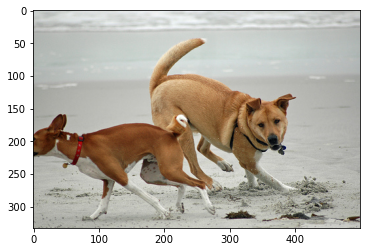

Caption: dog is running through the


In [52]:
z = 20
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

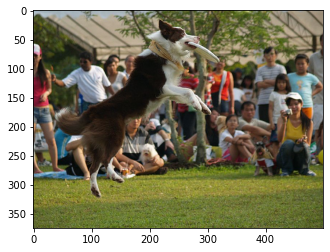

Caption: white dog is jumping over


In [53]:
z = 100
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))